# Install Dependencies

In [1]:
!pip install pytorch-lightning
!pip install neptune

# Import Needed Modules

In [8]:
import os
import gc
import re
import json
import math
import warnings
from abc import ABC, abstractmethod
from collections import OrderedDict
from random import randint
from typing import Iterable, Tuple
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import Tensor, nn
from torch.nn import functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, IterableDataset
from matplotlib.figure import Figure
from pandas import DataFrame
from pytorch_lightning import LightningModule, seed_everything
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.utils import column_or_1d
from tqdm.auto import tqdm
from pathlib import Path
from transformers import PreTrainedTokenizer
from transformers import (
    AutoTokenizer, AutoModel, AutoModelForSequenceClassification,
    GenerationMixin, TFGenerationMixin
)

# Ignore transformers FutureWarning
warnings.simplefilter("ignore", category=FutureWarning)

# Define Constants

In [2]:
# Set Random Seed
SEED = 2025
seed_everything(SEED)  # Ensures reproducibility across runs

Seed set to 2025


2025

In [3]:
# Define Directory Paths
ROOT_DIR = os.path.abspath(".")
PROCESSED_DATA_DIR, CHECKPOINT_DIR = f"{ROOT_DIR}\\data\\processed", f"{ROOT_DIR}\\checkpoint"
METADATA_FILE_NAME = f"{PROCESSED_DATA_DIR}\\metadata.json"

# Determine Execution Environment
KAGGLE_ENV = bool(os.getenv("KAGGLE_URL_BASE"))
RAW_DATA_DIR = f"{ROOT_DIR}\\..\\input" if KAGGLE_ENV else f"{ROOT_DIR}\\data\\raw"

# Dataset Configuration
DATASET_MAPPING = {
    "SemEval2010Task8": {
        "dir": f"{RAW_DATA_DIR}\\semeval2010-task-8",
        "keep_test_order": True,  # Maintain test sample order
        "precision_recall_curve_baseline_img": None,  # Placeholder for baseline PR curve
    }
}

# Specify the dataset to use
# DATASET_NAME = "SemEval2010Task8"  # Change this variable to switch datasets
DATASET_NAME = next(iter(DATASET_MAPPING))

# Define Entity Markup Characters
SUB_START_CHAR, SUB_END_CHAR = "[", "]"   # Subject markers
OBJ_START_CHAR, OBJ_END_CHAR = "{", "}"   # Object markers

# Pretrained BERT Variants
# Refer to https://huggingface.co/transformers/pretrained_models.html for more details
AVAILABLE_PRETRAINED_MODELS = [
    "distilbert-base-uncased",  # 0 - Lightweight DistilBERT (uncased)
    "distilbert-base-cased",    # 1 - Lightweight DistilBERT (cased)
    "bert-base-uncased",        # 2 - Standard BERT (uncased)
    "bert-large-uncased",       # 3 - Large BERT (uncased)
    "distilroberta-base",       # 4 - Lightweight RoBERTa
    "roberta-base",             # 5 - Standard RoBERTa
    "albert-base-v1",           # 6 - ALBERT v1 (efficient BERT variant)
    "albert-base-v2",           # 7 - ALBERT v2 (improved efficiency)
]

# Select the pretrained model to use (change as needed)
PRETRAINED_MODEL = AVAILABLE_PRETRAINED_MODELS[2]  # Default: BERT-Base (uncased)

# Relationship Handling
# If entity e1 is unrelated to entity e2, should "e2 is unrelated to e1" be explicitly added to the training set?
ADD_REVERSE_RELATIONSHIP = True

# Neptune Logging Configuration
# Sign up at https://neptune.ai/ and obtain an API token to enable logging
NEPTUNE_API_TOKEN = " eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0YmEyZTg2ZC0zNDMxLTQ2MzItOWEzYS0xOWY5ZGNiYTA5YWYifQ== "
NEPTUNE_PROJECT_NAME = "Violetta/BERT"  # Specify Neptune project name

# Preprocess

In [4]:
class OrdinalLabelEncoder:
    def __init__(self, init_labels=None):
        # if init_labels is None:
        #     init_labels = []
        # self.mapping = OrderedDict({l: i for i, l in enumerate(init_labels)})
        self.mapping = OrderedDict(zip(init_labels or [], range(len(init_labels or []))))

    @property
    def classes_(self):
        return list(self.mapping.keys())

    def fit_transform(self, y):
        return self.fit(y).transform(y)

    def fit(self, y):
        y = column_or_1d(y, warn=True)
        # new_classes = pd.Series(y).unique()
        # for cls in new_classes:
        #     if cls not in self.mapping:
        #         self.mapping[cls] = len(self.mapping)
        unseen_classes = [cls for cls in pd.Series(y).unique() if cls not in self.mapping]
        self.mapping.update({cls: len(self.mapping) + i for i, cls in enumerate(unseen_classes)})
        return self

    def transform(self, y):
        y = column_or_1d(y, warn=True)
        # return [self.mapping[value] for value in y]
        return list(map(self.mapping.get, y))

## Abstract preprocessor class:

In [38]:
class AbstractPreprocessor(ABC):
    DATASET_NAME = ""
    VAL_DATA_PROPORTION = 0.2
    NO_RELATION_LABEL = ""

    def __init__(self, tokenizer: PreTrainedTokenizer):
        self.tokenizer = tokenizer
        # self.SUB_START_ID, self.SUB_END_ID, self.OBJ_START_ID, self.OBJ_END_ID \
        #     = tokenizer.convert_tokens_to_ids([SUB_START_CHAR, SUB_END_CHAR, OBJ_START_CHAR, OBJ_END_CHAR])
        self.tokenizer = tokenizer
        self.SUB_START_ID, self.SUB_END_ID, self.OBJ_START_ID, self.OBJ_END_ID = tokenizer.convert_tokens_to_ids(
            [SUB_START_CHAR, SUB_END_CHAR, OBJ_START_CHAR, OBJ_END_CHAR]
        )
        self.label_encoder = OrdinalLabelEncoder([self.NO_RELATION_LABEL])

    def preprocess_data(self, reprocess: bool):
        print(f"\n---> Preprocessing {self.DATASET_NAME} dataset <---")

        # # create processed data dir
        # if not os.path.exists(PROCESSED_DATA_DIR):
        #     print("Creating processed data directory " + PROCESSED_DATA_DIR)
        #     os.makedirs(PROCESSED_DATA_DIR)
        # Create processed data directory if not exists
        processed_path = Path(PROCESSED_DATA_DIR)
        if not processed_path.exists():
            print(f"Creating processed data directory: {processed_path}")
            processed_path.mkdir(parents=True)

        # stop preprocessing if file existed
        json_file_names = [self.get_dataset_file_name(k) for k in ("train", "val", "test")]
        existed_files = [fn for fn in json_file_names if os.path.exists(fn)]

        # if existed_files:
        #     file_text = "- " + "\n- ".join(existed_files)
        #     if not reprocess:
        #         print("The following files already exist:")
        #         print(file_text)
        #         print("Preprocessing is skipped. See option --reprocess.")
        #         return
        #     else:
        #         print("The following files will be overwritten:")
        #         print(file_text)
        if existed_files:
            file_list_text = "\n- ".join(existed_files)
            print("The following files already exist:" if not reprocess else "The following files will be overwritten:")
            print(f"- {file_list_text}")
            if not reprocess:
                print("Skipping preprocessing. Use --reprocess to override.")
                return

        train_data, val_data, test_data = self._preprocess_data()
        print("Saving to json files")

        # self._write_data_to_file(train_data, "train")
        # self._write_data_to_file(val_data, "val")
        # self._write_data_to_file(test_data, "test")
        for subset, data in zip(["train", "val", "test"], [train_data, val_data, test_data]):
            self._write_data_to_file(data, subset)

        self._save_metadata({
            "train_size": len(train_data),
            "val_size": len(val_data),
            "test_size": len(test_data),
            "no_relation_label": self.NO_RELATION_LABEL,
            **self._get_label_mapping()
        })

        self._create_secondary_data_files()

        print("---> Processing Completed! <---")

    @abstractmethod
    def _preprocess_data(self) -> Tuple[DataFrame, DataFrame, DataFrame]:
        pass

    def _create_secondary_data_files(self):
        """
        From the primary data file, create a data file with binary labels
        and a data file with only sentences classified as "related"
        """

        with open(METADATA_FILE_NAME) as f:
            root_metadata = json.load(f)
            metadata = root_metadata[self.DATASET_NAME]

        related_only_count = {
            "train": 0,
            "val": 0,
            "test": 0,
        }

        # for key in ["train", "test", "val"]:
        #     print(f"Creating secondary files for {key} data")
        # 
        #     origin_file = open(self.get_dataset_file_name(key))
        #     bin_file = open(self.get_dataset_file_name(f"{key}_binary"), "w")
        #     related_file = open(self.get_dataset_file_name(f"{key}_related_only"), "w")
        # 
        #     total = metadata[f"{key}_size"]
        # 
        #     for line in tqdm(origin_file, total=total):
        #         data = json.loads(line)
        #         if data["label"] != 0:
        #             related_only_count[key] += 1
        #             data["label"] -= 1 # label in "related_only" files is 1 less than the original label
        #             related_file.write(json.dumps(data) + "\n")
        #             data["label"] = 1 # in binary dataset, all "related" classes have label 1
        #             bin_file.write(json.dumps(data) + "\n")
        #         else:
        #             bin_file.write(json.dumps(data) + "\n")
        # 
        #     origin_file.close()
        #     bin_file.close()
        #     related_file.close()

        for key in related_only_count:
            print(f"Generating secondary dataset for {key} set")

            with open(self.get_dataset_file_name(key)) as origin_file, \
                 open(self.get_dataset_file_name(f"{key}_binary"), "w") as bin_file, \
                 open(self.get_dataset_file_name(f"{key}_related_only"), "w") as related_file:

                for line in tqdm(origin_file, total=metadata[f"{key}_size"]):
                    data = json.loads(line)
                    if data["label"] != 0:
                        related_only_count[key] += 1
                        data["label"] -= 1  # Shift labels in "related_only" dataset
                        related_file.write(json.dumps(data) + "\n")
                        data["label"] = 1  # Convert all related labels to 1 in binary dataset
                        bin_file.write(json.dumps(data) + "\n")
                    else:
                        bin_file.write(json.dumps(data) + "\n")

        # print("Updating metadata.json")
        # for key in ["train", "test", "val"]:
        #     metadata[f"{key}_related_only_size"] = related_only_count[key]
        # root_metadata[self.DATASET_NAME] = metadata

        # Update metadata
        print("Updating metadata.json")
        for key in related_only_count:
            metadata[f"{key}_related_only_size"] = related_only_count[key]
        root_metadata[self.DATASET_NAME] = metadata

        with open(METADATA_FILE_NAME, "w") as f:
            json.dump(root_metadata, f, indent=4)

    def _find_sub_obj_pos(self, input_ids_list: Iterable) -> pd.DataFrame:
        # """
        # Find subject and object position in a sentence
        # """
        # sub_start_pos = [self._index(s, self.SUB_START_ID) + 1 for s in input_ids_list]
        # sub_end_pos = [self._index(s, self.SUB_END_ID, sub_start_pos[i]) for i, s in enumerate(input_ids_list)]
        # obj_start_pos = [self._index(s, self.OBJ_START_ID) + 1 for s in input_ids_list]
        # obj_end_pos = [self._index(s, self.OBJ_END_ID, obj_start_pos[i]) for i, s in enumerate(input_ids_list)]
        """Identify subject and object positions in input sequences."""
        sub_start_pos = [self._index(s, self.SUB_START_ID) + 1 for s in input_ids_list]
        obj_start_pos = [self._index(s, self.OBJ_START_ID) + 1 for s in input_ids_list]
        sub_end_pos, obj_end_pos = zip(*[(self._index(s, self.SUB_END_ID, sub), self._index(s, self.OBJ_END_ID, obj))
                                         for s, sub, obj in zip(input_ids_list, sub_start_pos, obj_start_pos)])

        # return DataFrame({
        #     "sub_start_pos": sub_start_pos,
        #     "sub_end_pos": sub_end_pos,
        #     "obj_start_pos": obj_start_pos,
        #     "obj_end_pos": obj_end_pos,
        # })
        return pd.DataFrame({
            "sub_start_pos": sub_start_pos,
            "sub_end_pos": sub_end_pos,
            "obj_start_pos": obj_start_pos,
            "obj_end_pos": obj_end_pos,
        })

    @staticmethod
    def _index(lst: list, ele: int, start: int = 0) -> int:
        # """
        # Find an element in a list. Returns -1 if not found instead of raising an exception.
        # """
        # try:
        #     return lst.index(ele, start)
        # except ValueError:
        #     return -1
        """Find element index in a list, return -1 if not found."""
        return lst.index(ele, start) if ele in lst[start:] else -1

    def _clean_data(self, raw_sentences: list, labels: list) -> pd.DataFrame:
        if not raw_sentences:
            return pd.DataFrame()

        tokens = self.tokenizer(raw_sentences, truncation=True, padding="max_length")
        data = DataFrame(tokens.data)
        data["label"] = self.label_encoder.fit_transform(labels)

        return self._remove_invalid_sentences(pd.concat([data, self._find_sub_obj_pos(data["input_ids"])], axis=1))

        # sub_obj_position = self._find_sub_obj_pos(data["input_ids"])
        # data = pd.concat([data, sub_obj_position], axis=1)
        # data = self._remove_invalid_sentences(data)
        # return data

    def _remove_invalid_sentences(self, data: pd.DataFrame) -> pd.DataFrame:
        # """
        # Remove sentences without subject/object or whose subject/object
        # is beyond the maximum length the model supports
        # """
        # seq_max_len = self.tokenizer.model_max_length
        # return data.loc[
        #     (data["sub_end_pos"] < seq_max_len)
        #     & (data["obj_end_pos"] < seq_max_len)
        #     & (data["sub_end_pos"] > -1)
        #     & (data["obj_end_pos"] > -1)
        # ]
        """Filter out sentences with missing or out-of-bounds subject/object markers."""
        max_len = self.tokenizer.model_max_length
        return data.loc[(data["sub_end_pos"] < max_len) & (data["obj_end_pos"] < max_len) &
                        (data["sub_end_pos"] > -1) & (data["obj_end_pos"] > -1)]

    def _get_label_mapping(self):
        """
        Returns a mapping from id to label and vise versa from the label encoder
        """
        # all labels
        id_to_label = dict(enumerate(self.label_encoder.classes_))
        label_to_id = {v: k for k, v in id_to_label.items()}

        # for the related_only dataset
        # ignore id 0, which represent no relation
        id_to_label_related_only = {k - 1: v for k, v in id_to_label.items() if k != 0}
        label_to_id_related_only = {v: k for k, v in id_to_label_related_only.items()}

        return {
            "id_to_label": id_to_label,
            "label_to_id": label_to_id,
            "id_to_label_related_only": id_to_label_related_only,
            "label_to_id_related_only": label_to_id_related_only,            
        }

    def _write_data_to_file(self, dataframe: pd.DataFrame, subset: str):
        # """Write data in a dataframe to train/val/test file"""
        # lines = ""
        # for _, row in dataframe.iterrows():
        #     lines += row.to_json() + "\n"
        # with open(self.get_dataset_file_name(subset), "w") as file:
        #     file.write(lines)
        """Write processed data to JSON files."""
        with open(self.get_dataset_file_name(subset), "w") as file:
            file.write("\n".join(dataframe.apply(lambda row: row.to_json(), axis=1)) + "\n")

    def _save_metadata(self, metadata: dict):
        """Save metadata to metadata.json"""
        # create metadata file
        if not os.path.exists(METADATA_FILE_NAME):
            print(f"Create metadata file at {METADATA_FILE_NAME}")
            with open(METADATA_FILE_NAME, "w") as f:
                f.write("{}\n")

        # add metadata
        print("Saving metadata")
        with open(METADATA_FILE_NAME) as f:
            root_metadata = json.load(f)
        with open(METADATA_FILE_NAME, "w") as f:
            root_metadata[self.DATASET_NAME] = metadata
            json.dump(root_metadata, f, indent=4)

    @classmethod
    def get_dataset_file_name(cls, key: str) -> str:
        # return os.path.join(PROCESSED_DATA_DIR, f"{cls.DATASET_NAME.lower()}_{key}.json")
        return f"{PROCESSED_DATA_DIR}\\{cls.DATASET_NAME.lower()}_{key}.json"

## Concrete Preprocessor

In [42]:
class SemEval2010Task8Preprocessor(AbstractPreprocessor):
    DATASET_NAME = "SemEval2010Task8"
    NO_RELATION_LABEL = "Other"
    RAW_TRAIN_FILE_NAME = os.path.join(DATASET_MAPPING["SemEval2010Task8"]["dir"],
                                       "SemEval2010_task8_training\\TRAIN_FILE.TXT")
    RAW_TEST_FILE_NAME = os.path.join(DATASET_MAPPING["SemEval2010Task8"]["dir"],
                                      "SemEval2010_task8_testing_keys\\TEST_FILE_FULL.TXT")
    RAW_TRAIN_DATA_SIZE = 8000
    RAW_TEST_DATA_SIZE = 2717

    def _preprocess_data(self):
        # print("Processing training data")
        # train_data = self._process_file(
        #     self.RAW_TRAIN_FILE_NAME,
        #     self.RAW_TRAIN_DATA_SIZE,
        #     ADD_REVERSE_RELATIONSHIP,
        # )
        # 
        # print("Processing test data")
        # test_data = self._process_file(
        #     self.RAW_TEST_FILE_NAME,
        #     self.RAW_TEST_DATA_SIZE,
        #     False,
        # )
        # 
        # print("Splitting train & validate data")
        # train_data, val_data = train_test_split(train_data, shuffle=True, random_state=SEED)
        # 
        # return train_data, val_data, test_data
        """Loads and processes training, validation, and test datasets."""
        dataset_files = {
            "train": (self.RAW_TRAIN_FILE_NAME, self.RAW_TRAIN_DATA_SIZE, ADD_REVERSE_RELATIONSHIP),
            "test": (self.RAW_TEST_FILE_NAME, self.RAW_TEST_DATA_SIZE, False),
        }

        data = {key: self._process_file(*params) for key, params in dataset_files.items()}

        print("Splitting training data into train & validation sets")
        data["train"], data["val"] = train_test_split(data["train"], shuffle=True, random_state=SEED)

        return data["train"], data["val"], data["test"]

    def _process_file(self, file_name: str, dataset_size: int, add_reverse: bool) -> pd.DataFrame:
        raw_sentences = []
        labels = []
        with open(file_name) as f:
            for _ in tqdm(range(dataset_size)):
                sent = f.readline()
                label, sub, obj = self._process_label(f.readline())
                labels.append(label)
                raw_sentences.append(self._process_sentence(sent, sub, obj))
                if label == "Other" and add_reverse:
                    labels.append(label)
                    raw_sentences.append(self._process_sentence(sent, obj, sub))
                f.readline()
                f.readline()

        return self._clean_data(raw_sentences, labels)
    
    @staticmethod
    def _process_sentence(sentence: str, sub: int, obj: int) -> str:
        # return sentence.split("\t")[1][1:-2] \
        #     .replace(f"<e{sub}>", SUB_START_CHAR) \
        #     .replace(f"</e{sub}>", SUB_END_CHAR) \
        #     .replace(f"<e{obj}>", OBJ_START_CHAR) \
        #     .replace(f"</e{obj}>", OBJ_END_CHAR)
        """Replaces entity tags with predefined markers."""
        replacements = {
            f"<e{sub}>": SUB_START_CHAR,
            f"</e{sub}>": SUB_END_CHAR,
            f"<e{obj}>": OBJ_START_CHAR,
            f"</e{obj}>": OBJ_END_CHAR,
        }
        sentence = sentence.split("\t")[1][1:-2]  # Extract actual text
        for old, new in replacements.items():
            sentence = sentence.replace(old, new)
        return sentence

    @staticmethod
    def _process_label(label: str) -> Tuple[str, int, int]:
        label = label.strip()
        if label == "Other":
            return label, 1, 2
        nums = list(filter(str.isdigit, label))
        return label, int(nums[0]), int(nums[1])

## Factory Method to Create Preprocessors

In [43]:
def get_preprocessor_class(dataset_name: str = DATASET_NAME):
    return globals()[f"{dataset_name}Preprocessor"]

def get_preprocessor(dataset_name: str = DATASET_NAME)-> AbstractPreprocessor:
    tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL, use_fast=True)
    # some tokenizer, like GPTTokenizer, doesn't have pad_token
    # in this case, we use eos token as pad token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    preprocessors_class = get_preprocessor_class(dataset_name)
    return preprocessors_class(tokenizer)

## Preprocess Data:

In [44]:
preprocessor = get_preprocessor()
preprocessor.preprocess_data(reprocess=True)


---> Preprocessing SemEval2010Task8 dataset <---
The following files will be overwritten:
- E:\Python\TextMining\BERT\data\processed\semeval2010task8_train.json
- E:\Python\TextMining\BERT\data\processed\semeval2010task8_val.json
- E:\Python\TextMining\BERT\data\processed\semeval2010task8_test.json


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/2717 [00:00<?, ?it/s]

Splitting training data into train & validation sets
Saving to json files
Saving metadata
Generating secondary dataset for train set


  0%|          | 0/7057 [00:00<?, ?it/s]

Generating secondary dataset for val set


  0%|          | 0/2353 [00:00<?, ?it/s]

Generating secondary dataset for test set


  0%|          | 0/2717 [00:00<?, ?it/s]

Updating metadata.json
---> Processing Completed! <---


# Dataset

In [10]:
class GenericDataset(IterableDataset):
    """A generic dataset for train/val/test data for both SemEval and GIDS dataset"""

    def __init__(self, dataset_name: str, subset: str, batch_size: int, label_transform: str):
        assert subset in ["train", "val", "test"]
        assert label_transform in ["none", "binary", "related_only"]

        file_name = subset if label_transform == "none" \
            else f"{subset}_{label_transform}"

        preprocessor_class = get_preprocessor_class()
        with open(METADATA_FILE_NAME) as f:
            metadata = json.load(f)[dataset_name]

        size = metadata[f"{subset}_related_only_size"] \
            if label_transform == "related_only" \
            else metadata[f"{subset}_size"]

        self.subset = subset
        self.batch_size = batch_size
        self.length = math.ceil(size / batch_size)
        # self.file = open(preprocessor_class.get_dataset_file_name(file_name))
        self.file_path = preprocessor_class.get_dataset_file_name(file_name)
    
        self.keep_test_order = self.subset == "test" and DATASET_MAPPING[dataset_name]["keep_test_order"]

    def __del__(self):
        if self.file:
            self.file.close()

    def __iter__(self):
        """
        Implement "smart batching"
        """

        # data = [json.loads(line) for line in self.file]
        with open(self.file_path, "r") as file:  # 在 `__iter__()` 里打开文件
            data = [json.loads(line) for line in file]
            
        if not self.keep_test_order:
            data = sorted(data, key=lambda x: sum(x["attention_mask"]))

        new_data = []

        while len(data) > 0:
            if self.keep_test_order or len(data) < self.batch_size:
                idx = 0
            else:
                idx = randint(0, len(data) - self.batch_size)
            batch = data[idx:idx + self.batch_size]
            max_len = max([sum(b["attention_mask"]) for b in batch])

            for b in batch:
                input_data = {}
                for k, v in b.items():
                    if k != "label":
                        if isinstance(v, list):
                            input_data[k] = torch.tensor(v[:max_len])
                        else:
                            input_data[k] = torch.tensor(v)
                label = torch.tensor(b["label"])
                new_data.append((input_data, label))

            del data[idx:idx + self.batch_size]

        yield from new_data
    
    def __len__(self):
        return self.length

    def as_batches(self):
        input_data = []
        label = []
        
        def create_batch():
            return (
                {k: torch.stack([x[k] for x in input_data]).cuda() for k in input_data[0].keys()},
                torch.tensor(label).cuda()
            )
        
        for ip, l in self:
            input_data.append(ip)
            label.append(l)
            if len(input_data) == self.batch_size:
                yield create_batch()
                input_data.clear()
                label.clear()

        yield create_batch()

# Classifiers

In [11]:
from typing import List, Tuple, Dict, Iterable

class BaseClassifier(LightningModule, ABC):
    """
    Base class of all classifiers
    """
    
    dataset_label_transform = None

    @abstractmethod
    def loss_function(self, logits: Tensor, label: Tensor) -> Tensor:
        """
        Calculate the loss of the model
        It MUST take care of the last activation layer
        """
        pass
    
    @abstractmethod
    def log_metrics(self, epoch_type: str, logits: Tensor, label: Tensor) -> dict:
        pass

    def __init__(self, pretrained_language_model, dataset_name, batch_size, learning_rate, decay_lr_speed, dropout_p, activation_function, weight_decay, linear_size):
        super().__init__()
        self.save_hyperparameters()
        self.test_proposed_answer = None

        self.language_model = AutoModel.from_pretrained(pretrained_language_model)
        config = self.language_model.config
        self.max_seq_len = config.max_position_embeddings
        self.hidden_size = config.hidden_size

        self.linear = nn.Linear(self.hidden_size, linear_size)
        self.linear_output = nn.Linear(linear_size, self.num_classes)

        self.dropout = nn.Dropout(p=dropout_p)
        self.activation_function = getattr(nn, activation_function)()
        
        # 添加用于存储 epoch 端 `outputs`
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, sub_start_pos, sub_end_pos,
                obj_start_pos, obj_end_pos, *args, **kwargs) -> Tensor:
        language_model_output = self.language_model(*args, **kwargs)
        if isinstance(language_model_output, tuple):
            language_model_output = language_model_output[0]

        # x = torch.mean(language_model_output, dim=1)
        x = torch.mean(language_model_output.last_hidden_state, dim=1)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.activation_function(x)
        x = self.dropout(x)
        logits = self.linear_output(x)

        return logits

    def train_dataloader(self) -> DataLoader:
        return self.__get_dataloader("train")

    def val_dataloader(self) -> DataLoader:
        return self.__get_dataloader("val")

    def test_dataloader(self) -> DataLoader:
        return self.__get_dataloader("test")

    def __get_dataloader(self, subset: str) -> DataLoader:
        batch_size = self.hparams.batch_size
        dataset = GenericDataset(
            self.hparams.dataset_name,
            subset, 
            batch_size, 
            self.dataset_label_transform
        )
        num_workers = 0 if os.name == 'nt' else 4
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            persistent_workers=(num_workers > 0)  # 只有 num_workers>0 时启用
        )

    def configure_optimizers(self):
        optimizer = AdamW(
            [p for p in self.parameters() if p.requires_grad],
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay
        )
        scheduler = LambdaLR(optimizer, lambda epoch: self.hparams.decay_lr_speed[epoch])
        return [optimizer], [scheduler]
    
    # def training_step(self, batch: Tuple[dict, Tensor], batch_nb: int) -> dict:
    #     input_data, label = batch
    #     logits = self(**input_data)
    # 
    #     loss = self.loss_function(logits, label)
    #     log = {"train_loss": loss}
    # 
    #     return {"loss": loss, "log": log}
    
    def training_step(self, batch: Tuple[dict, Tensor], batch_nb: int) -> dict:
        input_data, label = batch
        logits = self(**input_data)

        loss = self.loss_function(logits, label)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True, sync_dist=True)

        return {"loss": loss, "logits": logits.detach(), "label": label.detach()}

    def __eval_step(self, batch:  Tuple[dict, Tensor]) -> dict:
        input_data, label = batch
        logits = self(**input_data)

        return {
            "logits": logits,
            "label": label,
        }
    
    # def validation_step(self, batch: Tuple[dict, Tensor], batch_nb: int) -> dict:
    #     return self.__eval_step(batch)
    
    def validation_step(self, batch: Tuple[dict, Tensor], batch_nb: int):
        input_data, label = batch
        logits = self(**input_data)

        loss = self.loss_function(logits, label)
        self.log("val_loss", loss, prog_bar=True, on_epoch=True, sync_dist=True)

        output = {"logits": logits.detach(), "label": label.detach()}
        self.validation_step_outputs.append(output)  # 存储输出
        return output
    
    # def test_step(self, batch: Tuple[dict, Tensor], batch_nb: int) -> dict:
    #     return self.__eval_step(batch)
    
    def test_step(self, batch: Tuple[dict, Tensor], batch_nb: int):
        input_data, label = batch
        logits = self(**input_data)

        loss = self.loss_function(logits, label)
        self.log("test_loss", loss, prog_bar=True, on_epoch=True, sync_dist=True)

        output = {"logits": logits.detach(), "label": label.detach()}
        self.test_step_outputs.append(output)  # 存储输出
        return output


    # def __eval_epoch_end(self, epoch_type: str, outputs: Iterable[dict]) -> dict:
    #     assert epoch_type in ["test", "val"]
    #     
    #     logits = torch.cat([x["logits"] for x in outputs]).cpu()
    #     label = torch.cat([x["label"] for x in outputs]).cpu()
    #     
    #     logs = self.log_metrics(epoch_type, logits, label)
    #     
    #     return {"progress_bar": logs}
    
    def __eval_epoch_end(self, epoch_type: str, outputs: List[dict]):
        assert epoch_type in ["test", "val"]

        logits = torch.cat([x["logits"] for x in outputs]).cpu()
        label = torch.cat([x["label"] for x in outputs]).cpu()

        logs = self.log_metrics(epoch_type, logits, label)
        
        # 记录日志
        for key, value in logs.items():
            self.log(f"{epoch_type}_{key}", value)

    # def on_validation_epoch_end(self, outputs: Iterable[dict]) -> dict:
    #     return self.__eval_epoch_end("val", outputs)

    # def on_test_epoch_end(self, outputs: Iterable[dict]) -> dict:
    #     return self.__eval_epoch_end("test", outputs)
    
    # def on_validation_epoch_end(self, outputs):  # 正确使用 Lightning 传入的 outputs
    #     if not outputs:  
    #         print("[WARNING] No validation outputs found. Skipping eval.")
    #         return  
    #     self.__eval_epoch_end("val", outputs)
    # 
    # def on_test_epoch_end(self, outputs):  # 正确使用 Lightning 传入的 outputs
    #     if not outputs:  
    #         print("[WARNING] No test outputs found. Skipping eval.")
    #         return  
    #     self.__eval_epoch_end("test", outputs)
    
    def on_validation_epoch_end(self):
        """Lightning 自动调用，无需传入 outputs"""
        print(f"[DEBUG] validation_step_outputs before eval: {self.validation_step_outputs}")

        if not self.validation_step_outputs:
            print("[WARNING] No validation outputs found. Skipping eval.")
            return

        self.__eval_epoch_end("val", self.validation_step_outputs)
        self.validation_step_outputs.clear()  # 清空，避免影响下个 epoch

    def on_test_epoch_end(self):
        """Lightning 自动调用，无需传入 outputs"""
        print(f"[DEBUG] test_step_outputs before eval: {self.test_step_outputs}")

        if not self.test_step_outputs:
            print("[WARNING] No test outputs found. Skipping eval.")
            return

        self.__eval_epoch_end("test", self.test_step_outputs)
        self.test_step_outputs.clear()  # 清空，避免影响下个 epoch


    def numeric_labels_to_text(self, label):
        """Revert labels from number to text"""
        if self.dataset_label_transform == "binary":
            label = ["Positive" if x else "Negative" for x in label]
        else:
            with open(METADATA_FILE_NAME) as f:
                meta = json.load(f)[self.hparams.dataset_name]
            if self.dataset_label_transform == "none":
                mapping = meta["id_to_label"]
            else:
                mapping = meta["id_to_label_related_only"]
            label = [mapping[str(int(x))] for x in label]
        return label

    @staticmethod
    def plot_confusion_matrix(predicted_label, label) -> Figure:
        result = confusion_matrix(label, predicted_label)
        display = ConfusionMatrixDisplay(result)
        fig, ax = plt.subplots(figsize=(16, 12))
        display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
        return fig

    def log_confusion_matrix(self, prefix: str, predicted_label: Tensor, label: Tensor):
        predicted_label = self.numeric_labels_to_text(predicted_label)
        label = self.numeric_labels_to_text(label)
        fig = self.plot_confusion_matrix(predicted_label, label)
        # self.logger.log_image(f"{prefix}_confusion_matrix", fig)
        self.logger.experiment[f"{prefix}_confusion_matrix"].log(fig)

class MulticlassClassifier(BaseClassifier, ABC):
    """
    Base class for multiclass classifiers
    """

    def loss_function(self, logits: Tensor, label: Tensor)-> Tensor:
        return F.cross_entropy(logits, label)

    @staticmethod
    def logits_to_label(logits: Tensor) -> Tensor:
        return torch.argmax(logits, dim=-1)

    def log_metrics(self, epoch_type: str, logits: Tensor, label: Tensor) -> dict:
        predicted_label = self.logits_to_label(logits)
        self.log_confusion_matrix(epoch_type, predicted_label, label)

        logs = {
            f"{epoch_type}_avg_loss": float(self.loss_function(logits, label)),
            f"{epoch_type}_acc": accuracy_score(label, predicted_label),
            f"{epoch_type}_pre_weighted": precision_score(label, predicted_label, average="weighted"),
            f"{epoch_type}_rec_weighted": recall_score(label, predicted_label, average="weighted"),
            f"{epoch_type}_f1_weighted": f1_score(label, predicted_label, average="weighted"),
            f"{epoch_type}_pre_macro": precision_score(label, predicted_label, average="macro"),
            f"{epoch_type}_rec_macro": recall_score(label, predicted_label, average="macro"),
            f"{epoch_type}_f1_macro": f1_score(label, predicted_label, average="macro"),
        }

        for k, v in logs.items():
            self.logger.experiment[k].log(v)
            
        return logs


class StandardClassifier(MulticlassClassifier):
    """
    A classifier that can recognize the "not related" as well as other relations
    """

    dataset_label_transform = "none"

    def __init__(self, dataset_name, **kwargs):
        with open(METADATA_FILE_NAME) as f:
            self.num_classes = len(json.load(f)[dataset_name]["label_to_id"])
        self.test_proposed_answer = None
        super().__init__(dataset_name=dataset_name, **kwargs)


    def log_metrics(self, epoch_type: str, logits: Tensor, label: Tensor)-> dict:
        if epoch_type == "test":
            self.test_proposed_answer = self.logits_to_label(logits).tolist()
        self.__log_precision_recall_curve(epoch_type, logits, label)
        return super().log_metrics(epoch_type, logits, label)

    def __log_precision_recall_curve(self, epoch_type: str, logits: Tensor, label: Tensor):
        """
        Log the micro-averaged precision recall curve
        Ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
        """

        label = torch.tensor(label_binarize(label, classes=list(range(self.num_classes)))).flatten()
        logits = logits.flatten()

        pre, rec, thresholds = precision_recall_curve(label, logits)
        f1s = 2 * pre * rec / (pre + rec)
        ix = np.argmax(f1s)

        fig, ax = plt.subplots(figsize=(10, 10))

        # render the baseline curves as background for comparison
        background = DATASET_MAPPING[self.hparams.dataset_name]["precision_recall_curve_baseline_img"]
        if background:
            img = plt.imread(background)
            ax.imshow(img, extent=[0, 1, 0, 1])

        no_skill = len(label[label == 1]) / len(label)
        ax.plot(rec, pre, label="Our proposed model", color="blue")
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.legend()

        # self.logger.log_image(f"{epoch_type}_pre_rec_curve", fig)
        self.logger.experiment[f"{epoch_type}_pre_rec_curve"].log(fig)
        # self.log_metrics(
        #     f"{epoch_type}_average_precision_score_micro",
        #     average_precision_score(label, logits, average="micro")
        # )
        avg_precision = average_precision_score(label, logits, average="micro")
        self.logger.experiment[f"{epoch_type}_average_precision_score_micro"].log(avg_precision)


class BinaryClassifier(BaseClassifier):
    """
    A binary classifier that picks out "not-related" sentences
    """

    dataset_label_transform = "binary"
    num_classes = 1

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.thresholds = {}

    def forward(self, *args, **kwargs):
        return super().forward(*args, **kwargs).flatten()

    @staticmethod
    def yhat_to_label(y_hat: Tensor, threshold: float) -> Tensor:
        return (y_hat > threshold).long()

    def loss_function(self, logits: Tensor, label: Tensor) -> Tensor:
        return F.binary_cross_entropy_with_logits(logits, label.float())

    def log_metrics(self, epoch_type: str, logits: Tensor, label: Tensor) -> dict:
        y_hat = torch.sigmoid(logits)

        if epoch_type == "val":
            self.__find_thresholds(y_hat, label)

        self.__log_output_distribution(epoch_type, y_hat, label)

        logs = {
            f"{epoch_type}_avg_loss": float(self.loss_function(logits, label)),
            f"{epoch_type}_roc_auc": self.__roc_auc_score(label, y_hat),
        }

        for criteria, threshold in self.thresholds.items():
            prefix = f"{epoch_type}_{criteria}"
            predicted_label = self.yhat_to_label(y_hat, threshold)
            self.log_confusion_matrix(prefix, predicted_label, label)

            logs[f"{prefix}_acc"] = accuracy_score(label, predicted_label)
            logs[f"{prefix}_pre"] = precision_score(label, predicted_label, average="binary")
            logs[f"{prefix}_rec"] = recall_score(label, predicted_label, average="binary")
            logs[f"{prefix}_f1"] = f1_score(label, predicted_label, average="binary")

        for k, v in logs.items():
            self.logger.experiment[k].log(v)

        return logs

    @staticmethod
    def __roc_auc_score(label: Tensor, y_hat: Tensor) -> float:
        try:
            return roc_auc_score(label, y_hat)
        except ValueError:
            return 0

    def __find_thresholds(self, y_hat: Tensor, label: Tensor):
        """
        Find 3 classification thresholds based on 3 criteria:
        - The one that yields highest accuracy
        - The "best point" in the ROC curve
        - The one that yields highest f1
        The results are logged and stored in self.threshold
        """
        # best accuracy
        best_acc = 0
        best_acc_threshold = None
        for y in y_hat:
            y_predicted = self.yhat_to_label(y_hat, threshold=y)
            acc = accuracy_score(label, y_predicted)
            if best_acc < acc:
                best_acc = acc
                best_acc_threshold = y
        self.thresholds["best_acc"] = best_acc_threshold

        # ROC curve
        # https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
        fpr, tpr, thresholds = roc_curve(label, y_hat)
        gmeans = tpr * (1 - fpr)
        ix = np.argmax(gmeans)
        self.thresholds["best_roc"] = thresholds[ix]
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.plot([0,1], [0,1], linestyle="--", label="No Skill")
        ax.plot(fpr, tpr, marker=".", label="Logistic")
        ax.scatter(fpr[ix], tpr[ix], marker="o", color="black", label="Best")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.legend()
        # self.logger.log_image("roc_curve", fig)
        self.logger.experiment["roc_curve"].log(fig)

        # precision recall curve
        # https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
        pre, rec, thresholds = precision_recall_curve(label, y_hat)
        f1s = 2 * pre * rec / (pre + rec)
        ix = np.argmax(f1s)
        self.thresholds["best_f1"] = thresholds[ix]

        fig, ax = plt.subplots(figsize=(16, 12))
        no_skill = len(label[label == 1]) / len(label)
        ax.plot([0, 1], [no_skill, no_skill], linestyle="--", label="No Skill")
        ax.plot(rec, pre, marker=".", label="Logistic")
        ax.scatter(rec[ix], pre[ix], marker="o", color="black", label="Best F1")
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.legend()
        # self.logger.log_image("pre_rec_curve", fig)
        self.logger.experiment["pre_rec_curve"].log(fig)
        
        # log thresholds
        for k, v in self.thresholds.items():
            self.logger.experiment[f"threshold_{k}"].log(v)

    def __log_output_distribution(self, epoch_type: str, y_hat: Tensor, label: Tensor):
        """
        Log the distribution of the model output and 3 thresholds with log scale and linear scale
        """
        y_neg = y_hat[label == 0].numpy()
        y_pos = y_hat[label == 1].numpy()

        for scale in ["linear", "log"]:
            fig, ax = plt.subplots(figsize=(16, 12))
            ax.set_yscale(scale)
            ax.hist([y_neg, y_pos], stacked=True, bins=50, label=["No relation", "Related"])
            ylim = ax.get_ylim()
            for k, v in self.thresholds.items():
                ax.plot([v, v], ylim, linestyle="--", label=f"{k} threshold")
            ax.legend()
            # self.logger.log_image(f"{epoch_type}_distribution_{scale}_scale", fig)
            self.logger.experiment[f"{epoch_type}_distribution_{scale}_scale"].log(fig)

class RelationClassifier(MulticlassClassifier):
    """
    A classifier that recognizes relations except for "not-related"
    """

    dataset_label_transform = "related_only"

    def __init__(self, dataset_name, **kwargs):
        with open(METADATA_FILE_NAME) as f:
            self.num_classes = len(json.load(f)[dataset_name]["label_to_id_related_only"])
        super().__init__(dataset_name=dataset_name, **kwargs)

# The official scorer
Some datasets comes with official scorers. We will define them in this session.

In [12]:
class AbstractScorer(ABC):
    def __init__(self, experiment_no: int, logger):
        self.experiment_no = experiment_no
        self.logger = logger

    @abstractmethod
    def score(self, proposed_answer: dict):
        pass

class SemEval2010Task8Scorer(AbstractScorer):
    RESULT_FILE = "semeval2010_task8_official_score_{}_{}.txt"
    PROPOSED_ANSWER_FILE = "semeval2010_task8_proposed_answer.txt"
    SCORER = os.path.join(DATASET_MAPPING["SemEval2010Task8"]["dir"], "SemEval2010_task8_scorer-v1.2/semeval2010_task8_scorer-v1.2.pl")
    FORMAT_CHECKER = os.path.join(DATASET_MAPPING["SemEval2010Task8"]["dir"], "SemEval2010_task8_scorer-v1.2/semeval2010_task8_format_checker.pl")
    ANSWER_KEY = os.path.join(DATASET_MAPPING["SemEval2010Task8"]["dir"], "SemEval2010_task8_testing_keys/TEST_FILE_KEY.TXT")

    def score(self, proposed_answer: dict):
        # write test_result to file
        with open(METADATA_FILE_NAME) as f:
            metadata = json.load(f)
            id_to_label = {int(k): v for k, v in metadata[DATASET_NAME]["id_to_label"].items()}

        for criteria, answer in proposed_answer.items():
            result_file = self.RESULT_FILE.format(self.experiment_no, criteria)
            i = 8001
            with open(self.PROPOSED_ANSWER_FILE, "w") as f:
                for r in answer:
                    f.write(f"{i}\t{id_to_label[r]}\n")
                    i += 1

            # call the official scorer
            os.system(f"perl {self.FORMAT_CHECKER} {self.PROPOSED_ANSWER_FILE}")
            os.system(f"perl {self.SCORER} {self.PROPOSED_ANSWER_FILE} {self.ANSWER_KEY} > {result_file}")

            # log the official score
            with open(result_file) as f:
                result = f.read()
                print(f">>> Classifier with criteria: {criteria} <<<")
                print(result)
                print("\n\n")
            # self.logger.log_artifact(result_file)
            self.logger.experiment[f"artifact_{result_file}"].upload(result_file)  # 新版 API

def get_official_scorer(experiment_no: int, logger, dataset_name: str = DATASET_NAME) -> AbstractScorer:
    cls = globals().get(dataset_name + "Scorer")
    if cls:
        return cls(experiment_no, logger)

# Claiming back memory & disk space

In [13]:
1 / 0

ZeroDivisionError: division by zero

In [14]:
trainer = classifier = rel_trainer = rel_classifier = bin_trainer = bin_classifier = None
gc.collect()
torch.cuda.empty_cache()

# Training standard classifier

In [15]:
GPUS = 1
MIN_EPOCHS = MAX_EPOCHS = 3

BATCH_SIZE = 16
LEARNING_RATE = 2e-05
LEARNING_RATE_DECAY_SPEED = [1, 1, 0.75, 0.5, 0.25, 0.1, 0.075, 0.05, 0.025, 0.01]

LINEAR_SIZE = 1024

DROPOUT_P = 0.2
ACTIVATION_FUNCTION = "PReLU"
WEIGHT_DECAY = 0.01 # default = 0.01

In [16]:
print(torch.cuda.is_available())  # 是否检测到 GPU
print(torch.cuda.device_count())  # 有多少个 GPU
print(torch.cuda.current_device())  # 当前使用的 GPU
print(torch.cuda.get_device_name(0))  # GPU 设备名称

True
1
0
NVIDIA GeForce RTX 4090


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


--------- EXPERIMENT 0 ---------


You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


🚀 开始训练


[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/Violetta/BERT/e/BERTRE-67


E:\Python\Python3.11.5\Lib\site-packages\neptune\internal\utils\git.py:71: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type      | Params | Mode 
----------------------------------------------------------
0 | language_model      | BertModel | 109 M  | eval 
1 | linear              | Linear    | 787 K  | train
2 | linear_output       | Linear    | 19.5 K | train
3 | dropout             | Dropout   | 0      | train
4 | activation_function | PReLU     | 1      | train
----------------------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
441.157   Total estimated model params size (MB)
4         Modules in train mode
228       Modules in eval mode
E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers 

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[ 1.6783, -0.0645, -0.2003, -0.5837,  0.3440,  1.2275, -0.1869, -0.1992,
         -0.4422,  0.4487, -0.1302, -0.0895, -0.0850, -0.6077, -0.5066, -0.5958,
         -0.4248, -0.5315, -0.5246],
        [ 1.8826, -0.0667, -0.1492, -0.5323,  0.2690,  1.3047, -0.2832, -0.0843,
         -0.5336,  0.4293, -0.2009, -0.2047, -0.1347, -0.5853, -0.6229, -0.5624,
         -0.5095, -0.4331, -0.5668],
        [ 1.7253, -0.0877, -0.1054, -0.3902,  0.2944,  1.1476, -0.2560,  0.0489,
         -0.3851,  0.4031, -0.1251, -0.0637, -0.1843, -0.5148, -0.5048, -0.4622,
         -0.3274, -0.5456, -0.5302],
        [ 1.8045, -0.0358, -0.1457, -0.4814,  0.2349,  1.2030, -0.2136,  0.0217,
         -0.4431,  0.4311, -0.1813, -0.2022, -0.1702, -0.5226, -0.5705, -0.5836,
         -0.5823, -0.4484, -0.6810],
        [ 1.7791,  0.0065, -0.2425, -0.5174,  0.2846,  1.2759, -0.2081, -0.0443,
         -0.4738,  0.4266, -0.1720, -0.2840, -0.1593, -0.4897, -0.

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 27.0


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[ 1.9257e+00,  2.5183e-01,  2.7520e-02, -9.2930e-01,  3.5709e-01,
          2.7378e-01, -8.2563e-03, -5.4872e-02, -1.9877e-02,  5.7438e-01,
         -8.0367e-02, -2.4879e-01,  8.3707e-02, -5.9623e-01, -3.7435e-01,
         -6.0500e-01, -4.9949e-01, -6.9152e-01, -1.0956e+00],
        [ 2.0504e+00,  1.4972e-01, -7.1625e-02, -1.0641e+00,  3.3540e-01,
          4.0678e-01,  2.9880e-02, -2.0394e-01,  2.3454e-03,  5.8359e-01,
          3.4650e-02, -2.0026e-01,  5.5264e-02, -6.6945e-01, -5.4340e-01,
         -7.1367e-01, -3.3519e-01, -7.4729e-01, -1.0875e+00],
        [ 1.9898e+00,  9.7928e-02, -1.2466e-01, -7.9912e-01,  4.6781e-01,
          3.0144e-01, -8.5501e-02, -4.8255e-02,  1.2063e-02,  6.5014e-01,
          8.7662e-02, -2.2693e-01,  4.8195e-02, -4.7950e-01, -4.4559e-01,
         -6.1319e-01, -3.8433e-01, -7.7495e-01, -1.0898e+00],
        [ 1.8744e+00,  2.0997e-01,  1.1647e-01, -1.0546e+00,  2.8744e-01,
          2.8327e

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[ 1.3552,  0.2963,  0.1691, -1.0481,  0.0181,  0.9929,  0.5744, -0.5047,
         -0.1282,  0.0110,  0.3993, -0.4452,  0.7467, -0.9684, -0.2853, -0.8743,
         -0.5407, -0.7979, -1.0743],
        [ 2.0571, -0.0123, -0.1675, -0.9234,  0.2270,  0.7934, -0.0668,  0.0106,
         -0.1133,  0.3954,  0.2545, -0.1310, -0.0269, -0.7474, -0.2112, -0.8034,
         -0.6544, -0.9205, -1.1548],
        [ 2.2736, -0.0319, -0.2081, -0.8984,  0.4130,  0.5284, -0.1926,  0.2589,
          0.0870,  0.5163,  0.0402, -0.1439, -0.0220, -0.6470, -0.1995, -0.7811,
         -0.5979, -0.7853, -1.2823],
        [ 2.0707, -0.0355, -0.0292, -1.0485,  0.4273,  0.2295, -0.0907,  0.0819,
          0.1621,  0.7470,  0.2343, -0.1236,  0.0625, -0.6556, -0.1205, -0.8565,
         -0.5062, -0.9799, -1.3172],
        [ 1.3592,  0.2583,  0.1381, -1.0426, -0.0460,  1.0284,  0.5161, -0.5753,
         -0.1520,  0.0314,  0.4243, -0.4002,  0.6559, -1.0034, -0.

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:303: RuntimeWarning: invalid value encountered in divide
  f1s = 2 * pre * rec / (pre + rec)
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predict

✅ 训练完成


E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\utilities\data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Testing: |          | 0/? [00:00<?, ?it/s]

[DEBUG] test_step_outputs before eval: [{'logits': tensor([[ 1.8271e+00,  1.7382e-02,  4.9607e-03, -8.7888e-01,  4.7769e-01,
          4.5327e-01, -1.1191e-01,  2.9941e-02,  5.9568e-02,  2.4722e-01,
          4.2455e-02, -1.5888e-02,  1.5253e-01, -6.8217e-01, -2.9527e-01,
         -7.1316e-01, -4.9797e-01, -7.3907e-01, -1.0980e+00],
        [ 1.6165e+00,  2.1018e-01,  1.7764e-01, -1.0028e+00, -9.3898e-02,
          1.0335e+00,  1.0375e-01, -3.9505e-01, -2.9782e-02,  6.0691e-02,
          3.4509e-01, -3.3593e-01,  5.0783e-01, -9.0974e-01, -2.1613e-01,
         -8.4173e-01, -5.2909e-01, -6.8832e-01, -1.1064e+00],
        [ 1.7034e+00,  1.7465e-01,  2.2151e-01, -9.7208e-01,  5.7257e-03,
          1.0507e+00,  6.6806e-02, -3.2886e-01, -5.6037e-02,  2.2393e-01,
          4.0742e-01, -3.5015e-01,  3.7580e-01, -8.9386e-01, -2.8248e-01,
         -9.0858e-01, -5.6333e-01, -8.1318e-01, -1.1163e+00],
        [ 1.4940e+00,  1.4229e-02,  1.8335e-03, -9.8820e-01,  1.3646e-01,
          1.1518e+00,  

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    2.5656321048736572     │
│       test_test_acc       │    0.17613635957241058    │
│    test_test_avg_loss     │    2.5656323432922363     │
│    test_test_f1_macro     │   0.016802167519927025    │
│   test_test_f1_weighted   │    0.05327051132917404    │
│    test_test_pre_macro    │   0.009897829033434391    │
│  test_test_pre_weighted   │    0.03138061612844467    │
│    test_test_rec_macro    │    0.0555555559694767     │
│  test_test_rec_weighted   │    0.17613635957241058    │
└───────────────────────────┴───────────────────────────┘

Exception ignored in: <function GenericDataset.__del__ at 0x000001FB0010BEC0>
Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_11376\1424198635.py", line 28, in __del__
AttributeError: 'GenericDataset' object has no attribute 'file'


>>> Classifier with criteria: standard <<<




--------- EXPERIMENT 1 ---------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory E:\Python\TextMining\BERT\.neptune\BERTRE-67\BERTRE-67\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type      | Params | Mode 
----------------------------------------------------------
0 | language_model      | BertModel | 109 M  | eval 
1 | linear              | Linear    | 787 K  | train
2 | linear_output       | Linear    | 19.5 K | train
3 | dropout             | Dropout   | 0      | train
4 | activation_function | PReLU     | 1      | train
----------------------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
441.157   Total estimated model params size (MB)
4         Modules in train mode
228       Modules in eval mode


🚀 开始训练


E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\utilities\data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[ 2.0241,  0.1909, -0.1570, -0.4213,  0.3028,  1.0690, -0.0483,  0.2837,
          0.0556,  0.1518,  0.1965, -0.0918, -0.0515, -0.4436, -0.1462, -0.2130,
         -0.2442, -0.3185, -0.4231],
        [ 2.0906,  0.2398, -0.1982, -0.4814,  0.3050,  1.0744, -0.0269,  0.2645,
          0.0808,  0.1970,  0.1771, -0.1773, -0.0380, -0.4664, -0.2000, -0.1849,
         -0.2352, -0.3176, -0.4628],
        [ 2.1425,  0.2584, -0.1742, -0.3325,  0.3037,  1.2941, -0.0790,  0.3136,
         -0.0436,  0.0535,  0.1433, -0.0328, -0.0750, -0.4496, -0.2047, -0.1924,
         -0.2792, -0.3499, -0.4878],
        [ 2.1480,  0.2497, -0.1442, -0.3988,  0.3540,  1.2579, -0.0407,  0.2801,
         -0.0189,  0.0865,  0.1421, -0.0435, -0.0711, -0.5112, -0.1713, -0.1786,
         -0.2338, -0.4141, -0.4668],
        [ 2.0165,  0.1914, -0.2537, -0.4245,  0.3251,  1.0208,  0.0112,  0.2171,
          0.0516,  0.0563,  0.1779, -0.1578, -0.0704, -0.3384, -0.

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[ 2.3356e+00,  2.3558e-01,  1.5645e-01, -7.1510e-01,  3.9273e-01,
          9.7777e-01,  4.9239e-02,  7.1386e-01, -7.7485e-02,  3.4054e-01,
          1.5079e-01, -1.4181e-01, -2.8245e-02, -4.7191e-01, -2.1112e-01,
         -6.0325e-01, -5.3534e-01, -4.1075e-01, -8.5589e-01],
        [ 1.9501e+00,  2.8721e-01,  1.0165e-01, -6.3813e-01,  2.7514e-01,
          7.2812e-01,  1.3251e-01,  3.0709e-01,  1.1250e-01,  4.7664e-01,
          6.8959e-03, -6.8703e-02, -1.5317e-01, -4.5685e-01, -6.1942e-02,
         -5.3718e-01, -4.4526e-01, -4.4037e-01, -7.9596e-01],
        [ 2.0529e+00,  1.9547e-01,  9.1809e-02, -7.5154e-01,  3.4542e-01,
          8.1470e-01,  1.1373e-02,  3.5372e-01,  1.3741e-01,  6.0476e-01,
          4.6569e-02, -1.2721e-01, -1.1894e-01, -4.7185e-01, -1.8456e-01,
         -5.3952e-01, -4.7579e-01, -5.1931e-01, -8.4253e-01],
        [ 2.0669e+00,  1.8083e-01,  9.3776e-02, -7.3652e-01,  3.2276e-01,
          5.6842e

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[ 2.0009e+00,  4.9898e-01,  2.3399e-01, -9.1545e-01,  5.2339e-01,
          6.0598e-01,  2.3492e-01,  2.3137e-01,  2.2260e-01,  6.0755e-01,
          2.7575e-01, -2.0818e-01,  1.4974e-01, -6.0768e-01, -2.9643e-01,
         -4.9550e-01, -6.0704e-01, -6.1242e-01, -1.0686e+00],
        [ 1.7356e+00,  5.5400e-01,  4.0379e-01, -8.3499e-01,  4.6032e-01,
          8.7674e-04,  7.1525e-02,  1.1320e-01,  3.7061e-01,  7.7924e-01,
          9.8385e-02, -2.8485e-01,  3.1523e-02, -5.3142e-01, -3.3294e-01,
         -3.7187e-01, -5.3074e-01, -6.0310e-01, -9.6422e-01],
        [ 1.8578e+00,  3.6172e-01,  7.1150e-02, -7.0226e-01,  4.2042e-01,
          4.0212e-01,  7.3135e-02,  5.1011e-01,  1.8368e-01,  5.8251e-01,
          4.2315e-01, -2.2079e-01,  1.0110e-01, -5.8845e-01, -1.6321e-01,
         -4.5708e-01, -6.6808e-01, -5.4466e-01, -9.9056e-01],
        [ 1.8243e+00,  3.7777e-01,  3.4222e-01, -7.9198e-01,  7.7528e-01,
          1.2234e

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
`Trainer.fit` stopped: `max_epo

✅ 训练完成


E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\utilities\data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Testing: |          | 0/? [00:00<?, ?it/s]

[DEBUG] test_step_outputs before eval: [{'logits': tensor([[ 2.1242,  0.2356,  0.1595, -0.6142,  0.4865,  0.9934,  0.0920,  0.9069,
         -0.0981,  0.1622,  0.5189, -0.0434,  0.1902, -0.5001, -0.4156, -0.5906,
         -0.5302, -0.6489, -1.0457],
        [ 1.7851,  0.5848,  0.4651, -0.7763,  0.3739, -0.0497, -0.0698,  0.2670,
          0.3749,  0.7690,  0.0792, -0.3738, -0.0034, -0.5867, -0.4175, -0.4375,
         -0.3364, -0.6214, -0.9292],
        [ 1.7883,  0.5497,  0.4738, -0.8303,  0.4475, -0.0203, -0.0485,  0.2562,
          0.3629,  0.8054,  0.0459, -0.3343, -0.0469, -0.5315, -0.4220, -0.4086,
         -0.3291, -0.6037, -0.8834],
        [ 2.1111,  0.1259,  0.0783, -0.5871,  0.4742,  1.7023,  0.2129,  0.5028,
         -0.1607,  0.0166,  0.3808,  0.1056,  0.1299, -0.4571, -0.3869, -0.7040,
         -0.6336, -0.7620, -1.0687],
        [ 1.6209,  0.1057,  0.1145, -0.7650,  1.0645,  0.2535, -0.0258,  0.3186,
          0.2221,  0.5284,  0.2699, -0.0610,  0.0703, -0.4932, -0.2675, 

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:303: RuntimeWarning: invalid value encountered in divide
  f1s = 2 * pre * rec / (pre + rec)
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predict

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    2.5410501956939697     │
│       test_test_acc       │    0.17613635957241058    │
│    test_test_avg_loss     │    2.5410501956939697     │
│    test_test_f1_macro     │    0.0166398286819458     │
│   test_test_f1_weighted   │    0.05275581777095795    │
│    test_test_pre_macro    │    0.00978535320609808    │
│  test_test_pre_weighted   │   0.031024018302559853    │
│    test_test_rec_macro    │    0.0555555559694767     │
│  test_test_rec_weighted   │    0.17613635957241058    │
└───────────────────────────┴───────────────────────────┘

>>> Classifier with criteria: standard <<<




--------- EXPERIMENT 2 ---------


Exception ignored in: <function GenericDataset.__del__ at 0x000001FB0010BEC0>
Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_11376\1424198635.py", line 28, in __del__
AttributeError: 'GenericDataset' object has no attribute 'file'
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory E:\Python\TextMining\BERT\.neptune\BERTRE-67\BERTRE-67\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type      | Params | Mode 
----------------------------------------------------------
0 | language_model      | BertModel | 109 M  | eval 
1 | linear              | Linear    | 787 K  | train
2 | linear_output       | Linear    | 19.5 K | train
3 | dropout             | Dropout   | 0      | train
4 | activation_function | PReLU     | 1   

🚀 开始训练


E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\utilities\data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[ 1.9338e+00,  1.7341e-01, -2.0289e-01, -5.8635e-01,  1.5771e-01,
          3.5017e-01,  9.4366e-03, -8.3134e-02,  6.4854e-02,  4.6382e-01,
          2.1908e-01,  3.7119e-02, -4.7170e-02, -4.8995e-01, -1.7704e-01,
         -2.5940e-01, -1.0043e-01, -6.4984e-01, -5.6273e-01],
        [ 2.0114e+00,  1.9834e-01, -1.8887e-01, -5.8523e-01,  1.8676e-01,
          3.6117e-01, -2.8795e-02, -1.9013e-02,  4.8904e-02,  4.2371e-01,
          2.0225e-01,  8.9748e-02,  1.0258e-02, -4.8155e-01, -1.4903e-01,
         -2.1975e-01, -1.0311e-01, -6.2947e-01, -4.6644e-01],
        [ 1.9219e+00,  2.2236e-01, -2.5589e-01, -5.8689e-01,  2.1695e-01,
          3.6896e-01, -1.0101e-01, -5.0128e-02,  1.8221e-01,  4.0285e-01,
          1.8890e-01,  3.9872e-02, -4.1593e-02, -4.7791e-01, -1.9544e-01,
         -2.7754e-01, -8.0584e-02, -5.5433e-01, -5.2447e-01],
        [ 1.9049e+00,  2.1678e-01, -2.0257e-01, -6.3069e-01,  2.2773e-01,
          3.8286e

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[ 2.2110e+00,  2.0058e-01, -6.5404e-02, -9.0309e-01,  7.0917e-01,
          6.3815e-01,  9.4608e-02, -3.2695e-01,  4.0987e-01,  4.0643e-01,
          5.4713e-01,  1.7336e-01,  3.0830e-01, -7.0362e-01, -1.9171e-01,
         -6.6370e-01, -4.0372e-01, -7.7115e-01, -9.5018e-01],
        [ 2.0381e+00,  1.1864e-01, -1.2997e-02, -8.7078e-01,  5.7319e-01,
          7.6615e-01,  1.5566e-01, -4.1464e-01,  2.8365e-01,  3.3848e-01,
          6.5499e-01,  1.8125e-01,  2.3375e-01, -6.3748e-01, -2.0365e-01,
         -6.2384e-01, -4.1699e-01, -7.1921e-01, -1.0065e+00],
        [ 2.0841e+00,  2.0991e-01, -6.5757e-02, -9.0360e-01,  7.5129e-01,
          6.6892e-01,  7.8374e-02, -3.3773e-01,  3.5994e-01,  4.0764e-01,
          5.5079e-01,  7.0322e-02,  2.4359e-01, -7.1492e-01, -2.0678e-01,
         -6.4355e-01, -3.6910e-01, -8.2080e-01, -1.0301e+00],
        [ 2.0621e+00,  1.1700e-01,  7.4489e-04, -8.6617e-01,  5.6047e-01,
          7.8175e

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[ 1.8574e+00,  2.0593e-01,  2.4864e-01, -1.1010e+00,  5.5436e-01,
          1.0966e+00,  2.4686e-01, -8.9813e-02,  3.2448e-02,  2.3498e-01,
          5.0186e-01,  8.0522e-02,  2.1210e-01, -9.1761e-01, -3.0448e-01,
         -5.6106e-01, -4.5671e-01, -8.2078e-01, -1.0330e+00],
        [ 1.9507e+00,  3.0288e-01,  1.2147e-01, -1.0471e+00,  3.1884e-01,
          8.8599e-01,  1.4424e-01,  4.5288e-02,  2.5069e-01,  1.8080e-01,
          4.1790e-01, -3.5885e-02,  8.7084e-02, -7.6821e-01, -1.8613e-01,
         -3.9856e-01, -6.3640e-01, -6.9902e-01, -1.0018e+00],
        [ 1.7395e+00,  2.3317e-01,  8.9230e-02, -1.0159e+00,  6.2924e-01,
          8.7034e-01,  3.9807e-01,  5.4304e-03, -4.1116e-02,  3.0373e-01,
          3.6208e-01, -3.2091e-04,  1.4812e-01, -8.5048e-01, -2.2617e-01,
         -4.1115e-01, -3.9197e-01, -9.1517e-01, -1.0420e+00],
        [ 2.0414e+00,  3.6009e-01,  1.1807e-01, -1.0829e+00,  5.4085e-01,
          8.4231e

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:306: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 10))
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` 

✅ 训练完成


E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\utilities\data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Testing: |          | 0/? [00:00<?, ?it/s]

[DEBUG] test_step_outputs before eval: [{'logits': tensor([[ 1.8681e+00,  1.4948e-01,  2.8625e-03, -9.1601e-01,  4.3060e-01,
          8.5764e-01,  8.8570e-02,  2.6620e-01,  3.4309e-02,  6.6946e-02,
          2.8903e-01,  1.4943e-01, -1.1834e-01, -7.1210e-01, -2.8863e-01,
         -3.6128e-01, -5.5892e-01, -5.9380e-01, -7.8194e-01],
        [ 1.9279e+00,  2.8102e-01,  1.5279e-01, -1.0046e+00,  2.1011e-01,
          1.0622e+00,  1.9252e-01,  9.3215e-02,  3.4676e-02, -2.3627e-02,
          4.0881e-01,  1.9425e-02,  3.0716e-02, -7.3148e-01, -2.7217e-01,
         -3.9711e-01, -6.4919e-01, -5.5646e-01, -8.0182e-01],
        [ 2.0067e+00,  3.1710e-01,  2.4855e-01, -1.0098e+00,  2.9642e-01,
          1.0311e+00,  1.7290e-01,  8.4038e-02,  9.6362e-02,  3.2581e-02,
          4.0713e-01,  2.6102e-02,  2.1244e-02, -7.1713e-01, -2.8619e-01,
         -4.7194e-01, -5.8645e-01, -6.3133e-01, -8.2465e-01],
        [ 1.7854e+00,  1.8492e-01,  1.2120e-01, -9.7815e-01,  3.1977e-01,
          1.1277e+00,  

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    2.6071243286132812     │
│       test_test_acc       │          0.1875           │
│    test_test_avg_loss     │    2.6071245670318604     │
│    test_test_f1_macro     │   0.041493527591228485    │
│   test_test_f1_weighted   │    0.07094727456569672    │
│    test_test_pre_macro    │    0.06545338779687881    │
│  test_test_pre_weighted   │    0.07115334272384644    │
│    test_test_rec_macro    │    0.0714285746216774     │
│  test_test_rec_weighted   │          0.1875           │
└───────────────────────────┴───────────────────────────┘

>>> Classifier with criteria: standard <<<




--------- EXPERIMENT 3 ---------


Exception ignored in: <function GenericDataset.__del__ at 0x000001FB0010BEC0>
Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_11376\1424198635.py", line 28, in __del__
AttributeError: 'GenericDataset' object has no attribute 'file'
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory E:\Python\TextMining\BERT\.neptune\BERTRE-67\BERTRE-67\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type      | Params | Mode 
----------------------------------------------------------
0 | language_model      | BertModel | 109 M  | eval 
1 | linear              | Linear    | 787 K  | train
2 | linear_output       | Linear    | 19.5 K | train
3 | dropout             | Dropout   | 0      | train
4 | activation_function | PReLU     | 1   

🚀 开始训练


E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\utilities\data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[ 2.0637e+00,  1.7243e-01,  1.6299e-02, -4.9148e-01,  7.9135e-02,
          8.7702e-01, -2.1848e-01,  4.3773e-02, -9.9606e-02, -9.3895e-02,
         -1.3253e-01,  1.7090e-01,  1.8681e-01, -3.2224e-01, -5.2187e-01,
         -4.4916e-01, -3.6023e-01, -5.7230e-01, -8.0199e-01],
        [ 1.9751e+00,  1.4510e-01, -1.0212e-01, -3.6471e-01,  1.3210e-01,
          7.1070e-01, -2.3952e-01,  1.2121e-01, -4.8403e-02, -9.0302e-02,
         -9.9379e-02,  8.7846e-02,  1.7526e-01, -2.4703e-01, -4.1966e-01,
         -5.2603e-01, -2.9437e-01, -4.3837e-01, -7.3756e-01],
        [ 2.0744e+00,  2.0423e-01, -3.3604e-02, -3.8069e-01,  2.8605e-02,
          9.4908e-01, -2.1079e-01,  1.1801e-01, -1.5876e-01, -1.5404e-01,
          2.6261e-02,  1.6815e-01,  2.6330e-01, -3.4487e-01, -4.3565e-01,
         -4.7830e-01, -2.9743e-01, -5.5833e-01, -7.8578e-01],
        [ 2.0569e+00,  1.4474e-01,  1.8415e-02, -3.8695e-01,  9.9141e-02,
          8.4481e

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:303: RuntimeWarning: invalid value encountered in divide
  f1s = 2 * pre * rec / (pre + rec)
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predict

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[ 1.5809e+00, -3.8847e-02,  1.9087e-02, -4.1987e-01,  5.0374e-01,
          1.8426e-01, -4.7239e-01, -4.7432e-05,  5.4070e-02,  3.5503e-01,
          1.1609e-01,  2.4437e-01, -1.3524e-01, -2.3750e-01, -1.1910e-01,
         -1.9622e-01, -5.8443e-01, -6.6238e-01, -8.4968e-01],
        [ 1.8380e+00,  1.6120e-01, -9.0801e-02, -7.1477e-01,  4.8176e-01,
          8.9572e-01, -1.9943e-01, -1.4874e-01, -2.8090e-02,  1.9549e-01,
          1.3418e-01,  3.3243e-01,  2.6365e-01, -3.8608e-01, -2.1620e-01,
         -4.0723e-01, -4.5962e-01, -7.7634e-01, -1.2391e+00],
        [ 1.6138e+00,  2.5380e-02, -2.2771e-02, -4.9723e-01,  4.4266e-01,
          1.8927e-01, -3.6621e-01, -1.4265e-01,  9.9562e-02,  3.7319e-01,
          3.5699e-02,  1.5632e-01, -1.2458e-02, -1.7969e-01, -1.5315e-01,
         -1.5083e-01, -5.2930e-01, -6.4457e-01, -8.6179e-01],
        [ 1.4952e+00,  6.1567e-02,  3.0301e-02, -5.5614e-01,  5.1302e-01,
          2.6956e

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:303: RuntimeWarning: invalid value encountered in divide
  f1s = 2 * pre * rec / (pre + rec)
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predict

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[ 1.9151e+00,  1.9268e-01,  1.2479e-01, -6.8266e-01,  6.0187e-01,
          5.1126e-01, -4.3666e-01, -1.8852e-01, -4.9767e-02,  6.7597e-01,
          1.0806e-01, -9.4720e-02,  2.2012e-01, -7.6421e-01, -2.9878e-01,
         -4.7973e-01, -5.7657e-01, -5.7971e-01, -1.2432e+00],
        [ 1.8694e+00,  1.0310e-01,  1.2265e-01, -6.1938e-01,  5.5816e-01,
          3.3481e-01, -2.3131e-01, -1.3344e-01, -9.5158e-02,  7.3915e-01,
          1.8675e-01, -7.1971e-02,  5.7802e-02, -6.9535e-01, -2.6994e-01,
         -3.7127e-01, -6.0909e-01, -6.8931e-01, -1.1861e+00],
        [ 1.6974e+00,  1.8181e-01,  9.7229e-02, -4.6891e-01,  6.6559e-01,
          1.4479e-01, -4.6447e-01,  7.7654e-03, -4.9478e-02,  7.5684e-01,
          3.2117e-02, -1.0356e-01, -1.3858e-02, -5.8115e-01, -2.2041e-01,
         -3.4446e-01, -5.3410e-01, -6.1128e-01, -1.0353e+00],
        [ 1.6596e+00,  1.8362e-01,  2.1617e-01, -6.0451e-01,  7.1561e-01,
          7.2116e

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
`Trainer.fit` stopped: `max_epo

✅ 训练完成


E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\utilities\data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Testing: |          | 0/? [00:00<?, ?it/s]

[DEBUG] test_step_outputs before eval: [{'logits': tensor([[ 1.6630,  0.1596,  0.1662, -0.5087,  0.3990,  0.4710, -0.1999,  0.0301,
          0.0393,  0.5022,  0.0716, -0.1042,  0.0424, -0.6933, -0.2304, -0.4064,
         -0.5469, -0.6031, -1.1203],
        [ 1.6966,  0.3345,  0.3849, -0.6314,  0.3283,  0.4341, -0.1437, -0.1468,
         -0.0077,  0.7790,  0.0400, -0.2614,  0.1585, -0.6331, -0.2189, -0.1598,
         -0.6326, -0.5856, -1.2578],
        [ 1.6296,  0.2894,  0.4823, -0.5605,  0.2876,  0.4347, -0.0825, -0.0931,
         -0.0282,  0.8066,  0.0095, -0.2523,  0.2045, -0.5942, -0.2835, -0.1856,
         -0.6127, -0.5633, -1.1722],
        [ 1.5963,  0.2174,  0.0514, -0.5449,  0.1192,  1.6816,  0.2330, -0.0987,
         -0.2423, -0.0568,  0.3126,  0.0209,  0.4859, -0.6633, -0.3285, -0.5531,
         -0.5090, -0.6181, -1.2295],
        [ 1.4859,  0.0377,  0.2273, -0.4672,  0.7154,  0.1354, -0.4080, -0.1002,
         -0.0756,  0.8767,  0.0279, -0.0086, -0.1466, -0.5907, -0.2371, 

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:303: RuntimeWarning: invalid value encountered in divide
  f1s = 2 * pre * rec / (pre + rec)
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predict

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    2.5832784175872803     │
│       test_test_acc       │    0.20454545319080353    │
│    test_test_avg_loss     │     2.583278179168701     │
│    test_test_f1_macro     │   0.046291470527648926    │
│   test_test_f1_weighted   │    0.09592768549919128    │
│    test_test_pre_macro    │    0.06562703102827072    │
│  test_test_pre_weighted   │    0.1114766076207161     │
│    test_test_rec_macro    │     0.075396828353405     │
│  test_test_rec_weighted   │    0.20454545319080353    │
└───────────────────────────┴───────────────────────────┘

>>> Classifier with criteria: standard <<<






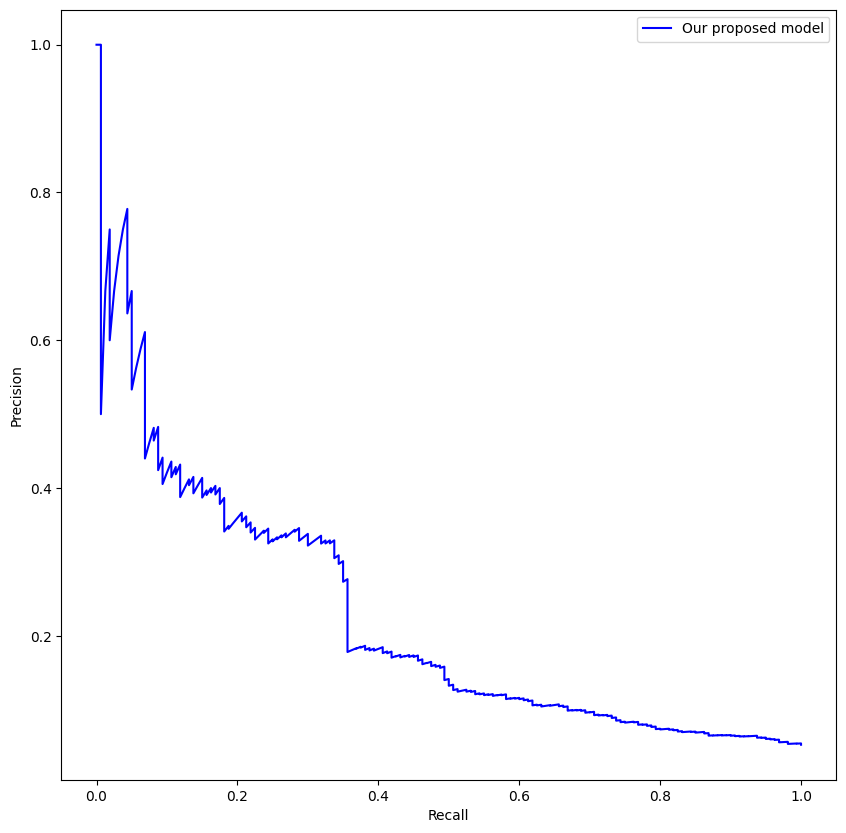

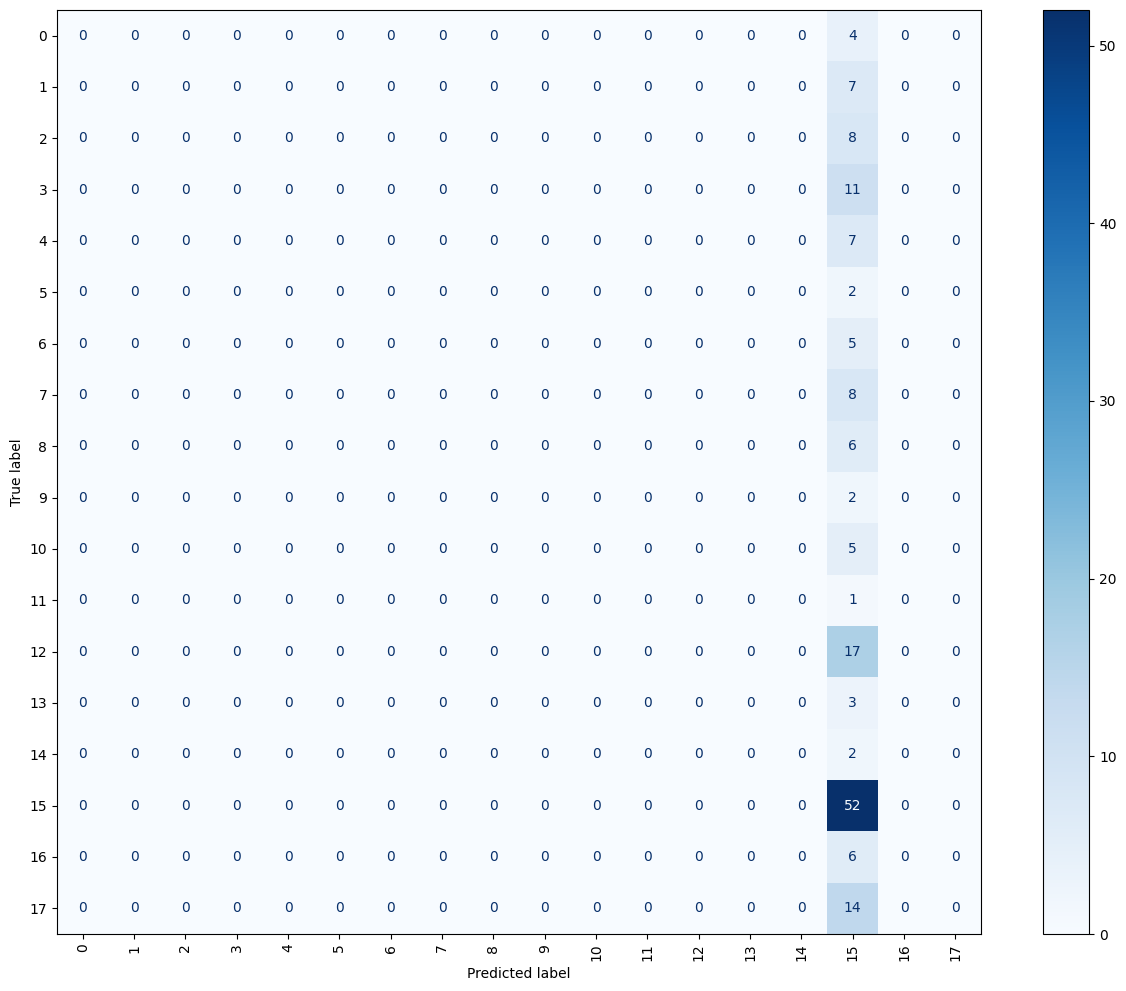

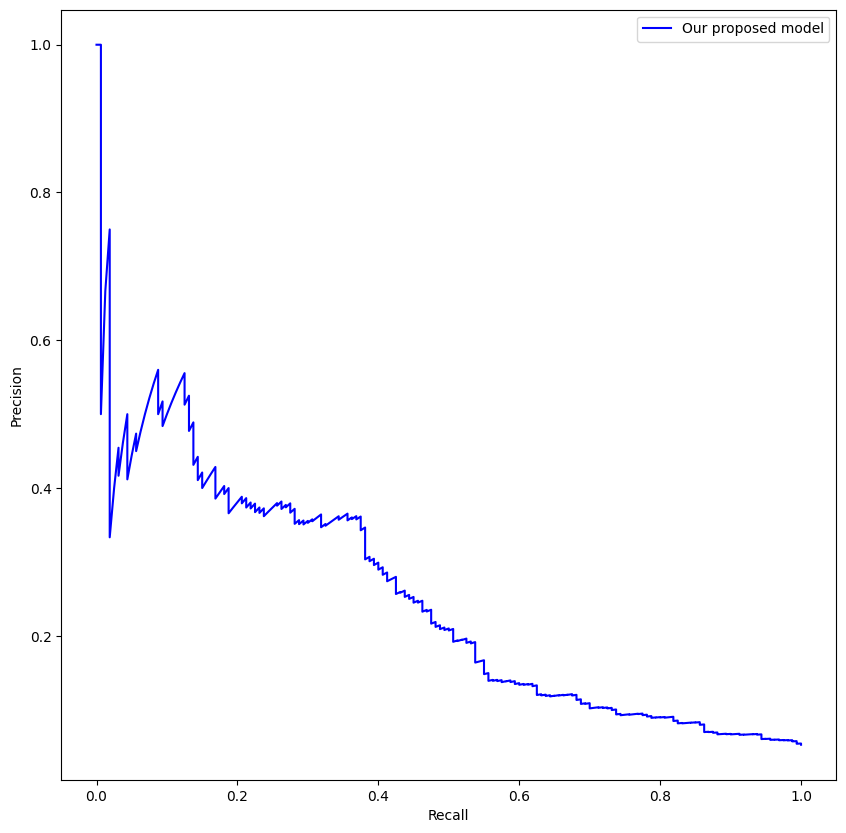

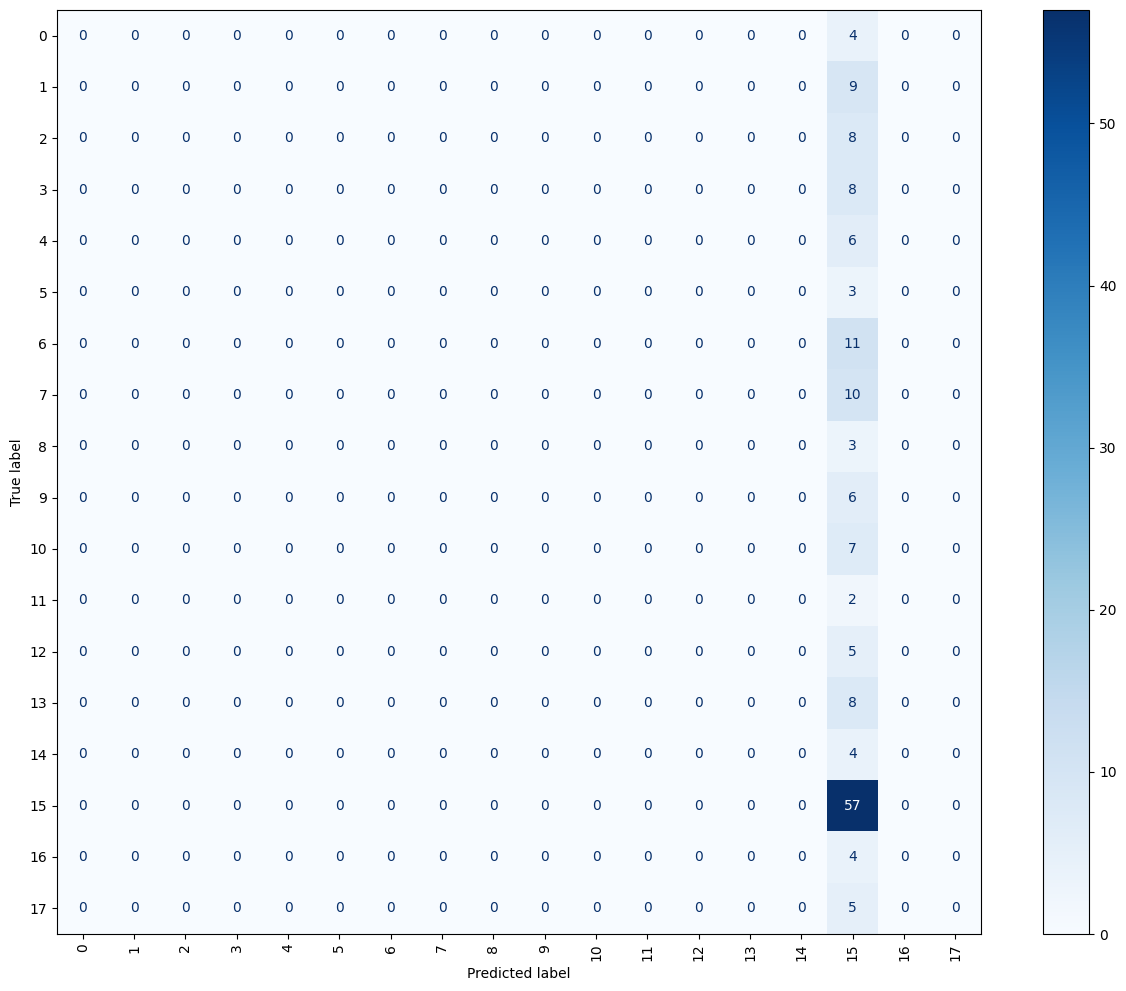

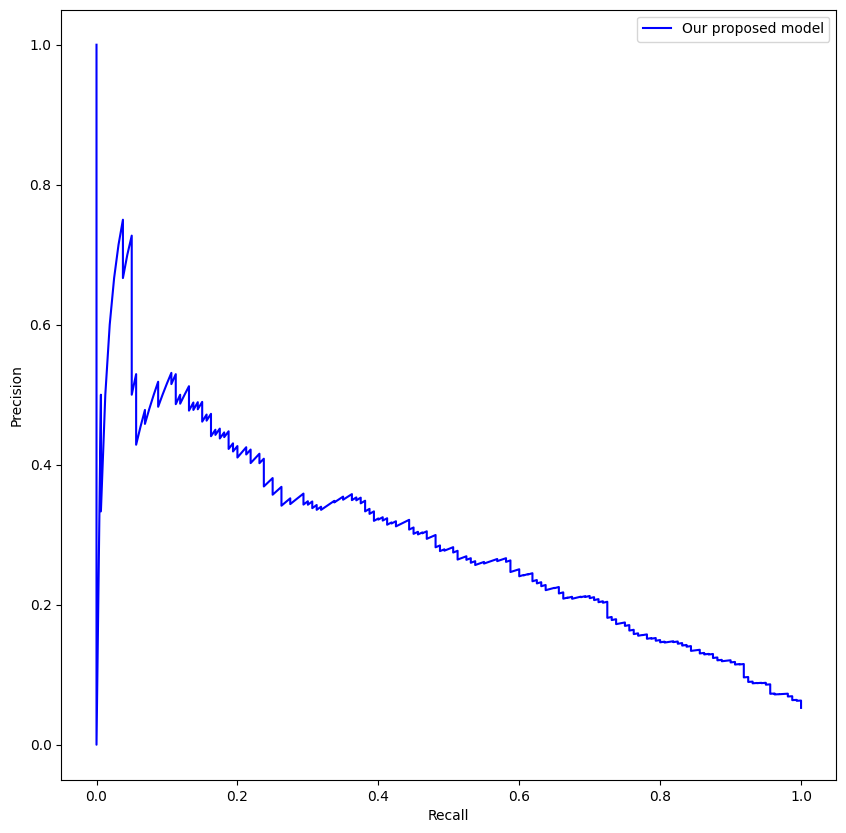

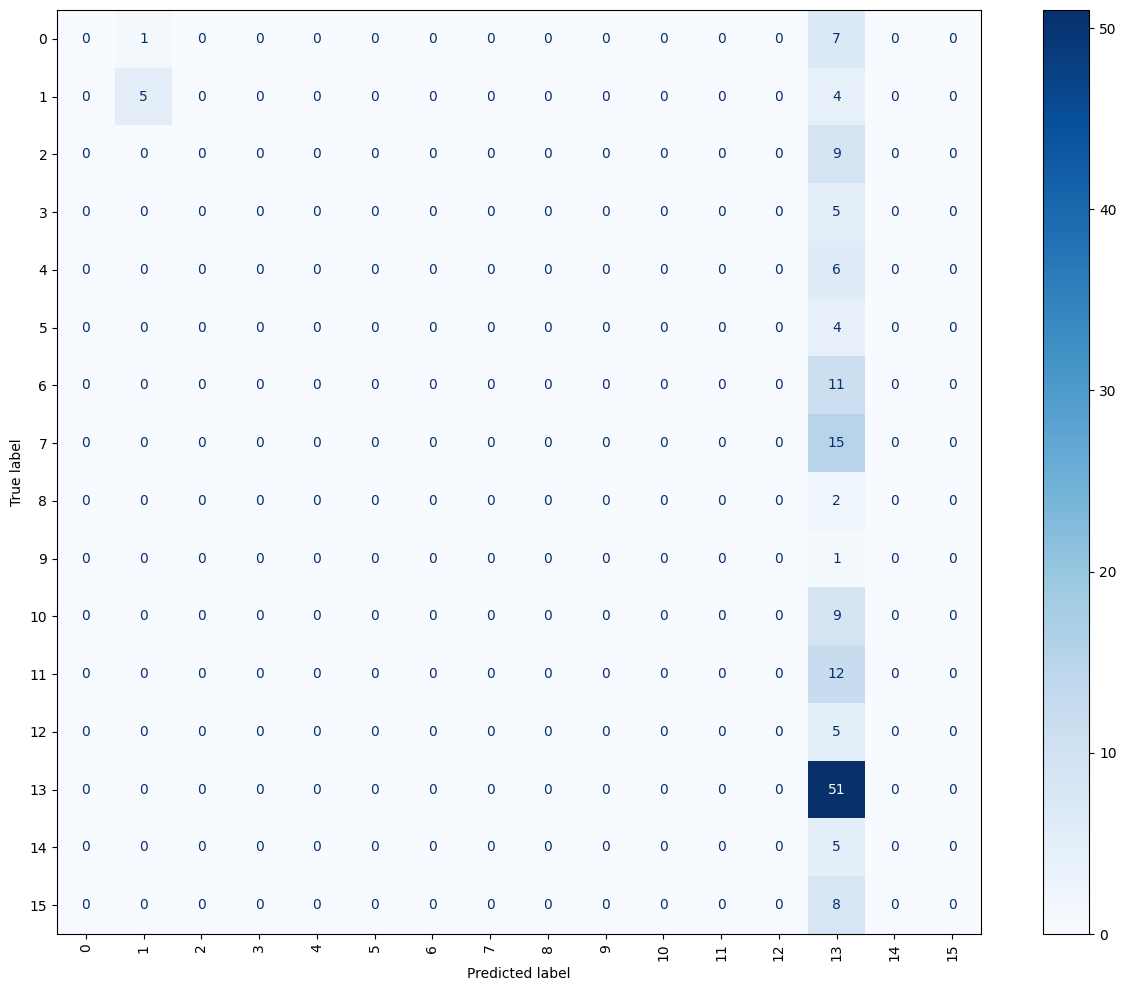

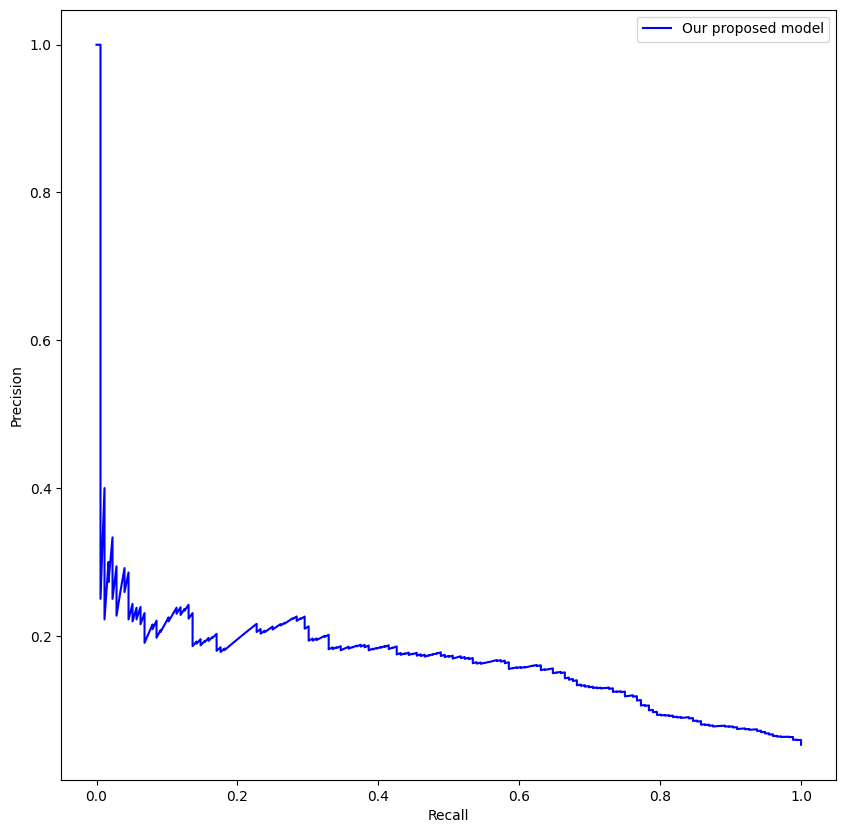

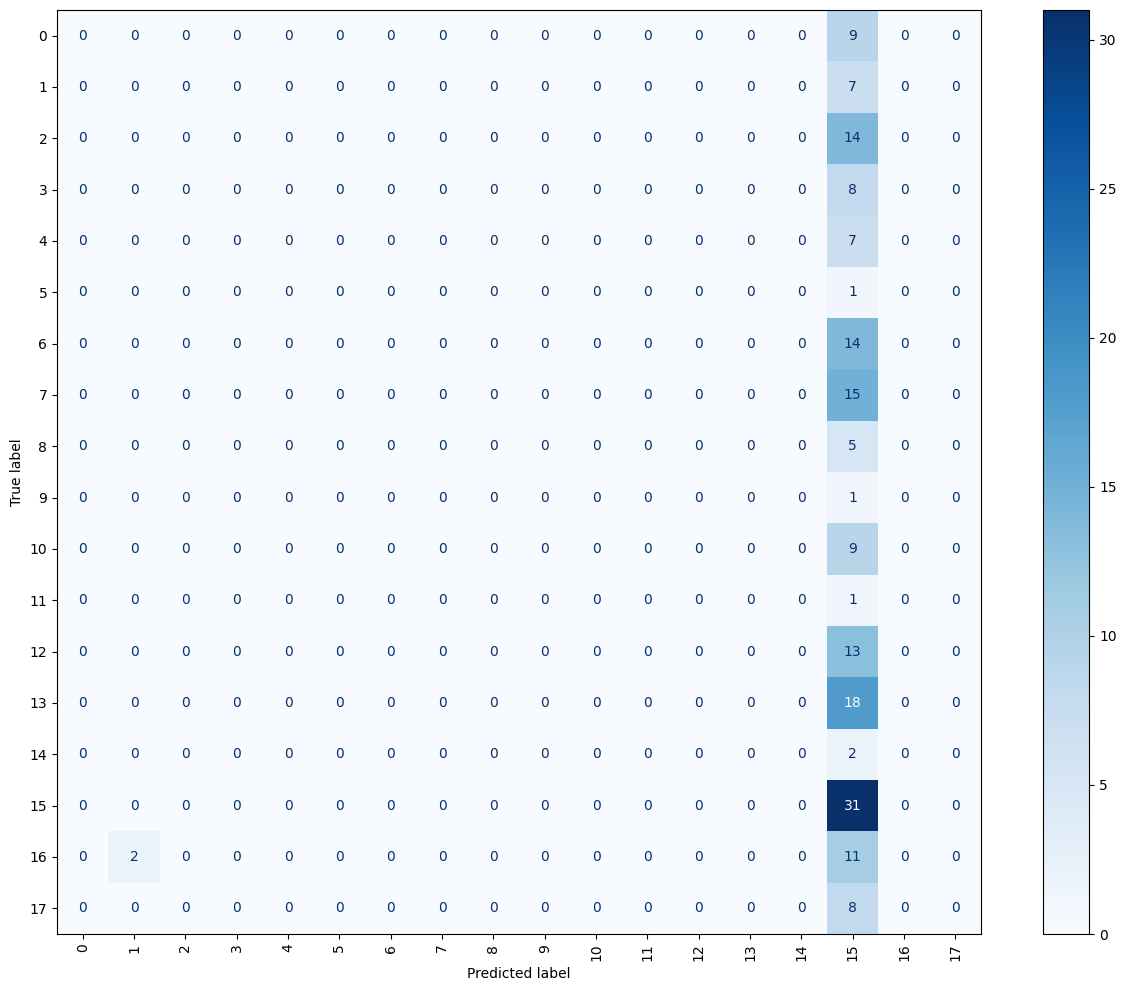

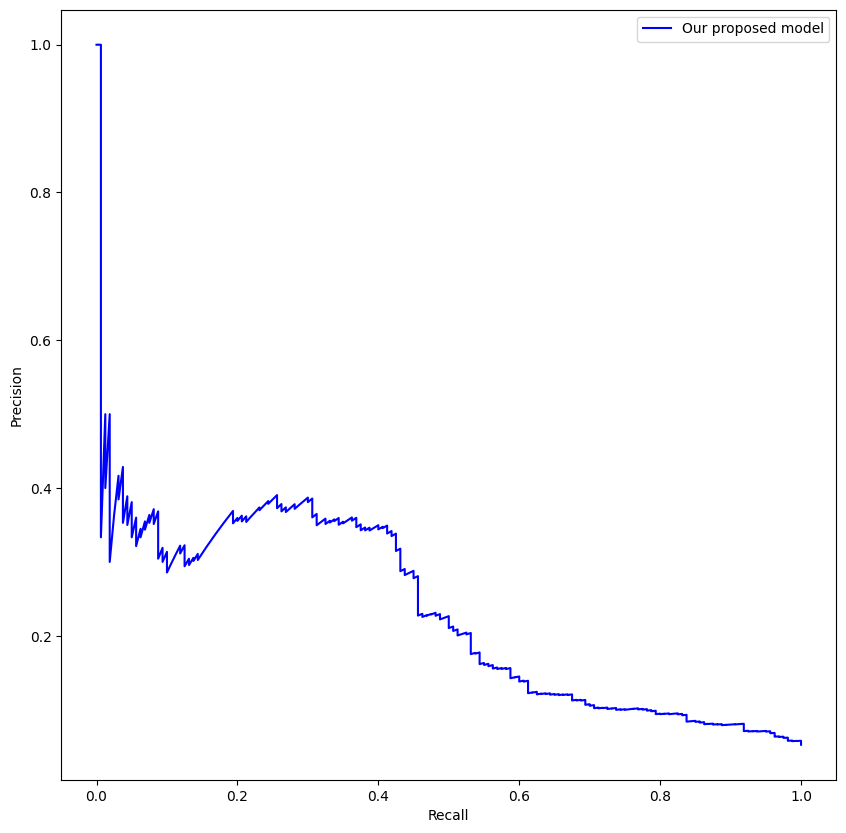

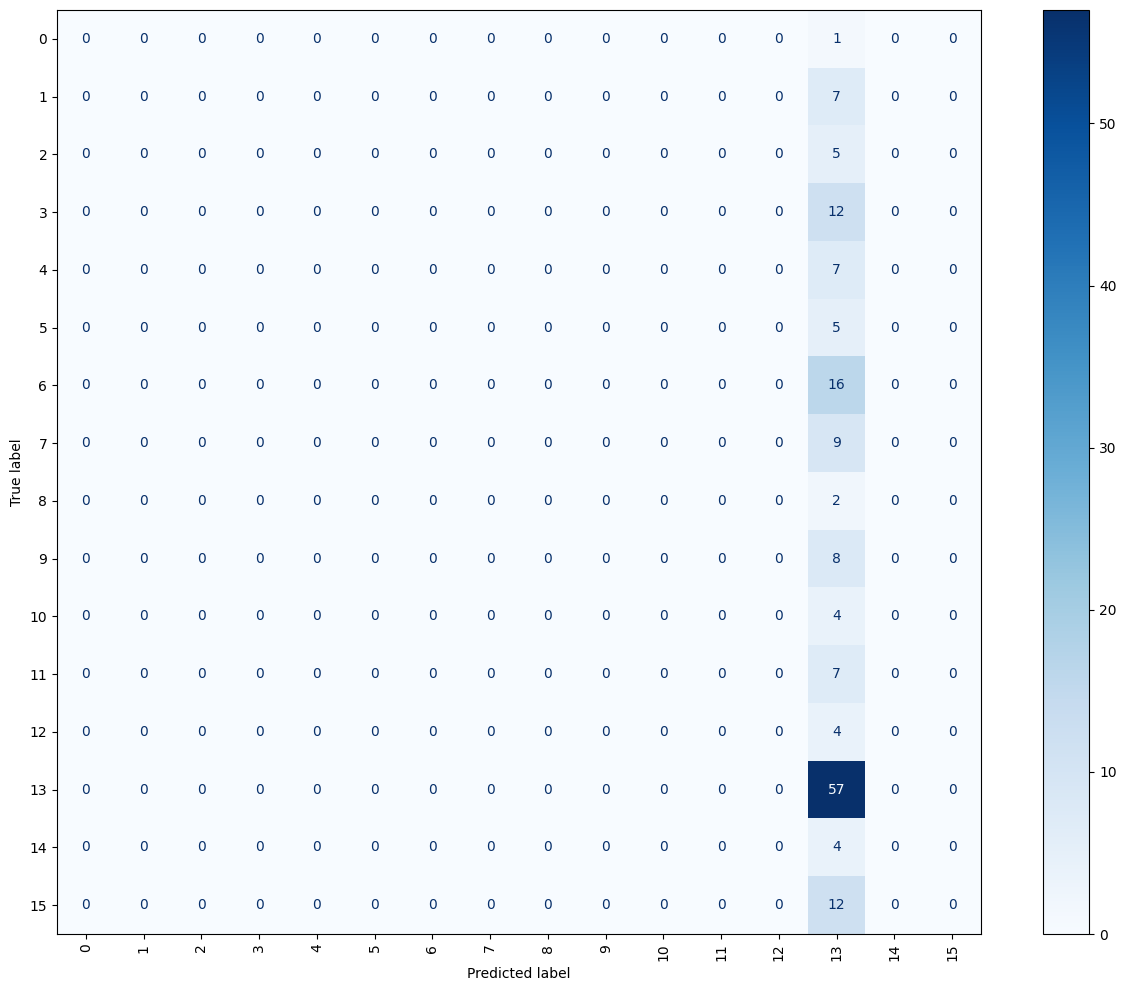

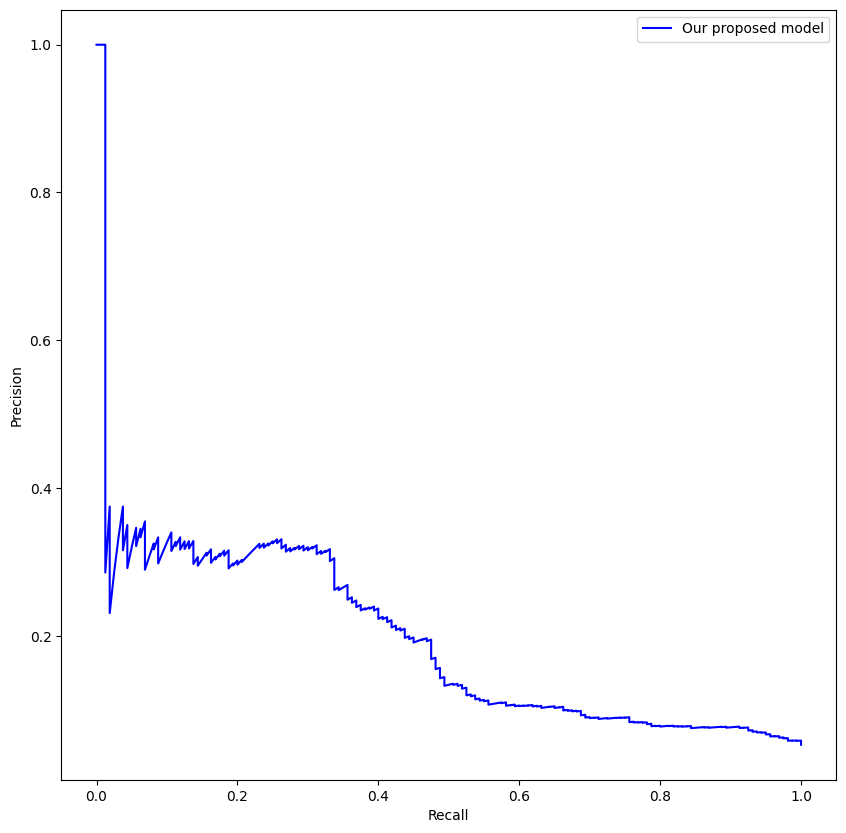

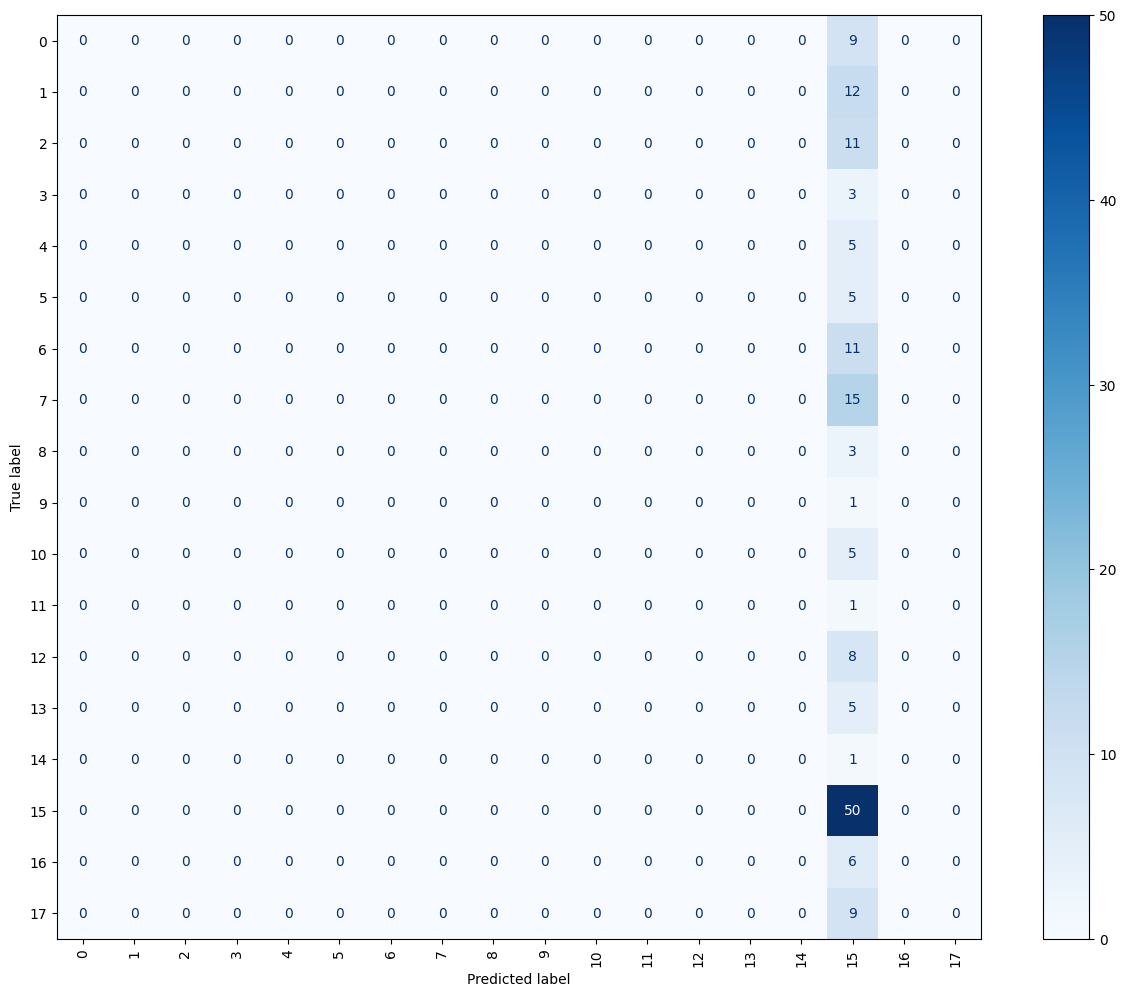

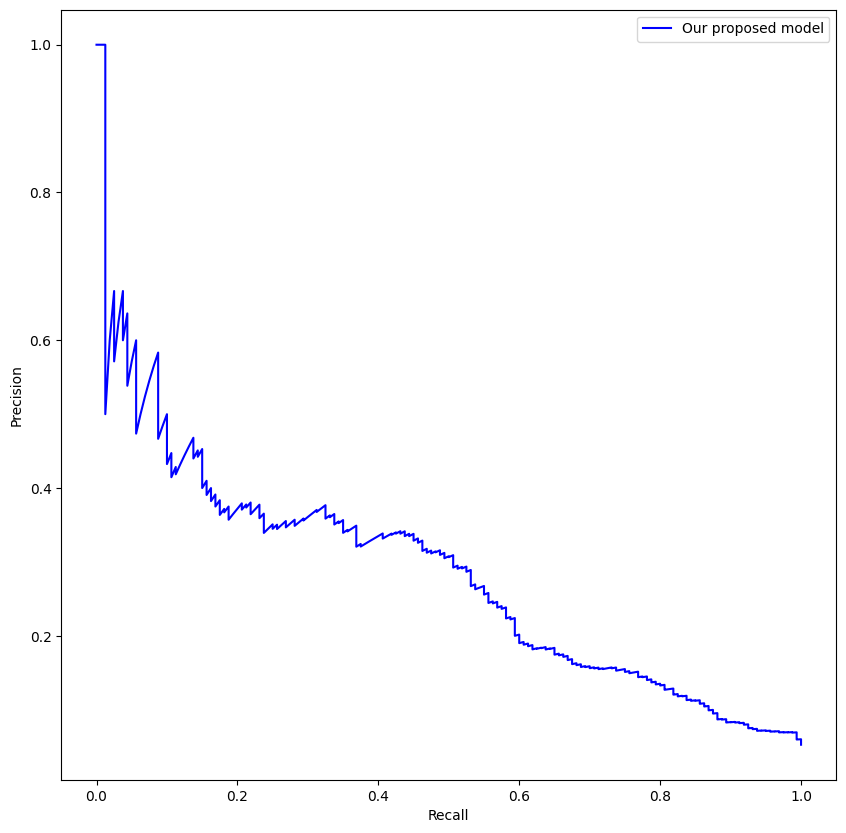

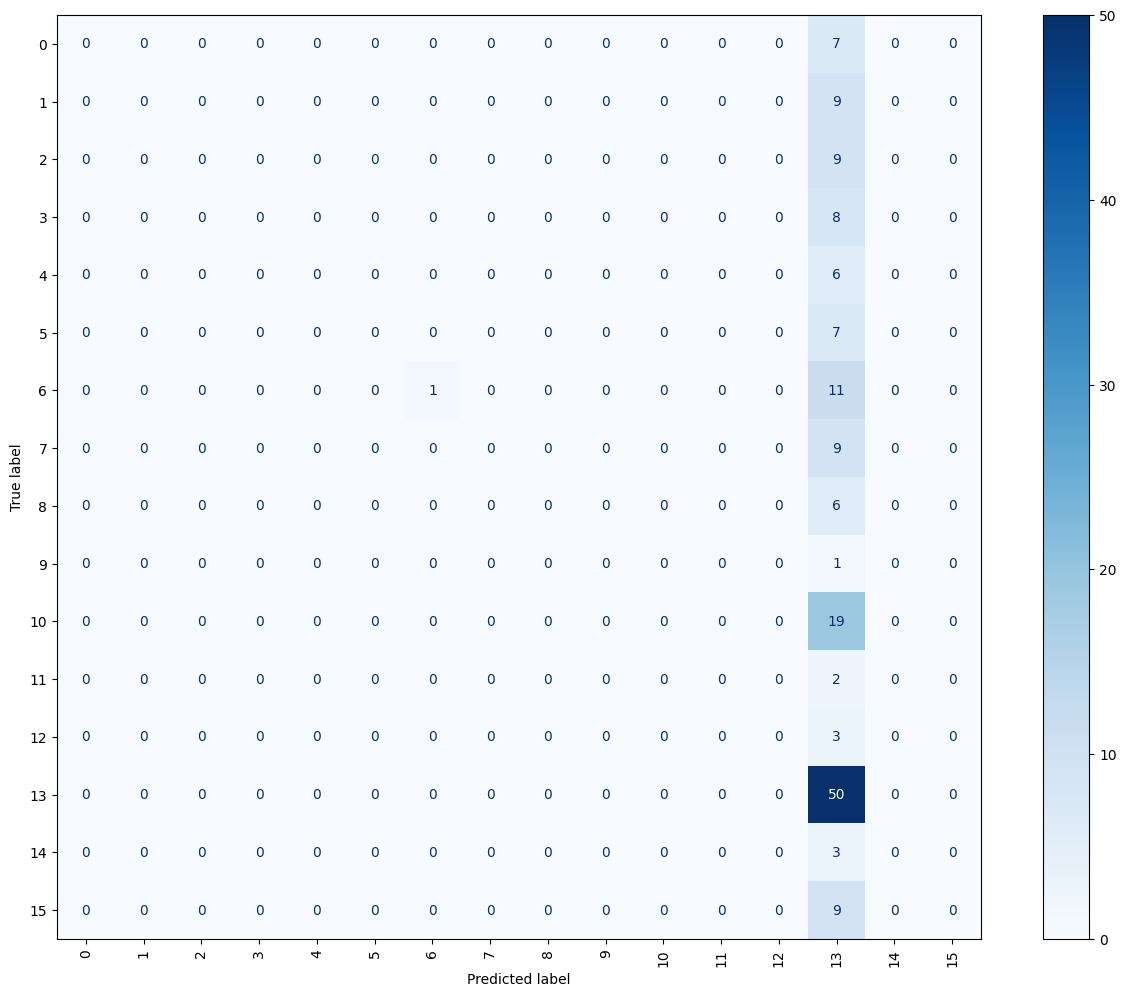

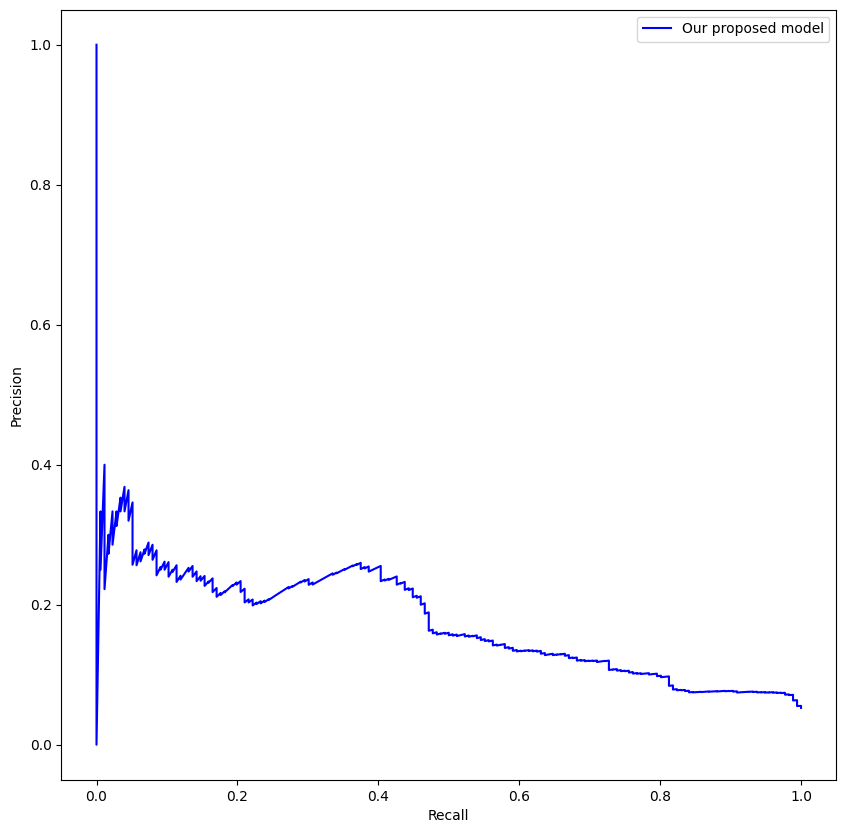

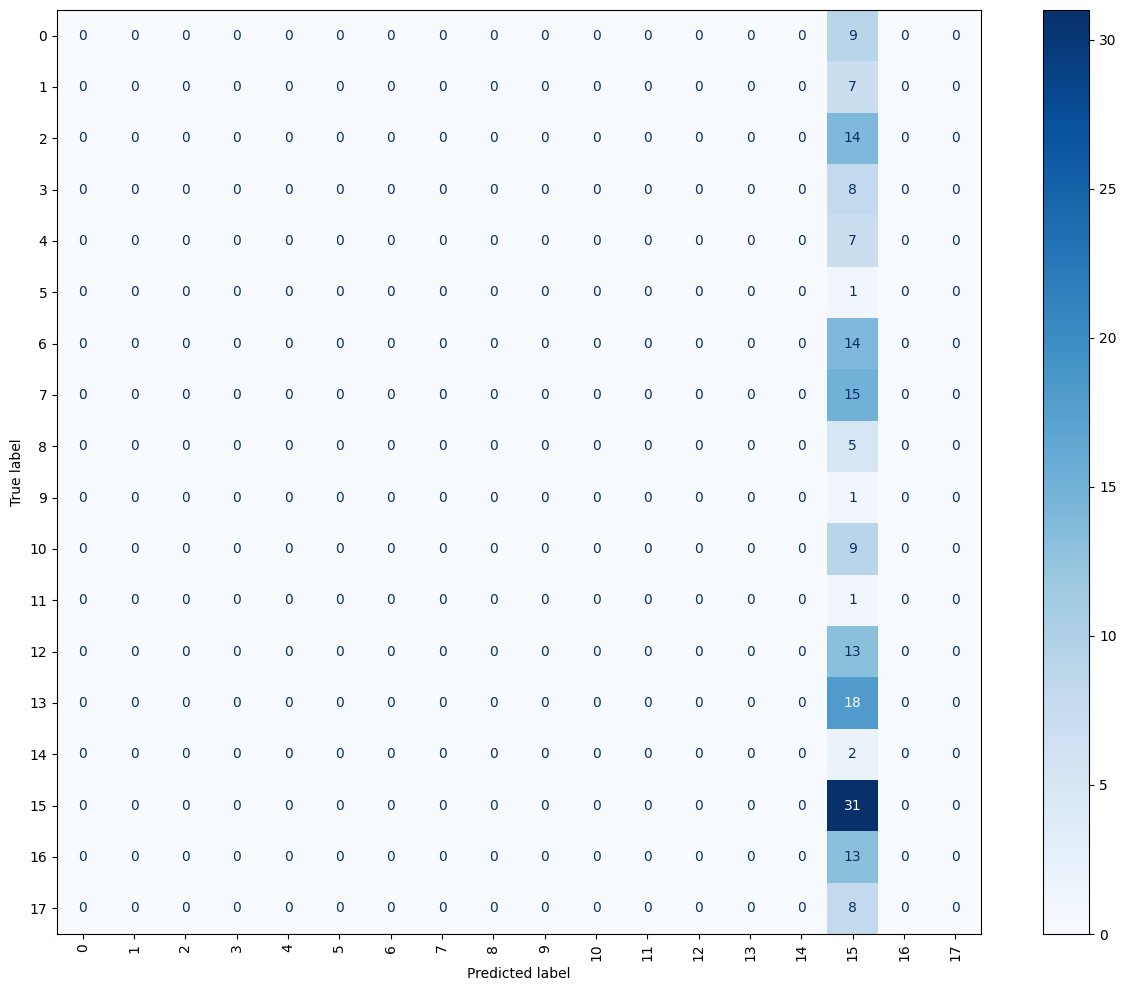

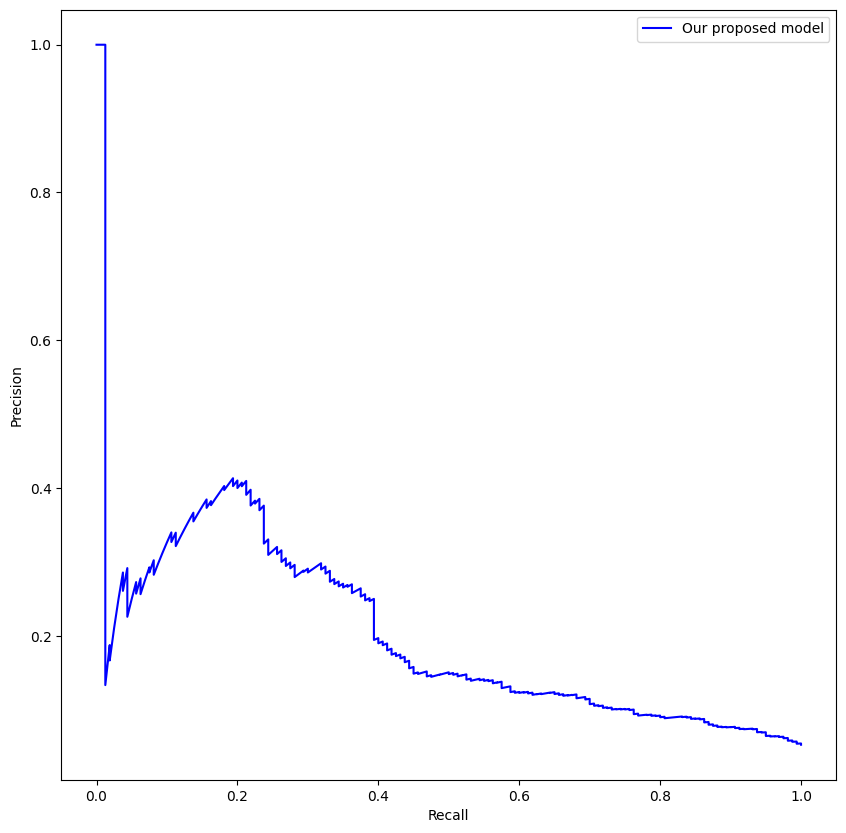

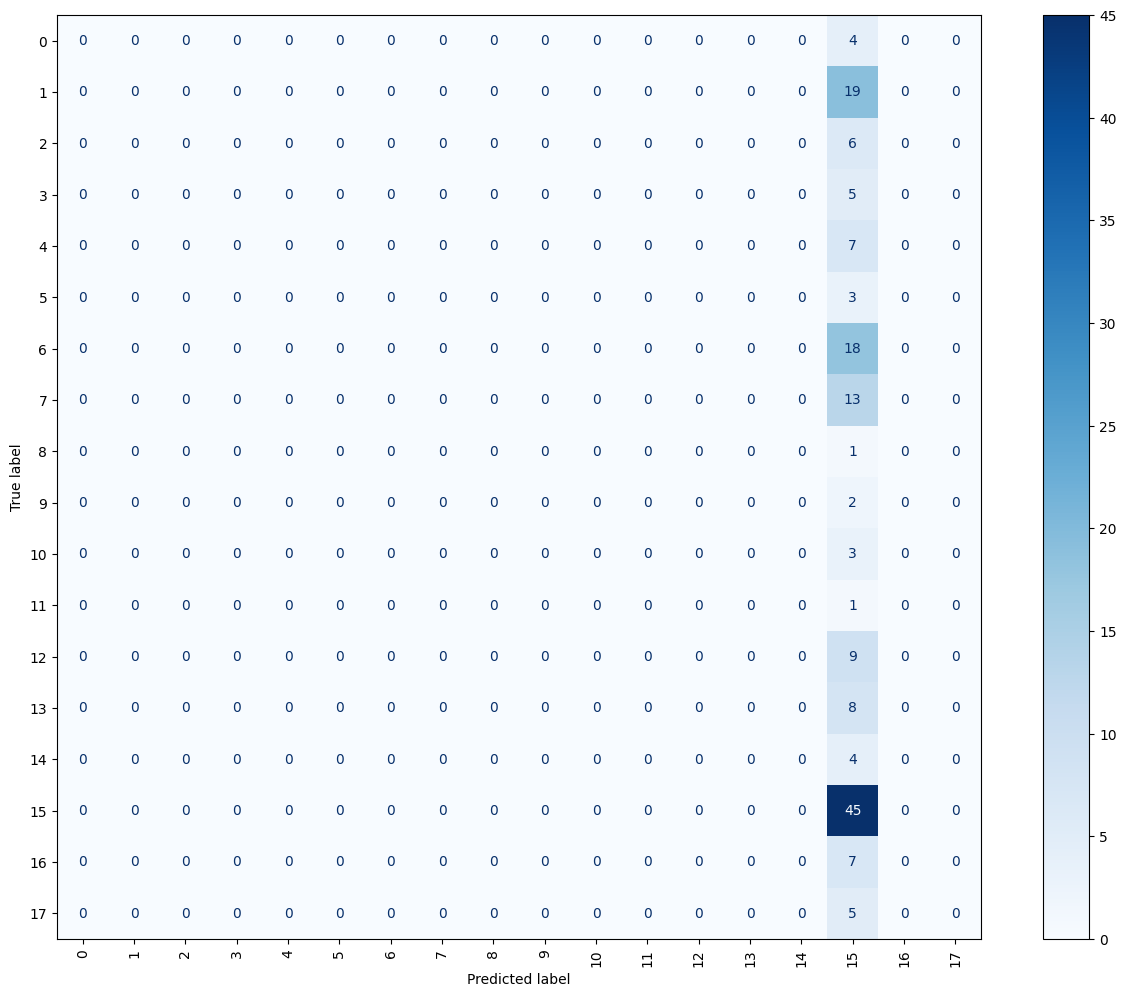

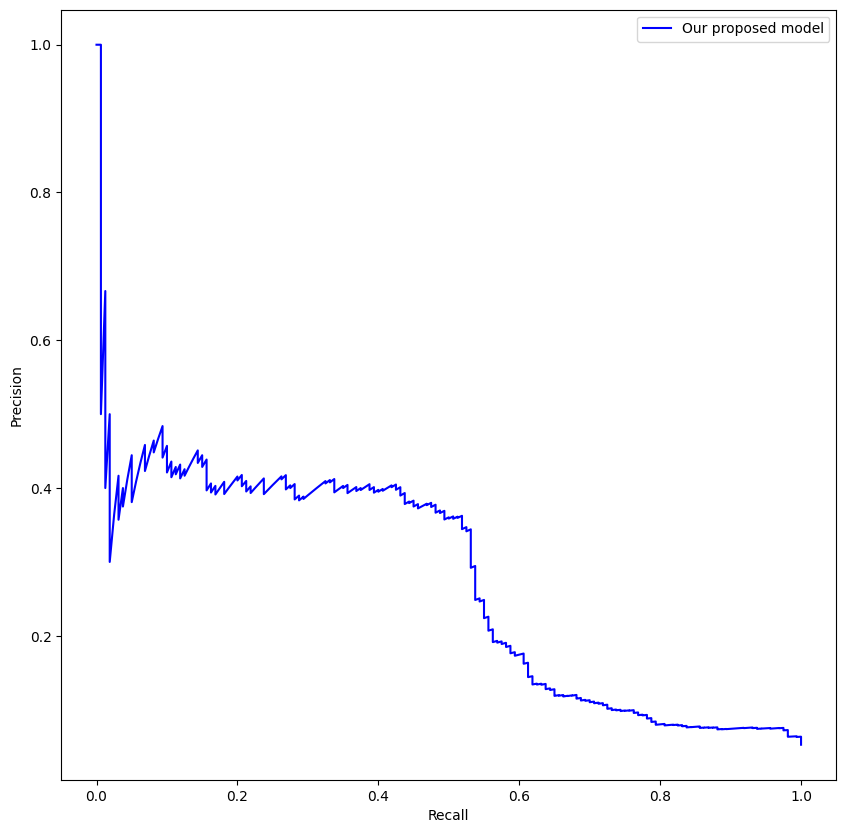

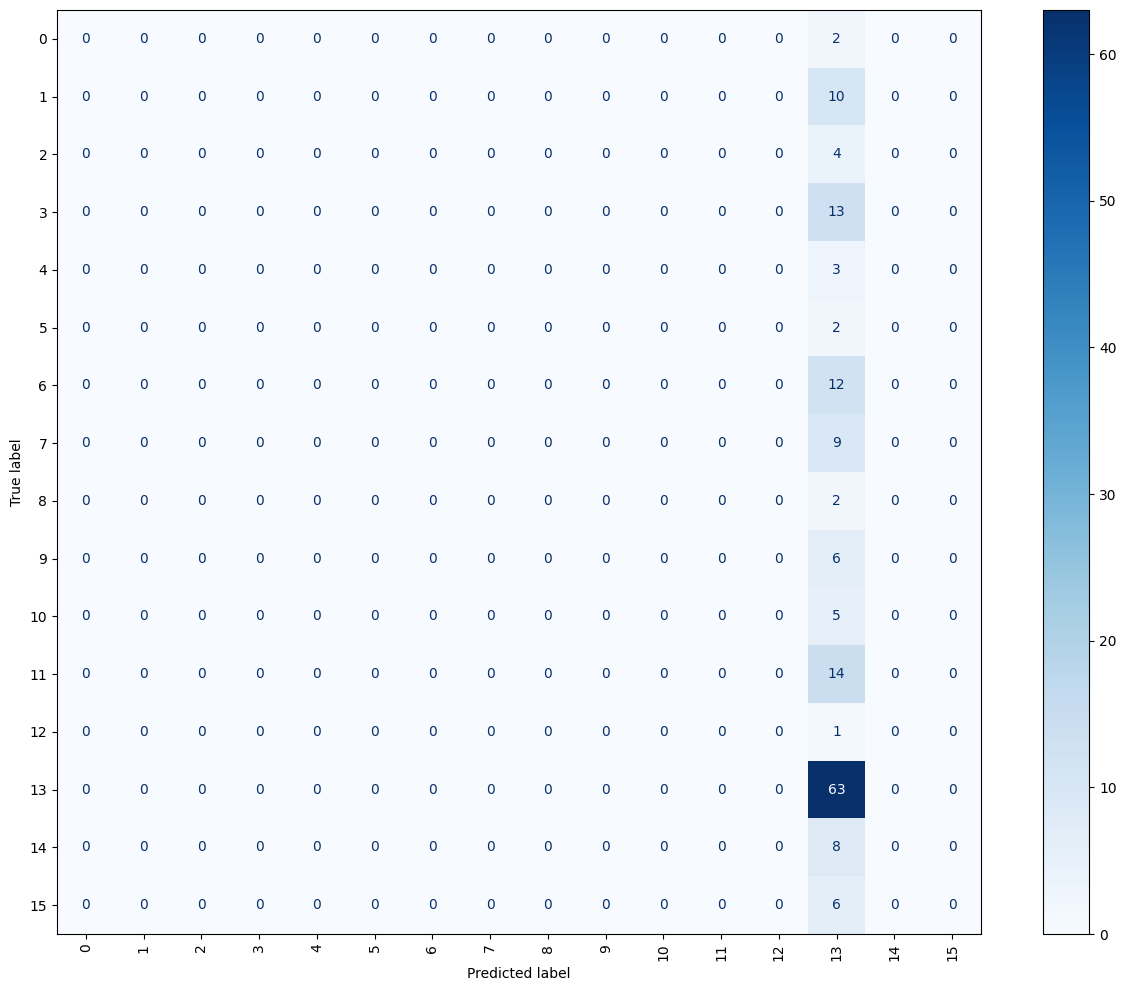

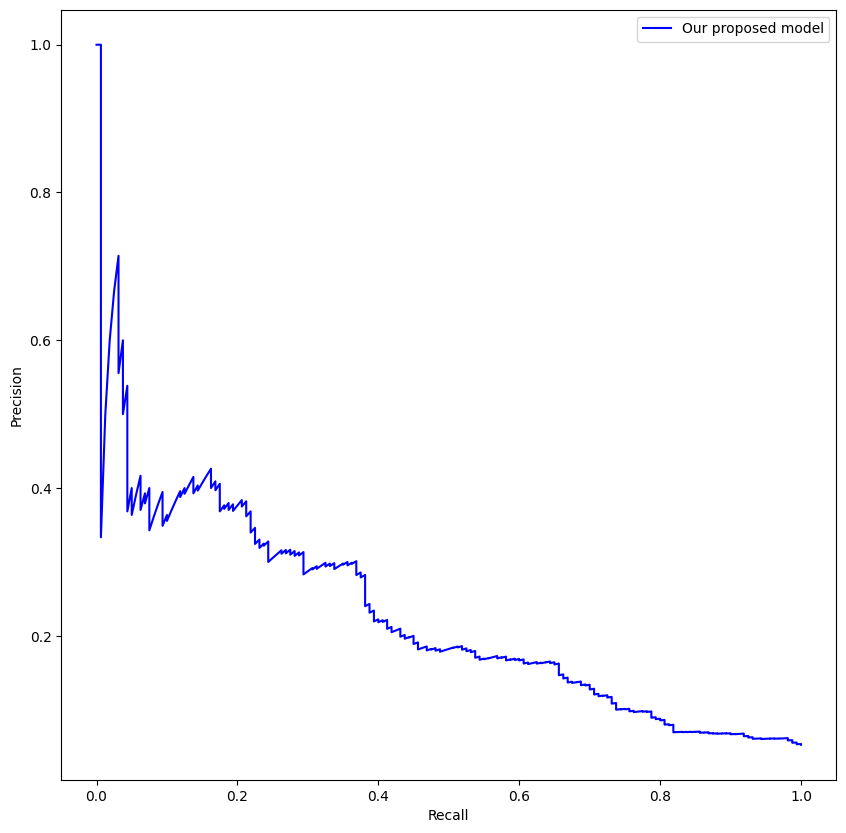

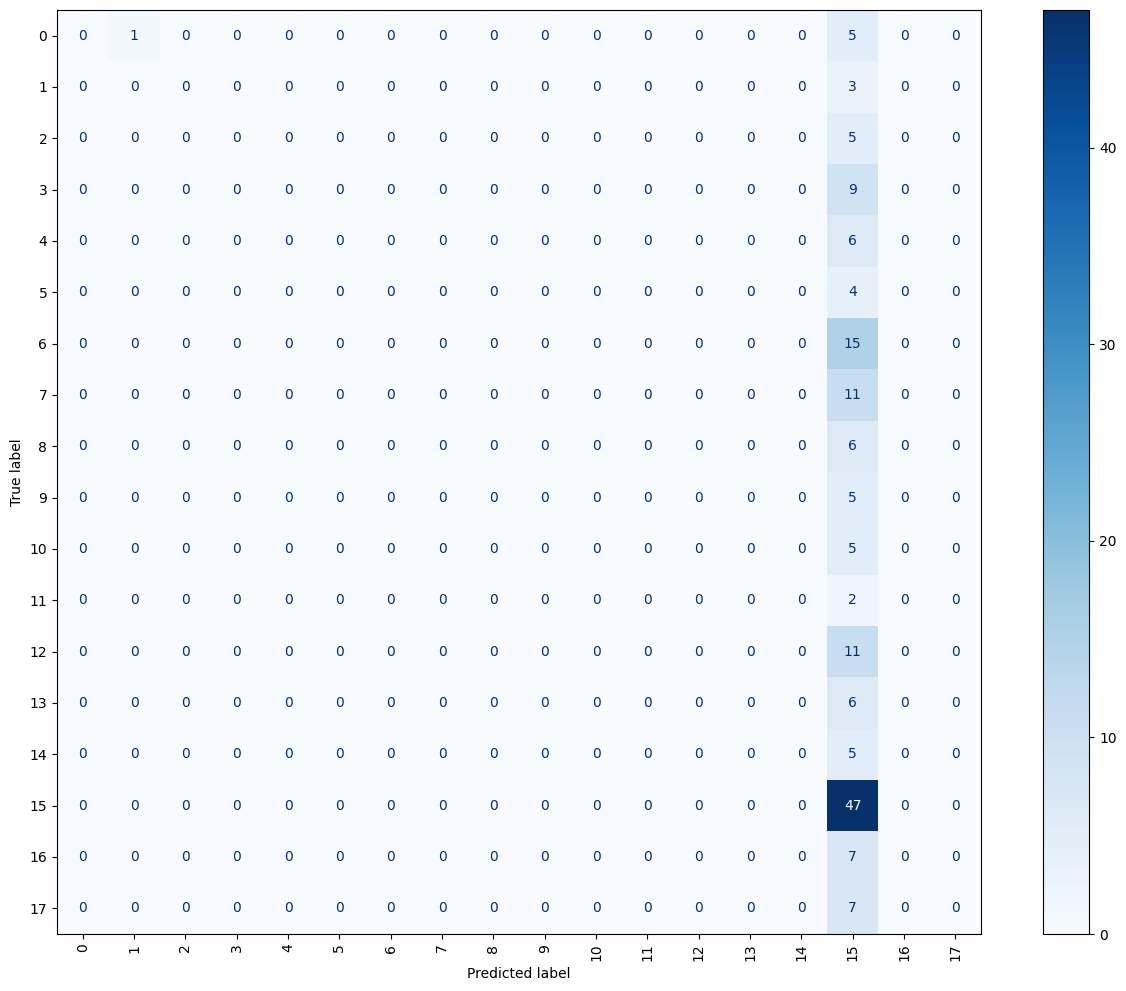

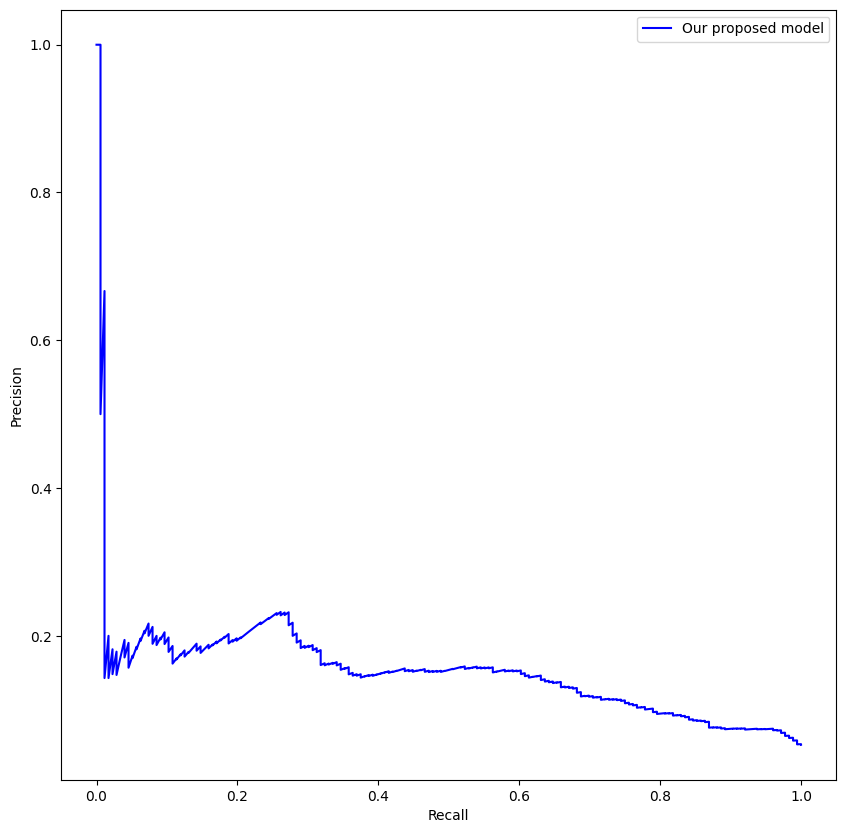

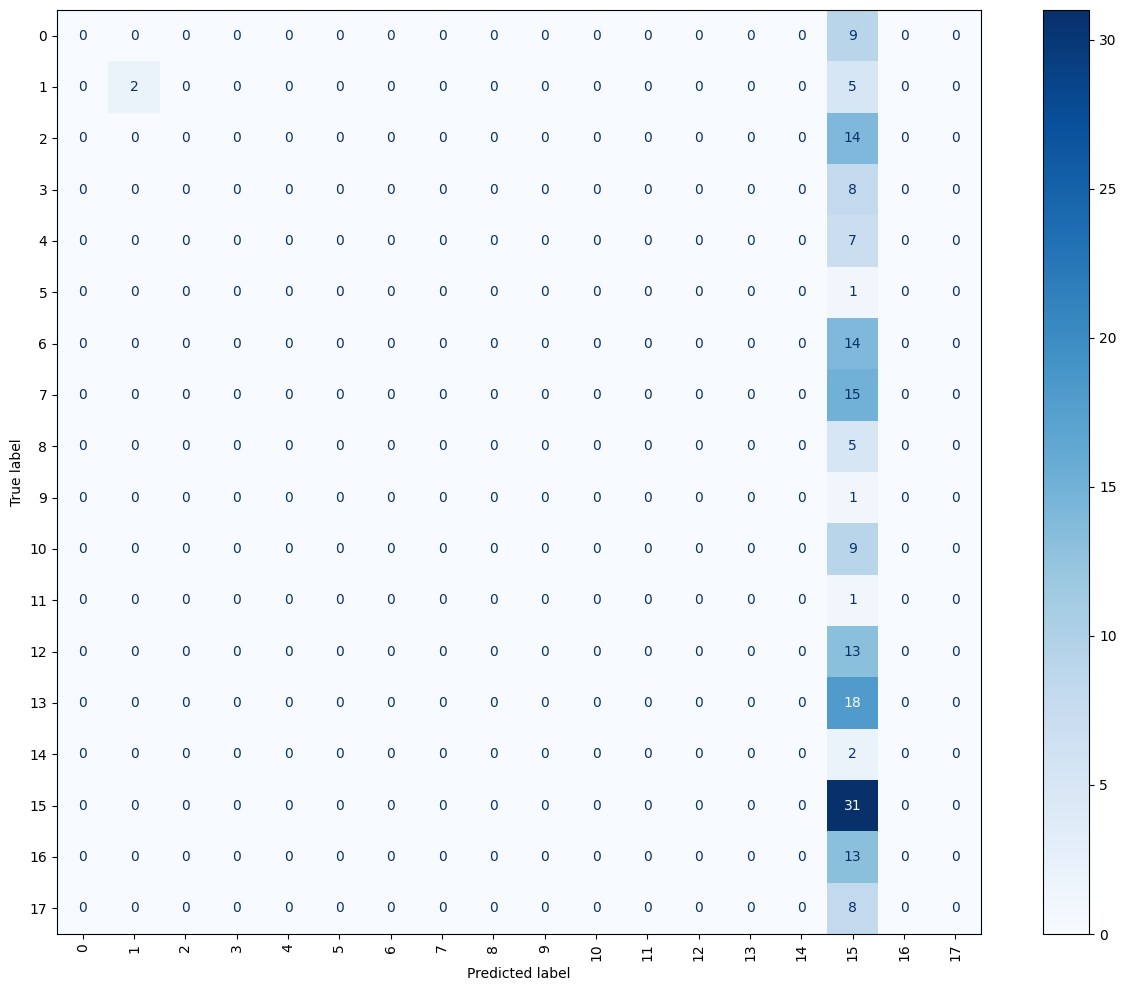

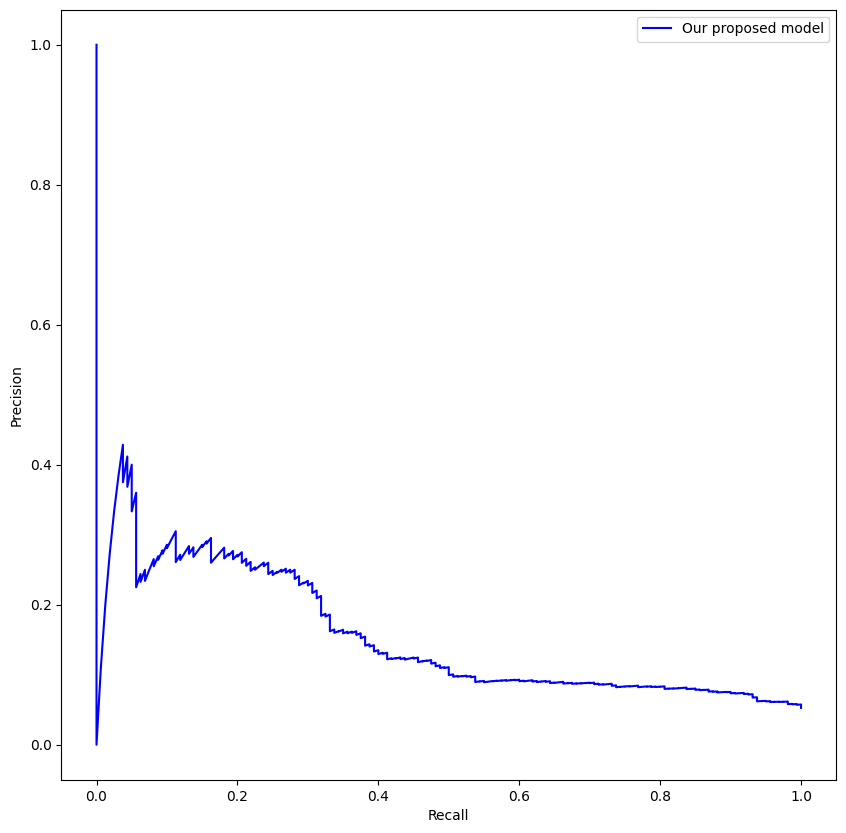

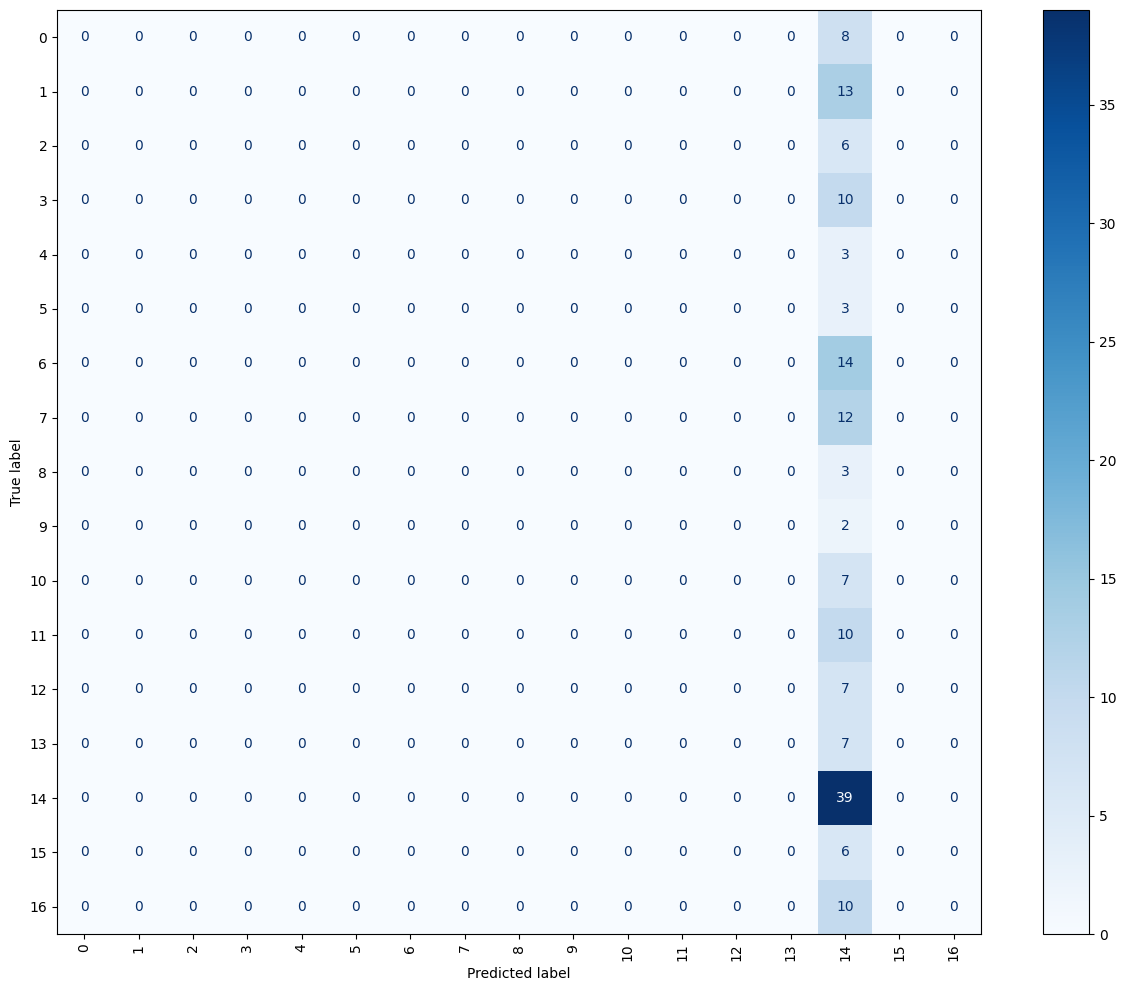

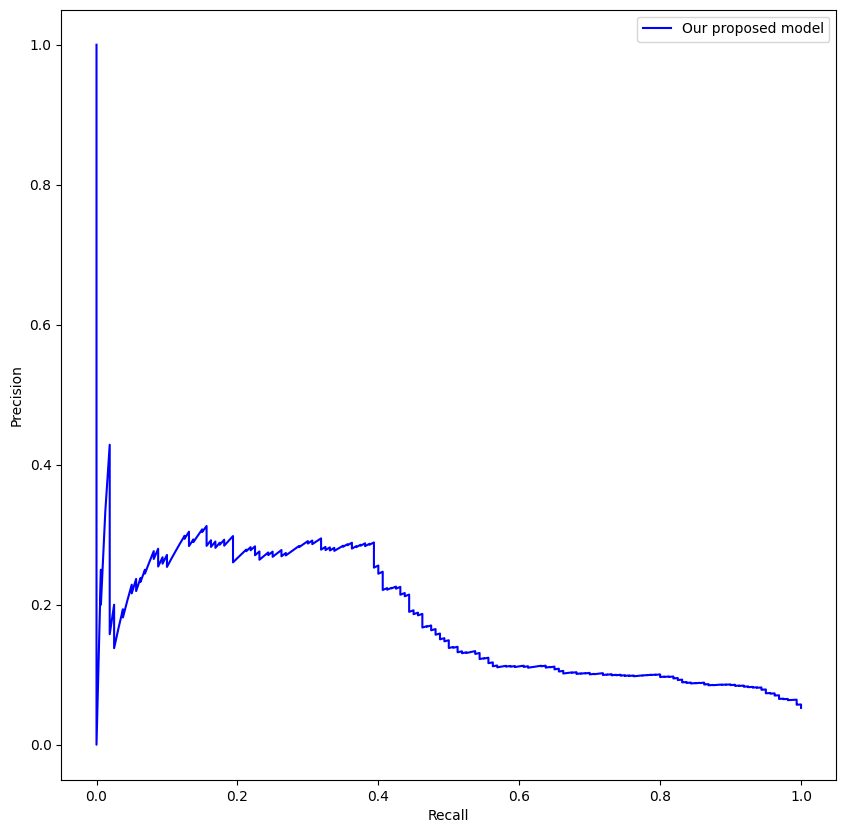

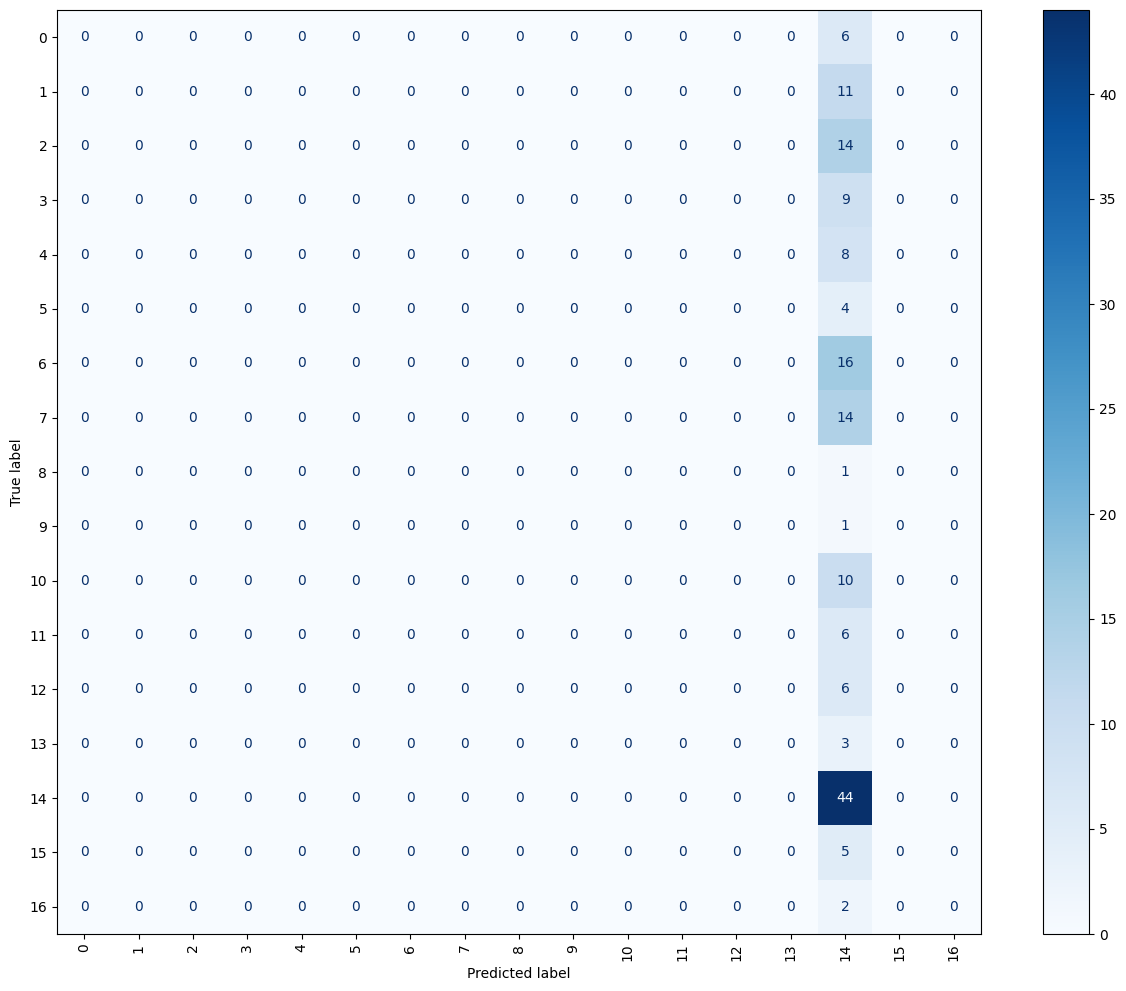

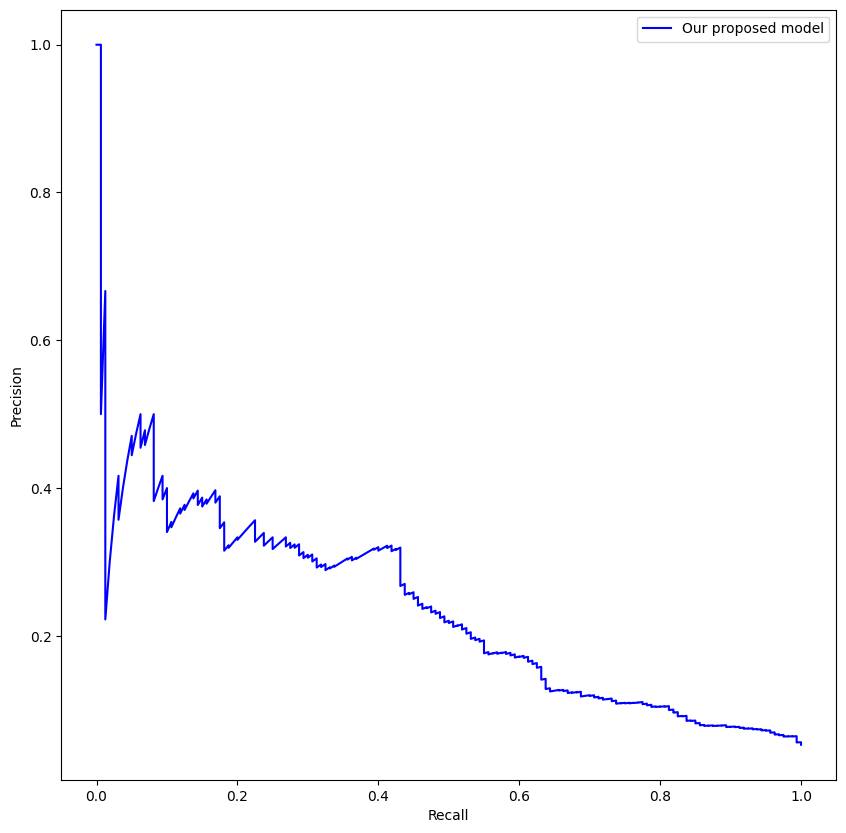

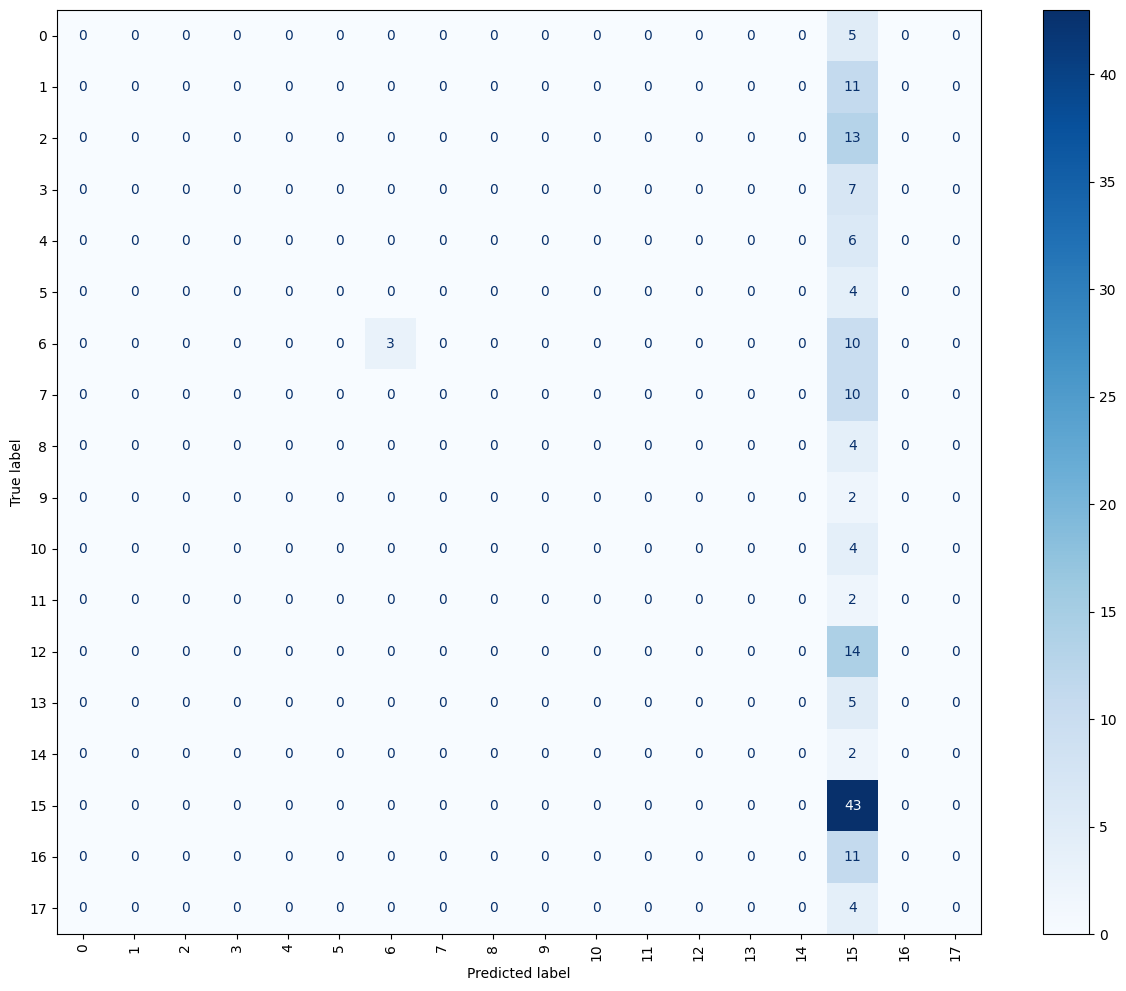

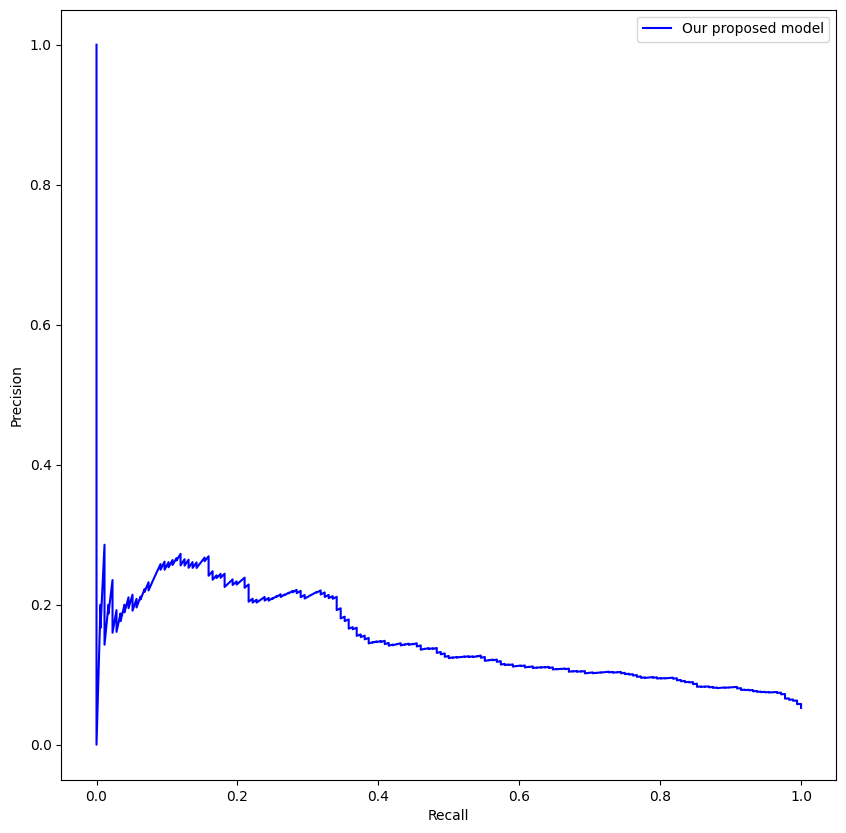

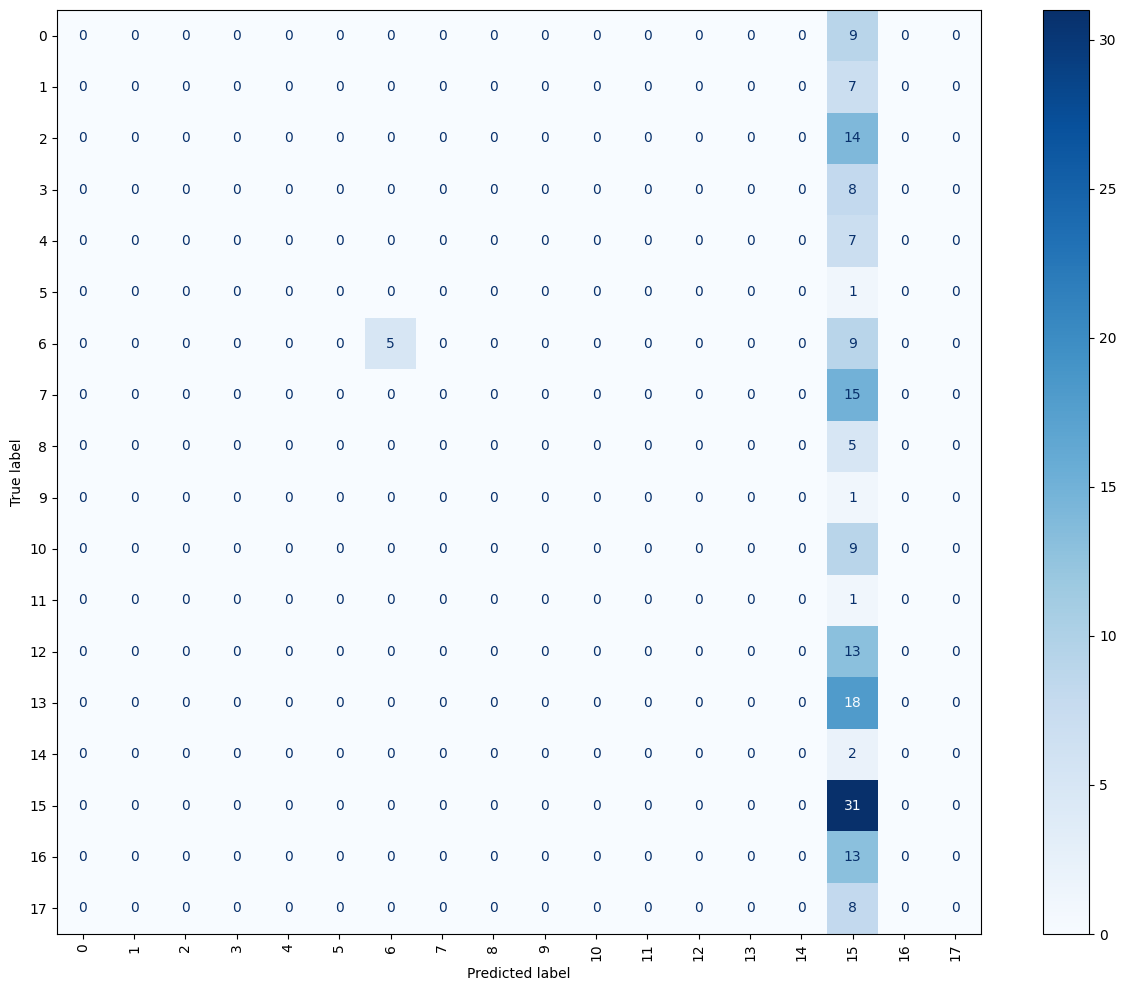

In [17]:
import sys
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning import Trainer as LightningTrainer, LightningModule
from pytorch_lightning.loggers import NeptuneLogger

logger = NeptuneLogger(
    api_key= "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0YmEyZTg2ZC0zNDMxLTQ2MzItOWEzYS0xOWY5ZGNiYTA5YWYifQ==",
    project="Violetta/BERT"
)

try:
    for i in range(4):
        print(f"--------- EXPERIMENT {i} ---------")

        # 释放显存，防止 OOM
        classifier = trainer = None
        gc.collect()
        torch.cuda.empty_cache()

        # 创建 Trainer
        trainer = LightningTrainer(
            accelerator="gpu",
            devices=[0],
            max_epochs=3,
            default_root_dir=CHECKPOINT_DIR,
            deterministic=False,
            enable_checkpointing=True,
            logger=logger,
            check_val_every_n_epoch=1,
            log_every_n_steps=1,  # 确保 step 递增，防止 Neptune step 乱序
            num_sanity_val_steps=0, # 禁用 Sanity Check 直接进入训练
        )

        # 直接调用 StandardClassifier
        classifier = StandardClassifier(
            # pretrained_language_model="bert-base-uncased",
            pretrained_language_model=PRETRAINED_MODEL,
            dataset_name=DATASET_NAME,
            batch_size=BATCH_SIZE,
            learning_rate=LEARNING_RATE,
            decay_lr_speed=LEARNING_RATE_DECAY_SPEED,
            dropout_p=DROPOUT_P,
            activation_function=ACTIVATION_FUNCTION,
            weight_decay=WEIGHT_DECAY,
            linear_size=LINEAR_SIZE,
        )

        # 训练 & 测试
        print("🚀 开始训练")
        trainer.fit(classifier)
        print("✅ 训练完成")
        trainer.test(classifier)
        
        scorer = get_official_scorer(i, logger)
        if scorer:
            scorer.score({
                "standard": classifier.test_proposed_answer,
            })
        else:
            print("No official scorer found")

except Exception as e:
    # logger.experiment.stop()
    raise e

# else:
#     logger.experiment.stop()

sys.stdout.flush()

# Training binary classifier

In [18]:
GPUS = 1

BIN_MIN_EPOCHS = BIN_MAX_EPOCHS = 2

BIN_BATCH_SIZE = 32
BIN_LEARNING_RATE = 2e-05
BIN_LEARNING_RATE_DECAY_SPEED = [1, 1, 0.75, 0.5, 0.5, 0.25, 0.25, 0.1, 0.075, 0.05, 0.025, 0.01]

BIN_LINEAR_SIZE = 256

BIN_DROPOUT_P = 0.2
BIN_ACTIVATION_FUNCTION = "PReLU"
BIN_WEIGHT_DECAY = 0.01 # default = 0.01

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


--------- EXPERIMENT 0 ---------


E:\Python\Python3.11.5\Lib\site-packages\neptune\internal\utils\git.py:71: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/Violetta/BERT/e/BERTRE-68


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type      | Params | Mode 
----------------------------------------------------------
0 | language_model      | BertModel | 109 M  | eval 
1 | linear              | Linear    | 196 K  | train
2 | linear_output       | Linear    | 257    | train
3 | dropout             | Dropout   | 0      | train
4 | activation_function | PReLU     | 1      | train
----------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
438.717   Total estimated model params size (MB)
4         Modules in train mode
228       Modules in eval mode
E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
E:\Python\Python3.11.5\Li

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([1.0136, 0.8072, 0.8462, 0.9617, 0.8960, 0.8223, 0.8954, 0.7964, 0.7814,
        0.8866, 0.9050, 0.9090, 0.8314, 0.9301, 0.8175, 0.8622, 0.8132, 0.8229,
        0.9393, 0.7620, 0.9822, 0.7837, 0.7864, 0.8328, 0.8713, 0.7624, 0.8284,
        0.7577, 0.9857, 0.9160, 0.9780, 0.9091], device='cuda:0'), 'label': tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')}, {'logits': tensor([0.6652, 0.6905, 0.6572, 0.8020, 0.7779, 0.6306, 0.6765, 0.8122, 0.7656,
        0.7454, 0.6606, 0.7466, 0.7583, 0.7082, 0.6539, 0.7244, 0.7507, 0.7445,
        0.6916, 0.7779, 0.7457, 0.8596, 0.6552, 0.7489, 0.7127, 0.7089, 0.8253,
        0.7055, 0.8735, 0.8042, 0.7511, 0.6970], device='cuda:0'), 'label': tensor([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
        0, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')}, {'logits': tensor([0.6694, 0.7156, 0

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyp

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 6.0


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([0.8470, 1.0149, 0.8721, 0.9745, 0.9521, 0.9189, 0.8402, 0.9604, 0.8639,
        0.9139, 0.9210, 0.7693, 0.8936, 0.8909, 0.8808, 0.8829, 0.7997, 0.7523,
        0.8865, 0.7664, 0.9977, 0.8239, 1.0310, 0.9414, 0.9177, 0.9486, 0.7551,
        0.6951, 0.9027, 0.9111, 0.8931, 0.7138], device='cuda:0'), 'label': tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')}, {'logits': tensor([0.7094, 0.8615, 0.9178, 0.9638, 0.9262, 0.9219, 0.9122, 0.7292, 0.7388,
        0.8436, 0.8090, 0.8470, 1.0499, 0.8905, 1.0113, 0.7391, 0.9480, 0.9168,
        0.7937, 0.8794, 0.9299, 0.8630, 0.9111, 0.8554, 0.6227, 0.7695, 0.8446,
        0.8313, 0.9416, 0.7774, 0.6886, 0.9025], device='cuda:0'), 'label': tensor([0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')}, {'logits': tensor([0.9432, 0.9637, 0

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyp

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([0.7735, 0.8965, 0.9415, 0.9760, 0.8764, 0.7214, 0.8476, 0.9116, 0.8555,
        1.1112, 0.9241, 0.9812, 0.6319, 0.9430, 0.9812, 0.5738, 0.9190, 0.7522,
        0.8469, 0.8771, 0.9528, 0.9005, 0.8140, 0.9392, 0.8180, 0.5844, 0.8024,
        0.7555, 1.0497, 0.9459, 0.9214, 0.6514], device='cuda:0'), 'label': tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')}, {'logits': tensor([0.9797, 0.7156, 0.8285, 0.8007, 0.7079, 0.7889, 0.7648, 0.9026, 0.7914,
        0.8477, 0.8103, 0.8821, 0.7498, 0.8518, 0.6592, 0.7340, 0.7018, 0.8613,
        0.9356, 0.7354, 0.8602, 0.7610, 0.8372, 0.6850, 0.8518, 0.8578, 0.8152,
        0.6816, 0.7194, 0.7797, 0.5932, 0.9070], device='cuda:0'), 'label': tensor([1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')}, {'logits': tensor([0.6103, 0.8245, 1

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:229: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memor

Testing: |          | 0/? [00:00<?, ?it/s]

[DEBUG] test_step_outputs before eval: [{'logits': tensor([0.6365, 0.6586, 0.7934, 0.7507, 0.7025, 0.7237, 0.8233, 0.6580, 0.8518,
        0.7306, 0.6449, 0.7973, 0.5371, 0.6574, 0.8225, 0.6695, 0.7601, 0.5638,
        0.7521, 0.7491, 0.7023, 0.8290, 0.7452, 0.7427, 0.7304, 0.7478, 0.6108,
        0.6588, 0.6949, 0.5937, 0.8071, 0.7278], device='cuda:0'), 'label': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')}, {'logits': tensor([0.7563, 0.6512, 0.7821, 0.6340, 0.6286, 0.6017, 0.7402, 0.6140, 0.5835,
        0.6619, 0.6402, 0.6375, 0.5957, 0.6207, 0.6033, 0.6499, 0.5426, 0.7878,
        0.7259, 0.6665, 0.7310, 0.6623, 0.6072, 0.6798, 0.6356, 0.7532, 0.6677,
        0.6466, 0.6355, 0.6496, 0.5404, 0.6703], device='cuda:0'), 'label': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')}, {'logits': tensor([0.6260, 0.8256, 0.6301,

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyp

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5332648754119873     │
│    test_test_avg_loss     │    0.5332648158073425     │
│  test_test_best_acc_acc   │    0.7916666865348816     │
│   test_test_best_acc_f1   │    0.8823529481887817     │
│  test_test_best_acc_pre   │    0.8152173757553101     │
│  test_test_best_acc_rec   │    0.9615384340286255     │
│   test_test_best_f1_acc   │    0.7916666865348816     │
│   test_test_best_f1_f1    │    0.8823529481887817     │
│   test_test_best_f1_pre   │    0.8152173757553101     │
│   test_test_best_f1_rec   │    0.9615384340286255     │
│  test_test_best_roc_acc   │          0.21875          │
│   test_test_best_roc_f1   │    0.07407407462596893    │
│  test_test_best_roc_pre   │            1.0            │
│  test_test_best_roc_rec   │    0.03846153989434242    │
│     test_test_roc_auc     │    0.5548433065414429     │
└───────────────────────────┴───────────────────────────┘

--------- EXPERIMENT 1 ---------


Exception ignored in: <function GenericDataset.__del__ at 0x000001FB0010BEC0>
Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_11376\1424198635.py", line 28, in __del__
AttributeError: 'GenericDataset' object has no attribute 'file'
Exception ignored in: <function GenericDataset.__del__ at 0x000001FB0010BEC0>
Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_11376\1424198635.py", line 28, in __del__
AttributeError: 'GenericDataset' object has no attribute 'file'
Exception ignored in: <function GenericDataset.__del__ at 0x000001FB0010BEC0>
Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_11376\1424198635.py", line 28, in __del__
AttributeError: 'GenericDataset' object has no attribute 'file'
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\callbacks\model_check

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([0.8596, 0.8451, 0.9945, 0.9112, 0.8329, 0.8452, 0.8897, 0.8403, 0.7739,
        0.8340, 0.8880, 0.8139, 0.9406, 0.7925, 0.8330, 0.7488, 0.8359, 0.9740,
        0.8390, 0.8784, 0.8862, 0.8704, 0.9499, 0.9011, 0.8982, 0.8717, 0.8512,
        0.8119, 0.9013, 0.7917, 0.9834, 0.9315], device='cuda:0'), 'label': tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')}, {'logits': tensor([0.8844, 0.6438, 0.6864, 0.7024, 0.7316, 0.6801, 0.6991, 0.8086, 0.7813,
        0.7510, 0.5876, 0.7715, 0.8071, 0.7901, 0.7003, 0.6547, 0.6715, 0.6475,
        0.8175, 0.5898, 0.6912, 0.8128, 0.7892, 0.6064, 0.6732, 0.7005, 0.6995,
        0.8534, 0.8316, 0.7353, 0.7267, 0.8252], device='cuda:0'), 'label': tensor([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')}, {'logits': tensor([0.7720, 0.8402, 0

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyp

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([1.1650, 1.2591, 1.2324, 1.2715, 1.2529, 1.1663, 1.2193, 1.2736, 1.3371,
        1.1530, 1.1740, 1.3421, 1.2644, 1.1641, 1.1879, 1.2878, 1.2210, 1.2835,
        1.3262, 1.2354, 1.1223, 1.2350, 1.2511, 1.1268, 1.1737, 1.2096, 1.2510,
        1.3601, 1.1357, 1.2292, 1.2197, 1.2035], device='cuda:0'), 'label': tensor([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')}, {'logits': tensor([1.0511, 1.1938, 1.0857, 1.1934, 1.2406, 1.3724, 1.2686, 1.3193, 1.2929,
        1.1522, 1.3322, 1.1074, 1.3155, 1.2621, 1.2802, 1.2872, 1.3226, 1.0244,
        1.1948, 1.1038, 1.2967, 1.2347, 1.1762, 1.1049, 1.1711, 1.1394, 1.1269,
        1.2403, 1.2074, 1.1619, 1.3442, 1.0770], device='cuda:0'), 'label': tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')}, {'logits': tensor([1.2346, 1.2847, 1

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyp

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([0.7272, 0.7561, 0.7563, 0.6536, 0.7269, 0.8342, 0.7130, 0.6939, 0.7563,
        0.6657, 0.7034, 0.7052, 0.6848, 0.6642, 0.7078, 0.6741, 0.8575, 0.8079,
        0.6952, 0.5947, 0.7089, 0.7175, 0.9064, 0.7711, 0.7104, 0.7762, 0.7111,
        0.7080, 0.8197, 0.8137, 0.7918, 0.7248], device='cuda:0'), 'label': tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')}, {'logits': tensor([0.6823, 0.7842, 0.6608, 0.7268, 0.6979, 0.9019, 0.7623, 0.7934, 0.6721,
        0.7987, 0.8298, 0.9165, 0.7162, 0.7562, 0.7767, 0.5960, 0.8228, 0.7793,
        0.7212, 0.8610, 0.8420, 0.5149, 0.8650, 0.8191, 0.8242, 0.8132, 0.7154,
        0.6597, 0.7772, 0.7309, 0.7141, 0.7629], device='cuda:0'), 'label': tensor([1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')}, {'logits': tensor([0.8686, 0.9256, 0

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyp

Testing: |          | 0/? [00:00<?, ?it/s]

[DEBUG] test_step_outputs before eval: [{'logits': tensor([0.8214, 0.8912, 0.9625, 0.8326, 0.9617, 0.9635, 0.7950, 0.7734, 0.9550,
        0.8450, 0.8632, 0.8740, 0.7835, 0.7684, 0.9083, 0.8800, 0.9331, 0.8907,
        0.8988, 0.9242, 0.7143, 0.9430, 0.8824, 0.8616, 0.7607, 0.7989, 0.8924,
        0.8157, 0.8642, 1.0129, 0.9141, 0.8409], device='cuda:0'), 'label': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')}, {'logits': tensor([0.9247, 0.9769, 0.8318, 0.9493, 0.7995, 0.8965, 0.8322, 0.9184, 0.9236,
        0.9388, 0.8942, 0.9611, 0.8297, 0.9479, 0.8937, 0.9583, 0.9166, 0.8374,
        0.8972, 1.0074, 0.8625, 0.8250, 0.8202, 0.8819, 0.7963, 0.9100, 0.7791,
        0.8347, 0.8851, 0.8918, 0.8031, 0.9710], device='cuda:0'), 'label': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')}, {'logits': tensor([0.9836, 0.8030, 0.8489,

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyp

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5083982944488525     │
│    test_test_avg_loss     │    0.5083982348442078     │
│  test_test_best_acc_acc   │          0.8125           │
│   test_test_best_acc_f1   │    0.8965517282485962     │
│  test_test_best_acc_pre   │          0.8125           │
│  test_test_best_acc_rec   │            1.0            │
│   test_test_best_f1_acc   │          0.8125           │
│   test_test_best_f1_f1    │    0.8965517282485962     │
│   test_test_best_f1_pre   │          0.8125           │
│   test_test_best_f1_rec   │            1.0            │
│  test_test_best_roc_acc   │          0.6875           │
│   test_test_best_roc_f1   │     0.807692289352417     │
│  test_test_best_roc_pre   │     0.807692289352417     │
│  test_test_best_roc_rec   │     0.807692289352417     │
│     test_test_roc_auc     │    0.6524216532707214     │
└───────────────────────────┴───────────────────────────┘

--------- EXPERIMENT 2 ---------


Exception ignored in: <function GenericDataset.__del__ at 0x000001FB0010BEC0>
Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_11376\1424198635.py", line 28, in __del__
AttributeError: 'GenericDataset' object has no attribute 'file'
Exception ignored in: <function GenericDataset.__del__ at 0x000001FB0010BEC0>
Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_11376\1424198635.py", line 28, in __del__
AttributeError: 'GenericDataset' object has no attribute 'file'
Exception ignored in: <function GenericDataset.__del__ at 0x000001FB0010BEC0>
Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_11376\1424198635.py", line 28, in __del__
AttributeError: 'GenericDataset' object has no attribute 'file'
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\callbacks\model_check

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([0.5132, 0.5373, 0.5351, 0.6463, 0.5790, 0.6025, 0.6426, 0.6778, 0.5691,
        0.5567, 0.5574, 0.5694, 0.5819, 0.6033, 0.6208, 0.5865, 0.4990, 0.5882,
        0.6646, 0.5198, 0.5321, 0.6442, 0.6989, 0.6833, 0.5861, 0.5621, 0.6003,
        0.5143, 0.5777, 0.4737, 0.5532, 0.6323], device='cuda:0'), 'label': tensor([1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')}, {'logits': tensor([0.5957, 0.5845, 0.5647, 0.5994, 0.5942, 0.5714, 0.6368, 0.6381, 0.4973,
        0.5406, 0.5524, 0.5679, 0.6341, 0.6593, 0.4817, 0.5732, 0.6489, 0.4962,
        0.4646, 0.6453, 0.5960, 0.5739, 0.5435, 0.5695, 0.5907, 0.6049, 0.7094,
        0.6227, 0.4932, 0.6215, 0.6891, 0.4667], device='cuda:0'), 'label': tensor([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')}, {'logits': tensor([0.6281, 0.5481, 0

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyp

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([1.1402, 1.2343, 1.3674, 1.3157, 1.3474, 1.4116, 1.3308, 1.1967, 1.3620,
        1.2299, 1.3200, 1.3647, 1.1913, 1.3550, 1.4302, 1.2853, 1.3646, 1.4262,
        1.4436, 1.2854, 1.3634, 1.3785, 1.2587, 1.4042, 1.3241, 1.3863, 1.2267,
        1.3557, 1.2688, 1.2757, 1.3117, 1.1276], device='cuda:0'), 'label': tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')}, {'logits': tensor([1.2668, 1.3074, 1.2627, 1.3603, 1.3374, 1.2178, 1.3651, 1.3036, 1.3206,
        1.2797, 1.2744, 1.3369, 1.3717, 1.2730, 1.3401, 1.3524, 1.3150, 1.3080,
        1.1934, 1.2779, 1.0306, 1.3999, 1.2000, 1.1344, 1.3659, 1.3699, 1.3527,
        1.3473, 1.3524, 1.3643, 1.2336, 1.3591], device='cuda:0'), 'label': tensor([0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')}, {'logits': tensor([1.2785, 1.4252, 1

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyp

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([0.7176, 0.8549, 0.8054, 0.8557, 0.7834, 0.6876, 0.9268, 0.9139, 1.0163,
        0.7397, 0.9007, 0.8012, 1.0248, 0.8326, 0.8180, 0.9532, 0.9127, 0.9950,
        0.7453, 0.8900, 0.8986, 0.8147, 1.0099, 0.7592, 0.9982, 0.9930, 0.8368,
        1.0104, 0.8922, 0.8229, 0.9536, 0.9541], device='cuda:0'), 'label': tensor([1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 0, 1, 1], device='cuda:0')}, {'logits': tensor([0.7450, 0.9451, 0.8981, 0.6930, 0.9246, 0.8596, 0.7505, 0.7872, 0.9388,
        0.9992, 0.7412, 0.9540, 0.9887, 0.8972, 0.8200, 0.9431, 0.8869, 0.8391,
        0.8917, 0.9219, 0.9822, 1.0098, 0.5277, 0.9514, 0.7597, 0.8800, 0.9220,
        0.8881, 0.8896, 0.8227, 0.8104, 0.8441], device='cuda:0'), 'label': tensor([0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')}, {'logits': tensor([0.9356, 0.7486, 0

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:425: RuntimeWarning: invalid value encountered in divide
  f1s = 2 * pre * rec / (pre + rec)
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap

Testing: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: <function GenericDataset.__del__ at 0x000001FB0010BEC0>
Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_11376\1424198635.py", line 28, in __del__
AttributeError: 'GenericDataset' object has no attribute 'file'
Exception ignored in: <function GenericDataset.__del__ at 0x000001FB0010BEC0>
Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_11376\1424198635.py", line 28, in __del__
AttributeError: 'GenericDataset' object has no attribute 'file'


[DEBUG] test_step_outputs before eval: [{'logits': tensor([0.8319, 0.8331, 0.8584, 0.9758, 0.9669, 0.9967, 0.8688, 0.8166, 1.0120,
        0.9431, 0.9393, 0.9443, 0.8008, 0.9406, 0.9065, 0.9318, 0.9287, 0.7887,
        1.1105, 0.9968, 0.6510, 0.9448, 0.9362, 0.9432, 0.8225, 0.9327, 0.8624,
        0.9437, 0.9305, 0.8586, 0.9955, 0.9524], device='cuda:0'), 'label': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')}, {'logits': tensor([0.9250, 0.9009, 0.9134, 0.8849, 0.8446, 0.9171, 1.0232, 0.8606, 0.6844,
        0.8753, 0.8465, 0.9044, 0.8097, 0.9480, 0.8577, 0.9823, 0.8678, 0.9644,
        0.9895, 0.9087, 0.8829, 0.9255, 0.8632, 0.9003, 0.7342, 0.9165, 0.9548,
        0.8707, 0.9434, 0.8479, 0.7023, 0.8179], device='cuda:0'), 'label': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')}, {'logits': tensor([0.8158, 0.8670, 0.7965,

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyp

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5086625218391418     │
│    test_test_avg_loss     │    0.5086625218391418     │
│  test_test_best_acc_acc   │    0.7708333134651184     │
│   test_test_best_acc_f1   │    0.8690476417541504     │
│  test_test_best_acc_pre   │    0.8111110925674438     │
│  test_test_best_acc_rec   │    0.9358974099159241     │
│   test_test_best_f1_acc   │    0.2291666716337204     │
│   test_test_best_f1_f1    │    0.09756097197532654    │
│   test_test_best_f1_pre   │            1.0            │
│   test_test_best_f1_rec   │    0.05128205195069313    │
│  test_test_best_roc_acc   │          0.5625           │
│   test_test_best_roc_f1   │    0.6865671873092651     │
│  test_test_best_roc_pre   │    0.8214285969734192     │
│  test_test_best_roc_rec   │    0.5897436141967773     │
│     test_test_roc_auc     │    0.5356125235557556     │
└───────────────────────────┴───────────────────────────┘

--------- EXPERIMENT 3 ---------


Exception ignored in: <function GenericDataset.__del__ at 0x000001FB0010BEC0>
Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_11376\1424198635.py", line 28, in __del__
AttributeError: 'GenericDataset' object has no attribute 'file'
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory E:\Python\TextMining\BERT\.neptune\BERTRE-68\BERTRE-68\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type      | Params | Mode 
----------------------------------------------------------
0 | language_model      | BertModel | 109 M  | eval 
1 | linear              | Linear    | 196 K  | train
2 | linear_output       | Linear    | 257    | train
3 | dropout             | Dropout   | 0      | train
4 | activation_function | PReLU     | 1   

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([0.6250, 0.7086, 0.6699, 0.6985, 0.6788, 0.7181, 0.6500, 0.6880, 0.7507,
        0.7109, 0.6407, 0.6911, 0.6668, 0.5760, 0.6554, 0.6264, 0.6799, 0.6888,
        0.6938, 0.7407, 0.6700, 0.6730, 0.6913, 0.6348, 0.5454, 0.6944, 0.7517,
        0.6588, 0.6362, 0.6412, 0.6875, 0.7208], device='cuda:0'), 'label': tensor([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 1], device='cuda:0')}, {'logits': tensor([0.6344, 0.6072, 0.5721, 0.6617, 0.6195, 0.5870, 0.6719, 0.6490, 0.5060,
        0.4959, 0.5883, 0.6375, 0.6578, 0.6443, 0.6102, 0.5983, 0.6748, 0.6595,
        0.6108, 0.6645, 0.5333, 0.6333, 0.5644, 0.6117, 0.6541, 0.6464, 0.6210,
        0.6714, 0.6539, 0.5842, 0.6062, 0.7035], device='cuda:0'), 'label': tensor([0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')}, {'logits': tensor([0.5814, 0.5999, 0

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyp

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([0.9830, 1.0297, 0.9364, 0.9791, 1.0297, 0.9555, 0.9672, 0.9549, 1.0721,
        1.0225, 0.8668, 1.0407, 0.9872, 0.8617, 1.0617, 0.8594, 0.9860, 0.9977,
        0.9434, 1.0359, 1.0217, 0.9173, 1.0376, 1.0682, 0.9423, 0.9014, 1.0235,
        1.1111, 1.0578, 0.9930, 1.1039, 0.9297], device='cuda:0'), 'label': tensor([1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')}, {'logits': tensor([0.9191, 0.9746, 0.9513, 1.0131, 1.0020, 1.0619, 0.9387, 0.9835, 1.0137,
        0.9077, 0.9423, 0.9622, 0.8323, 0.9443, 1.0314, 0.9094, 1.0836, 1.0602,
        0.8748, 0.9476, 1.0599, 1.0177, 1.0874, 0.9699, 0.8467, 1.0267, 0.8699,
        0.9587, 0.9104, 0.9437, 1.0392, 1.0141], device='cuda:0'), 'label': tensor([1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')}, {'logits': tensor([0.9082, 0.9837, 1

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyp

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([1.1192, 1.1908, 1.0470, 1.1517, 1.0954, 1.0690, 0.9656, 1.0088, 1.0795,
        1.2046, 1.0154, 1.1823, 1.2407, 1.0853, 1.1303, 1.1155, 1.1241, 0.9352,
        1.1388, 1.0722, 1.1204, 0.9663, 0.8839, 1.0911, 1.0698, 1.0645, 1.0510,
        1.3518, 1.1020, 1.1752, 1.1298, 1.0034], device='cuda:0'), 'label': tensor([0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 1], device='cuda:0')}, {'logits': tensor([0.9880, 1.0917, 1.3009, 1.2980, 1.2507, 1.1885, 1.2109, 1.2374, 1.1505,
        1.3096, 1.1866, 1.1766, 1.2365, 1.2600, 1.1468, 1.1156, 1.2323, 1.2274,
        1.2138, 1.3068, 1.0532, 1.4138, 1.1692, 1.2209, 1.2598, 1.0997, 1.1820,
        1.2843, 1.1914, 1.2810, 1.2070, 1.0713], device='cuda:0'), 'label': tensor([1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')}, {'logits': tensor([1.1366, 1.2765, 0

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyp

Testing: |          | 0/? [00:00<?, ?it/s]

[DEBUG] test_step_outputs before eval: [{'logits': tensor([0.9374, 0.9700, 1.0202, 1.0079, 1.1350, 1.0041, 1.0156, 1.0965, 1.0834,
        1.0873, 0.9786, 1.0170, 1.0318, 1.0775, 0.9951, 0.9776, 0.9794, 0.9837,
        1.1652, 0.9535, 0.9827, 1.0703, 0.9053, 1.0440, 1.0183, 0.9685, 1.0069,
        0.9800, 0.9008, 0.9589, 1.1595, 1.0549], device='cuda:0'), 'label': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')}, {'logits': tensor([0.8843, 1.0366, 0.8429, 0.9571, 0.8875, 0.8894, 1.0073, 0.9982, 0.9077,
        0.8514, 0.9593, 0.9641, 0.8814, 0.9324, 0.8913, 0.9314, 0.8585, 0.9530,
        0.8722, 0.9189, 0.9148, 0.8887, 0.8468, 0.9010, 0.9119, 0.9082, 0.8895,
        0.8595, 0.8748, 0.7976, 0.8670, 0.7999], device='cuda:0'), 'label': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')}, {'logits': tensor([0.9477, 1.0726, 1.0645,

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyp

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5004988312721252     │
│    test_test_avg_loss     │    0.5004988312721252     │
│  test_test_best_acc_acc   │    0.6979166865348816     │
│   test_test_best_acc_f1   │    0.8220859169960022     │
│  test_test_best_acc_pre   │    0.7882353067398071     │
│  test_test_best_acc_rec   │    0.8589743375778198     │
│   test_test_best_f1_acc   │    0.6979166865348816     │
│   test_test_best_f1_f1    │    0.8129032254219055     │
│   test_test_best_f1_pre   │    0.8181818127632141     │
│   test_test_best_f1_rec   │     0.807692289352417     │
│  test_test_best_roc_acc   │          0.21875          │
│   test_test_best_roc_f1   │    0.07407407462596893    │
│  test_test_best_roc_pre   │            1.0            │
│  test_test_best_roc_rec   │    0.03846153989434242    │
│     test_test_roc_auc     │    0.5847578644752502     │
└───────────────────────────┴───────────────────────────┘

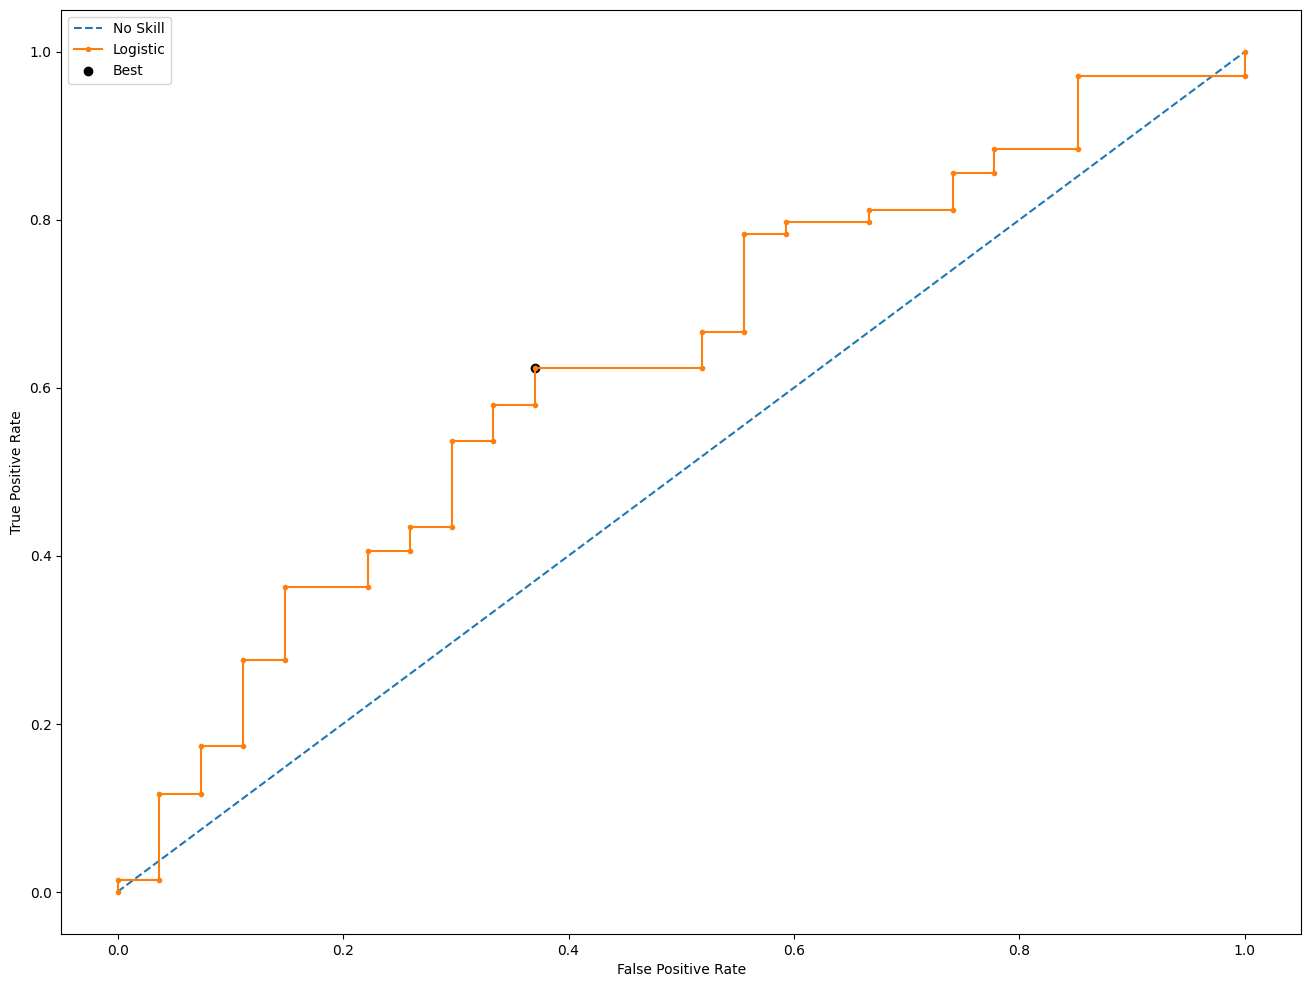

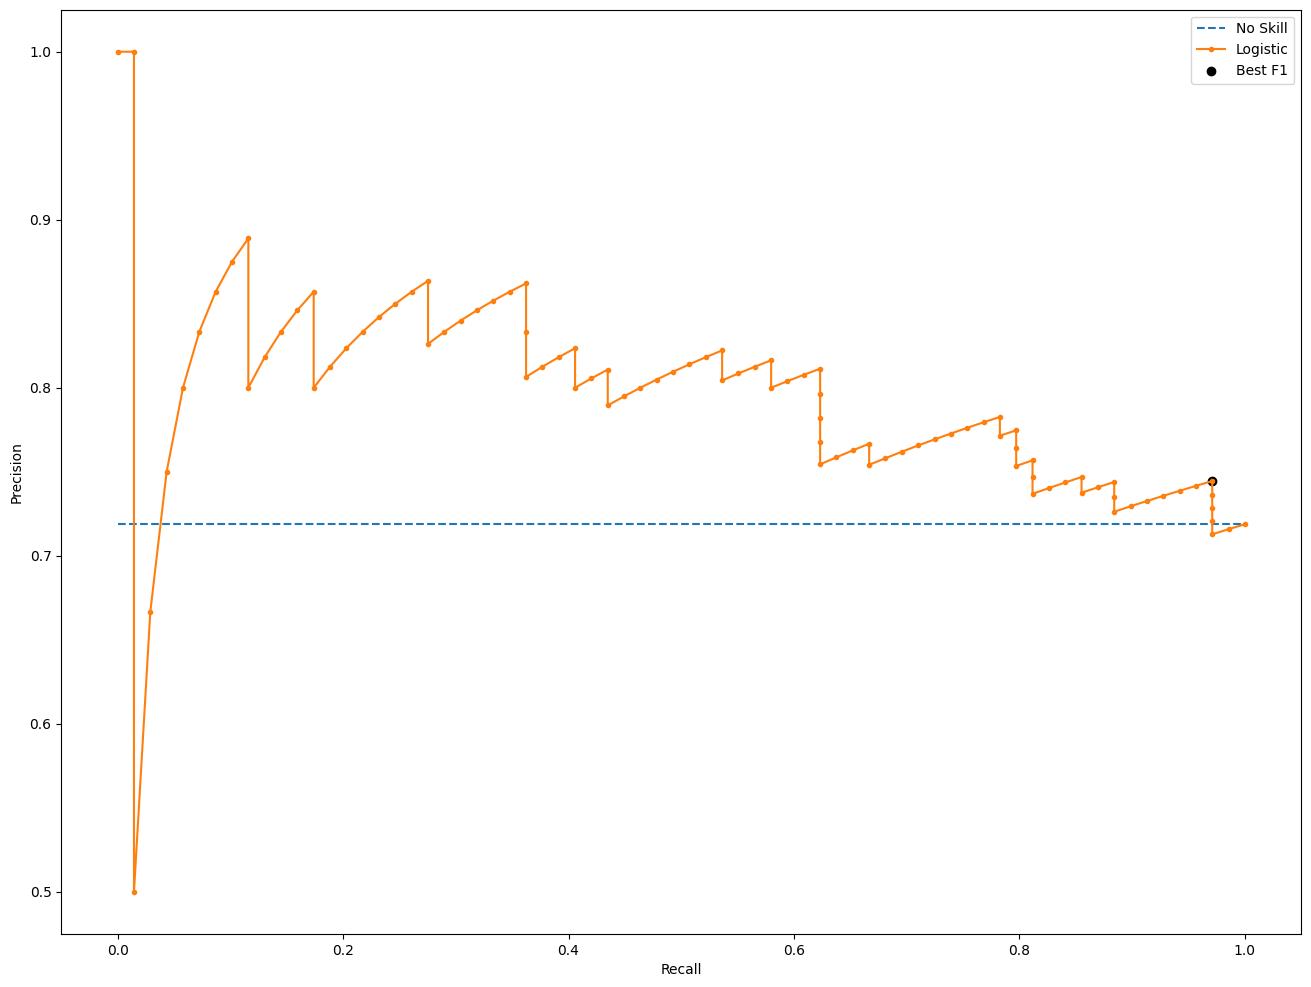

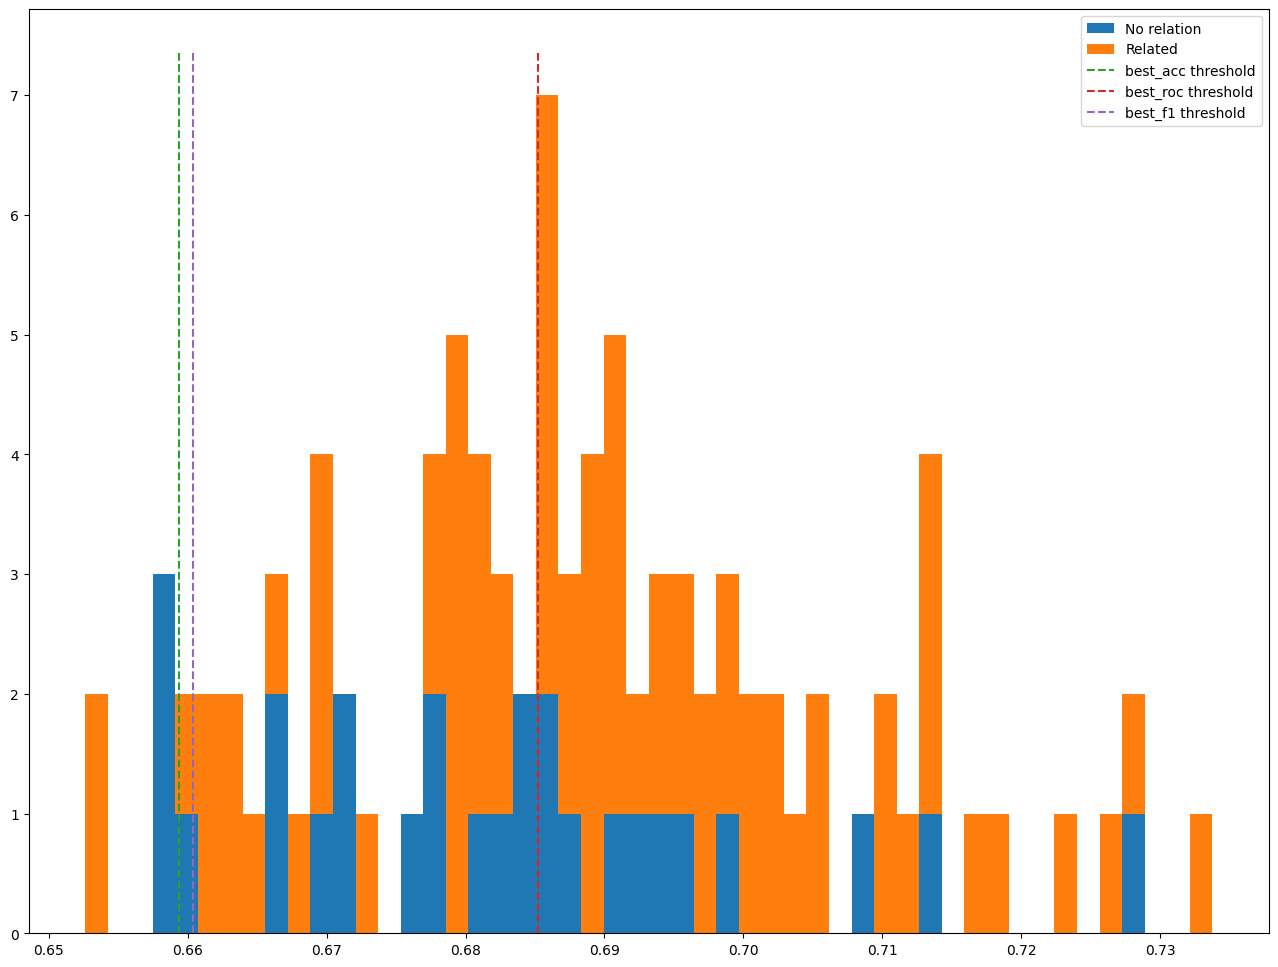

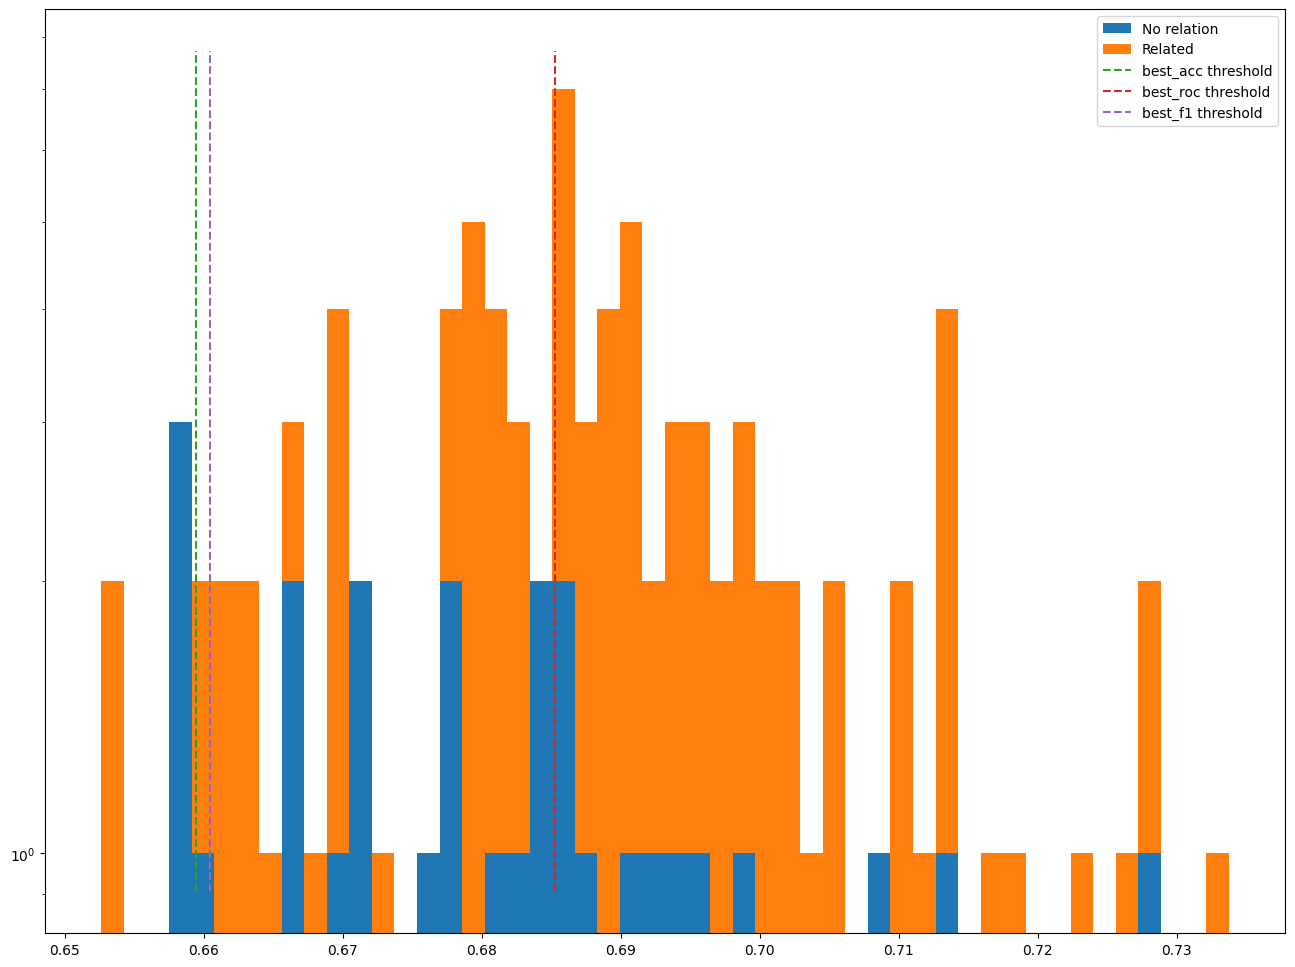

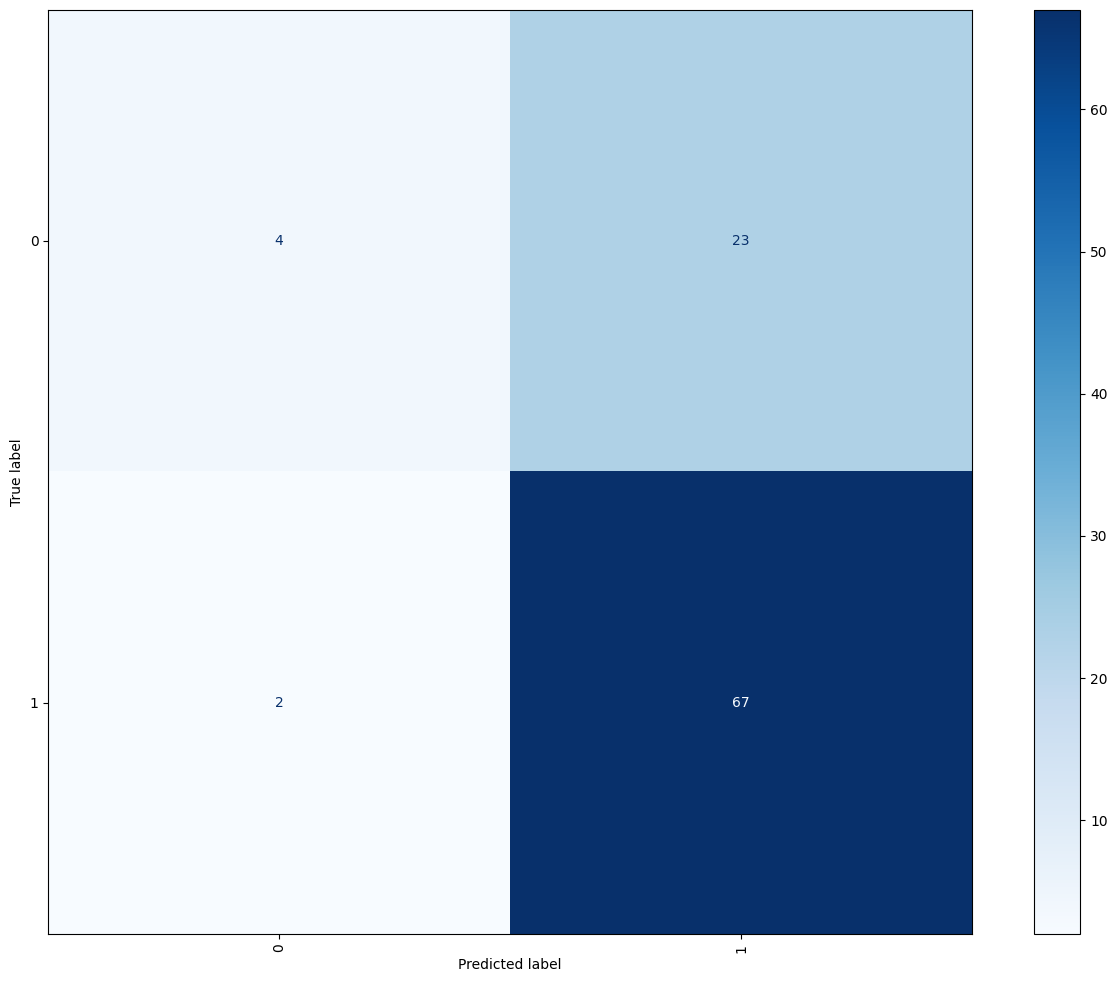

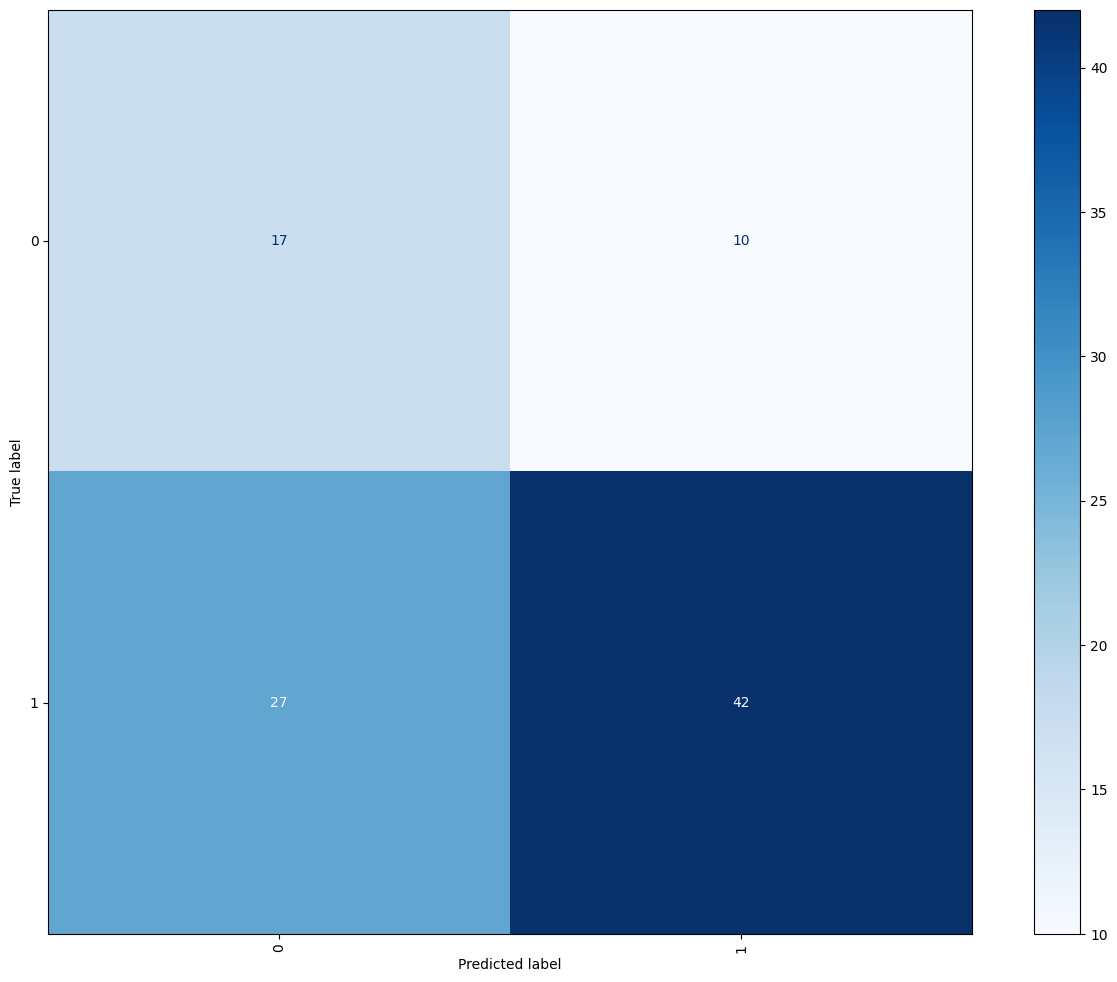

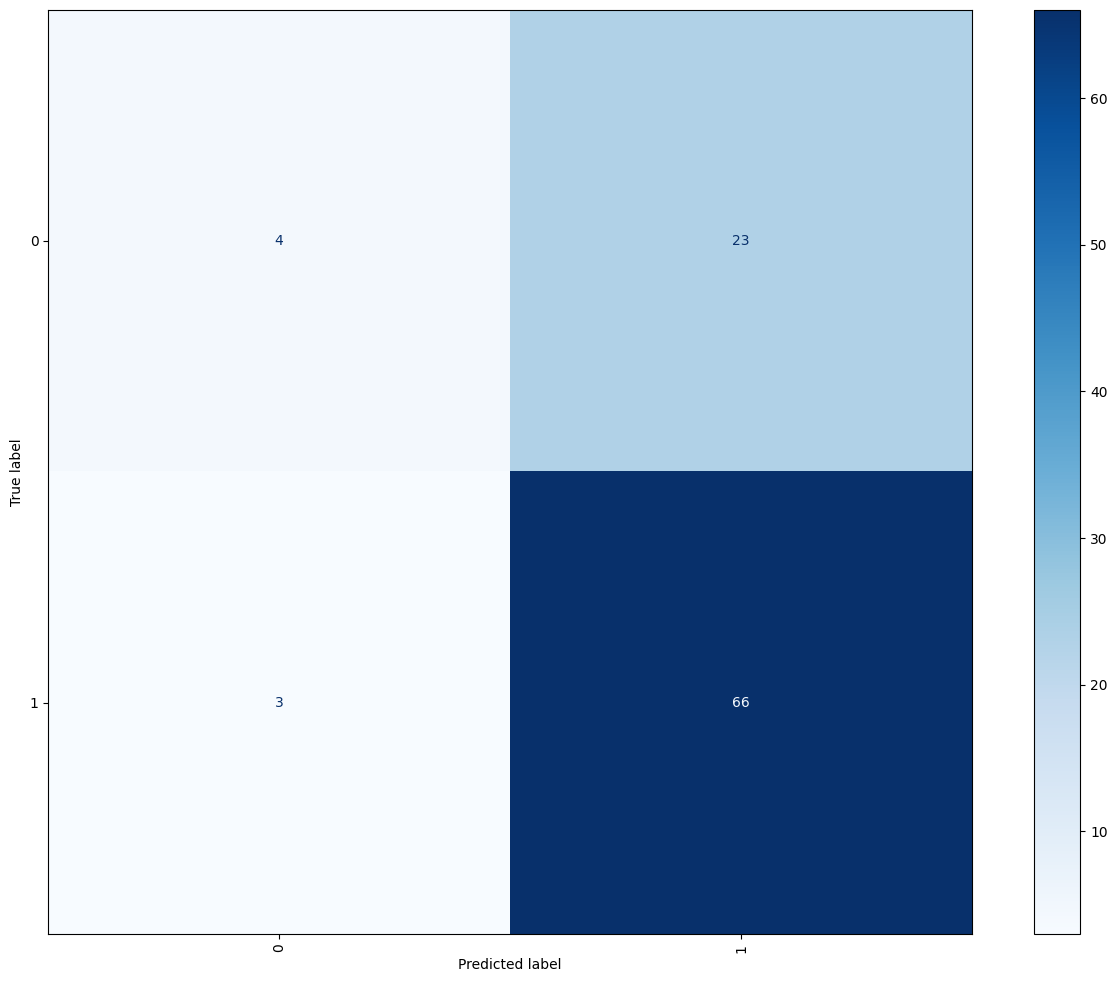

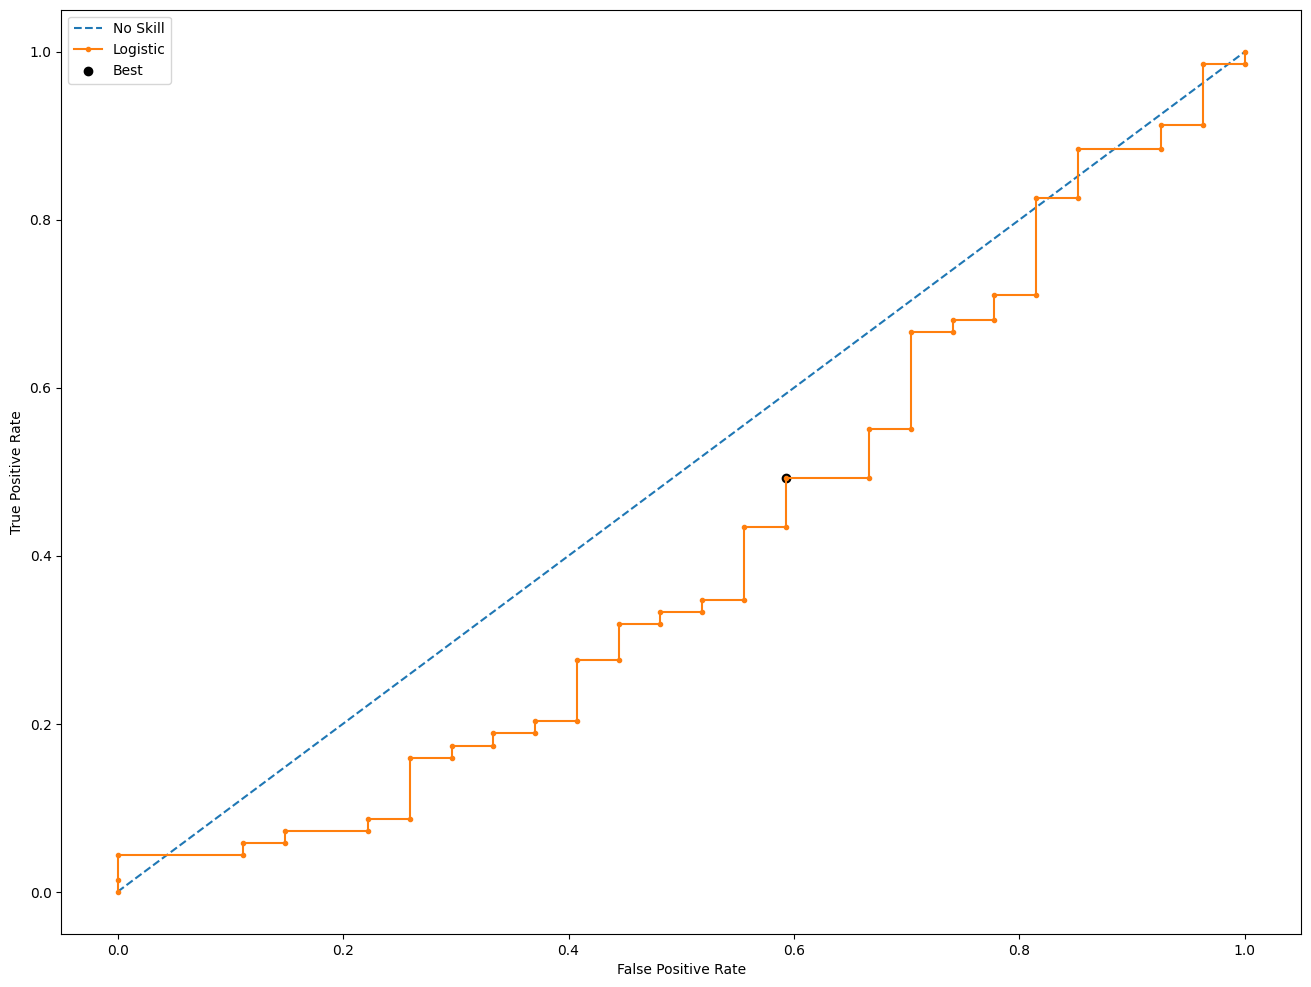

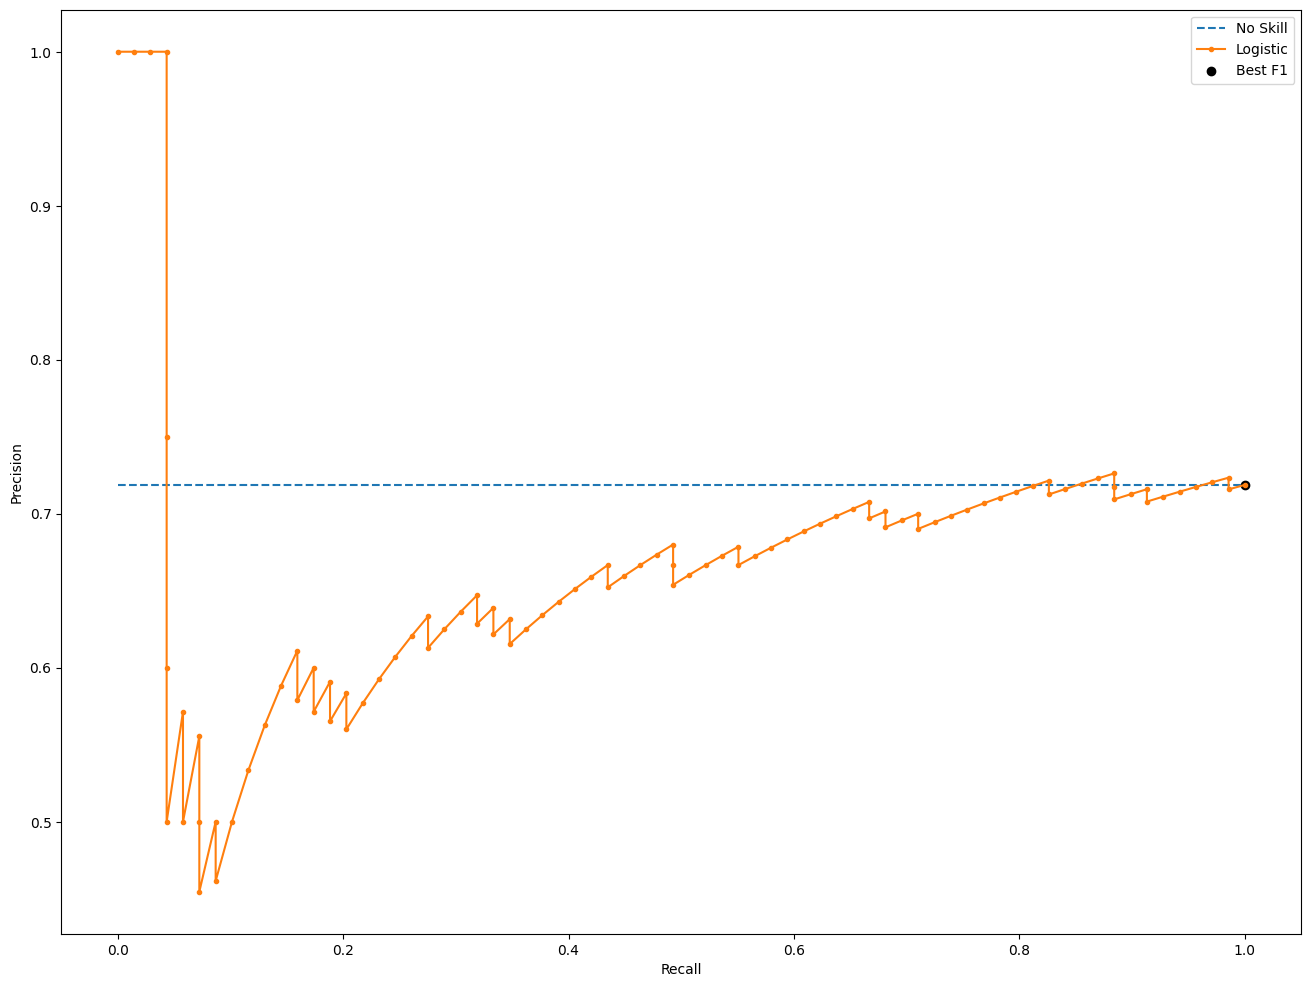

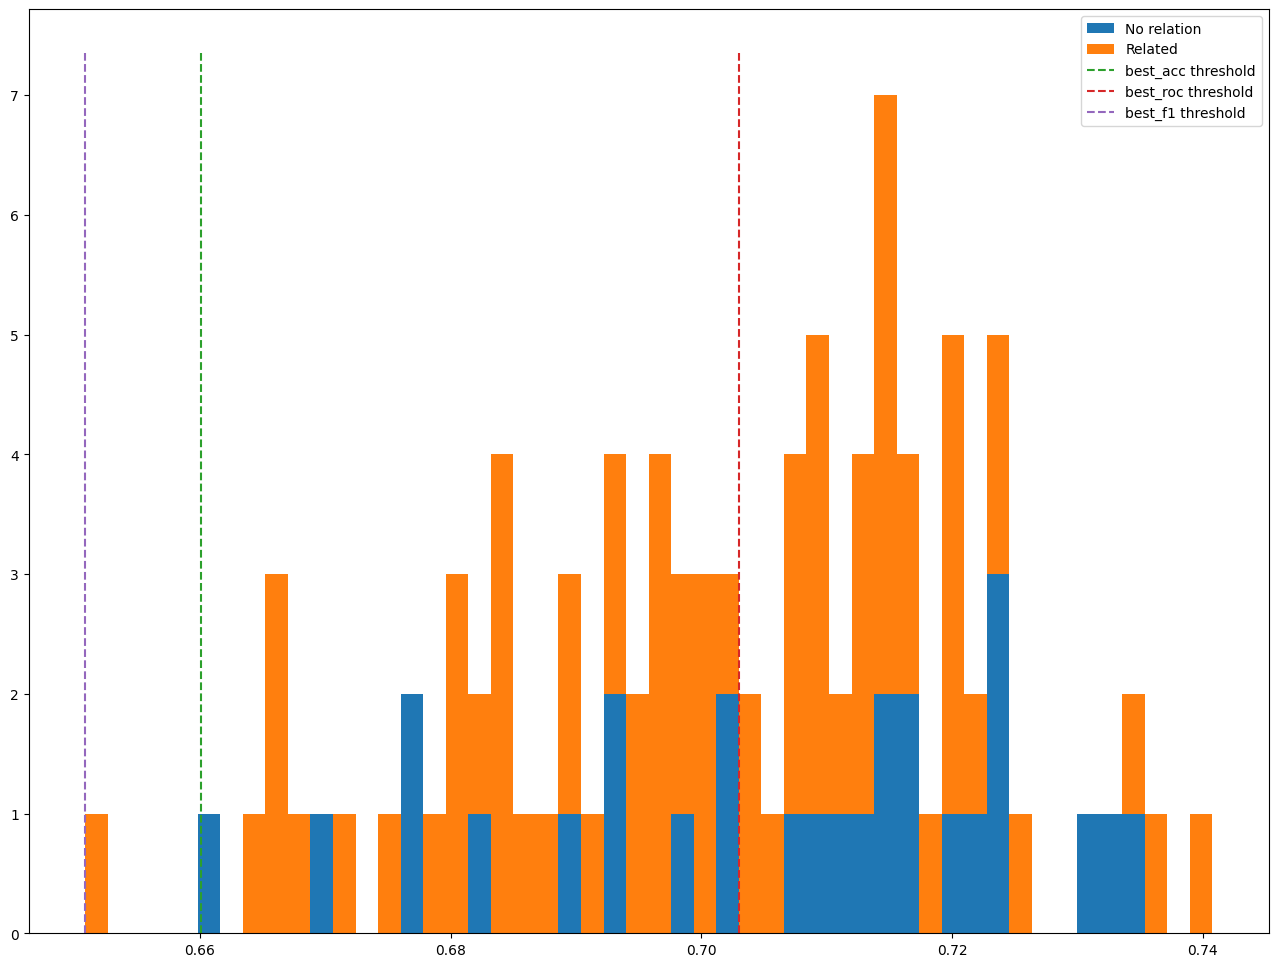

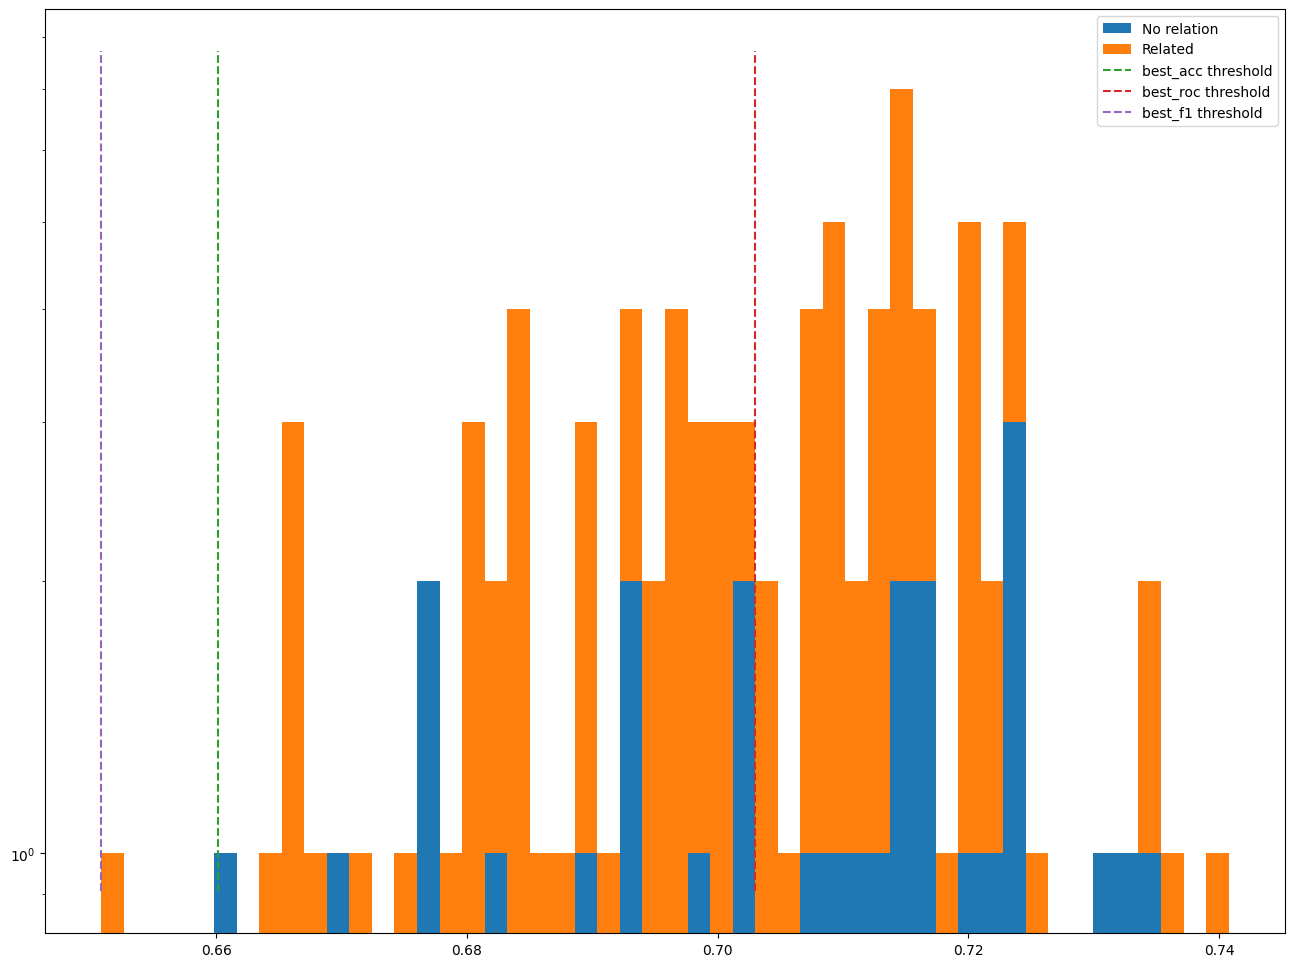

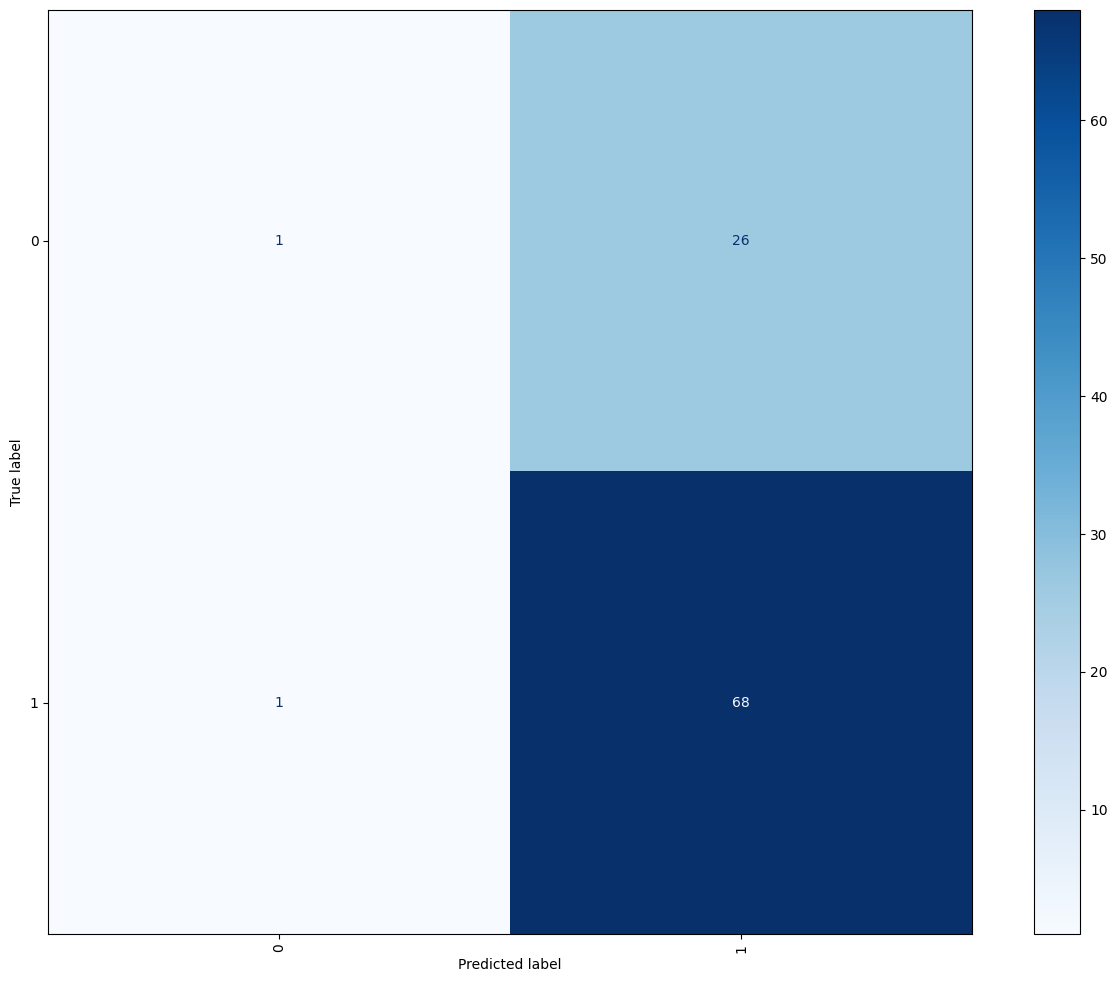

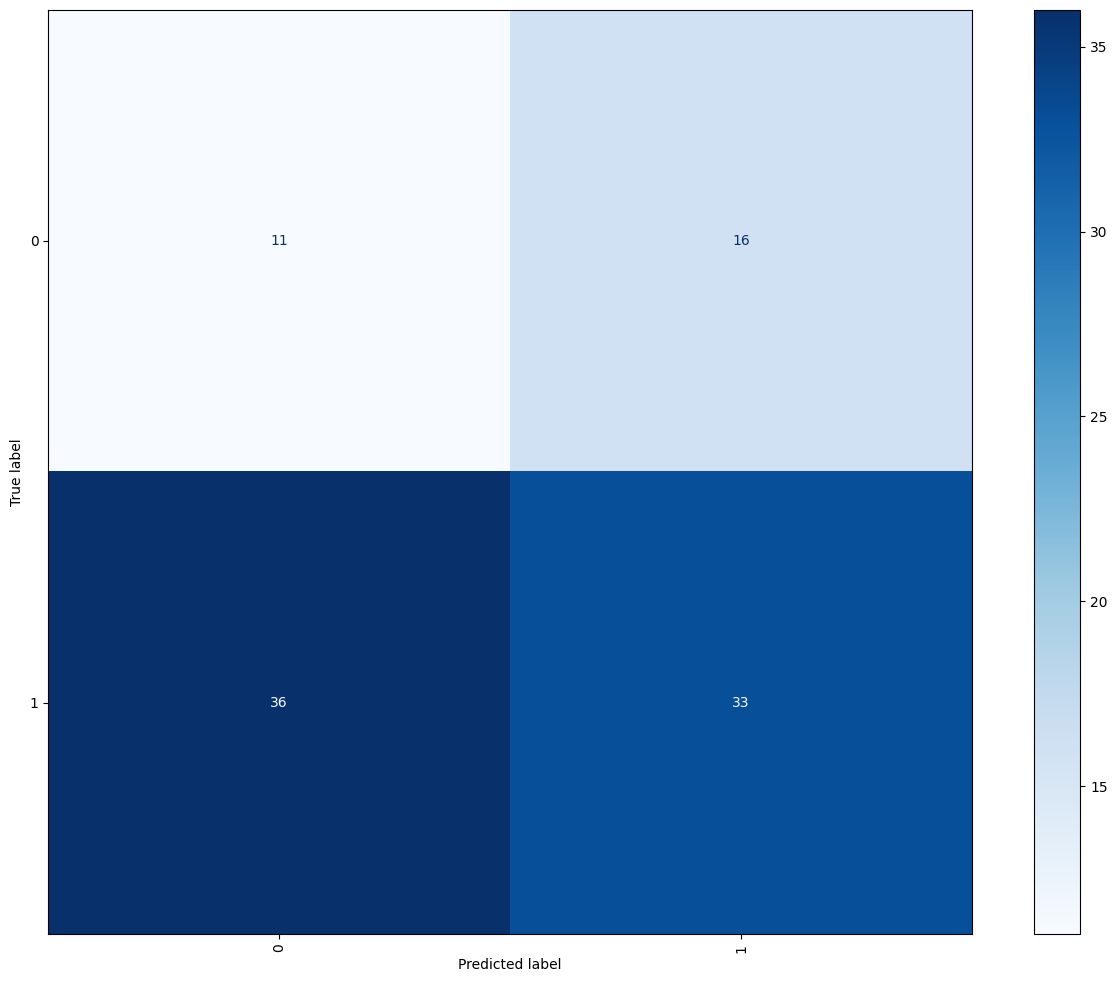

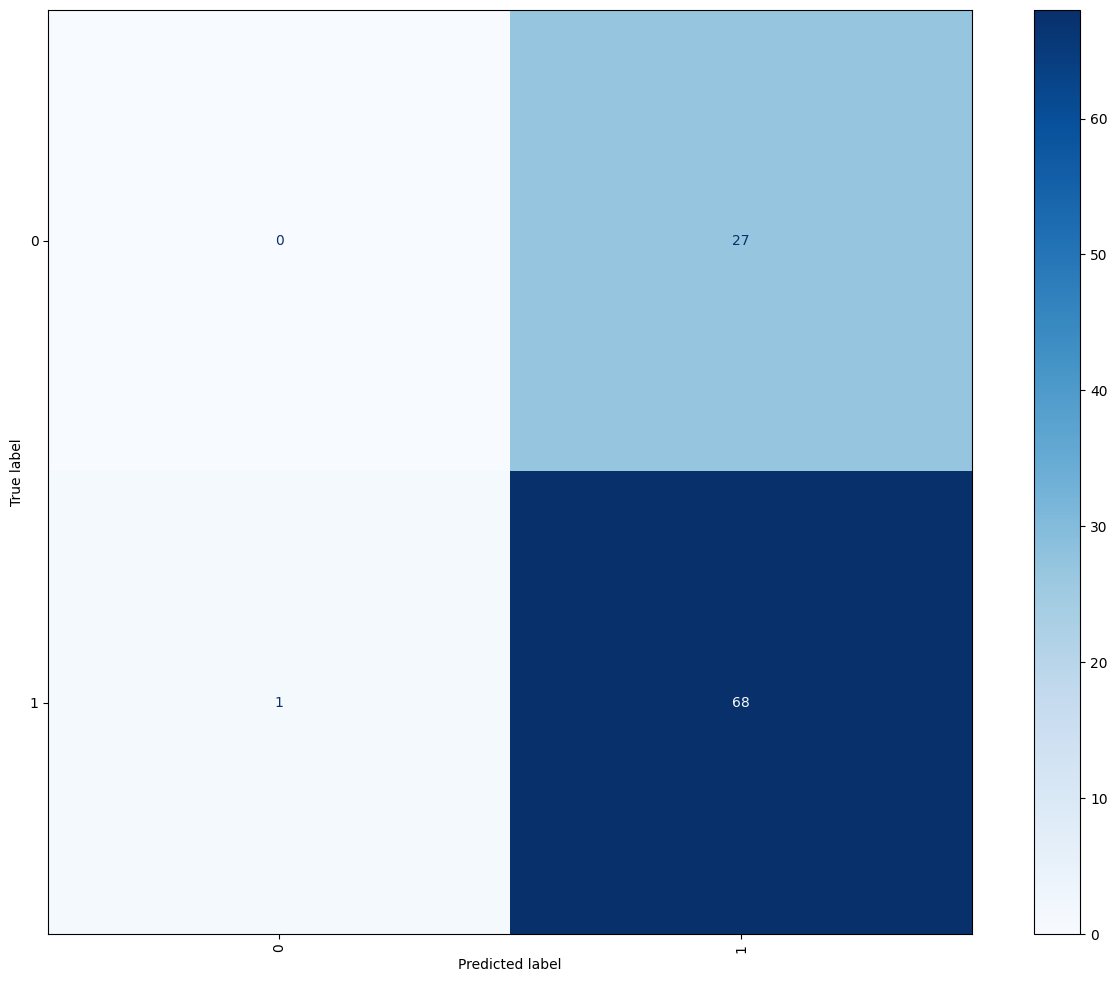

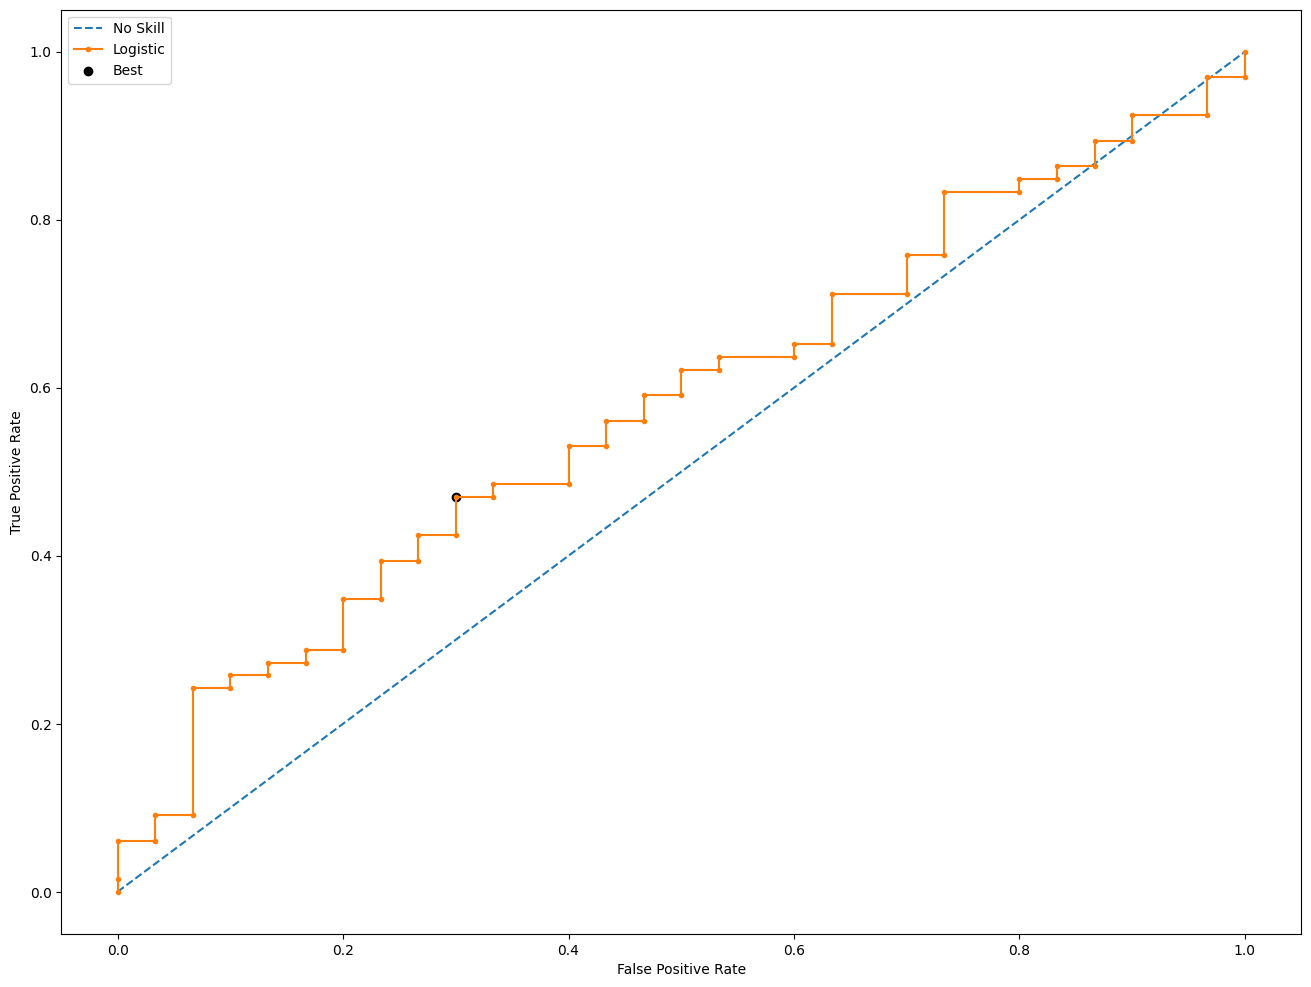

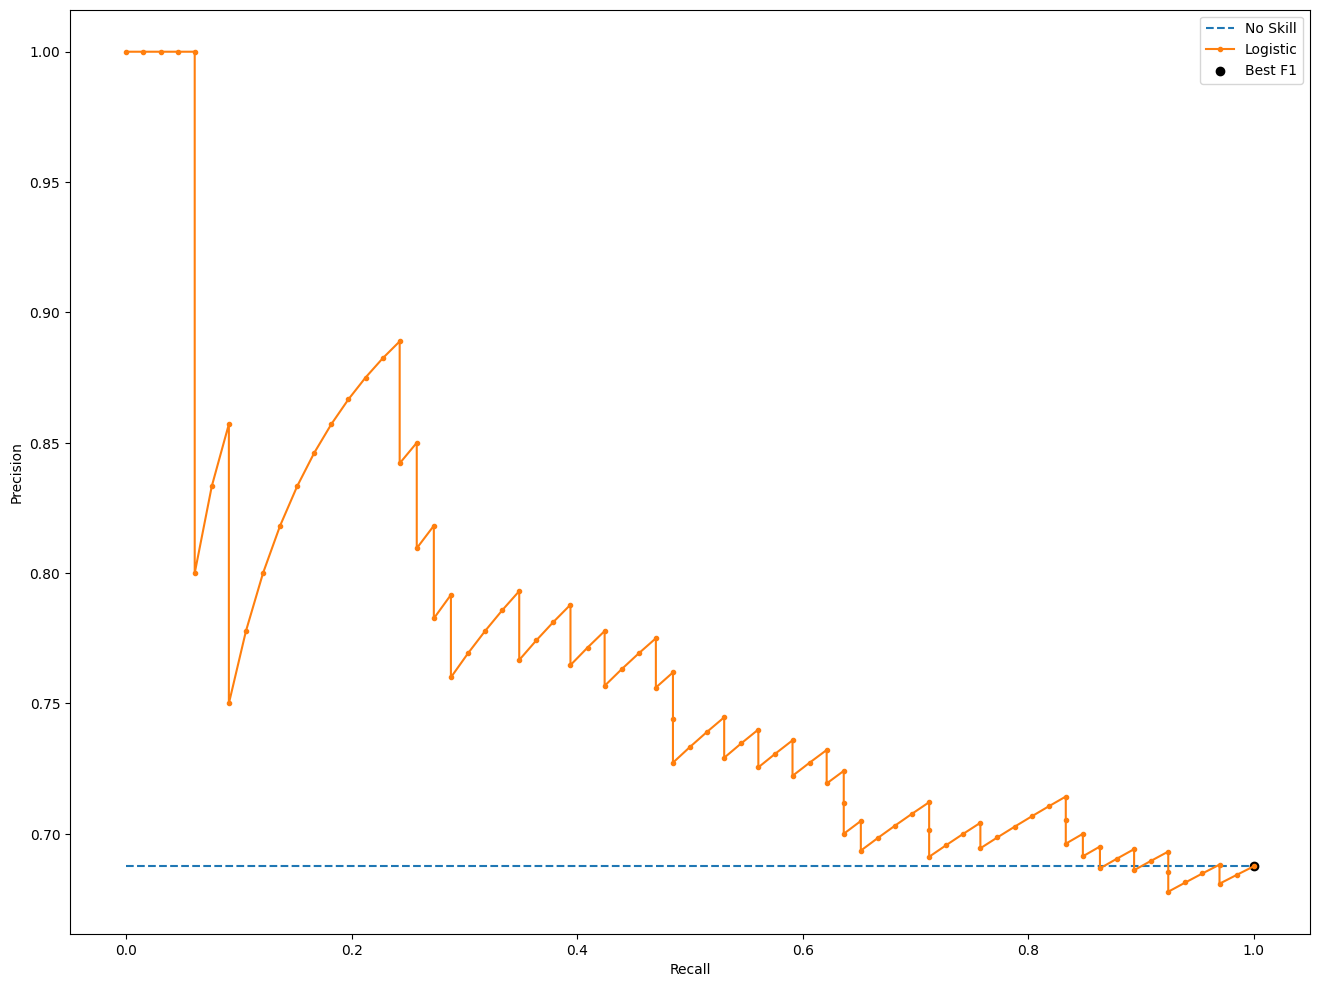

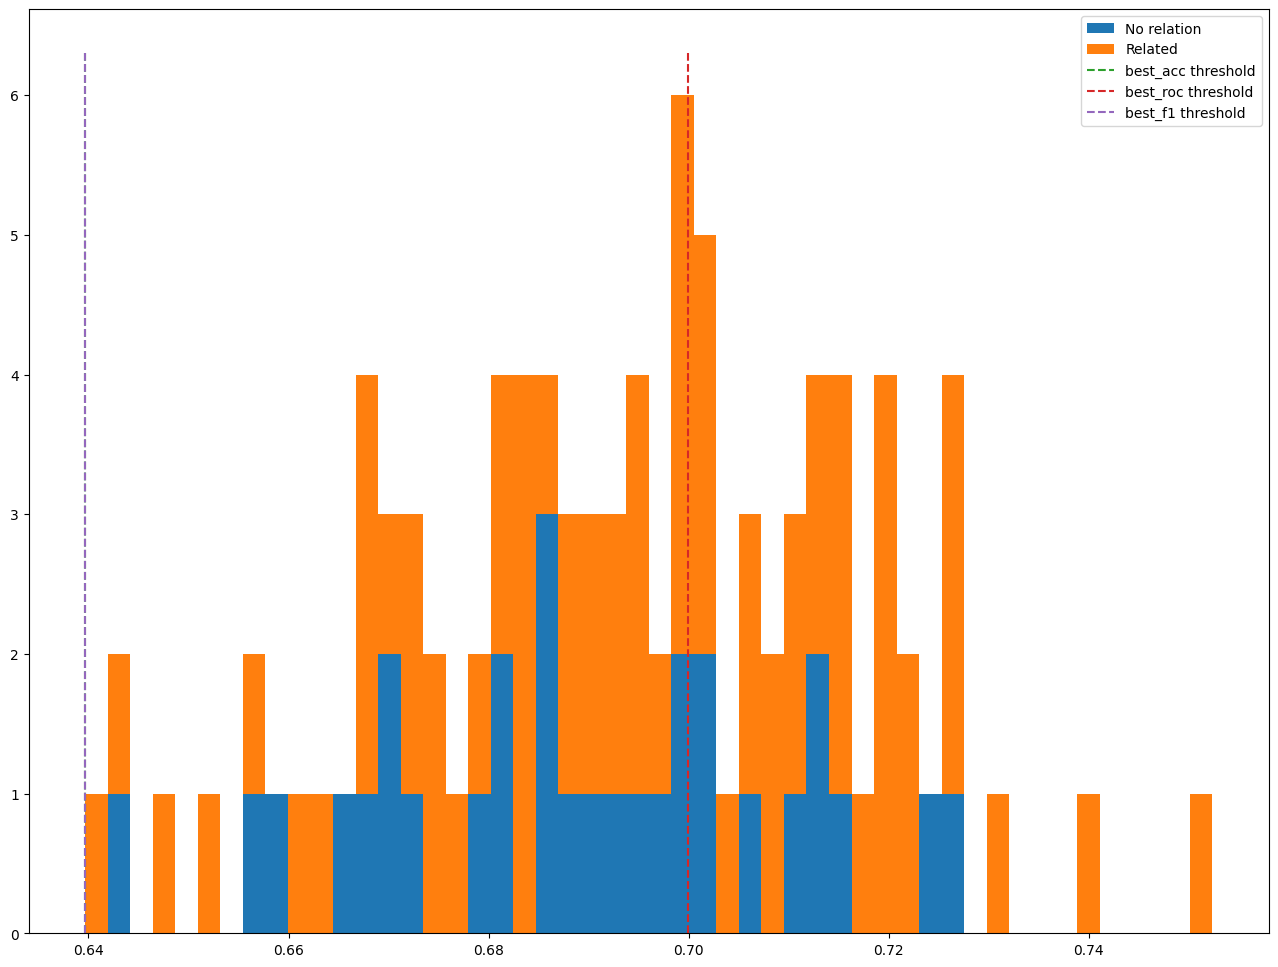

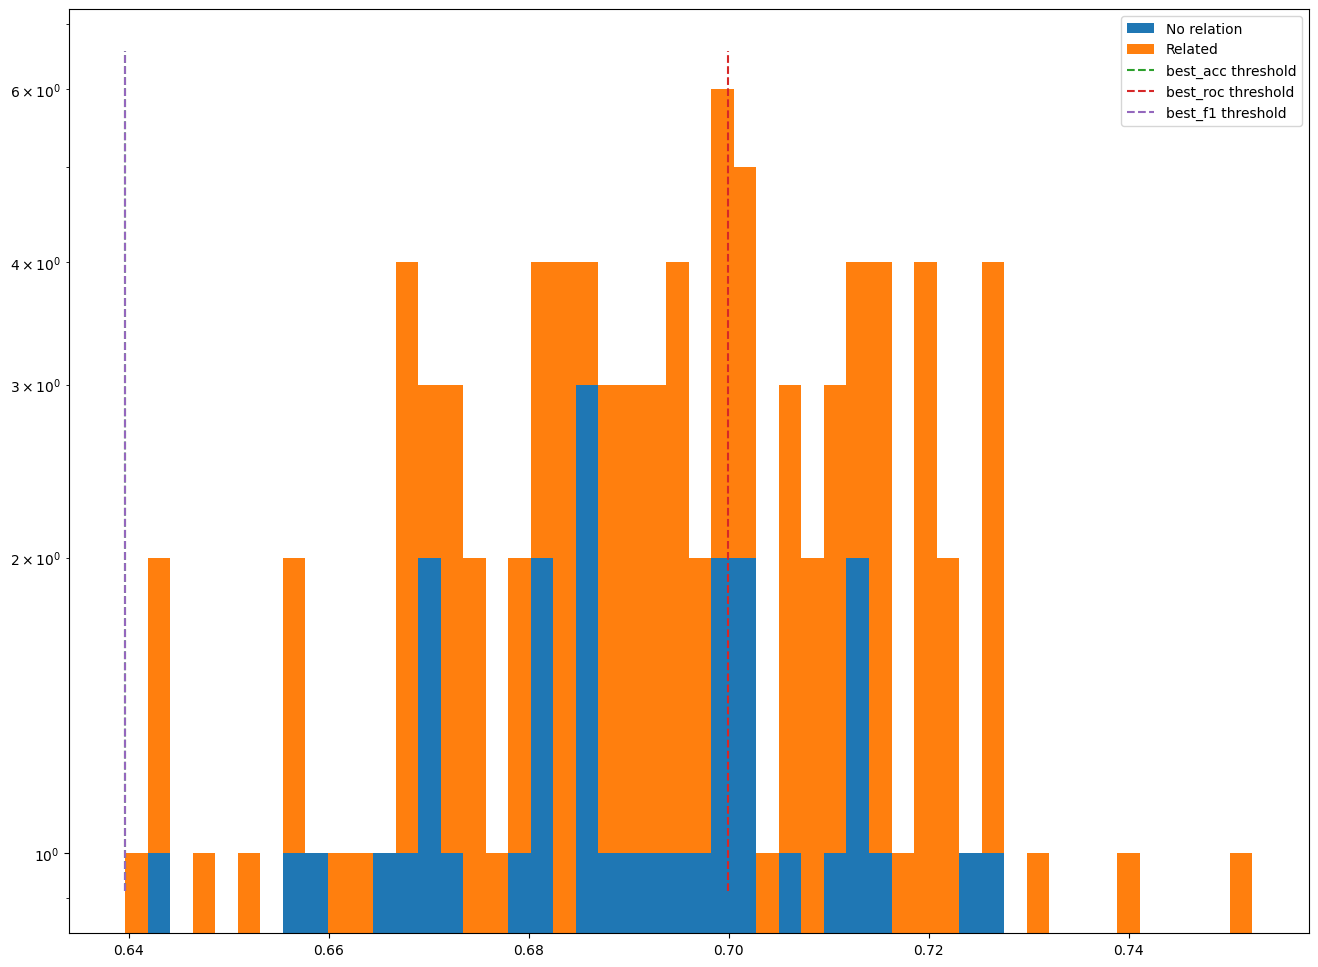

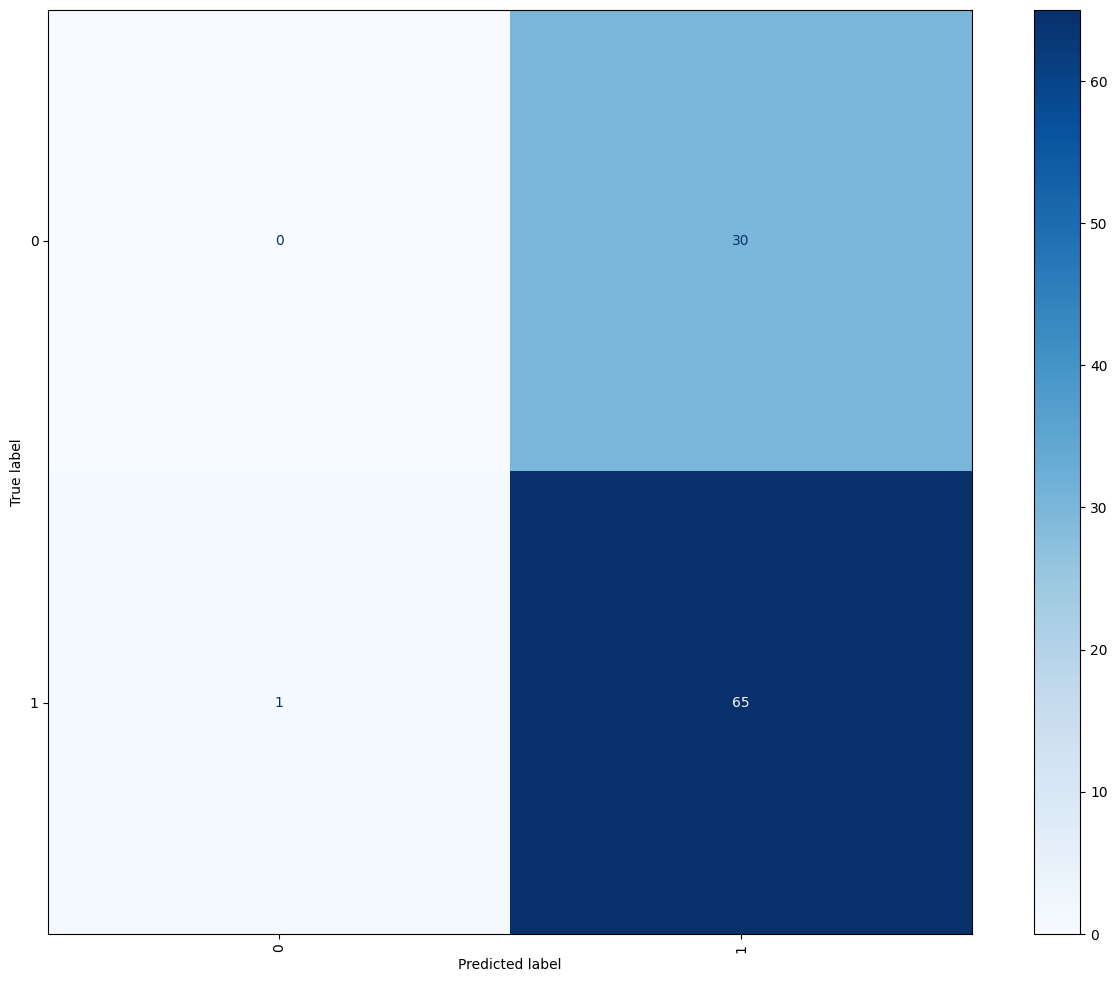

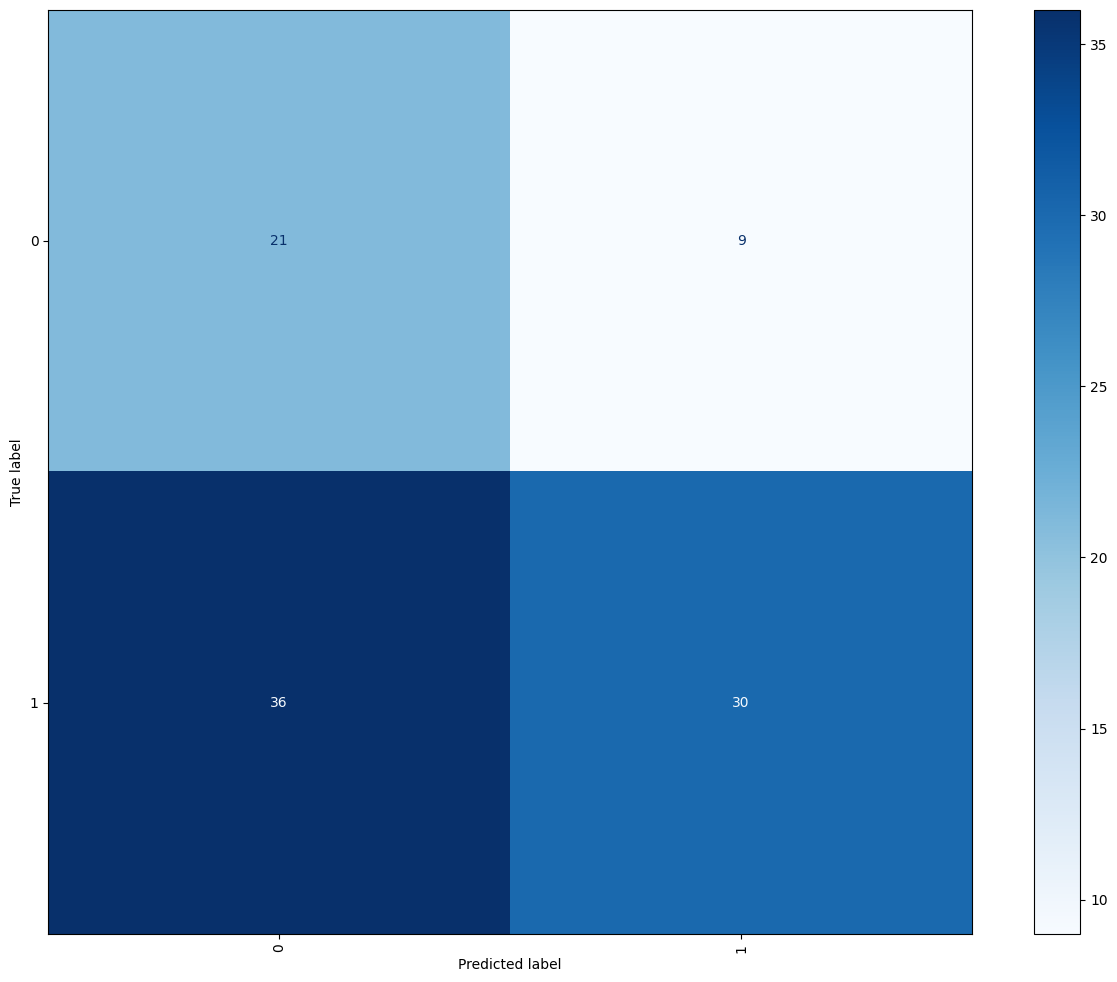

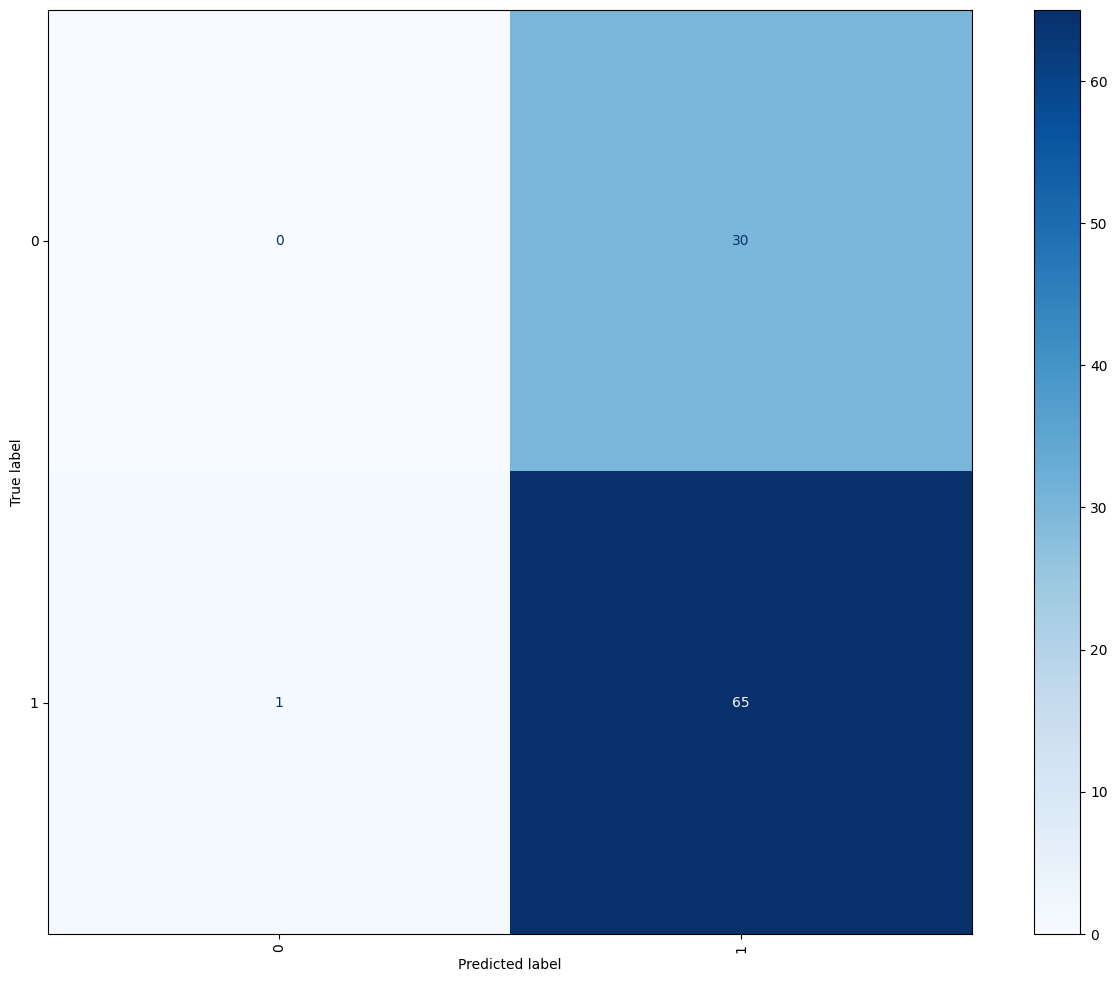

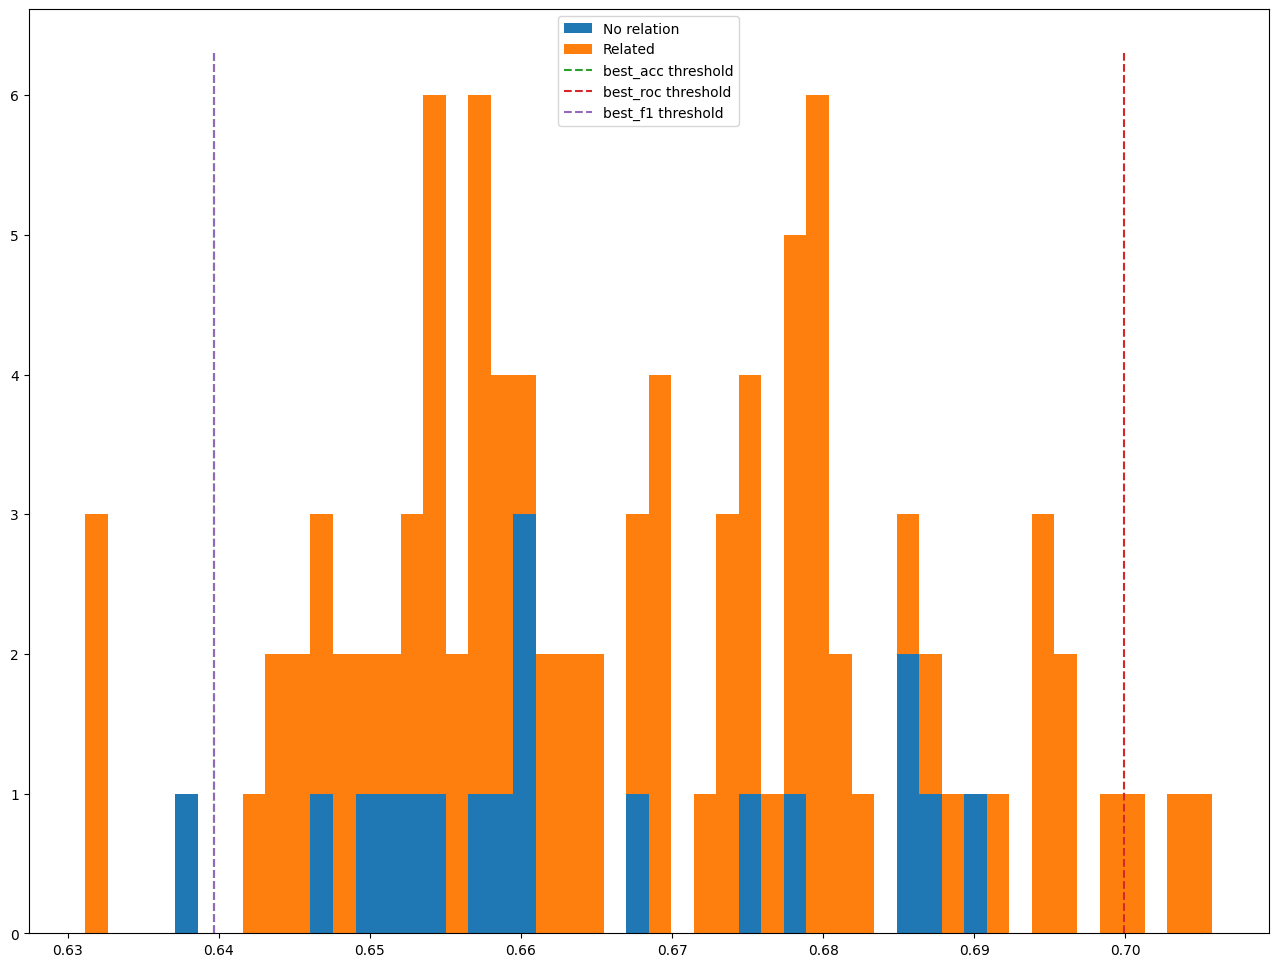

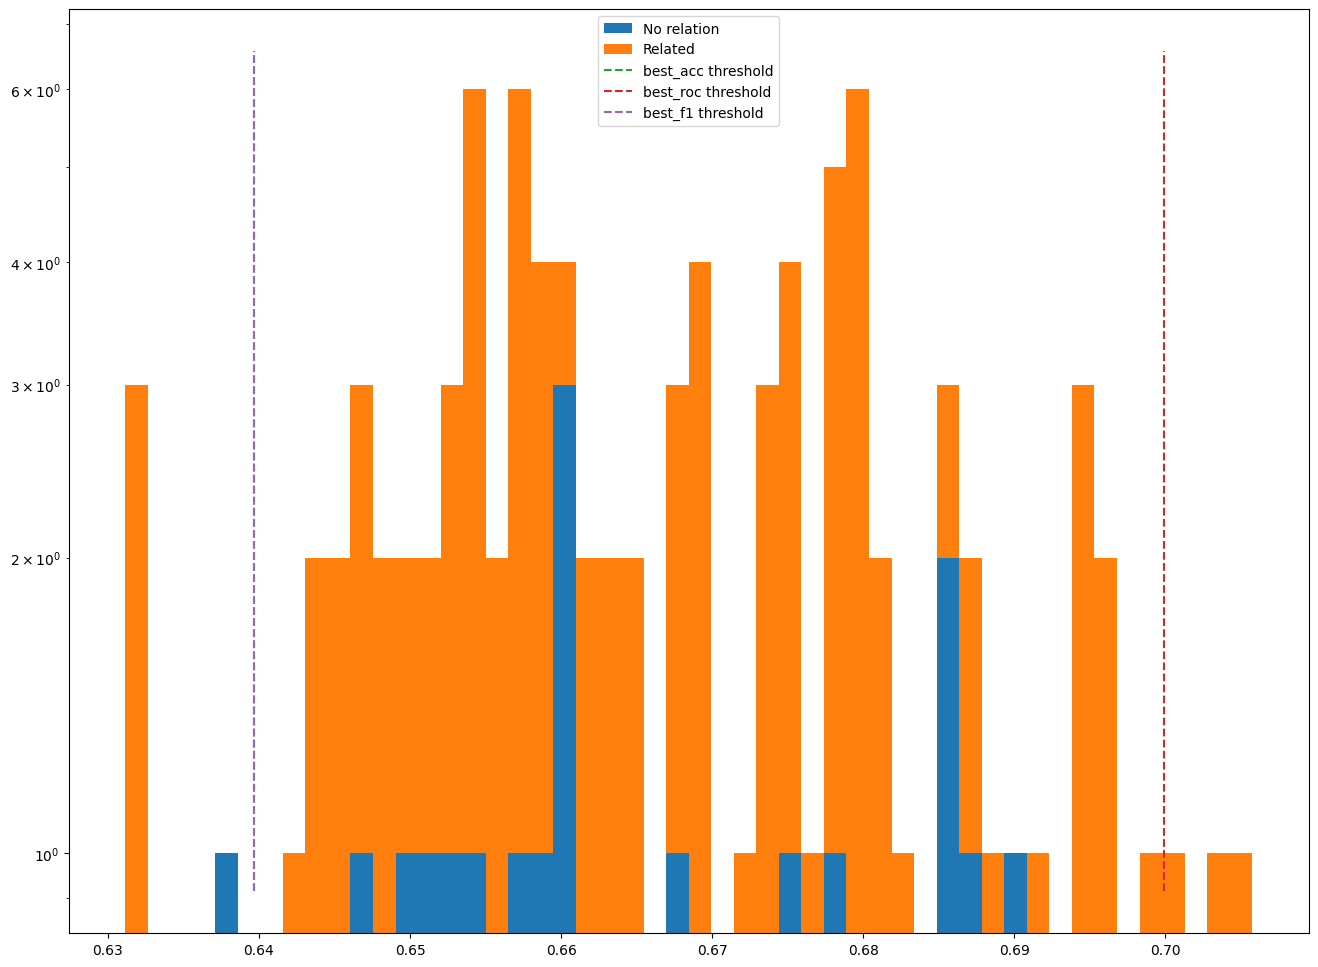

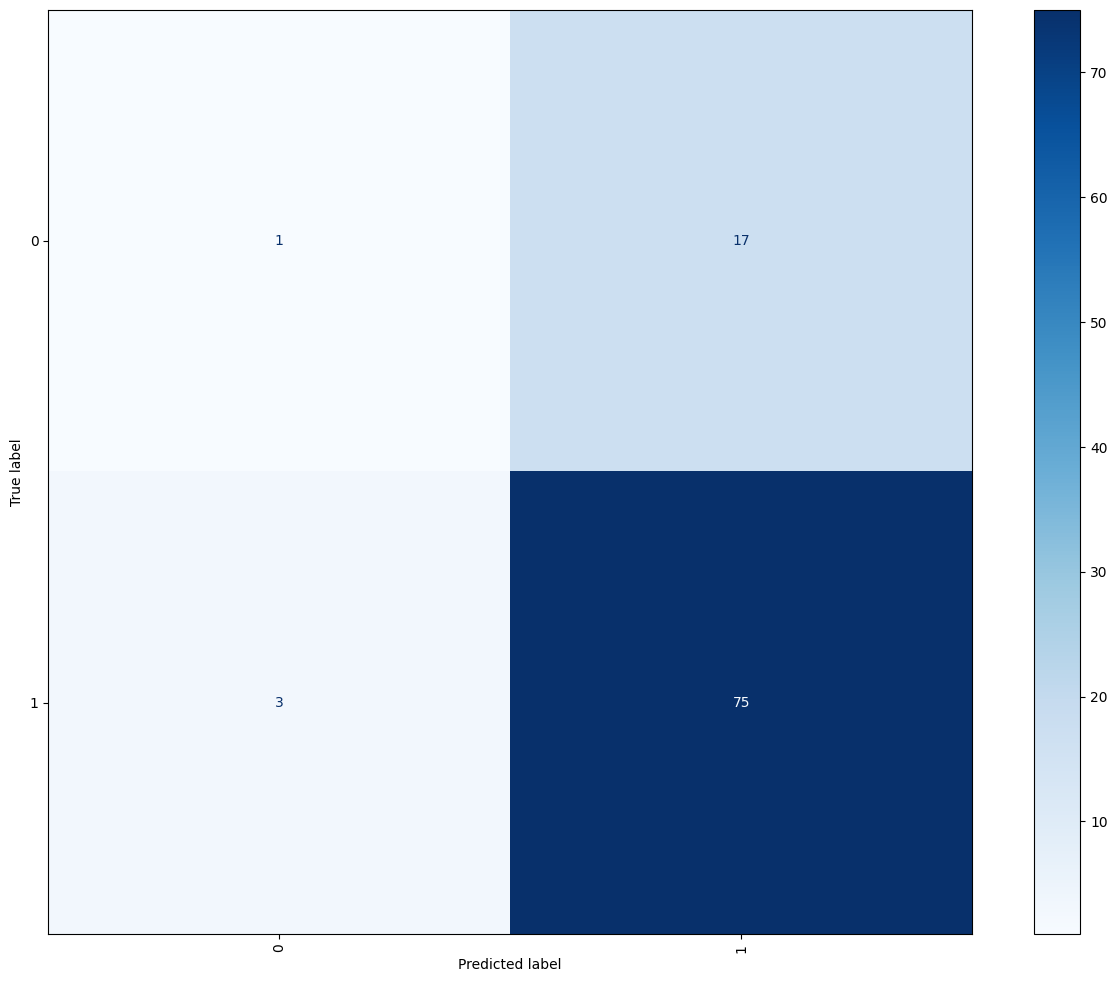

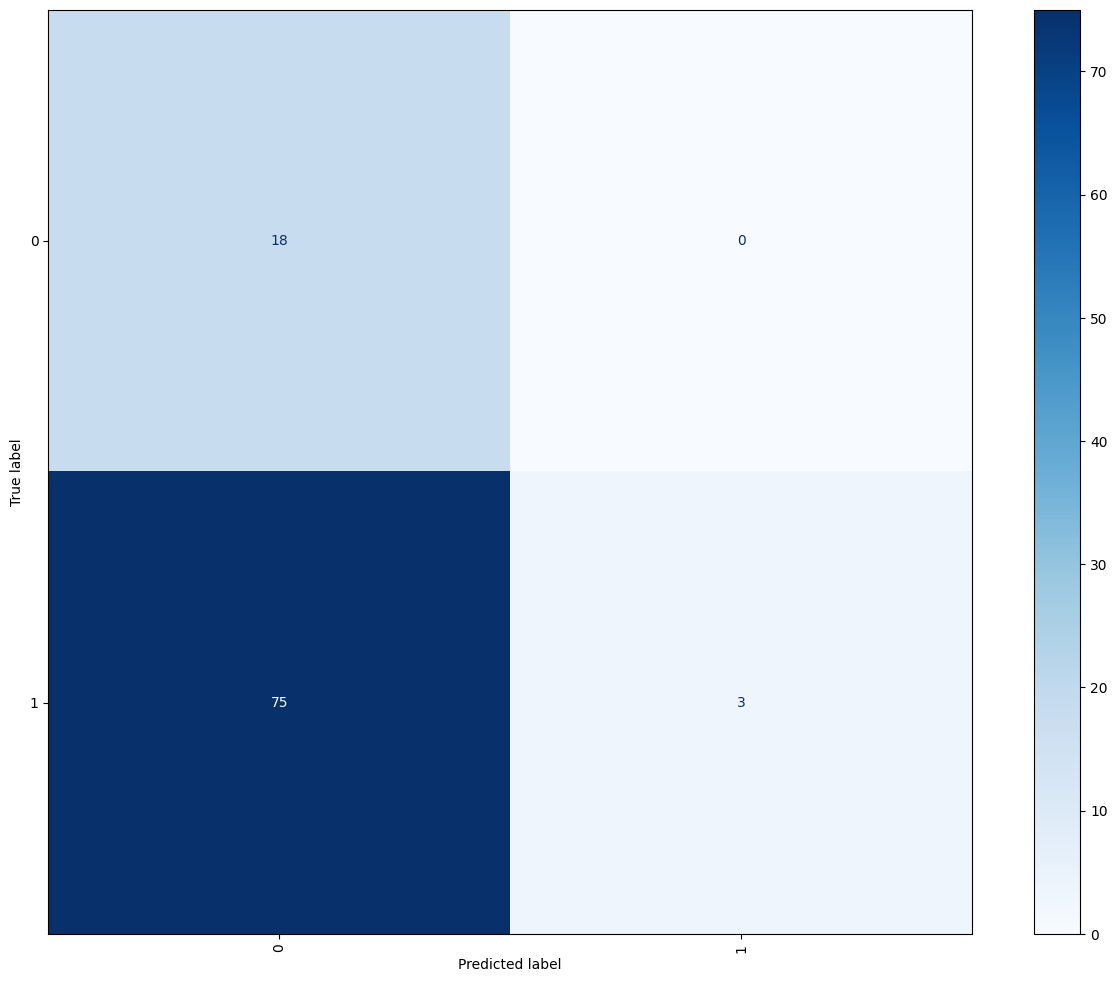

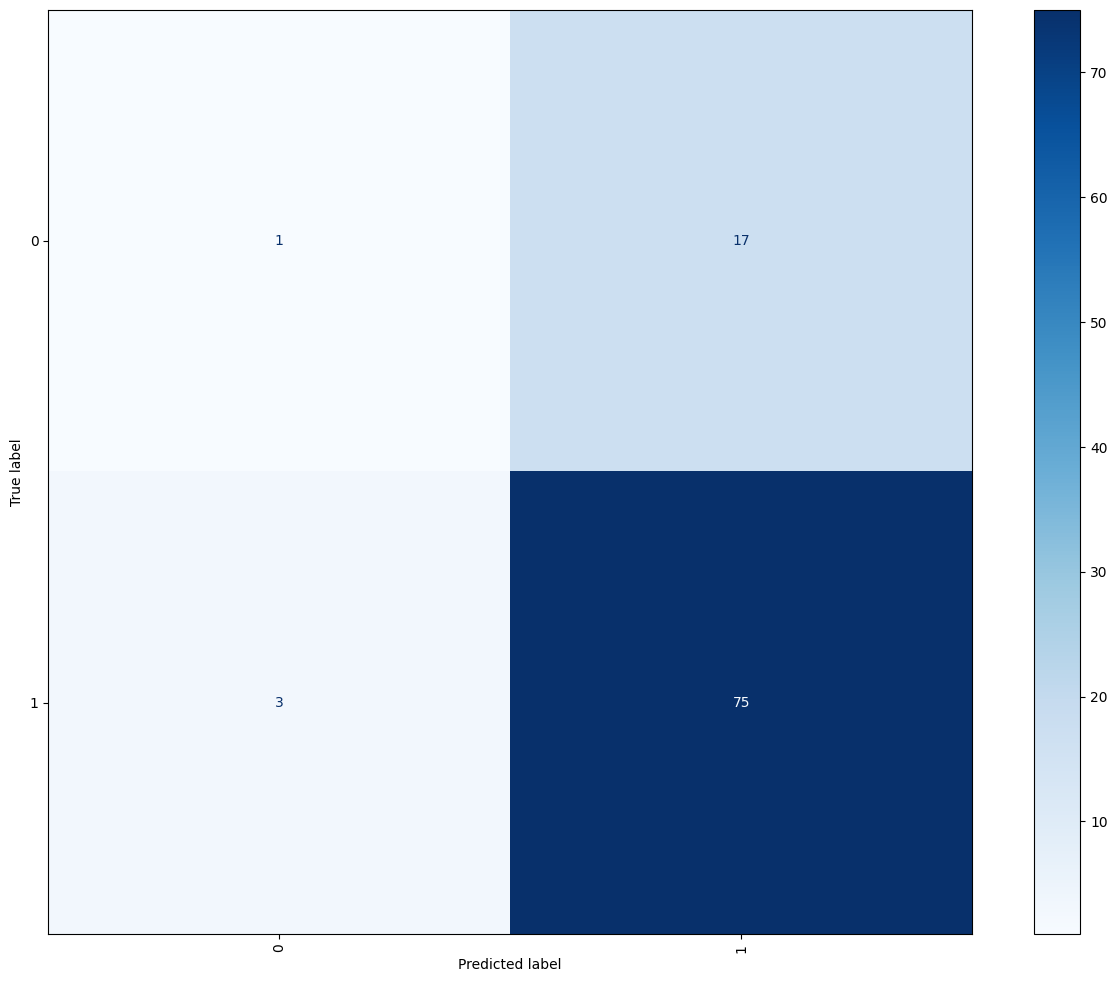

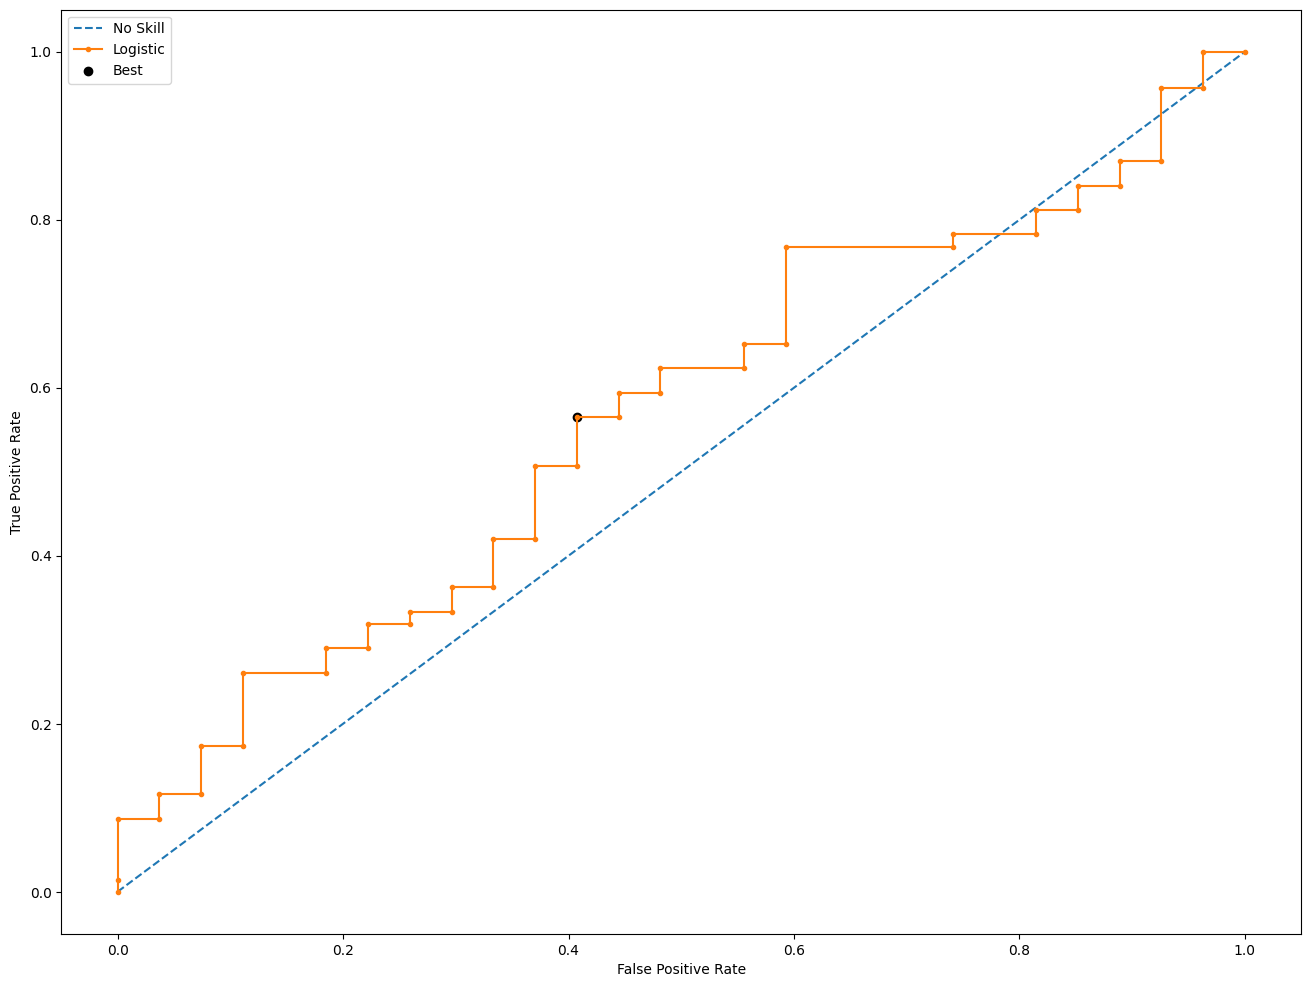

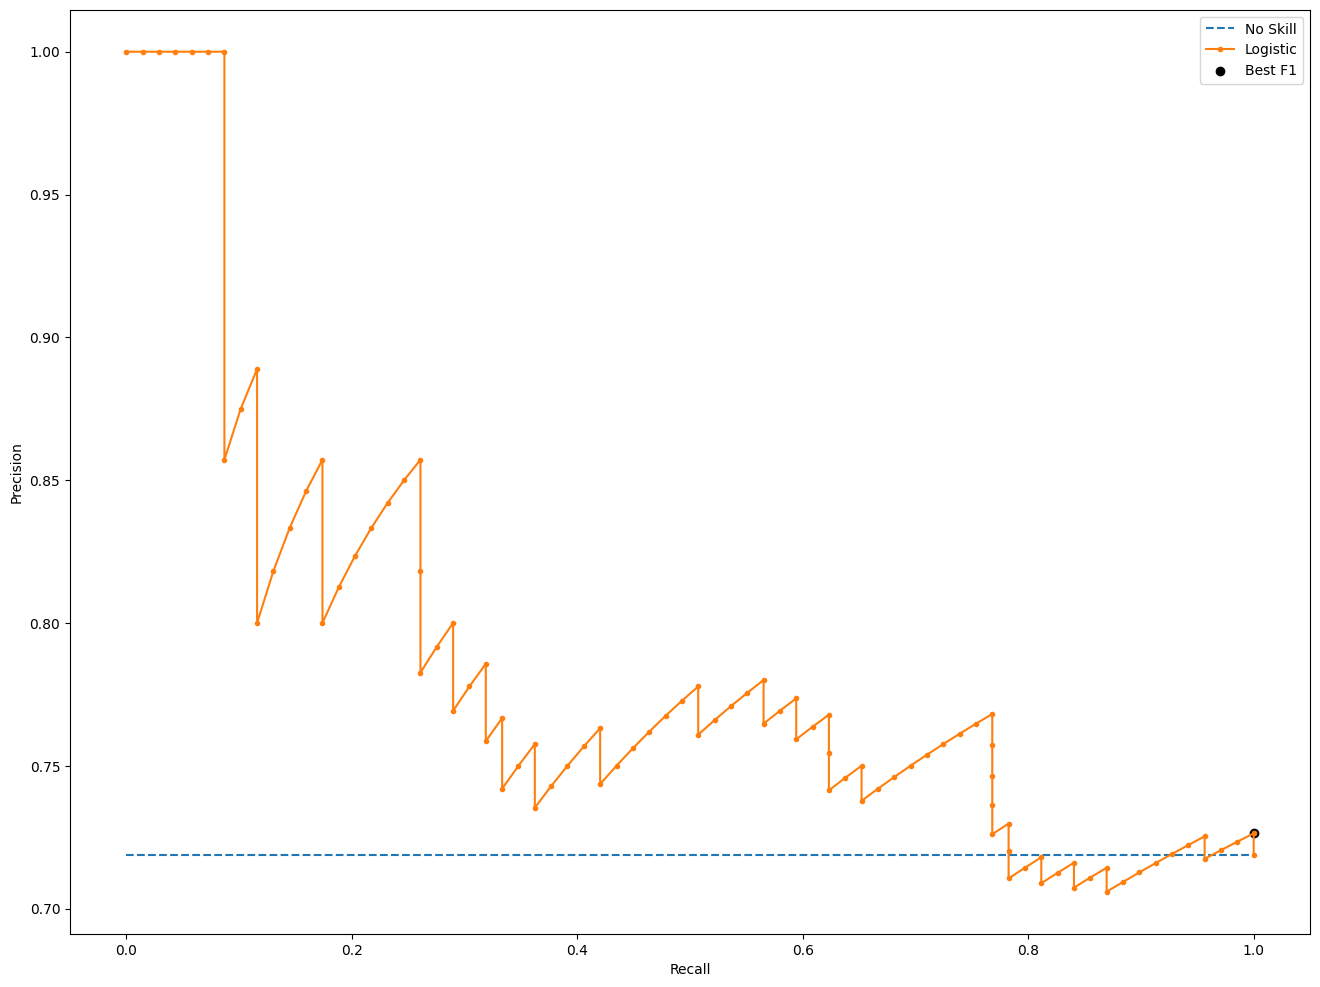

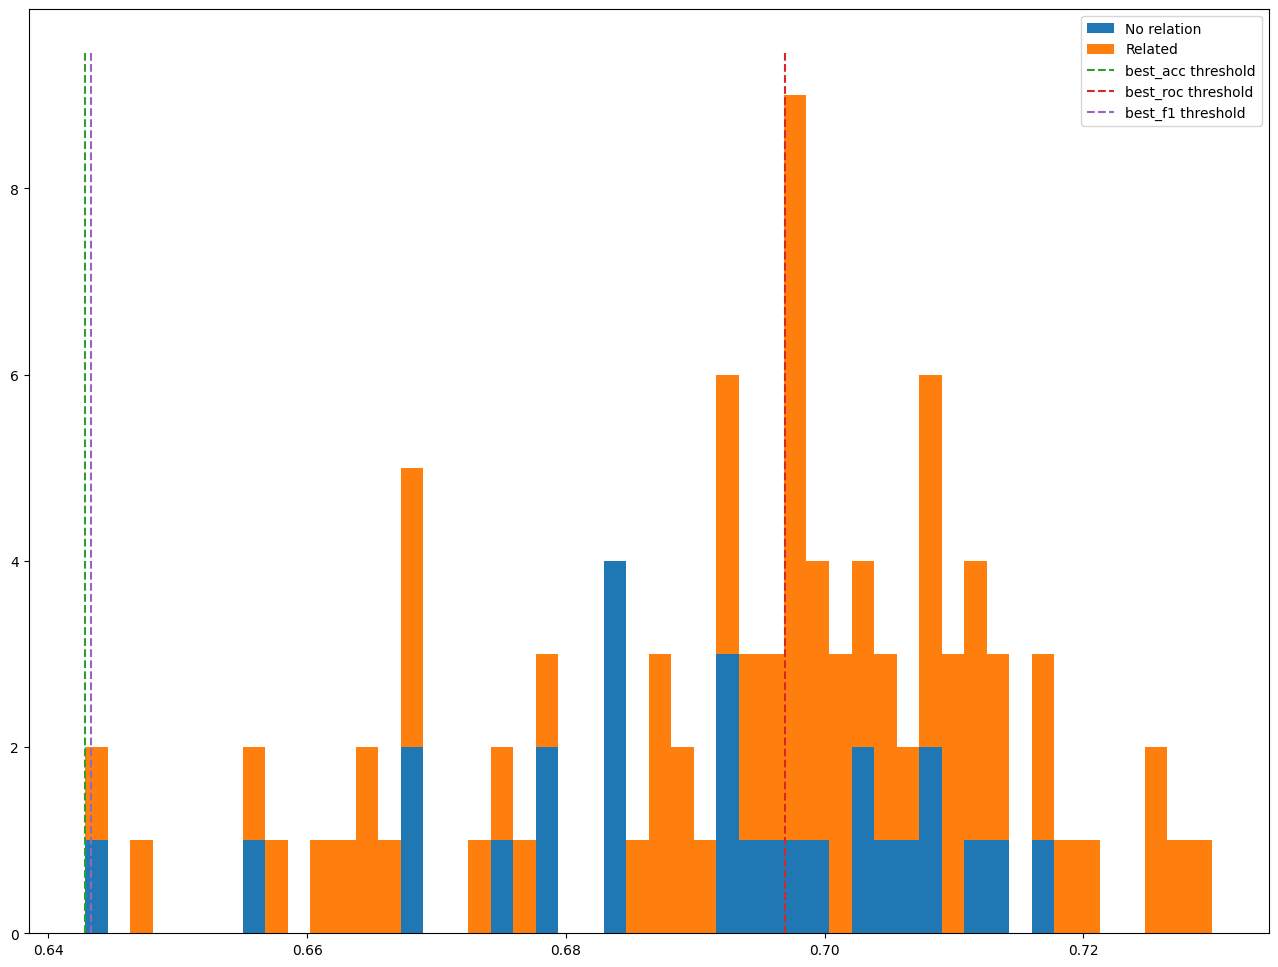

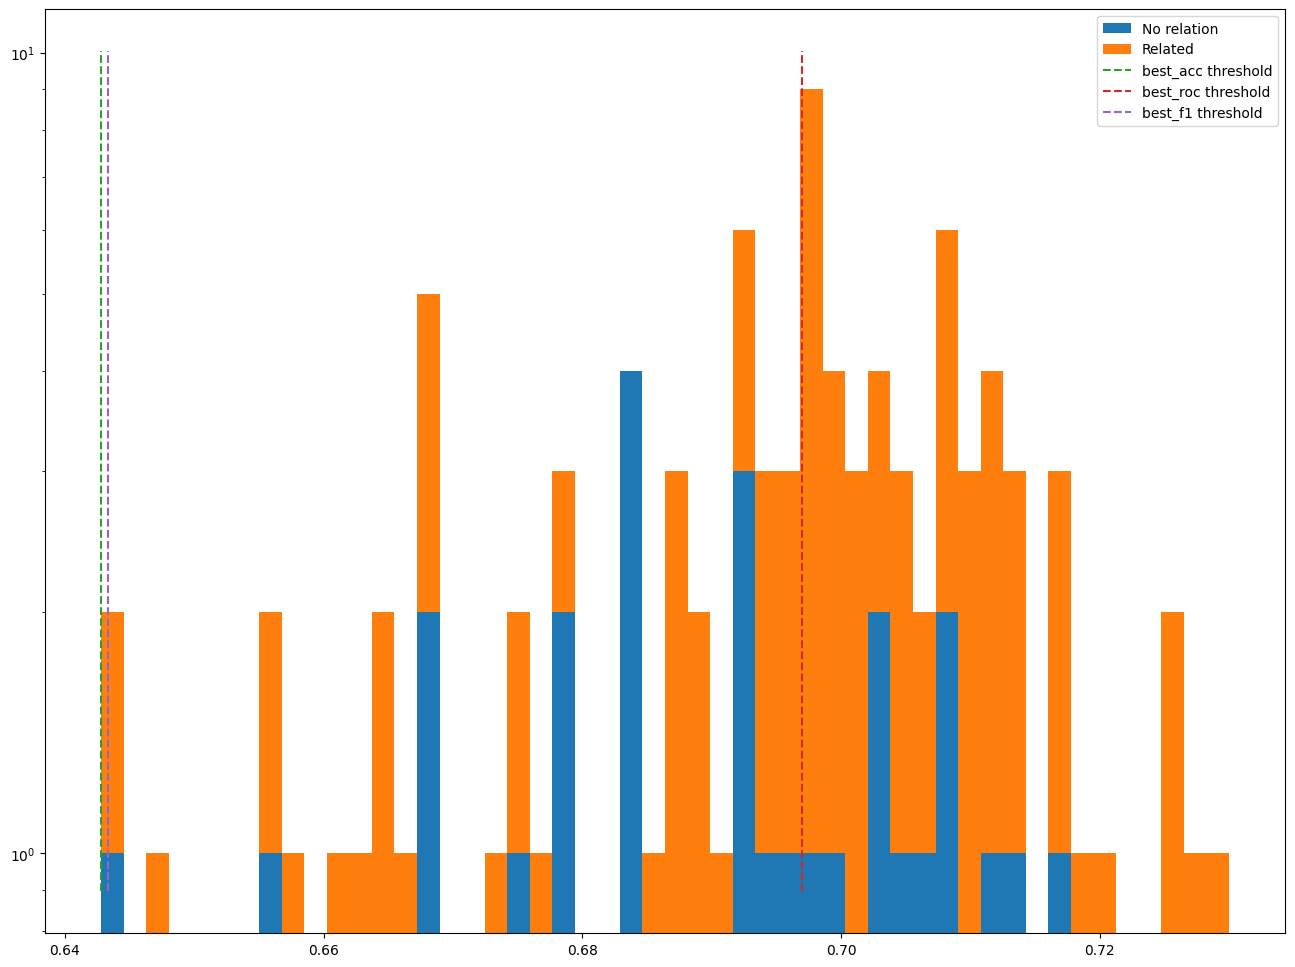

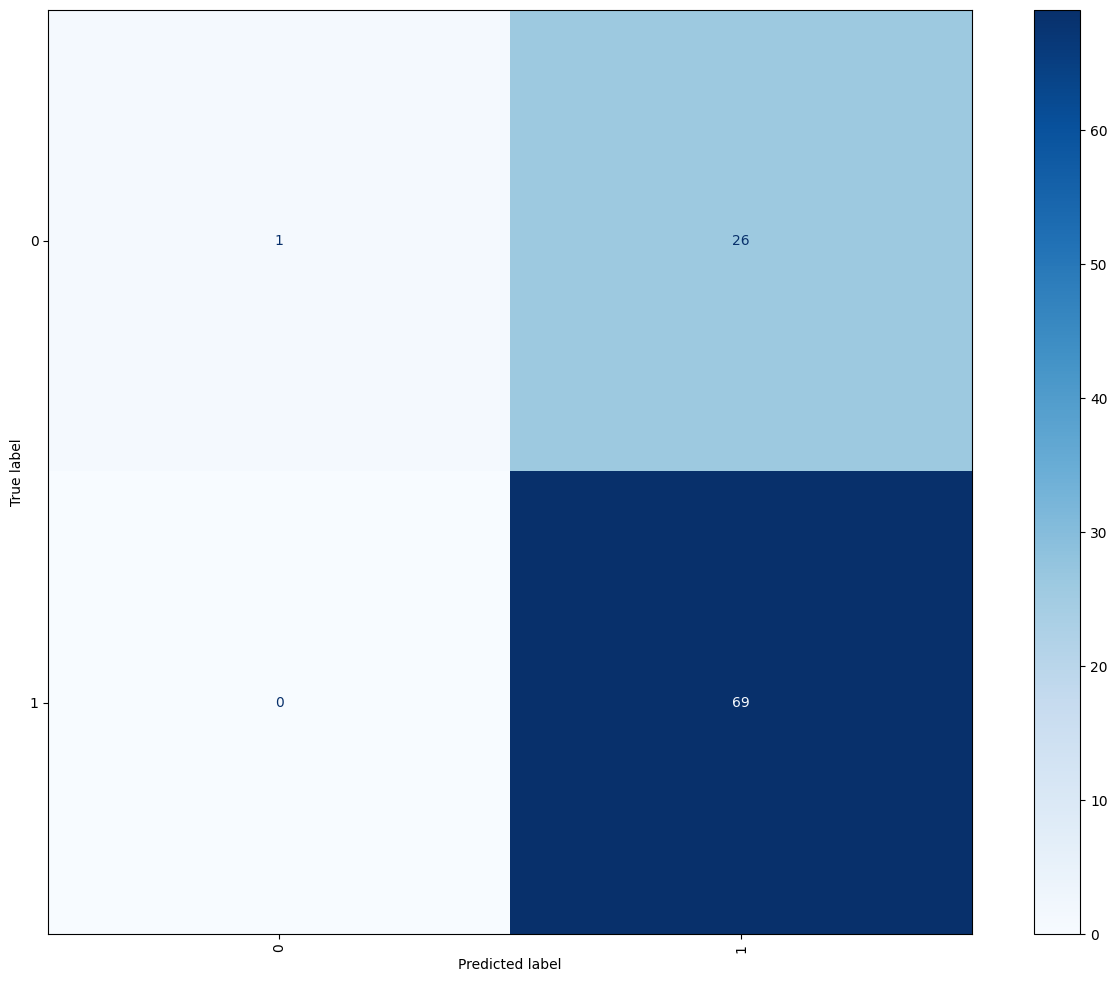

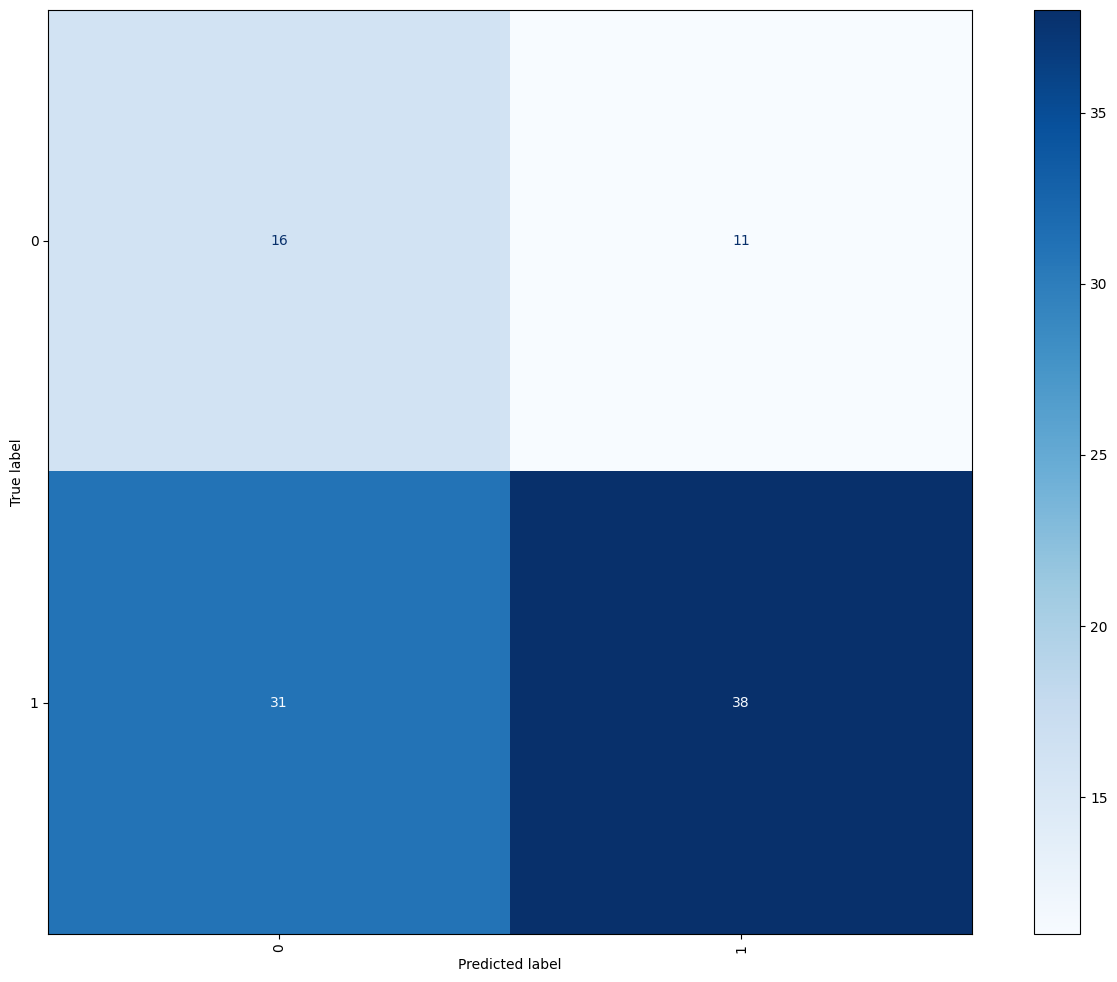

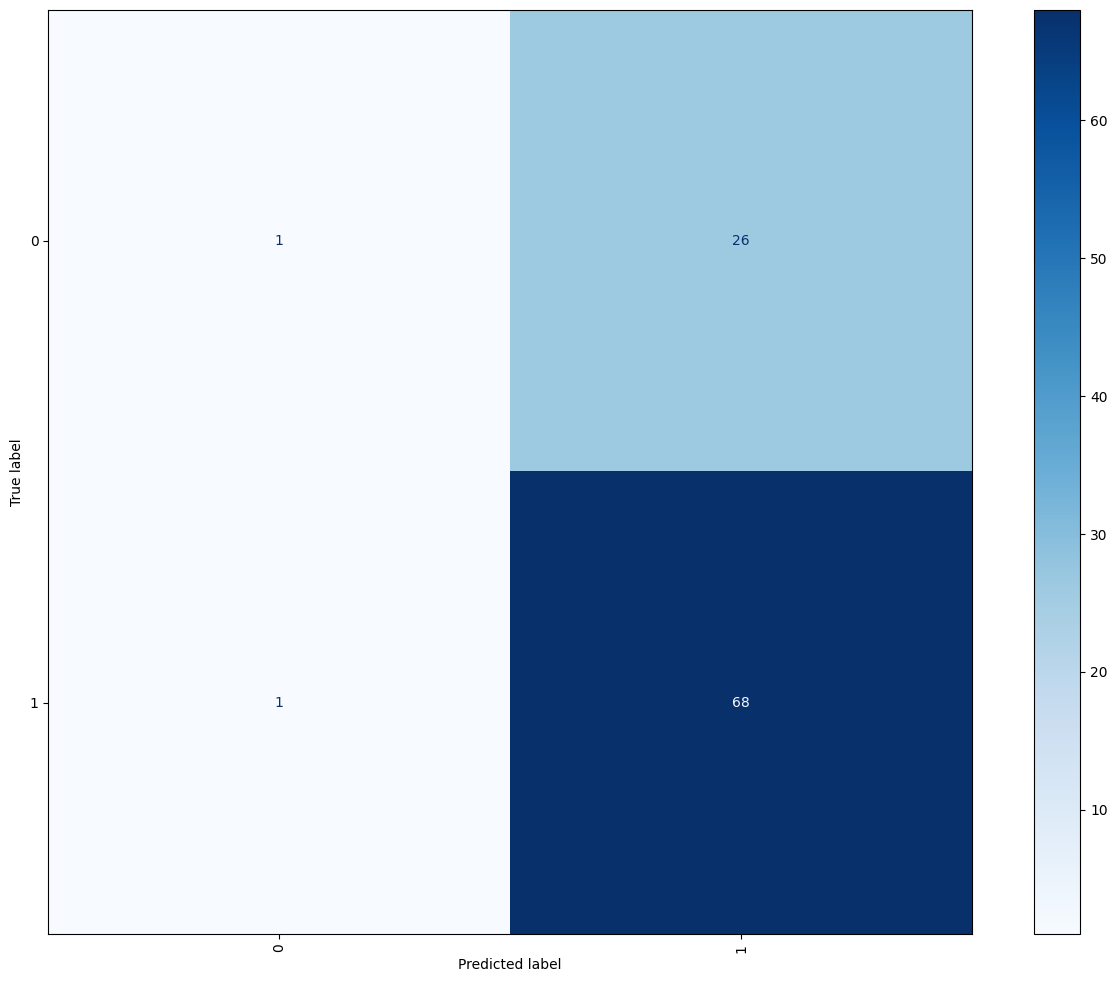

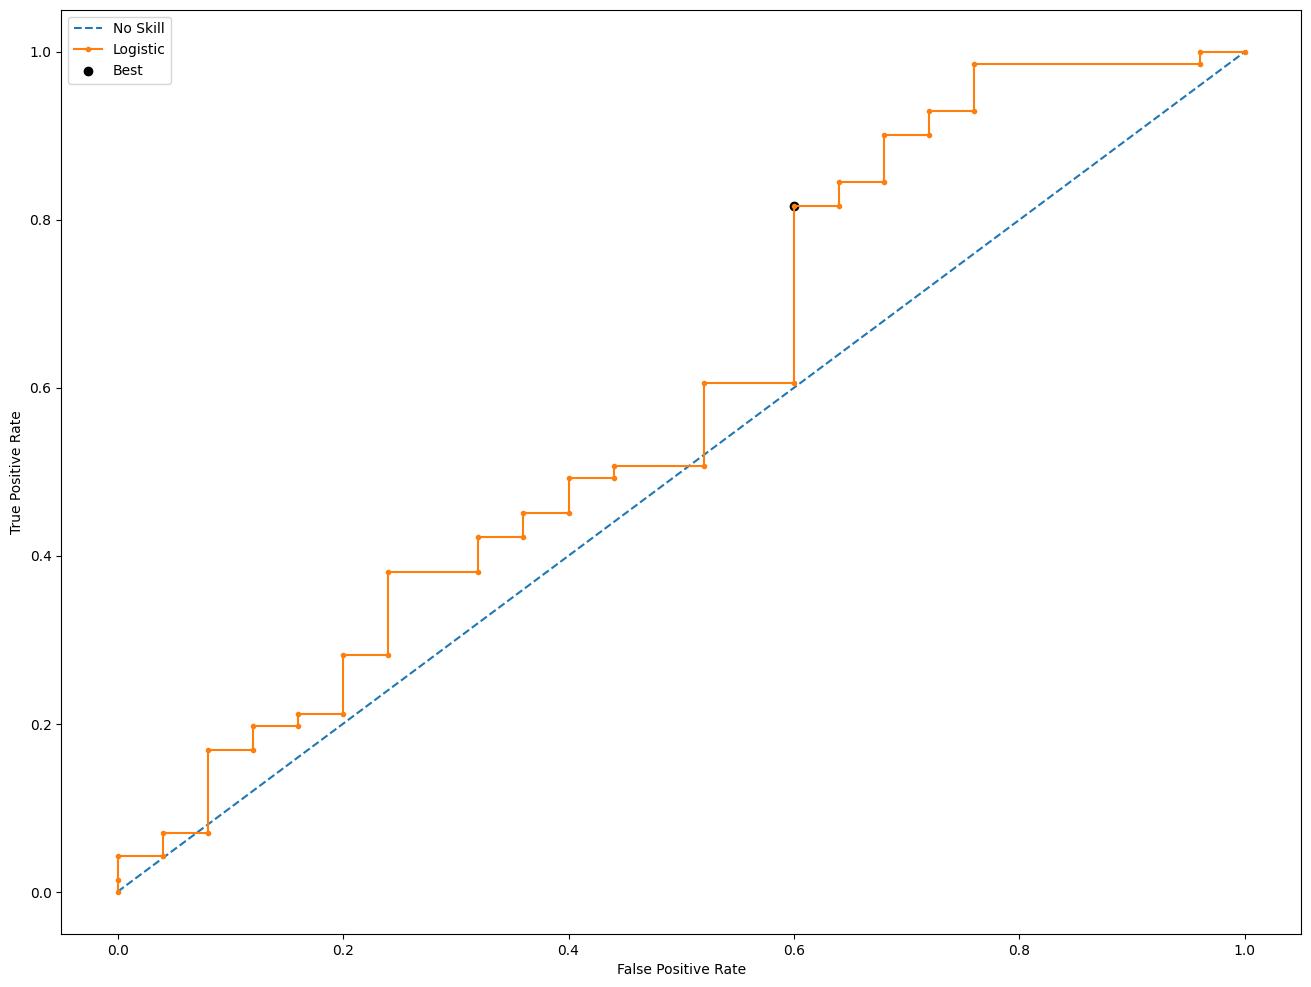

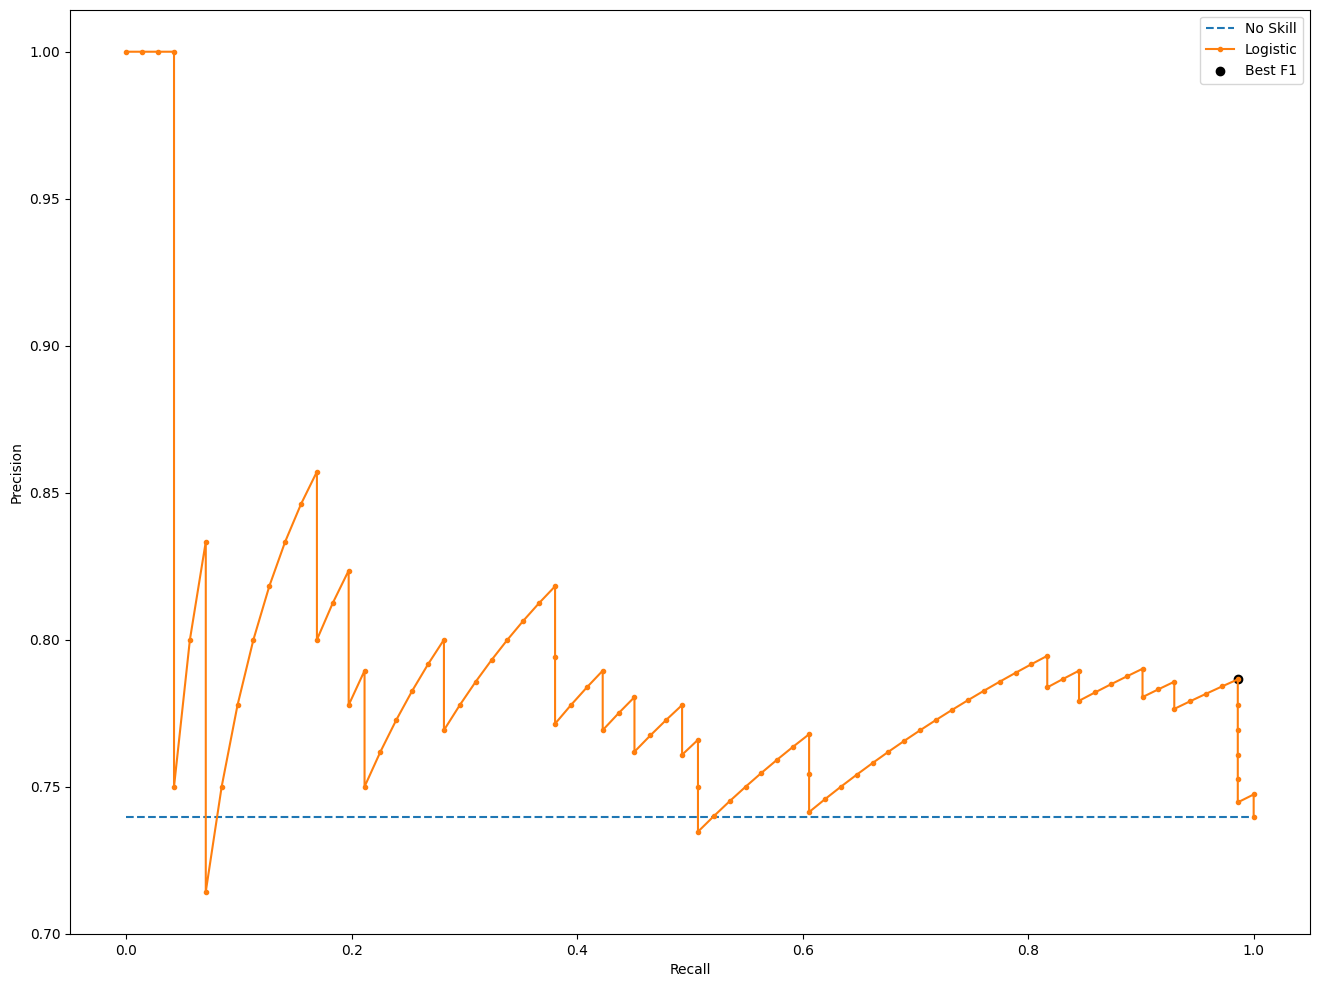

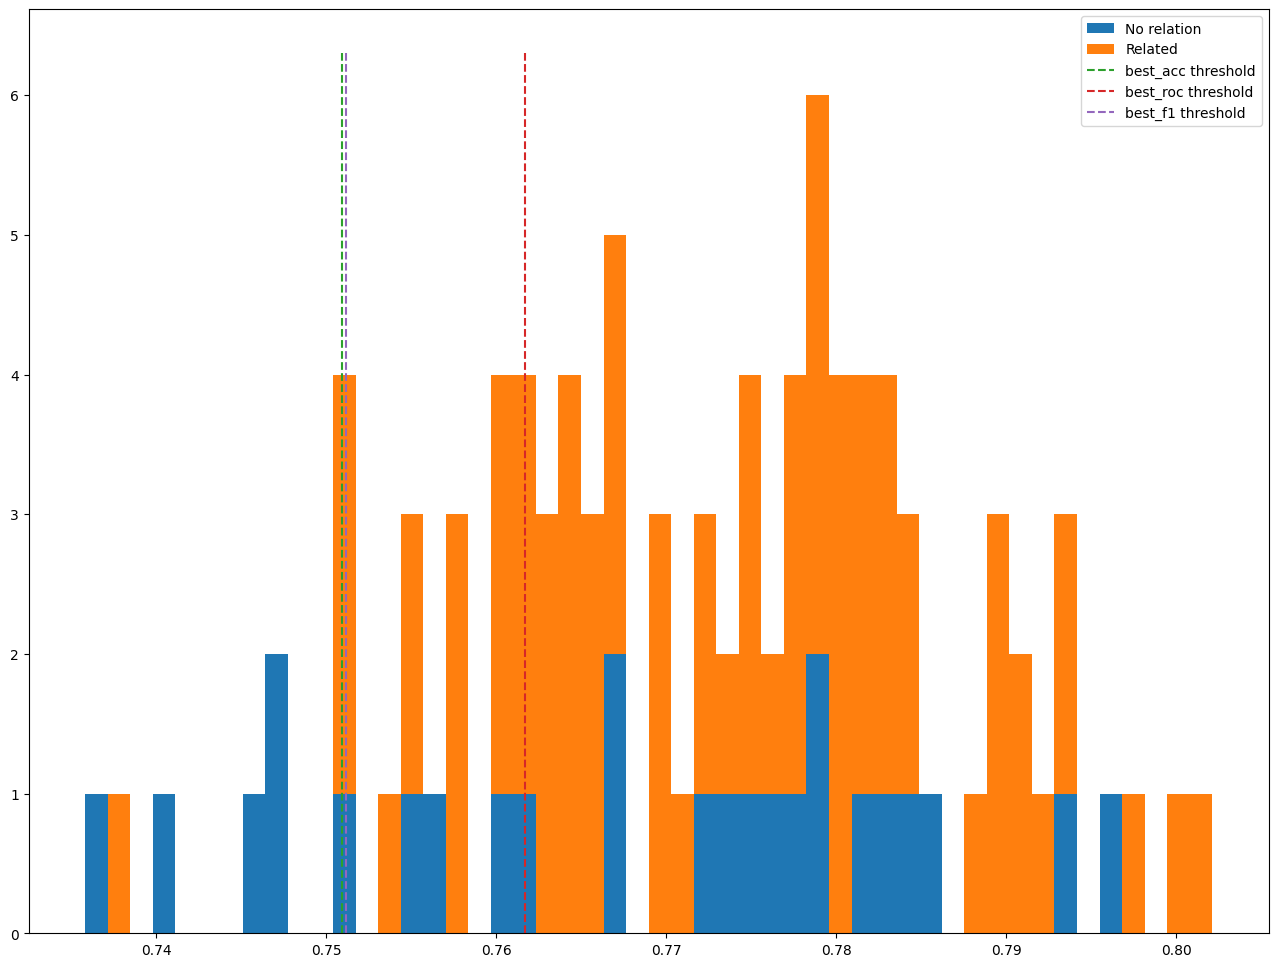

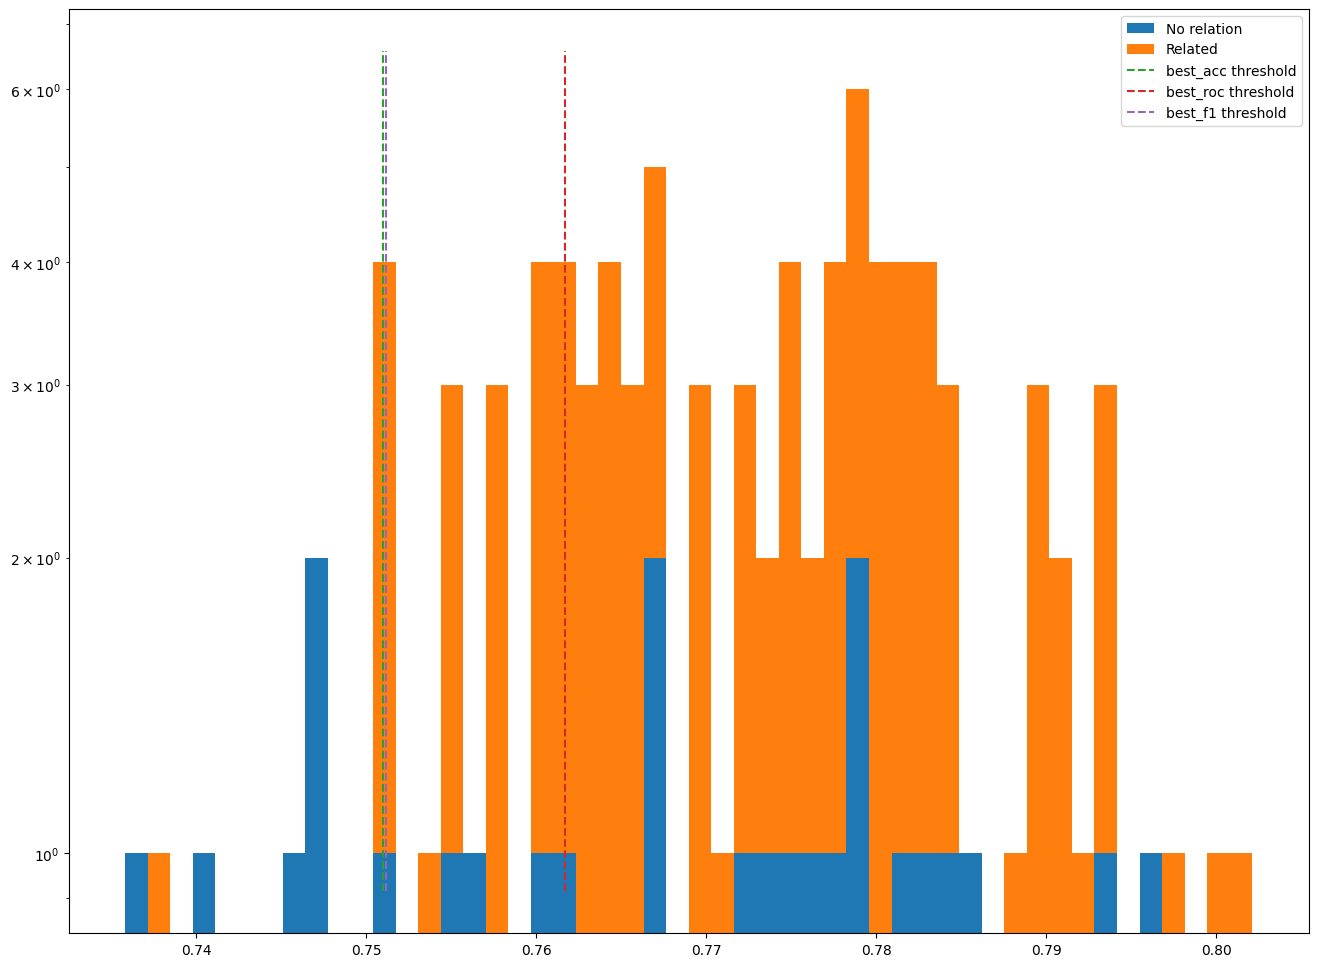

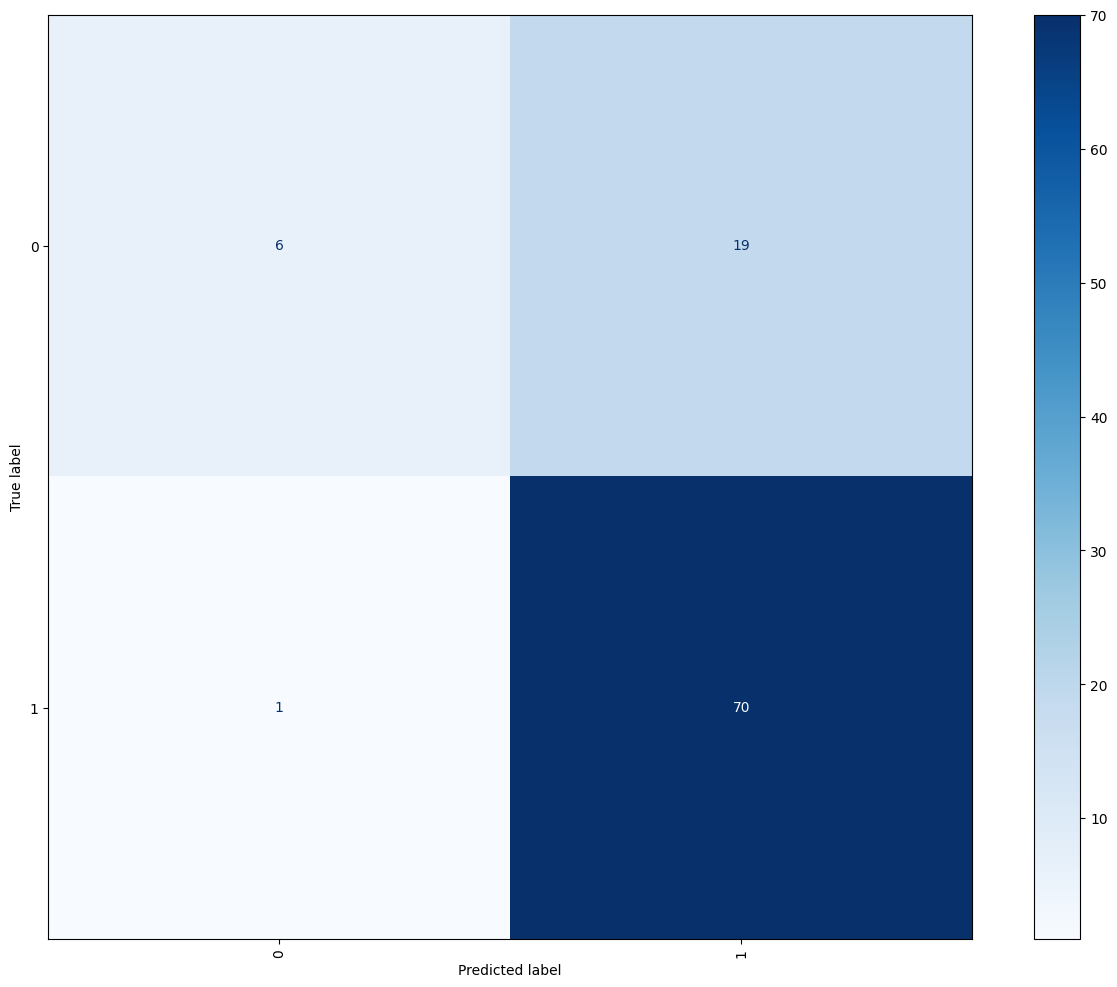

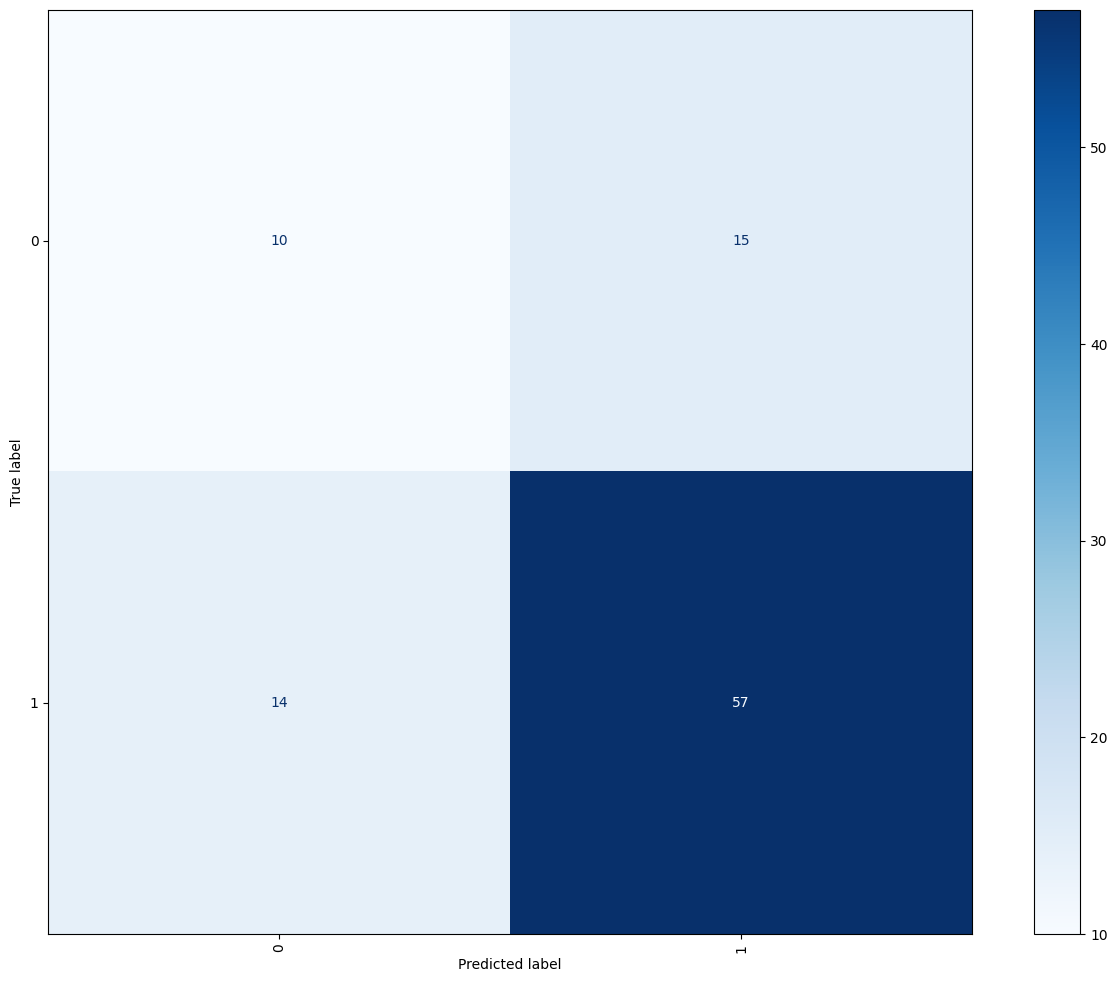

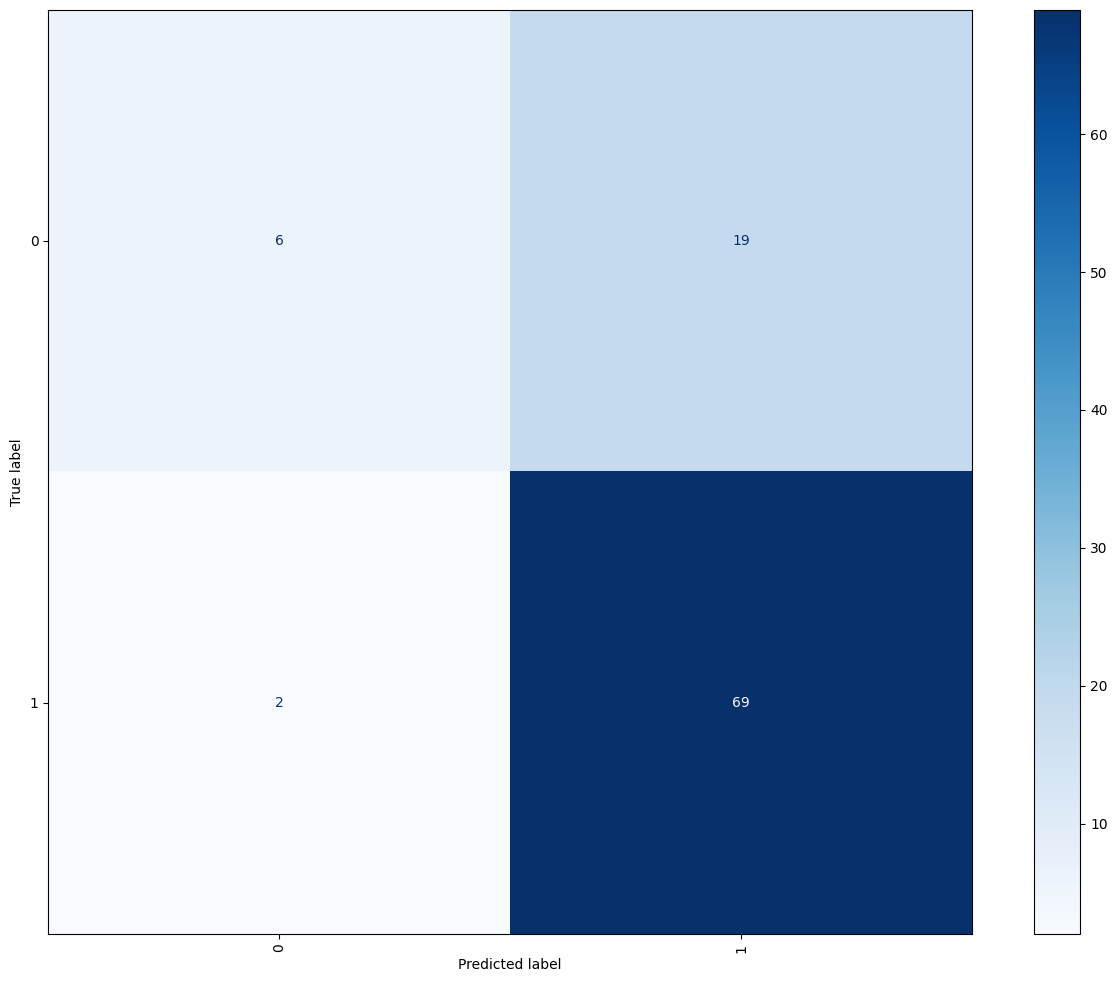

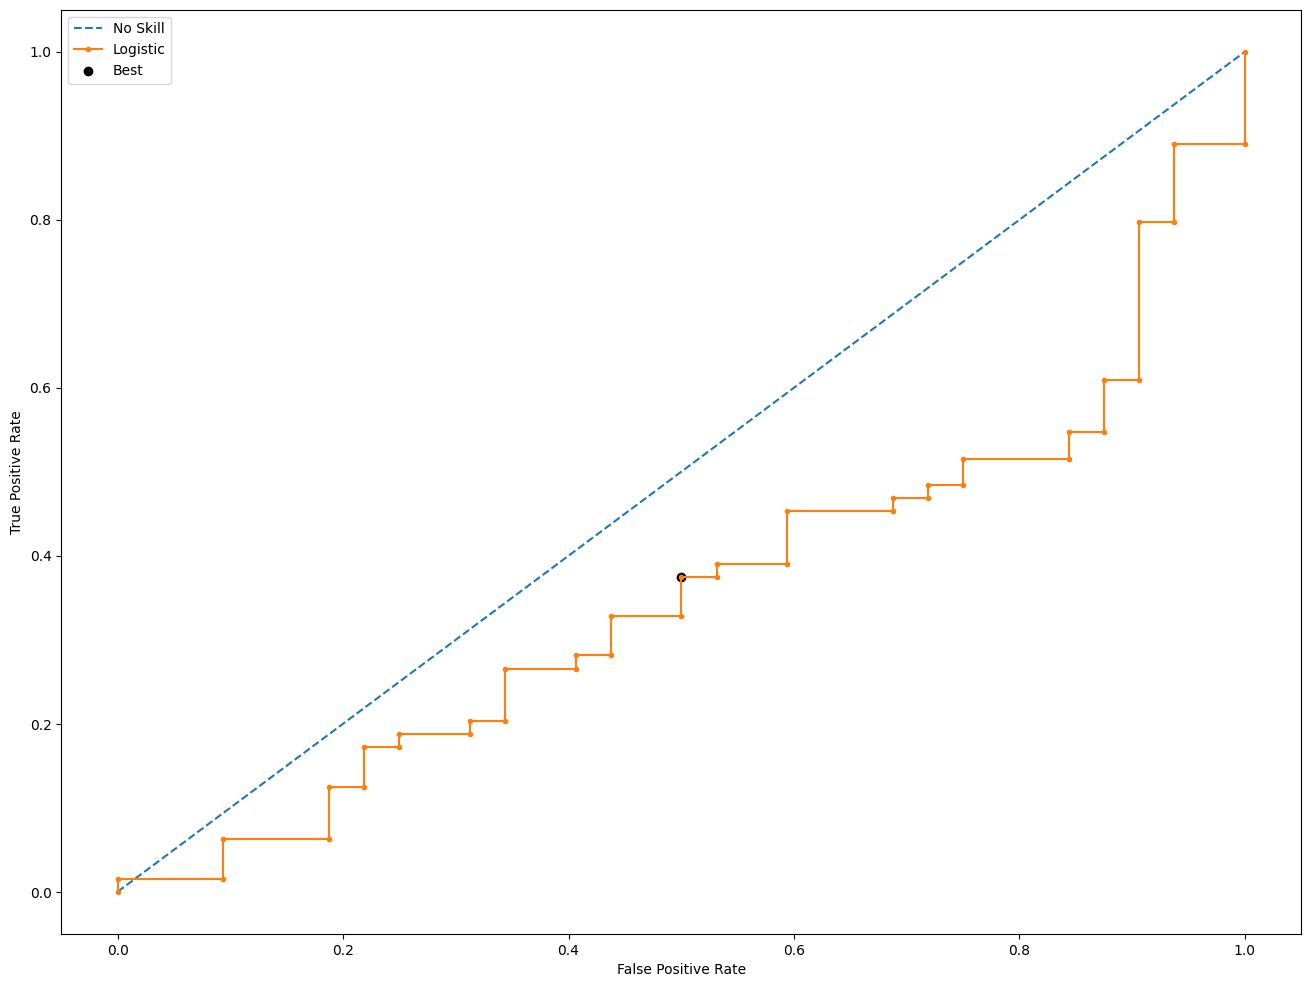

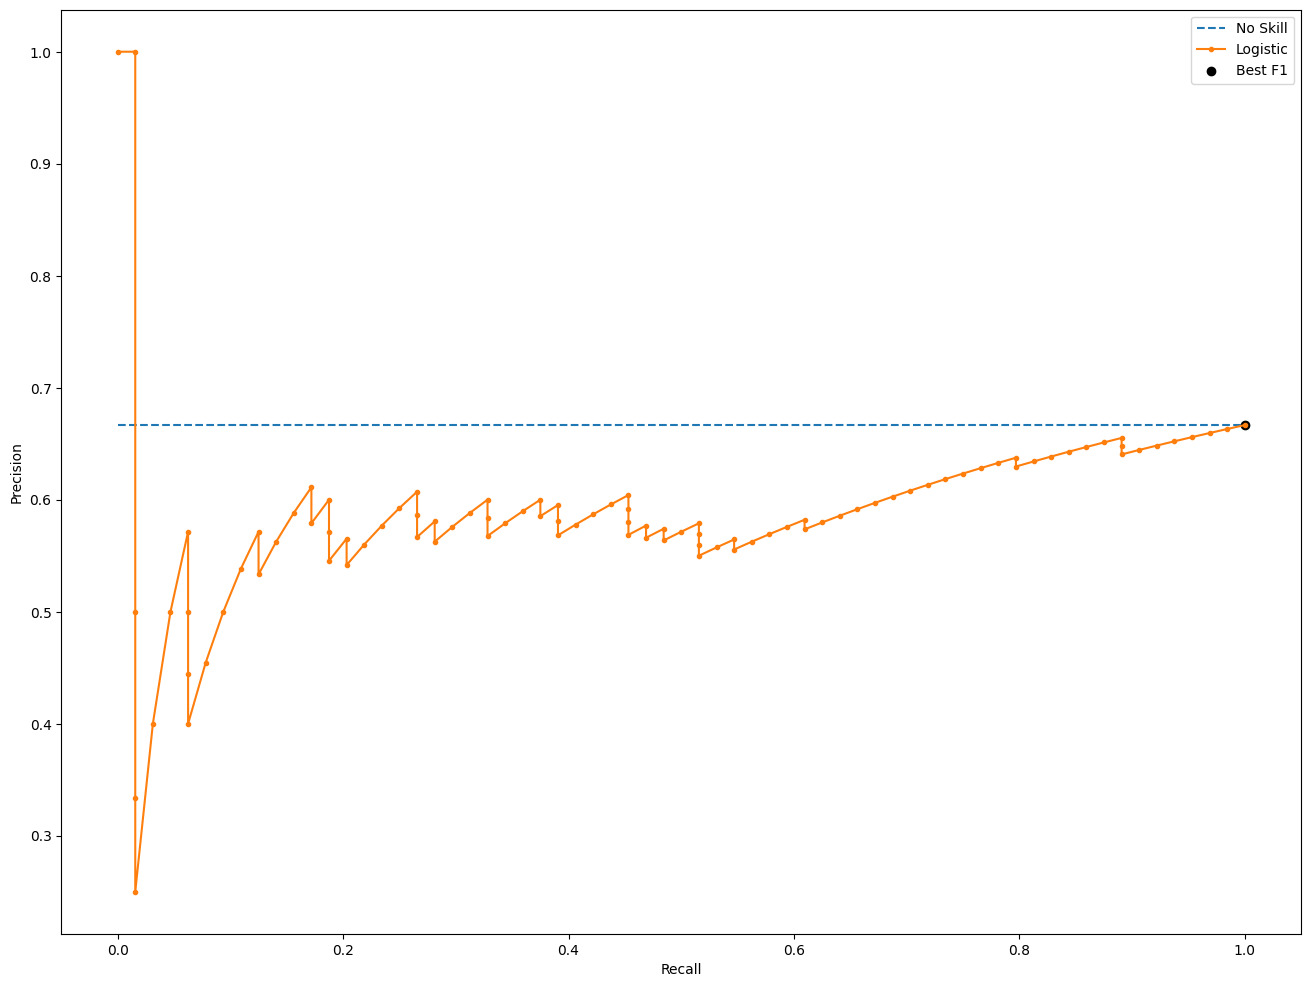

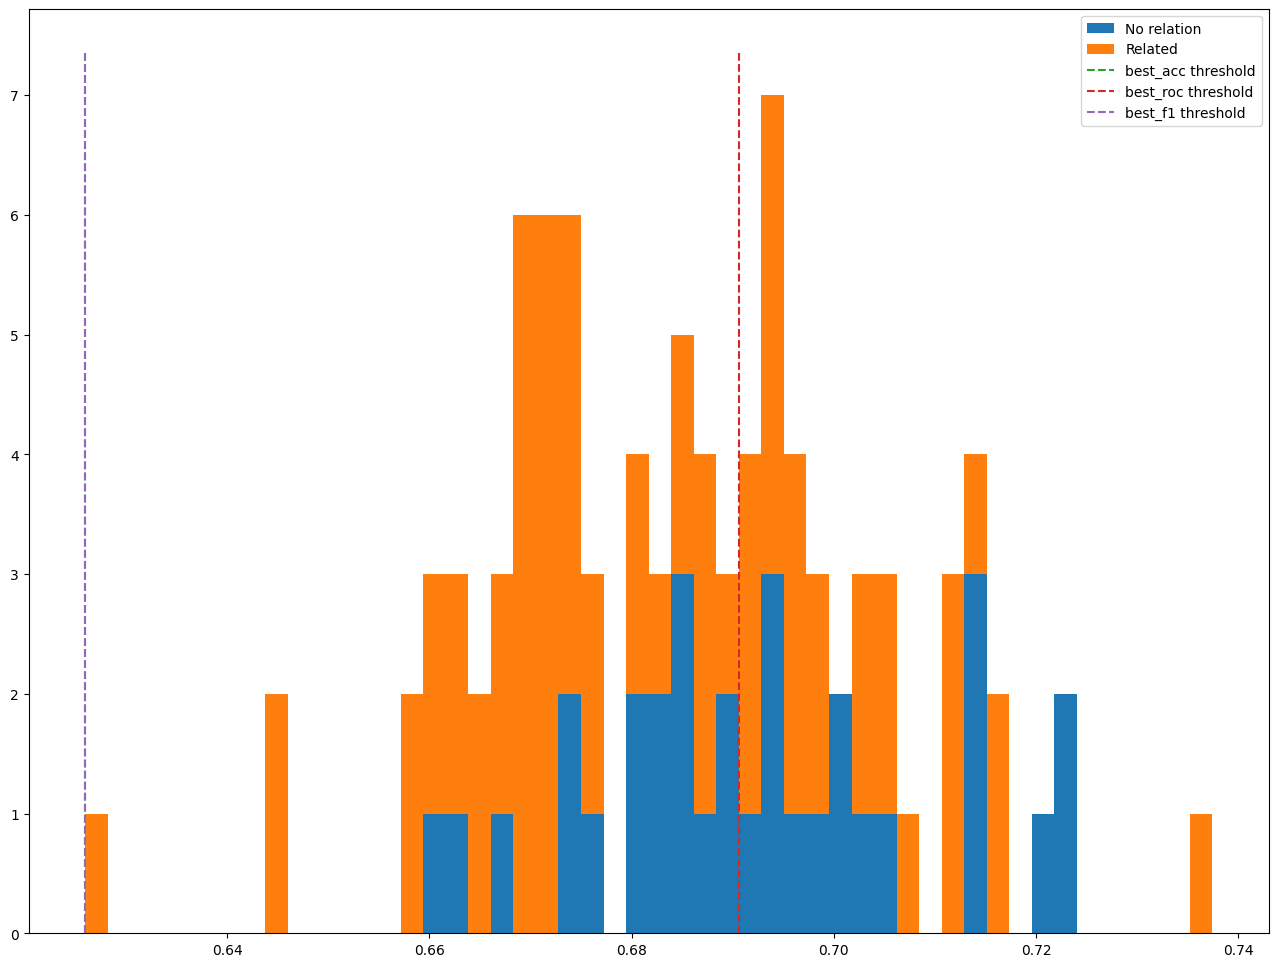

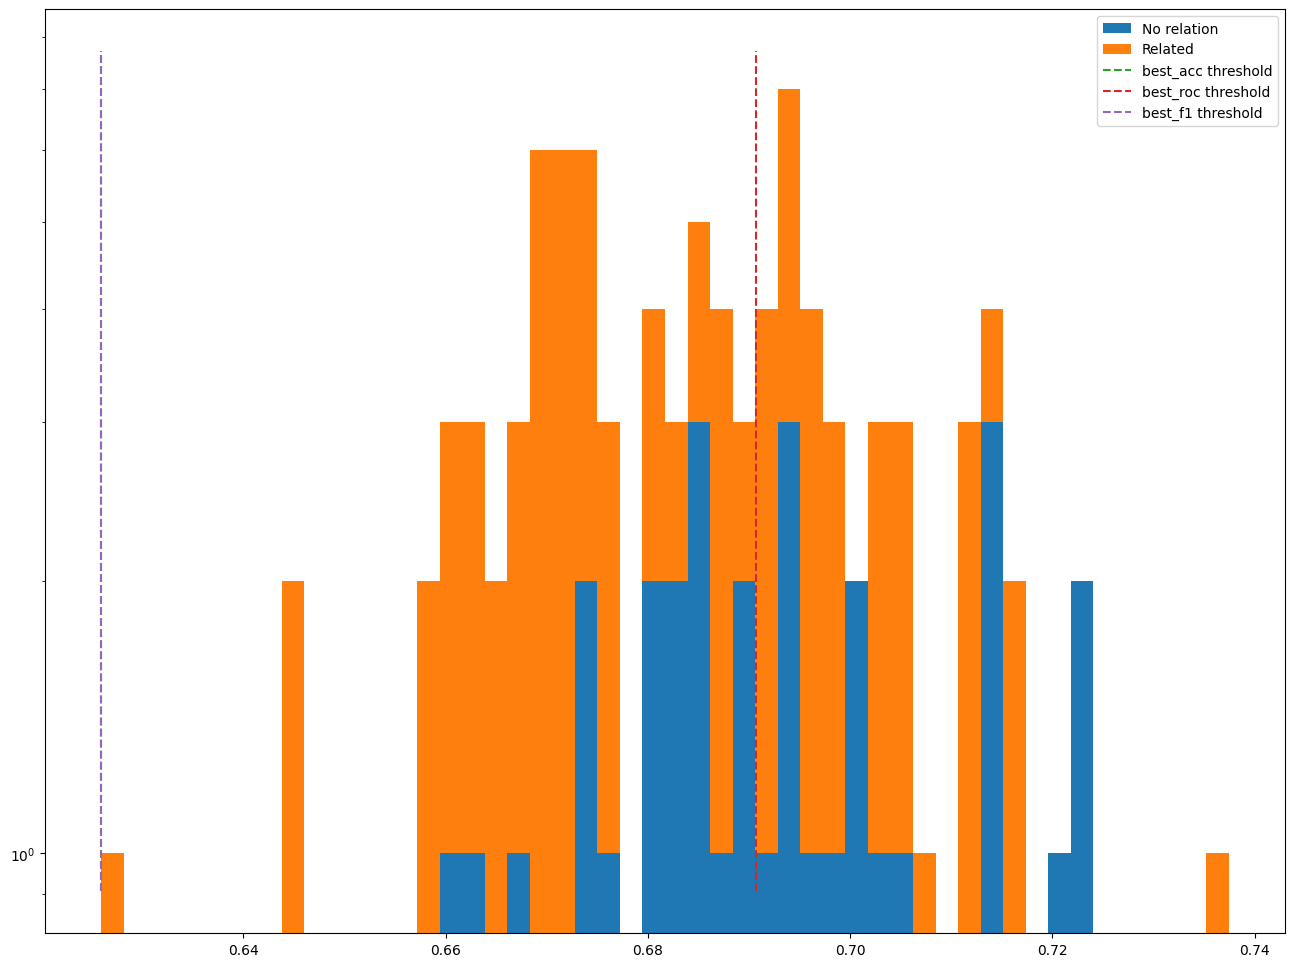

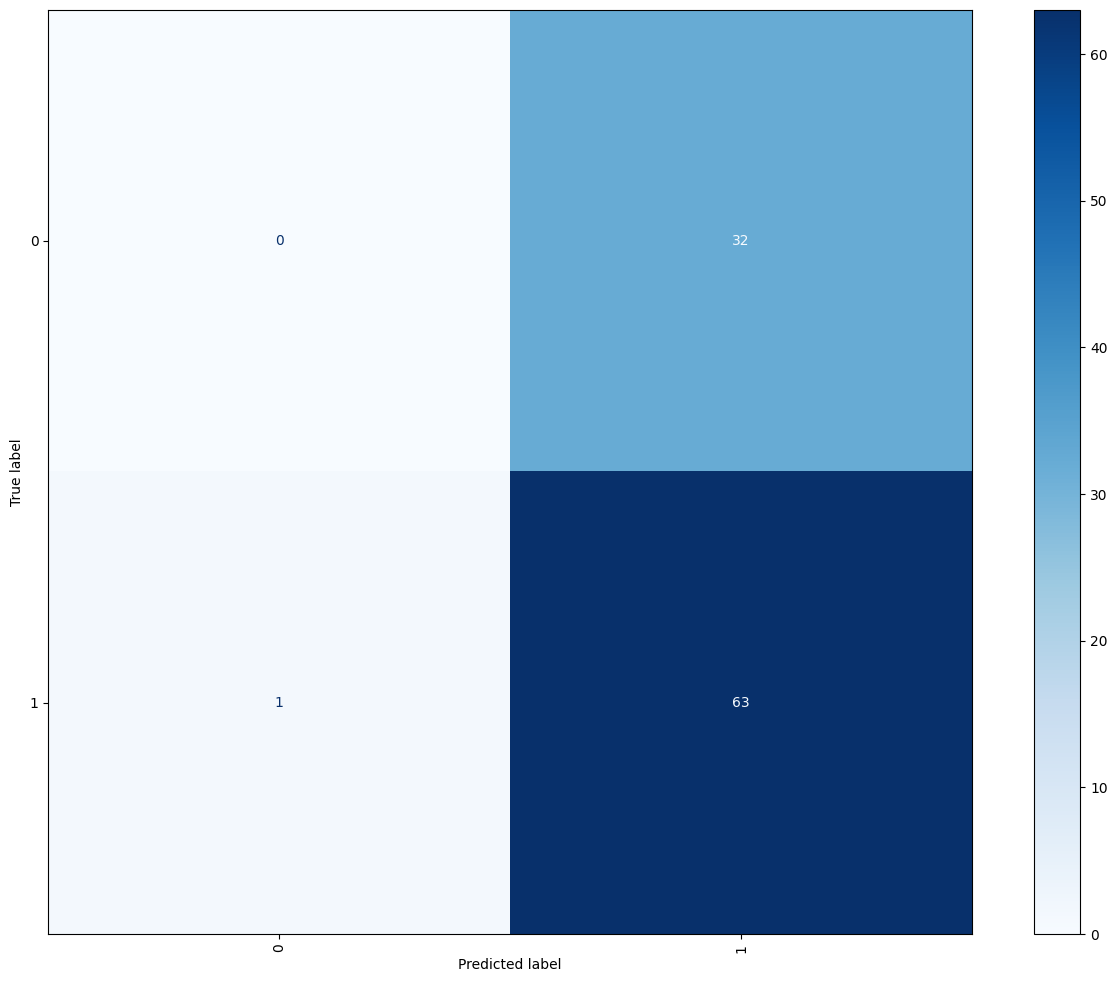

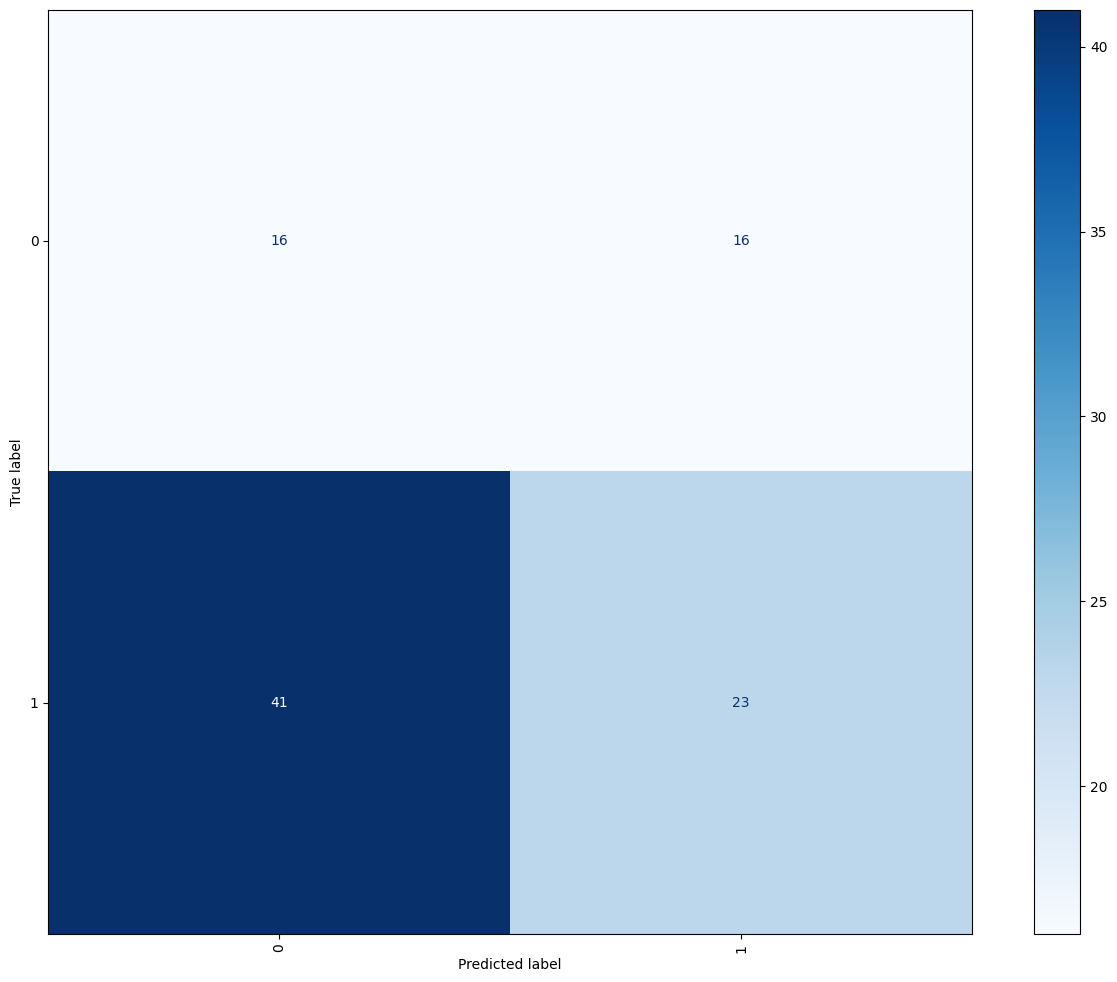

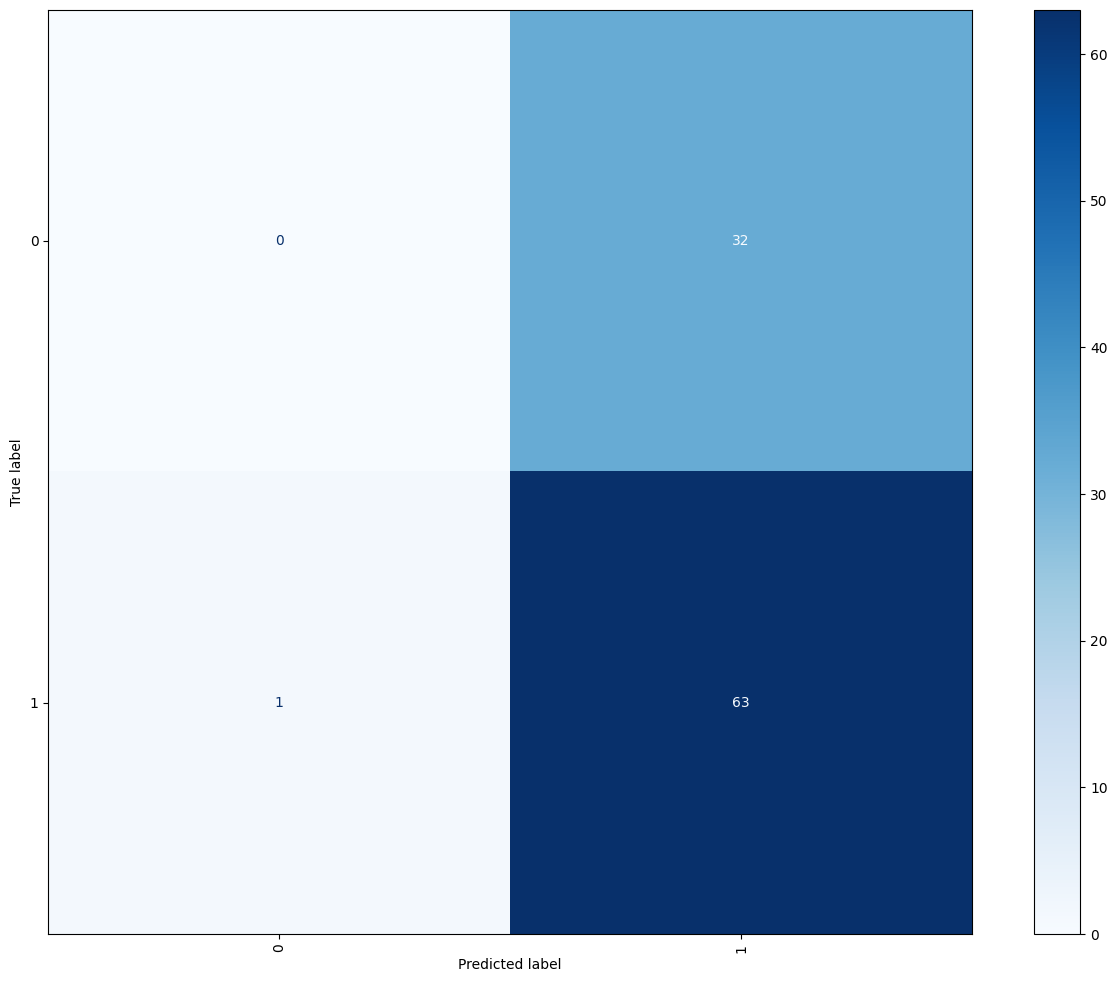

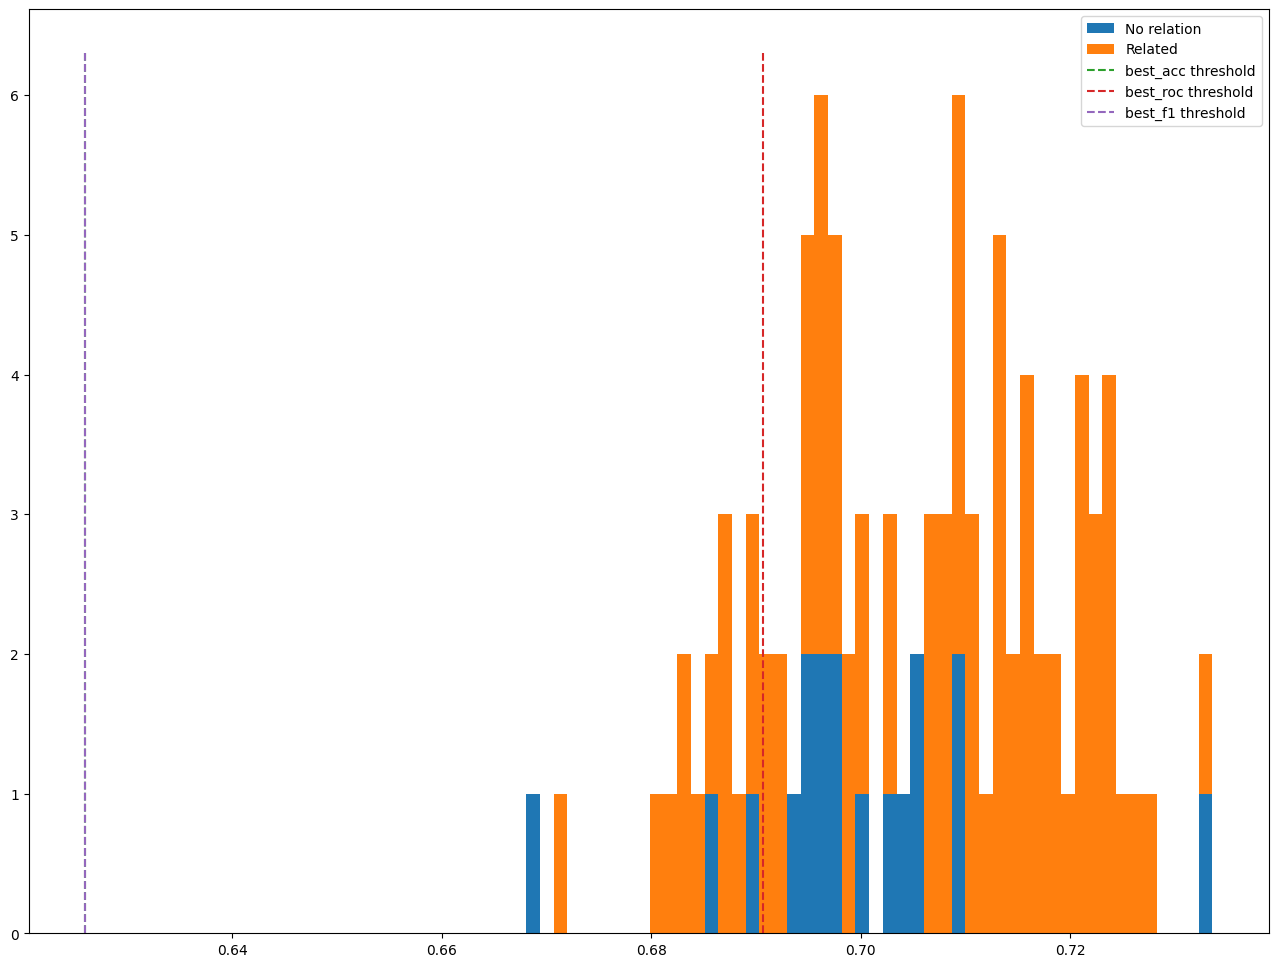

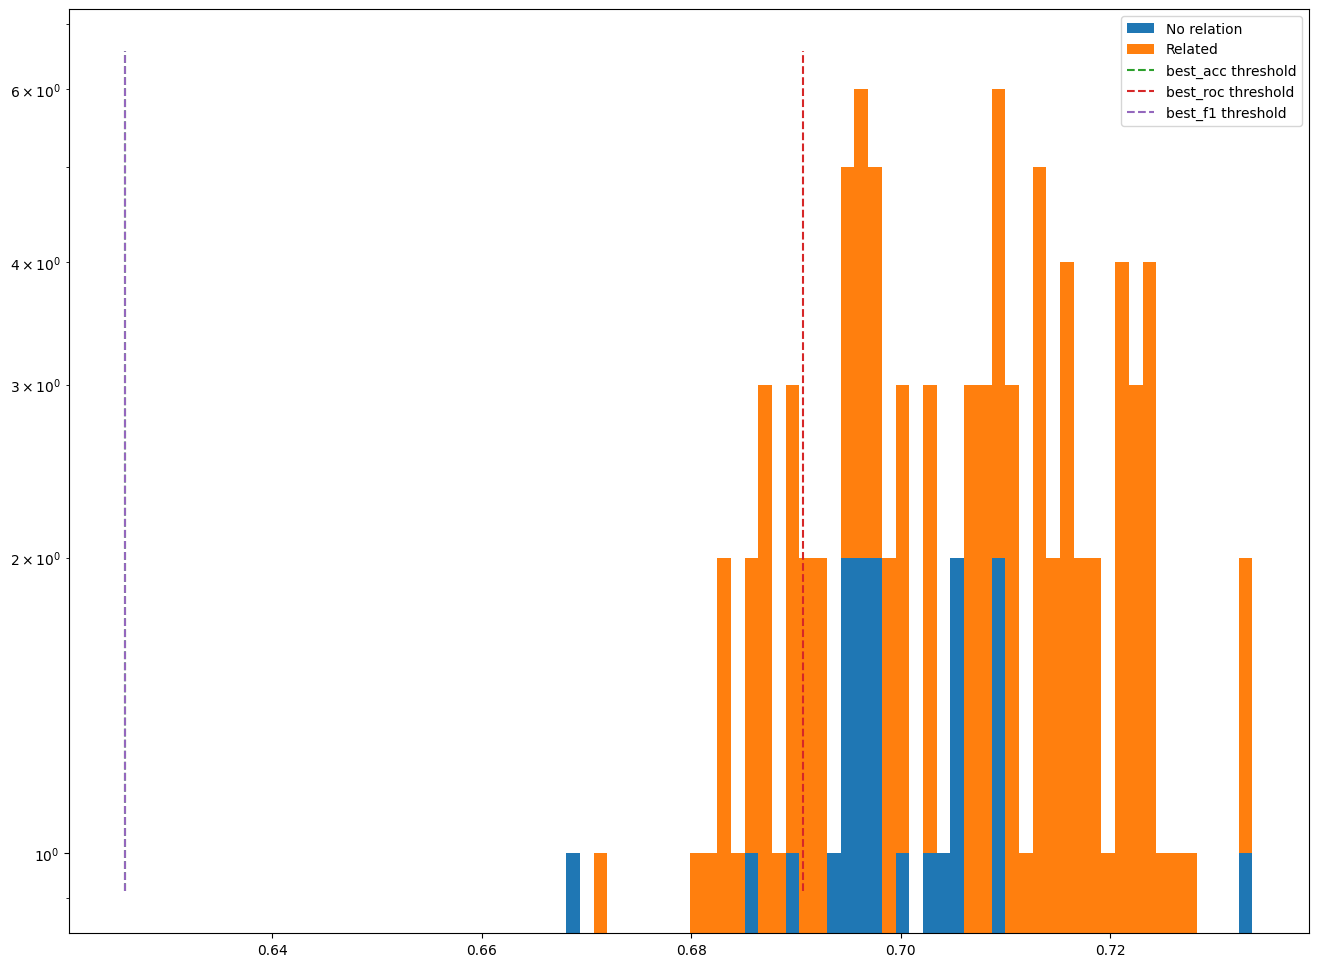

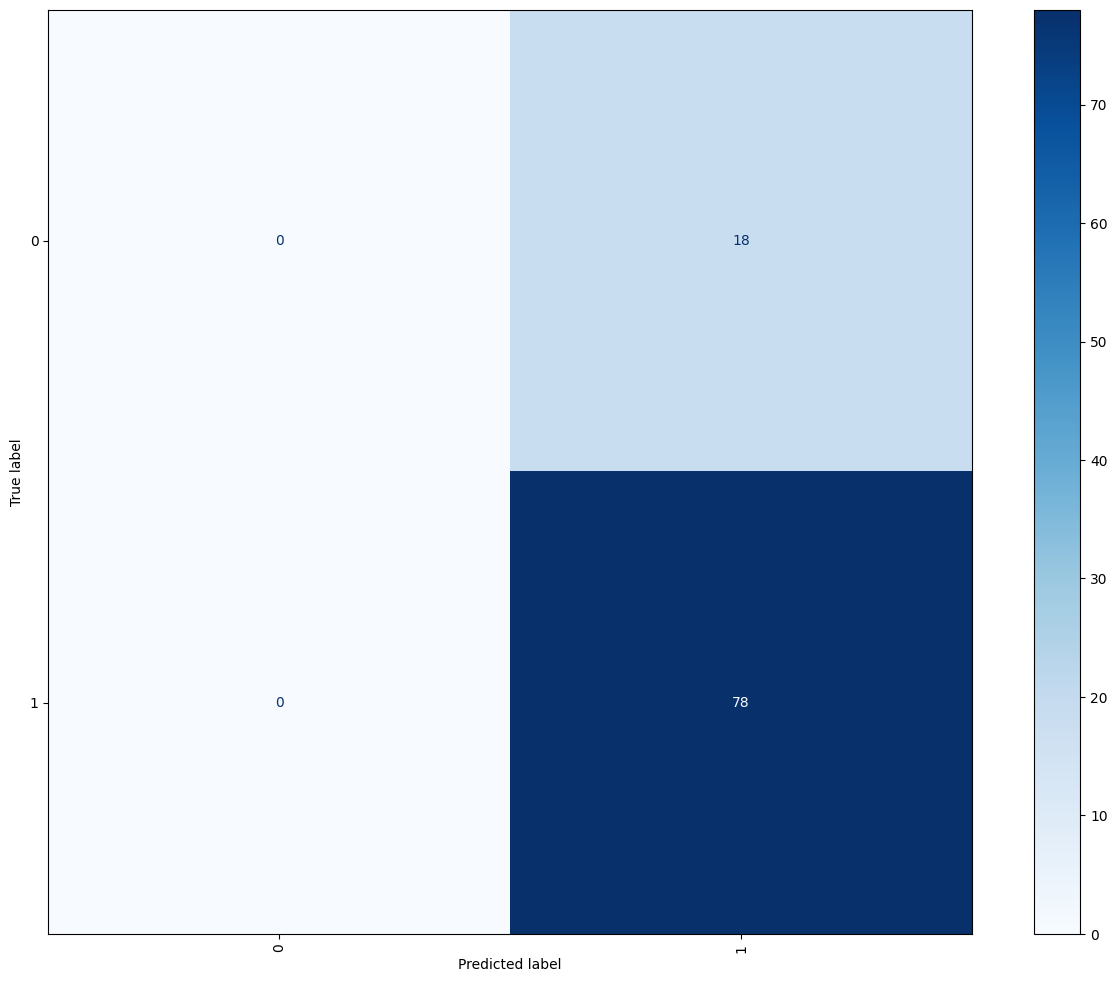

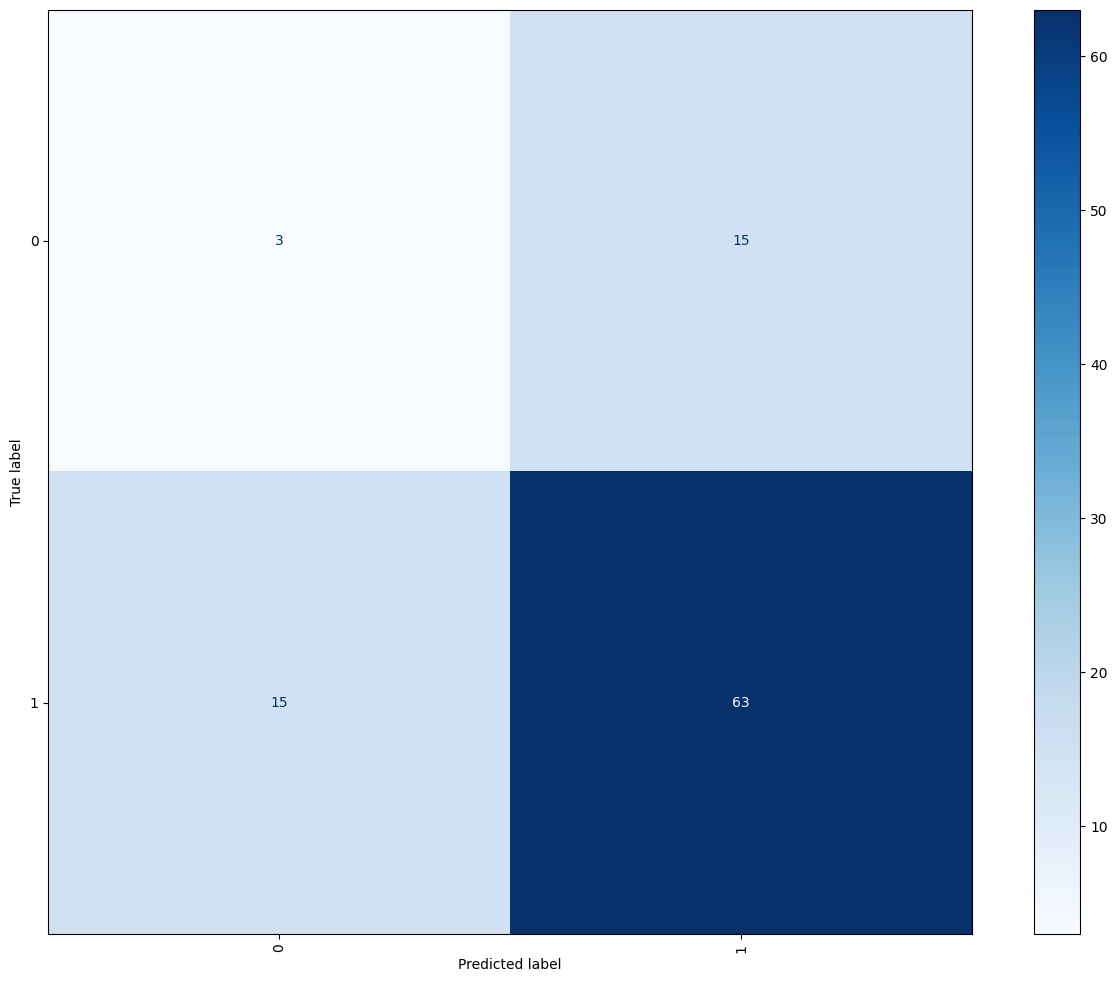

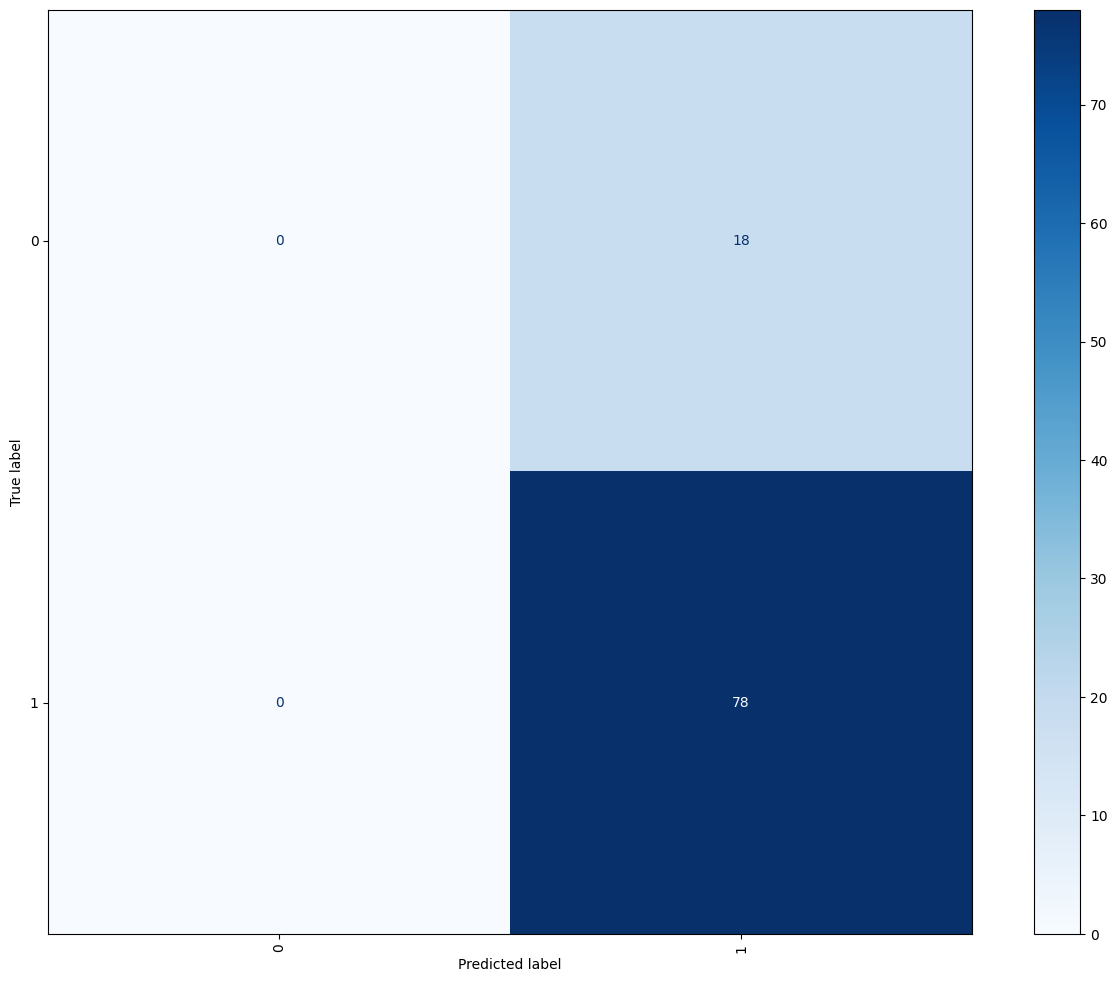

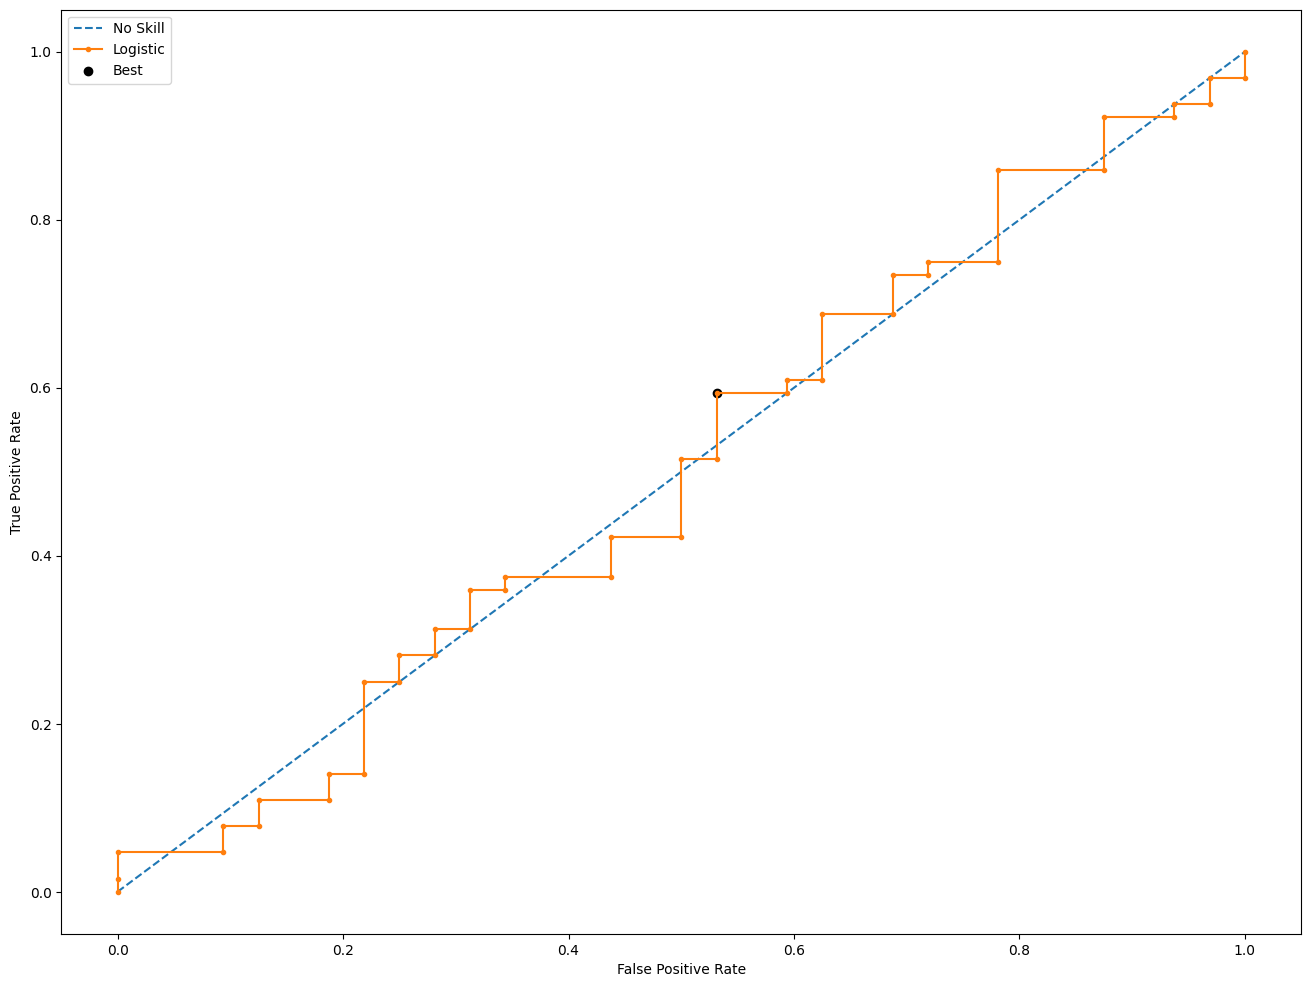

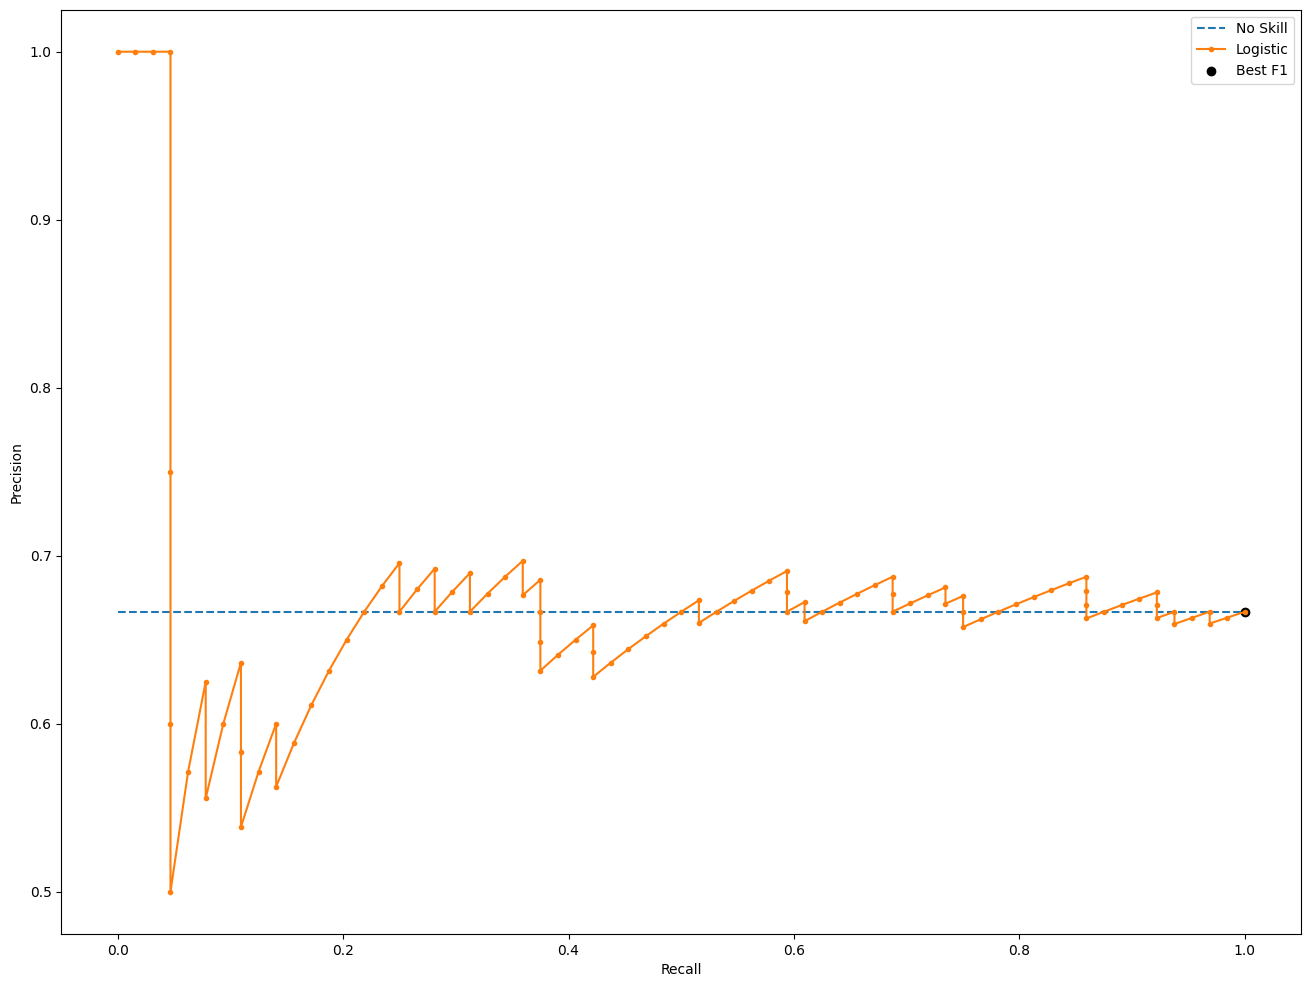

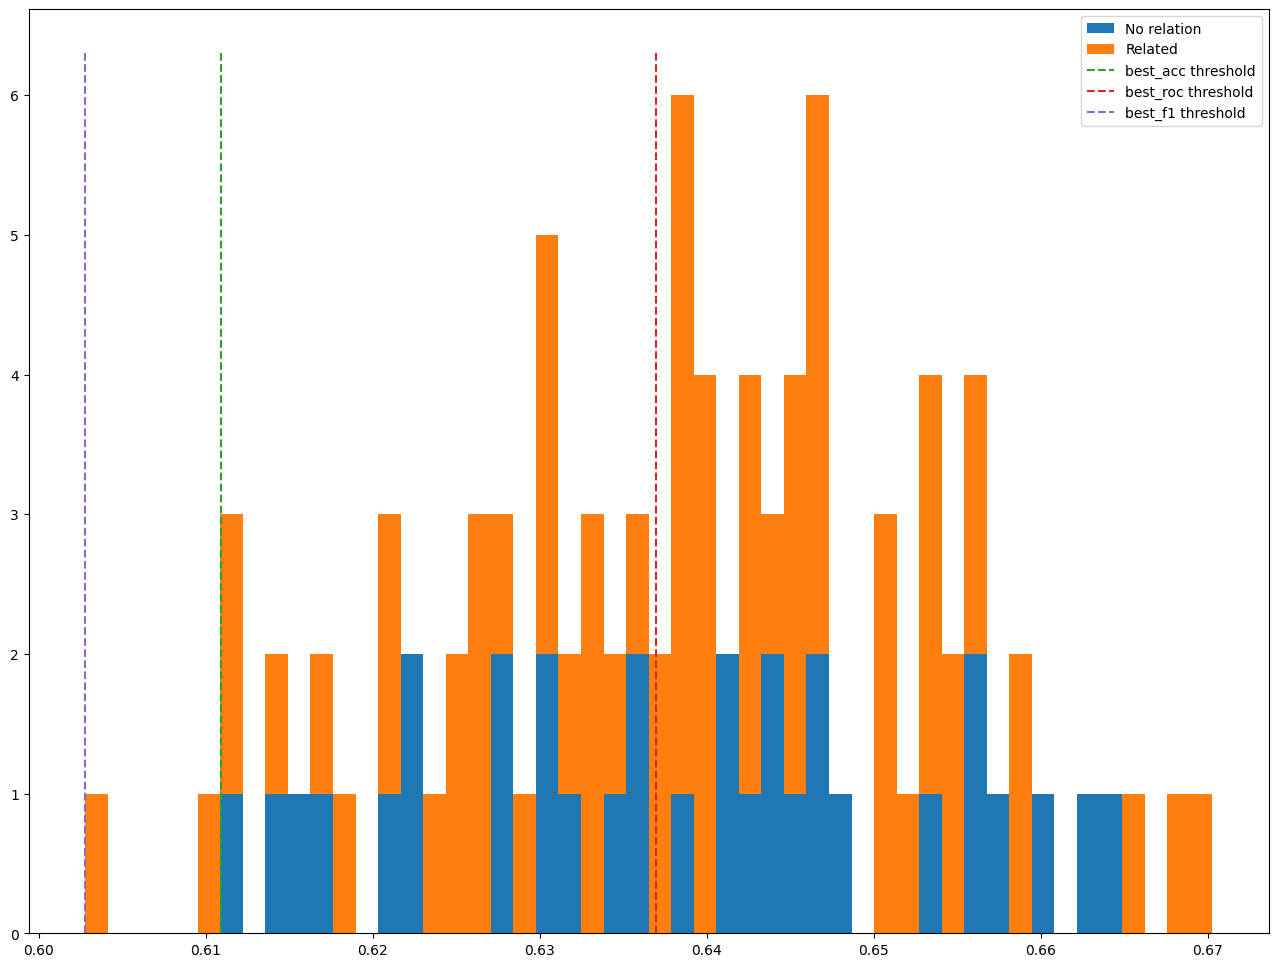

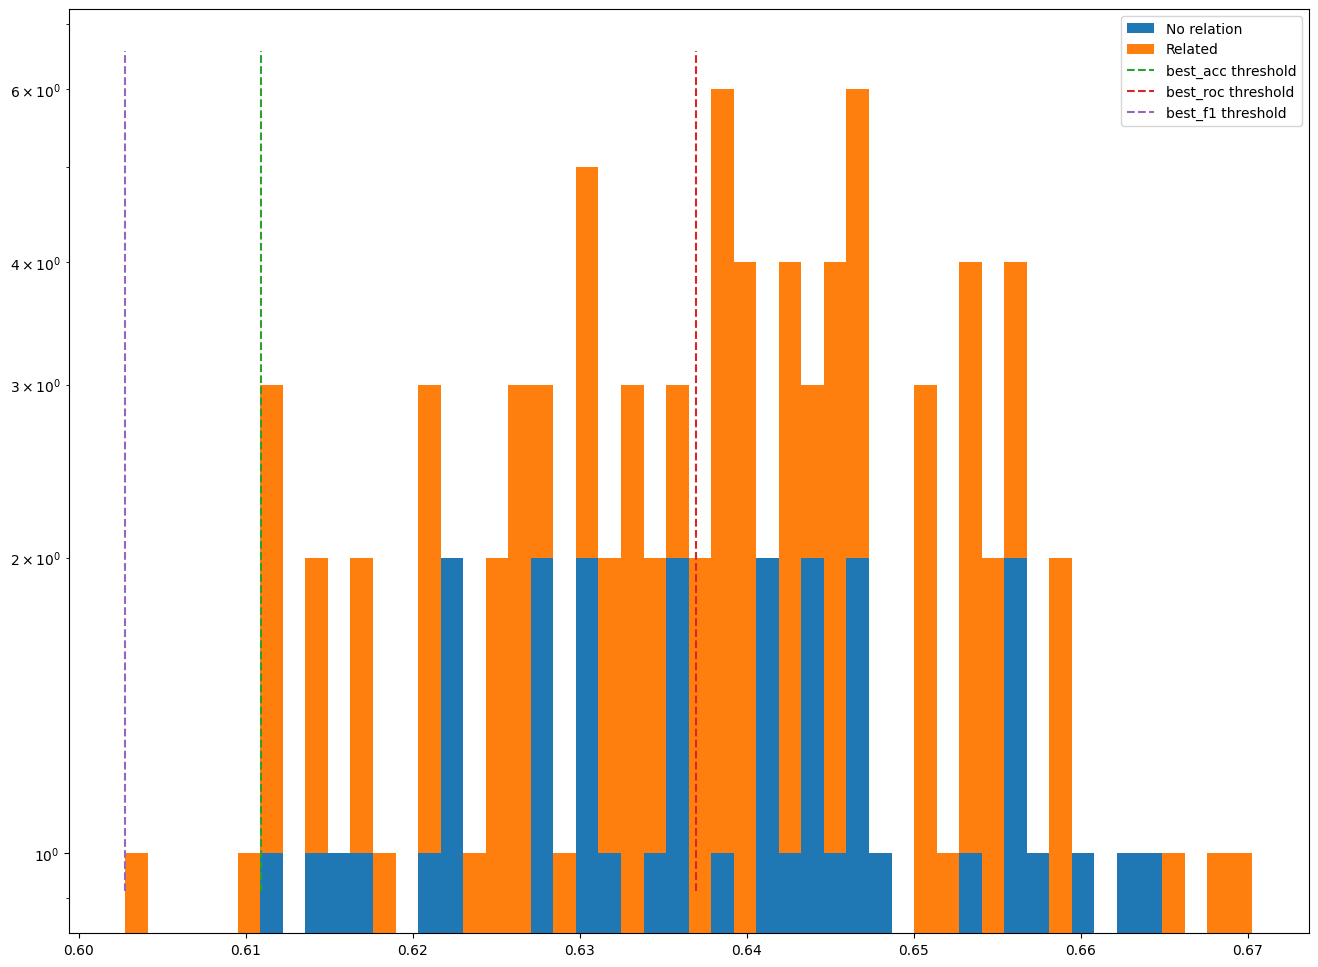

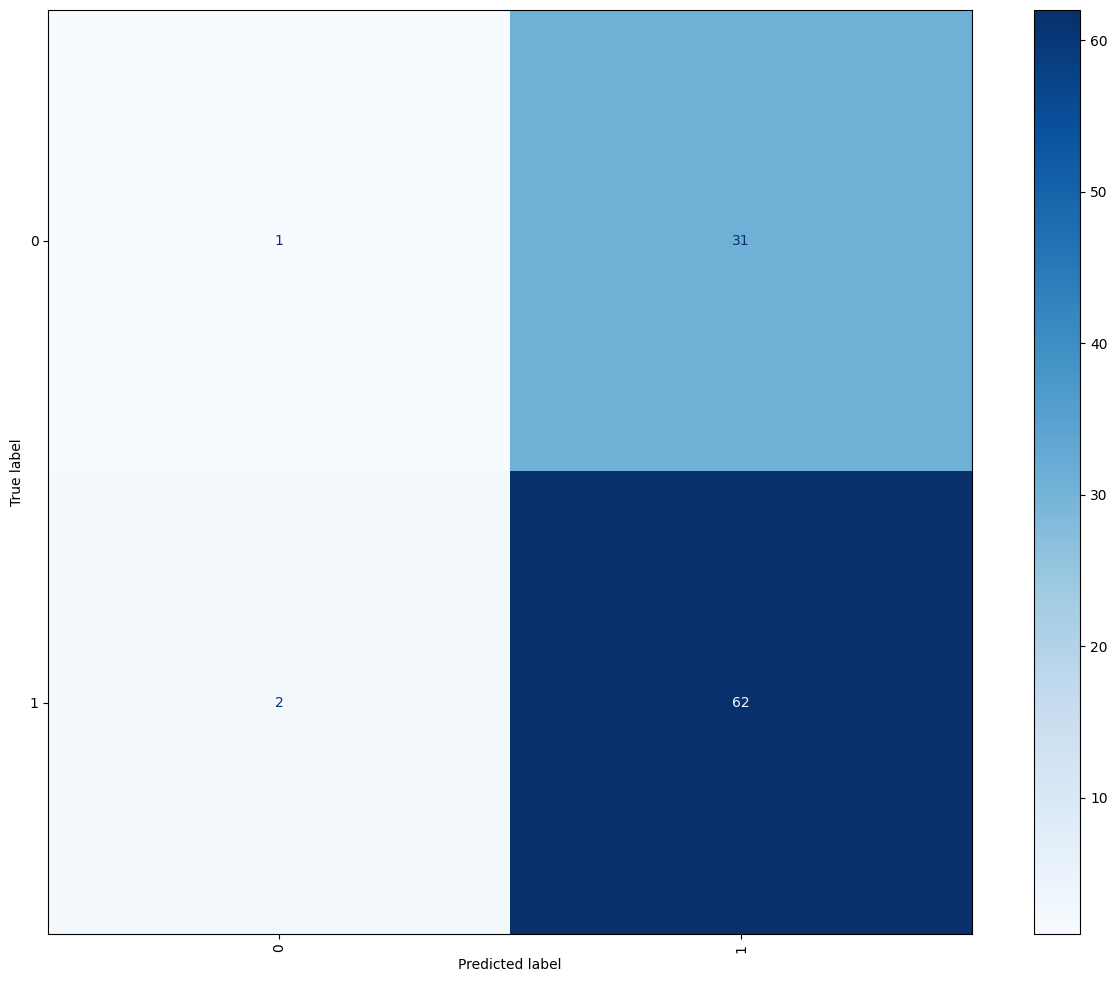

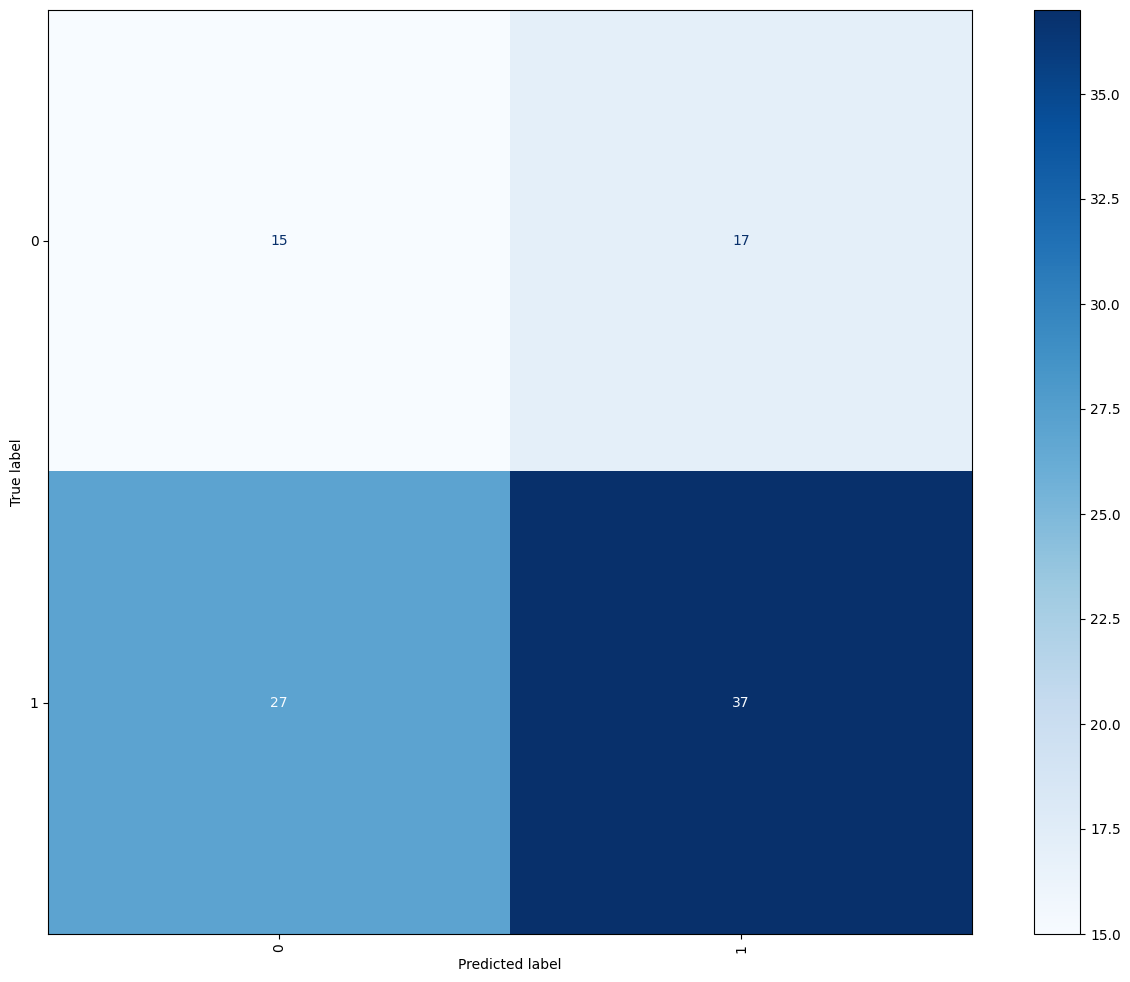

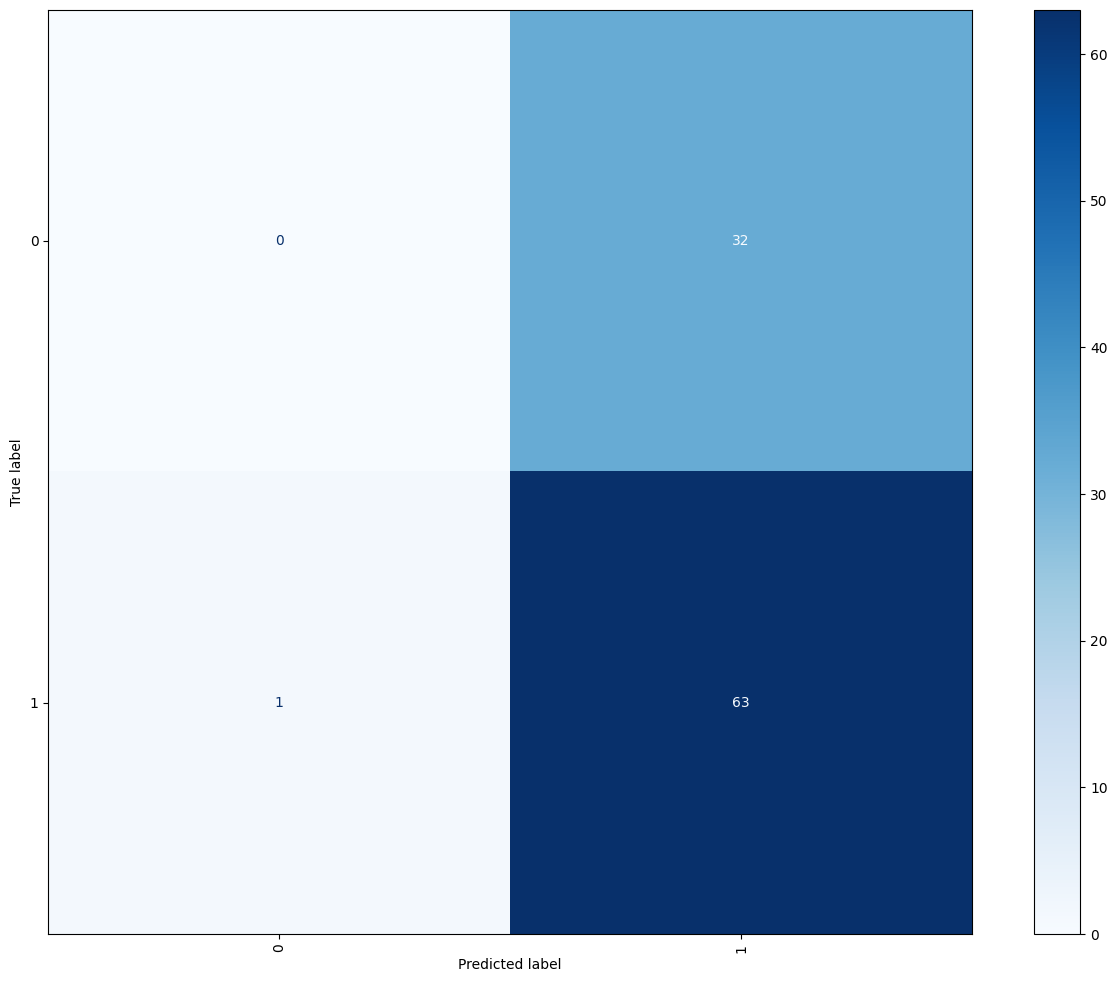

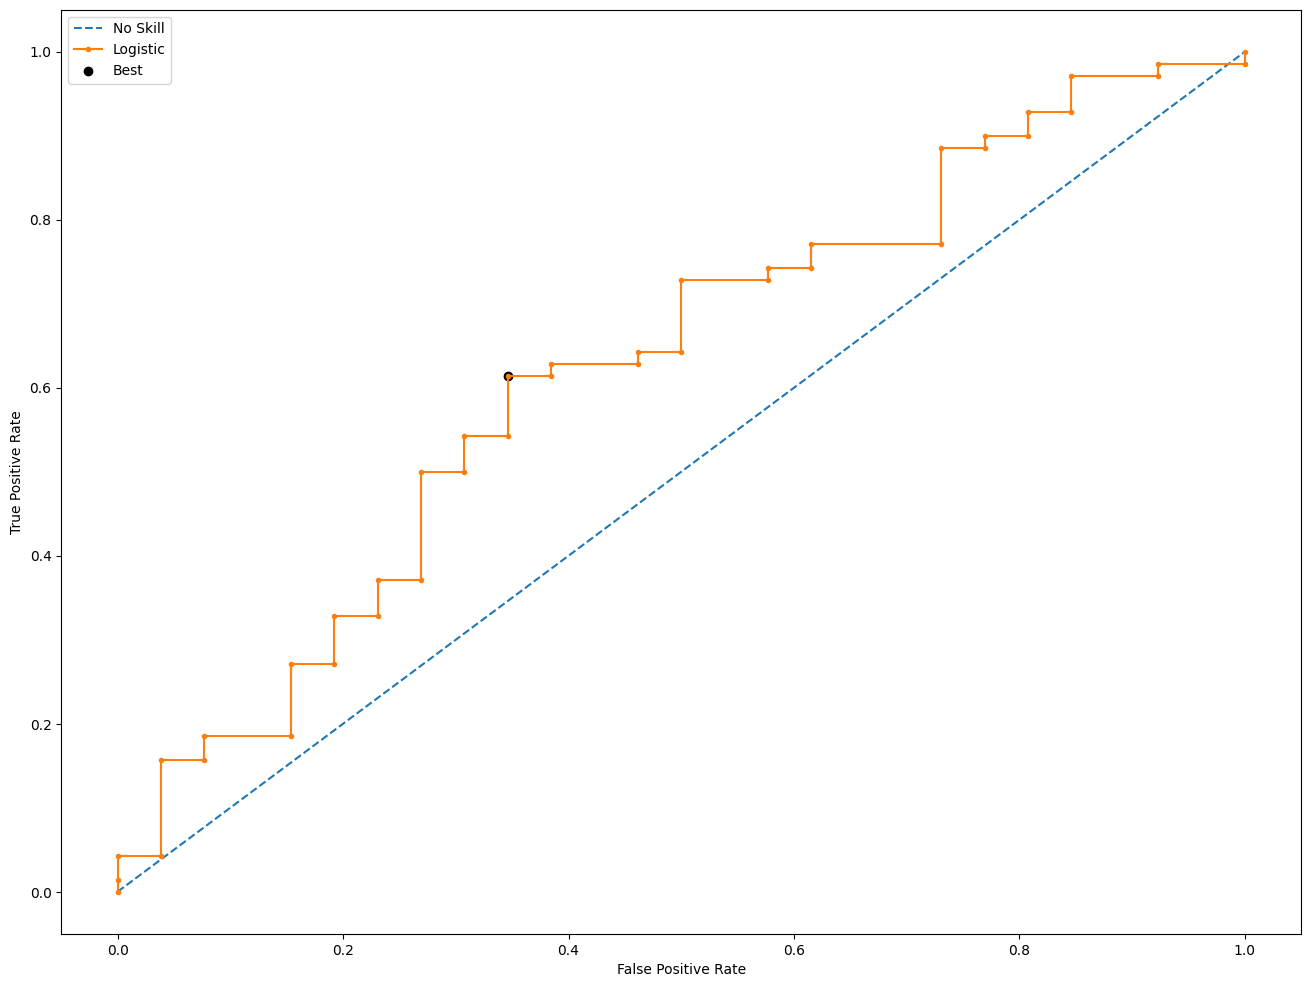

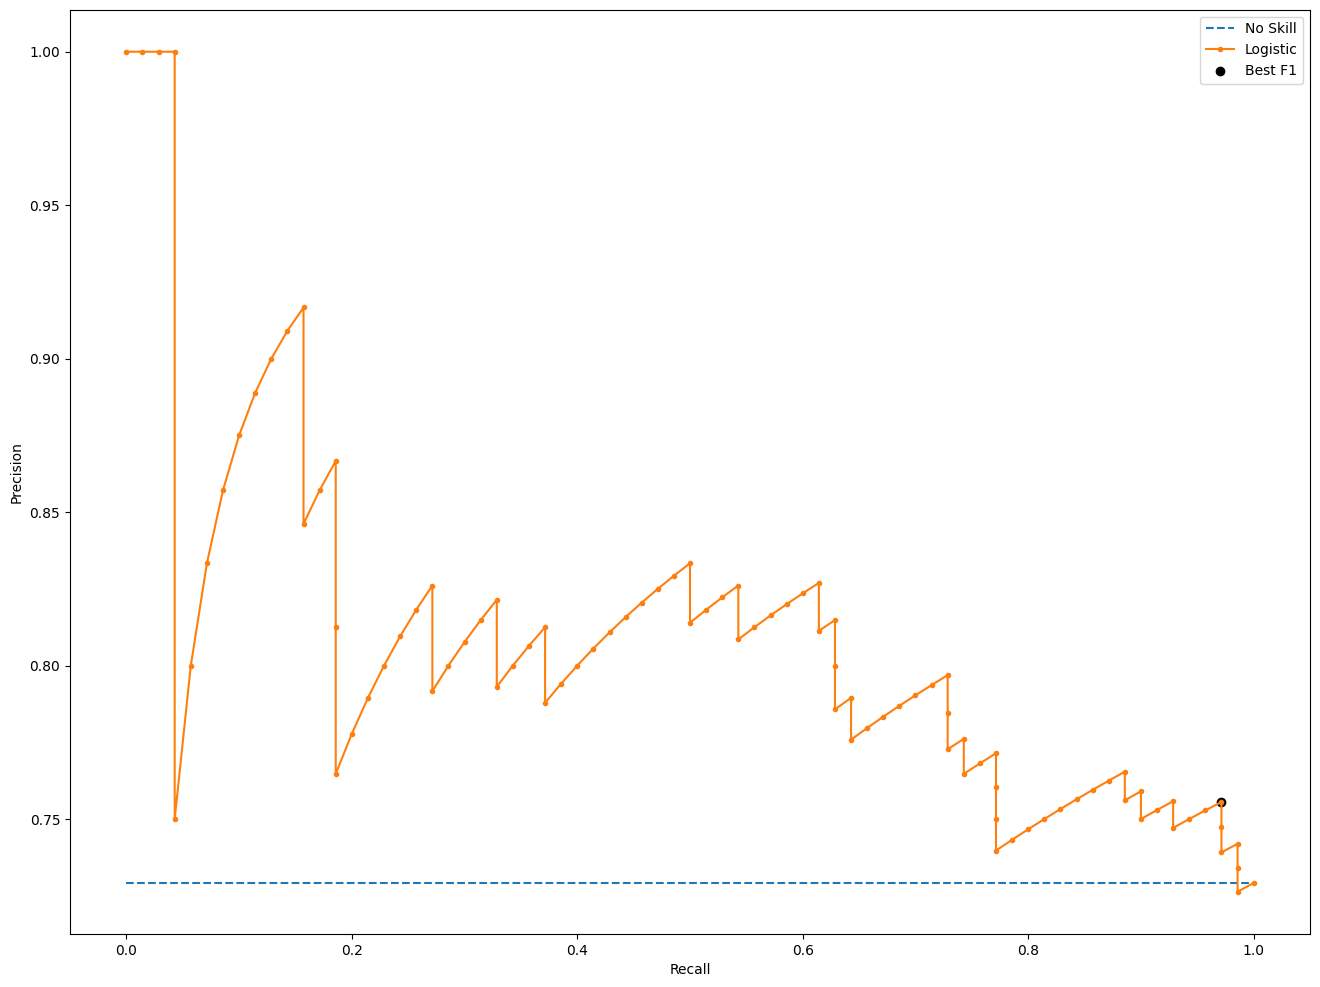

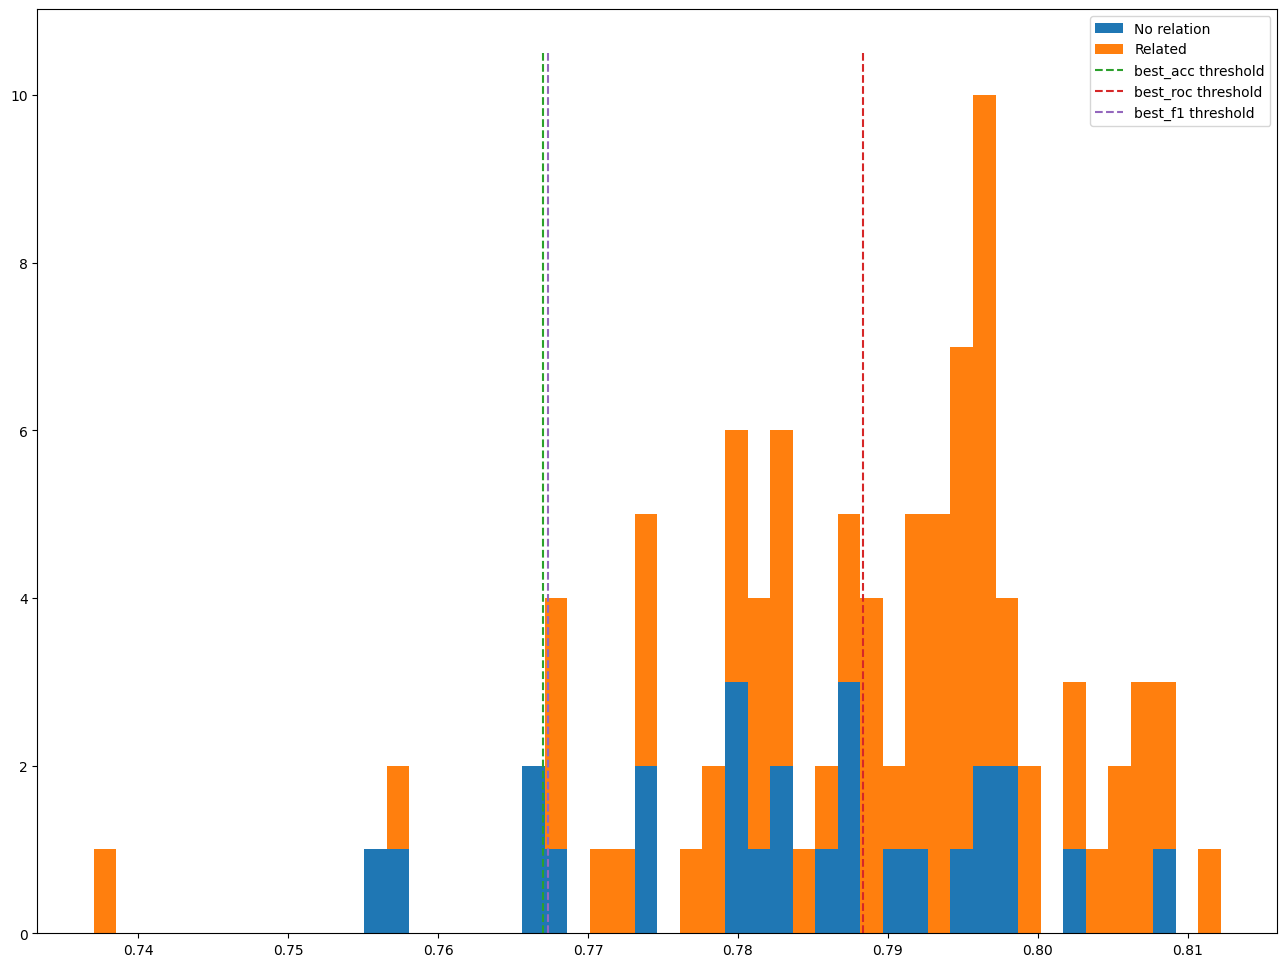

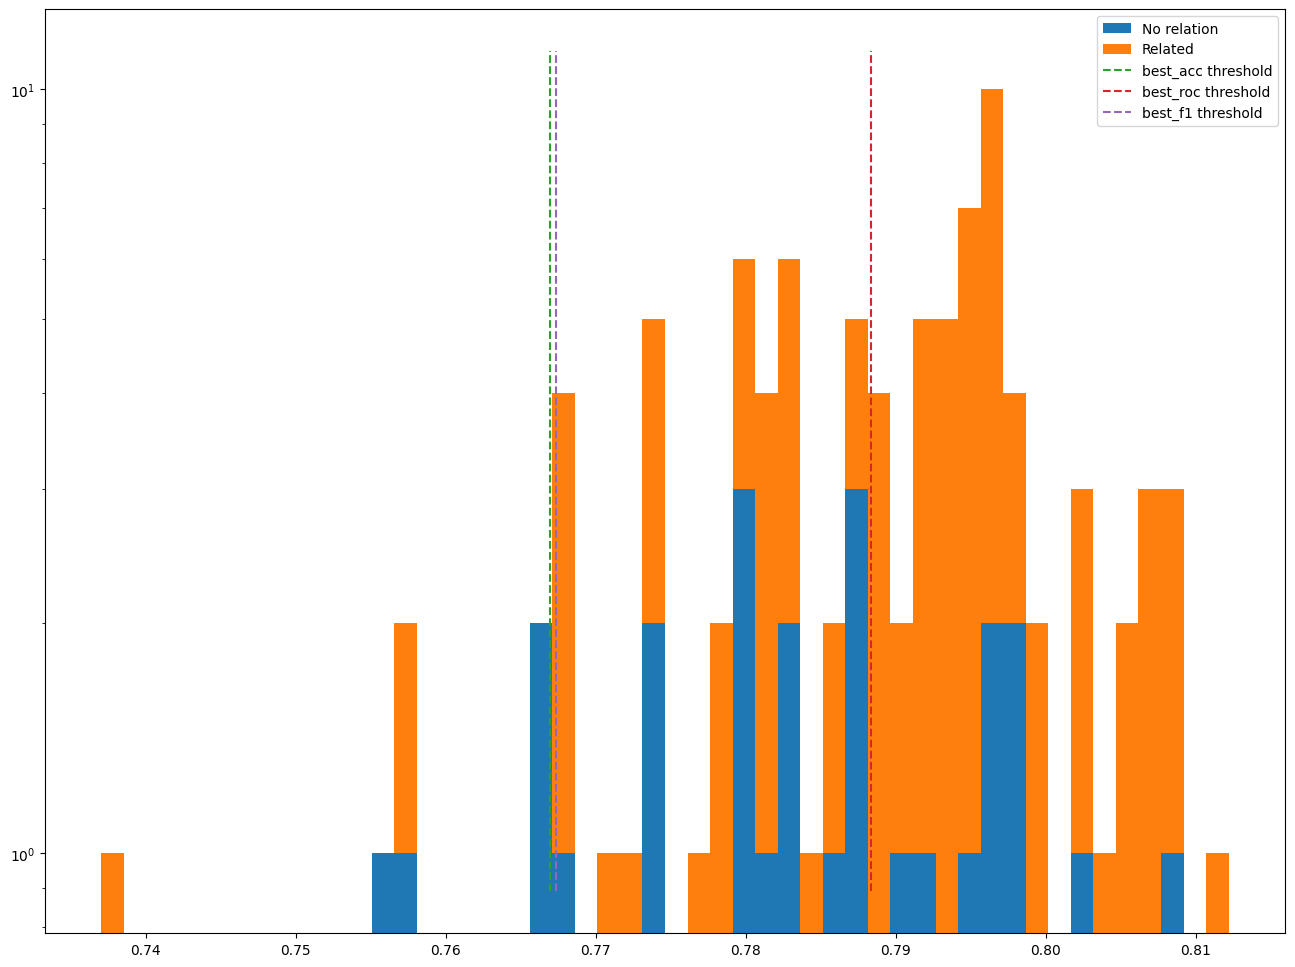

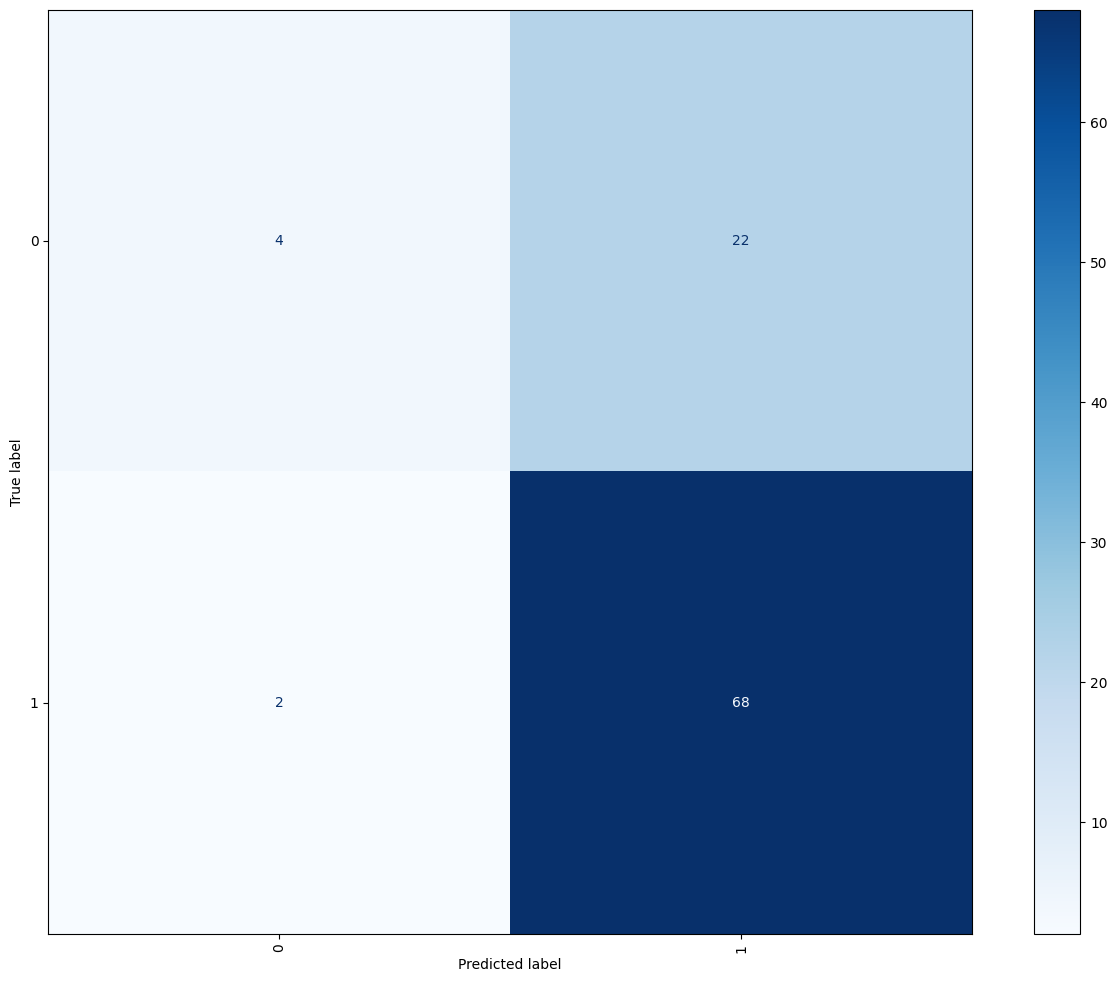

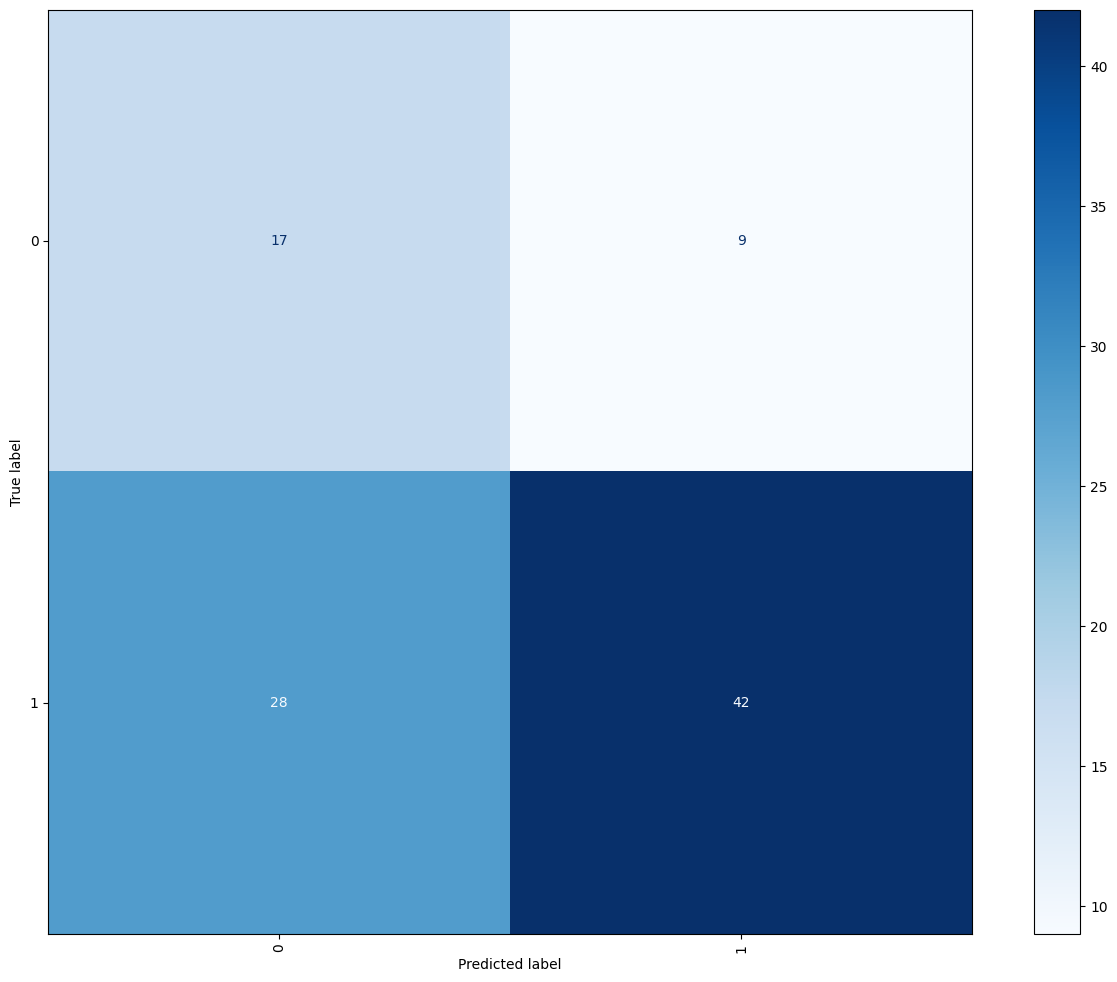

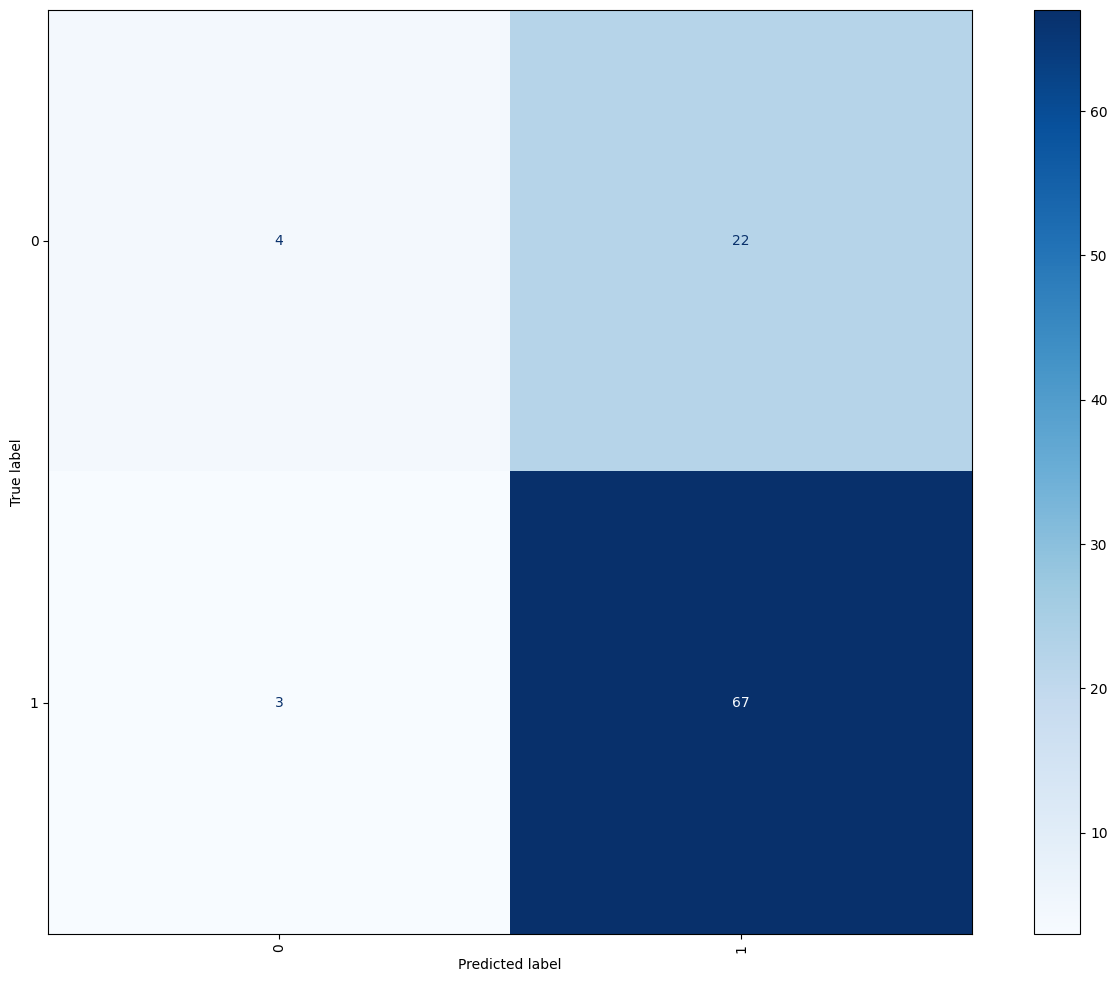

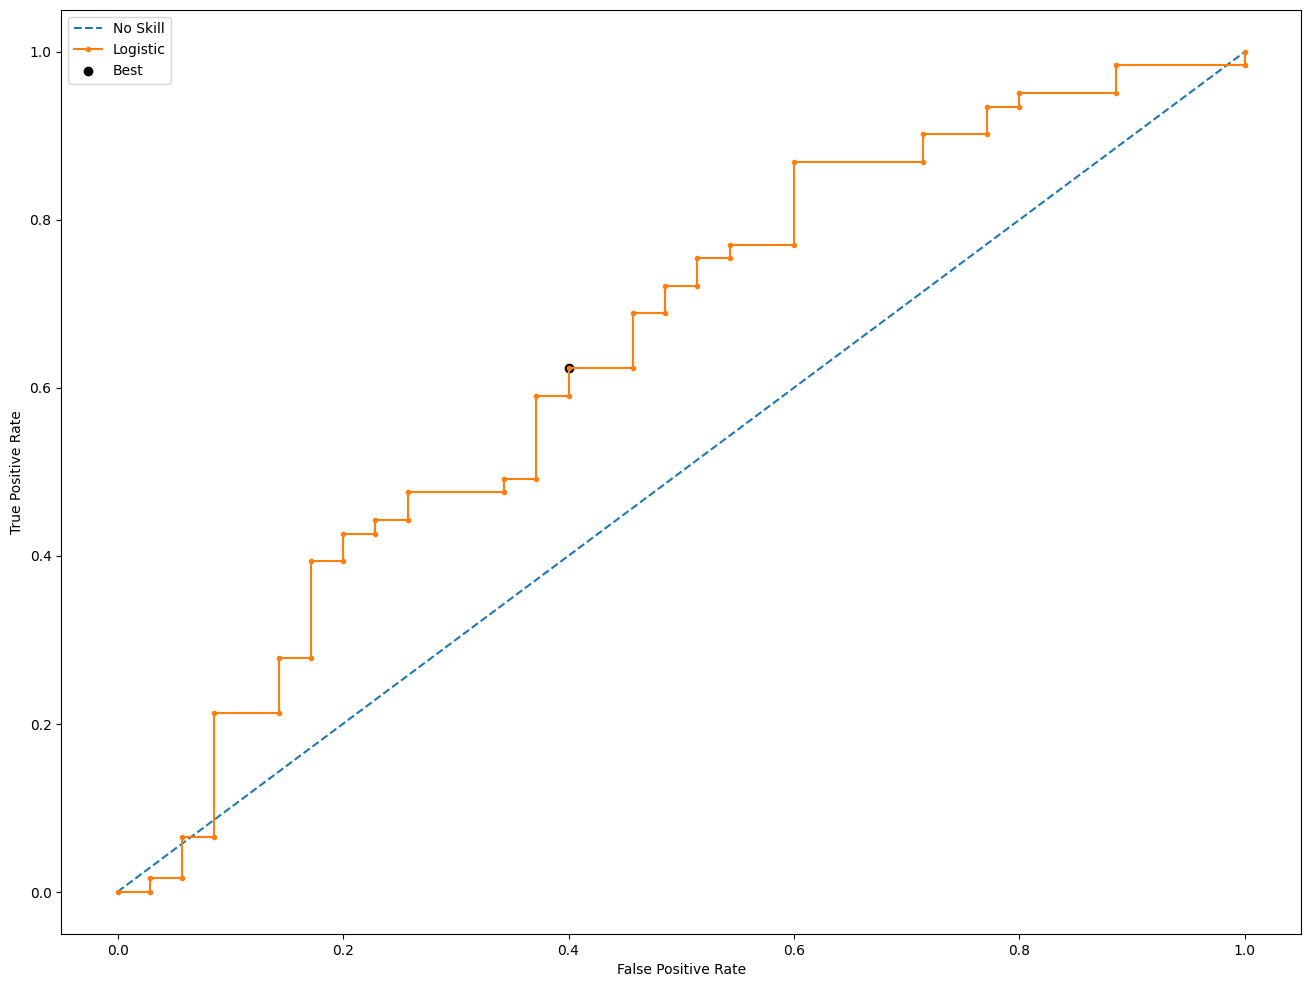

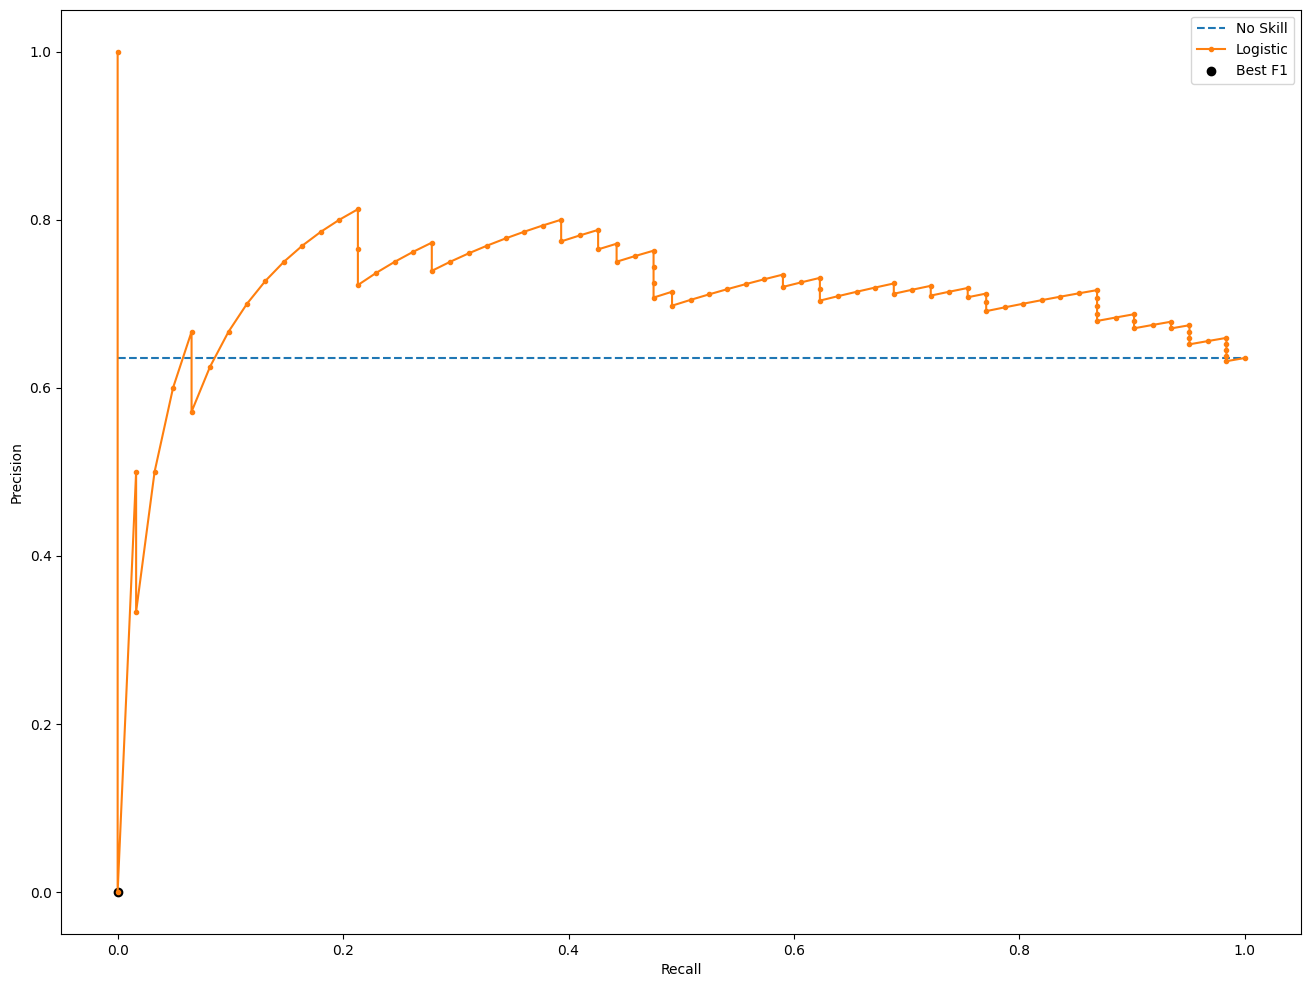

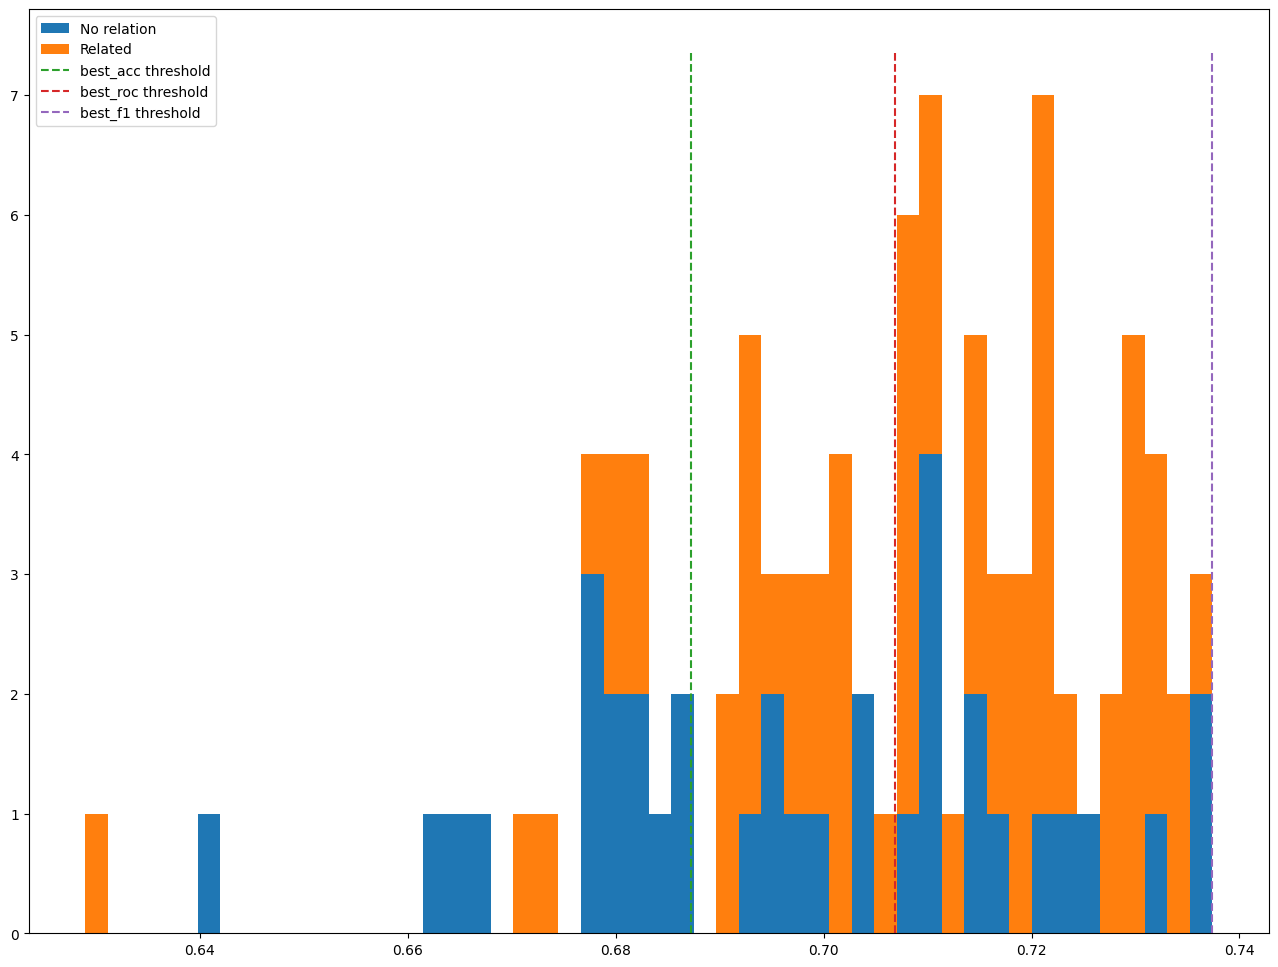

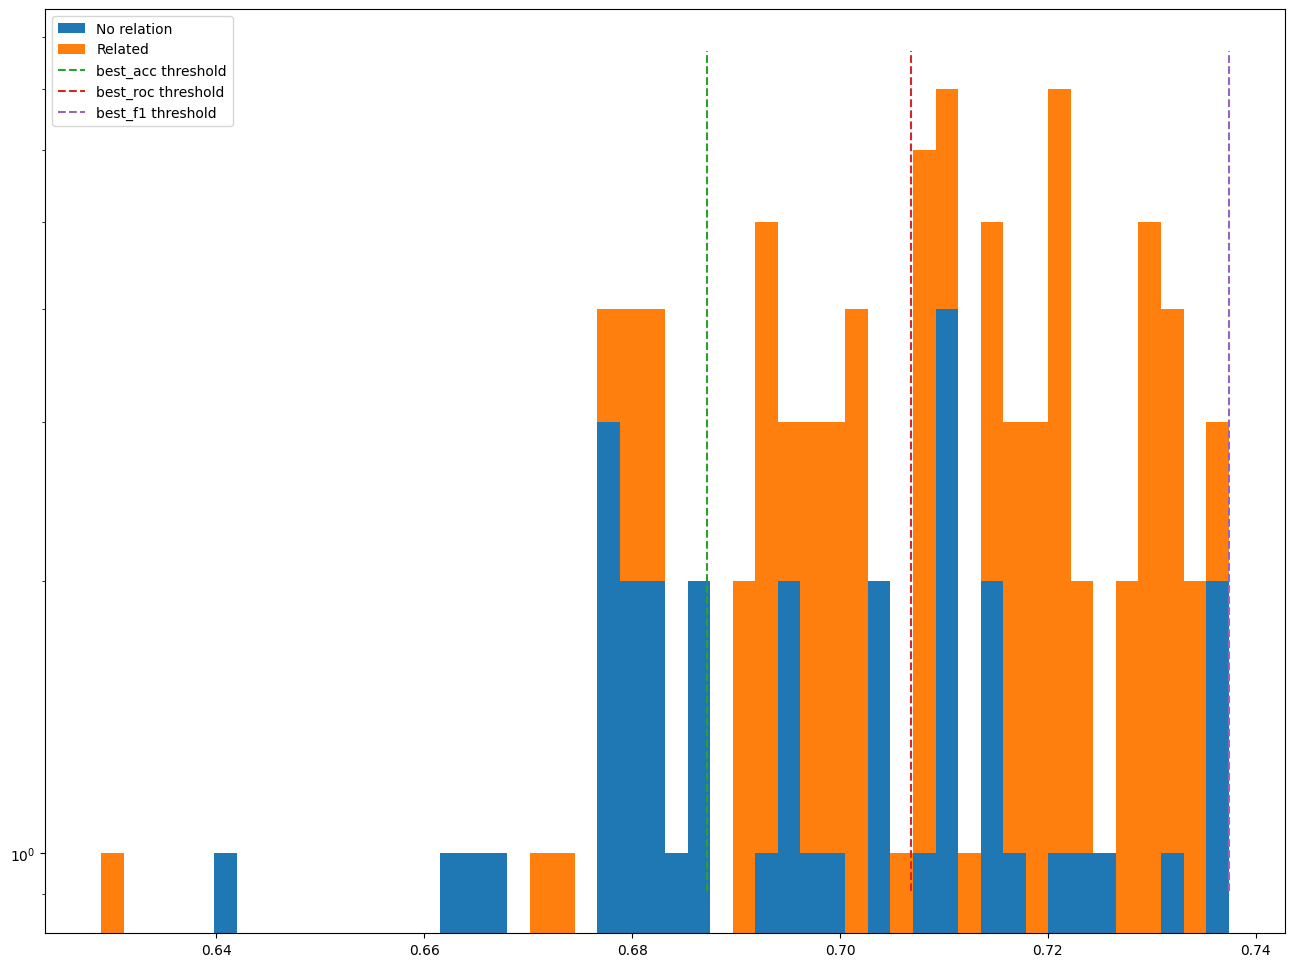

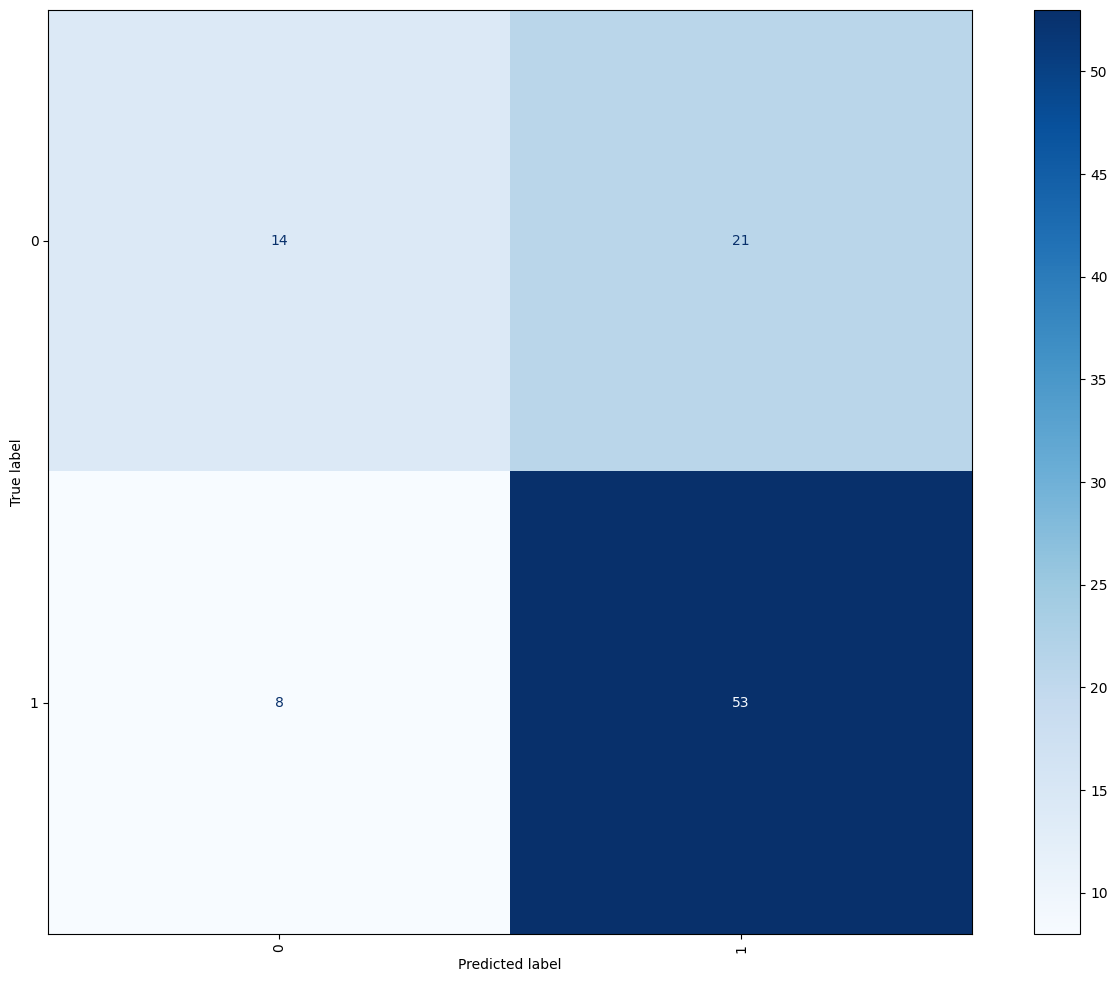

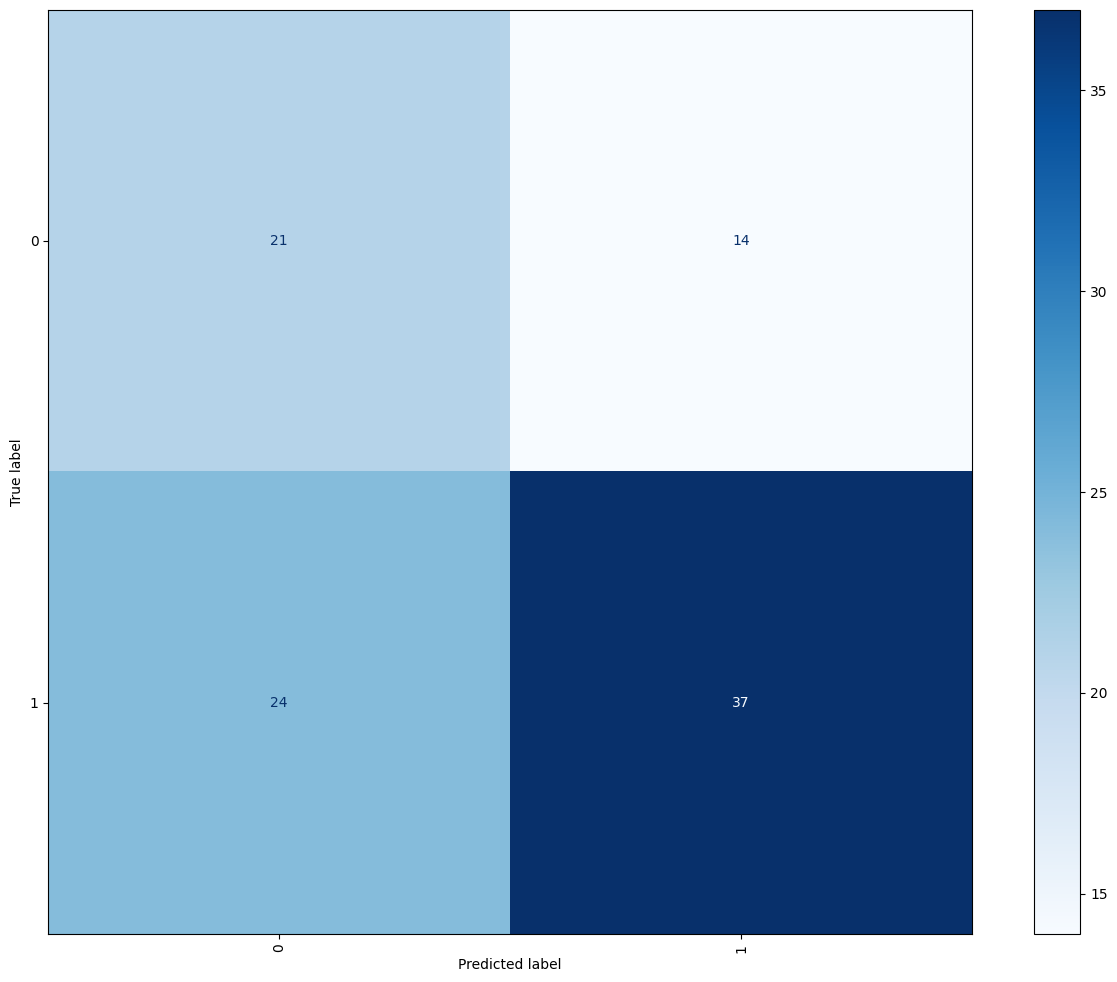

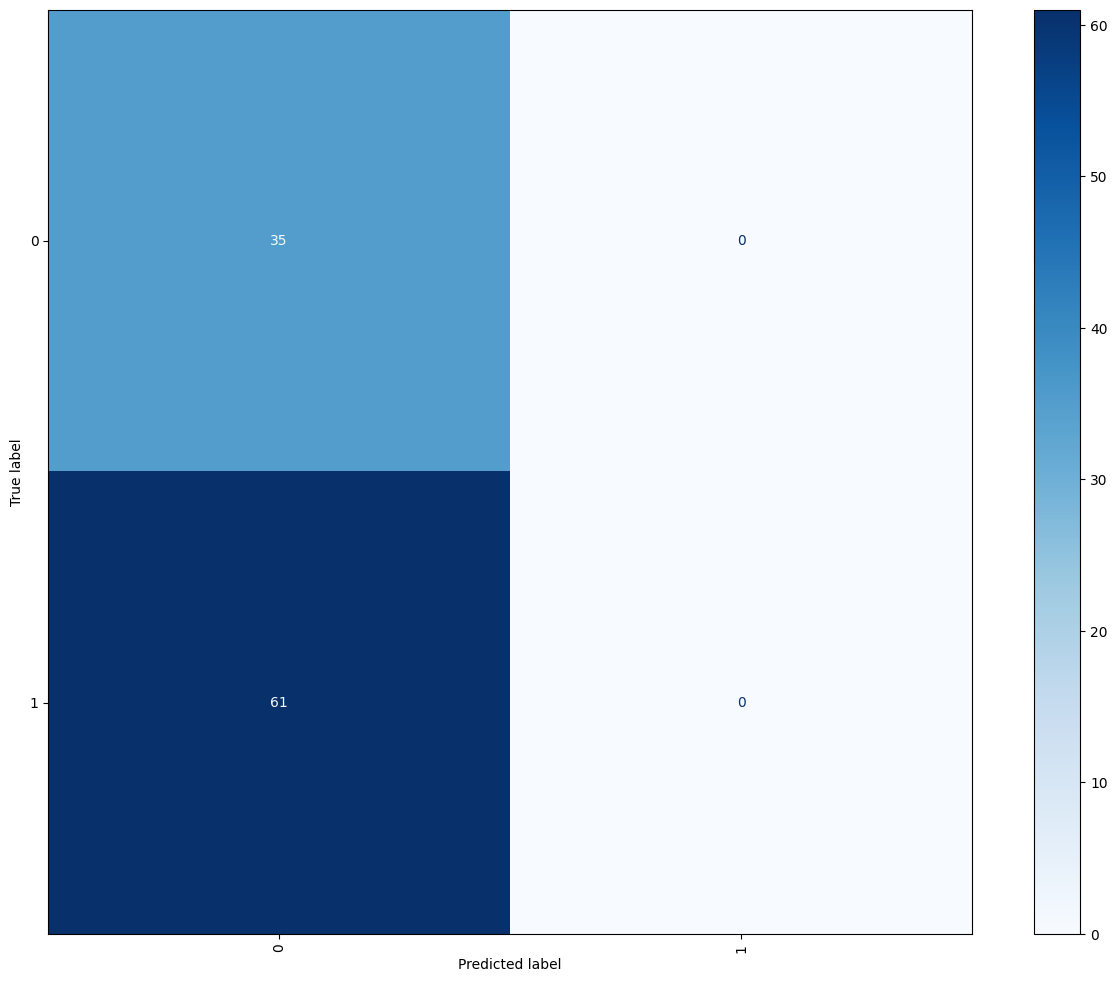

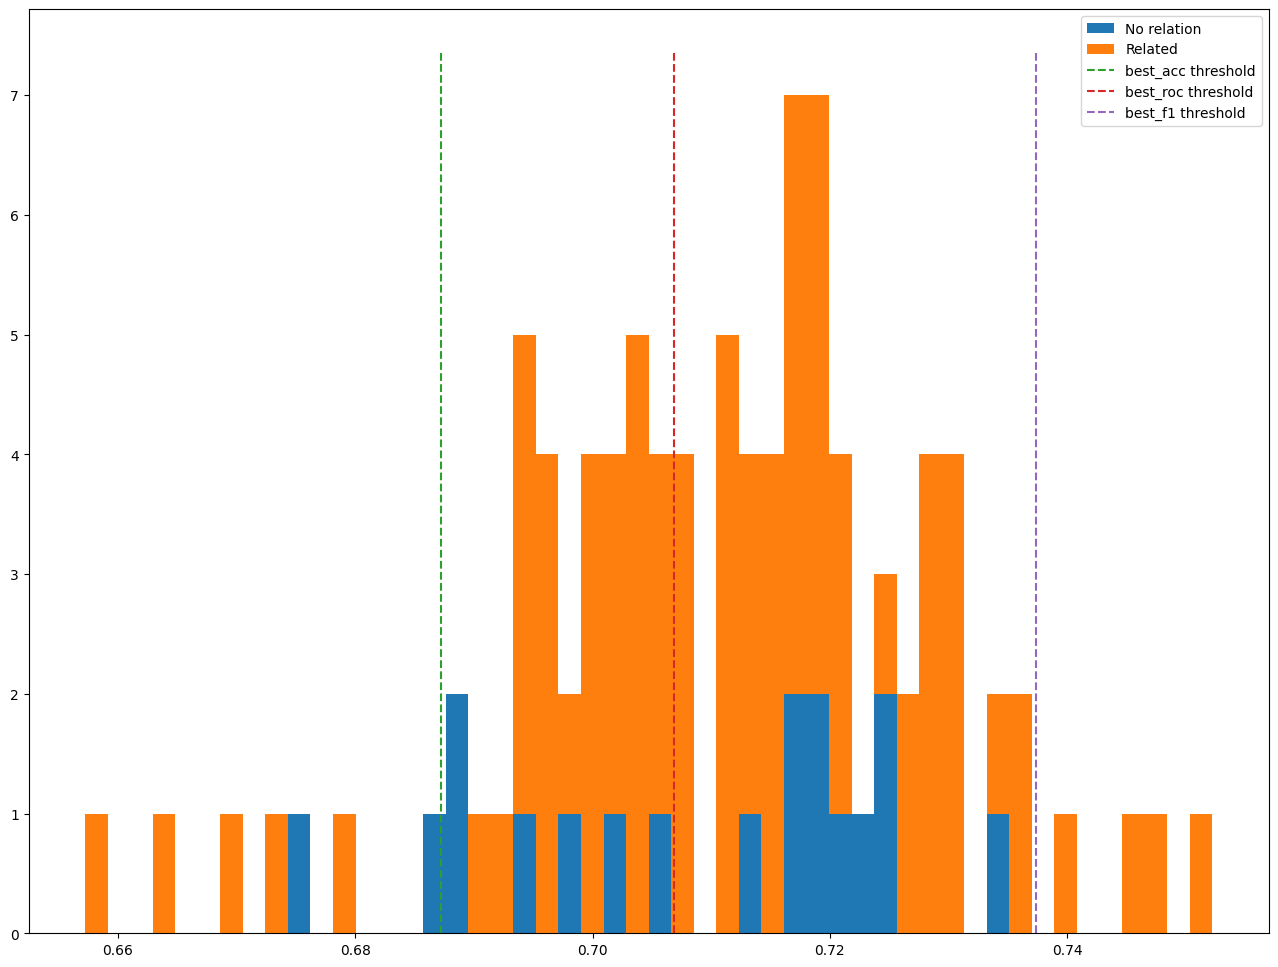

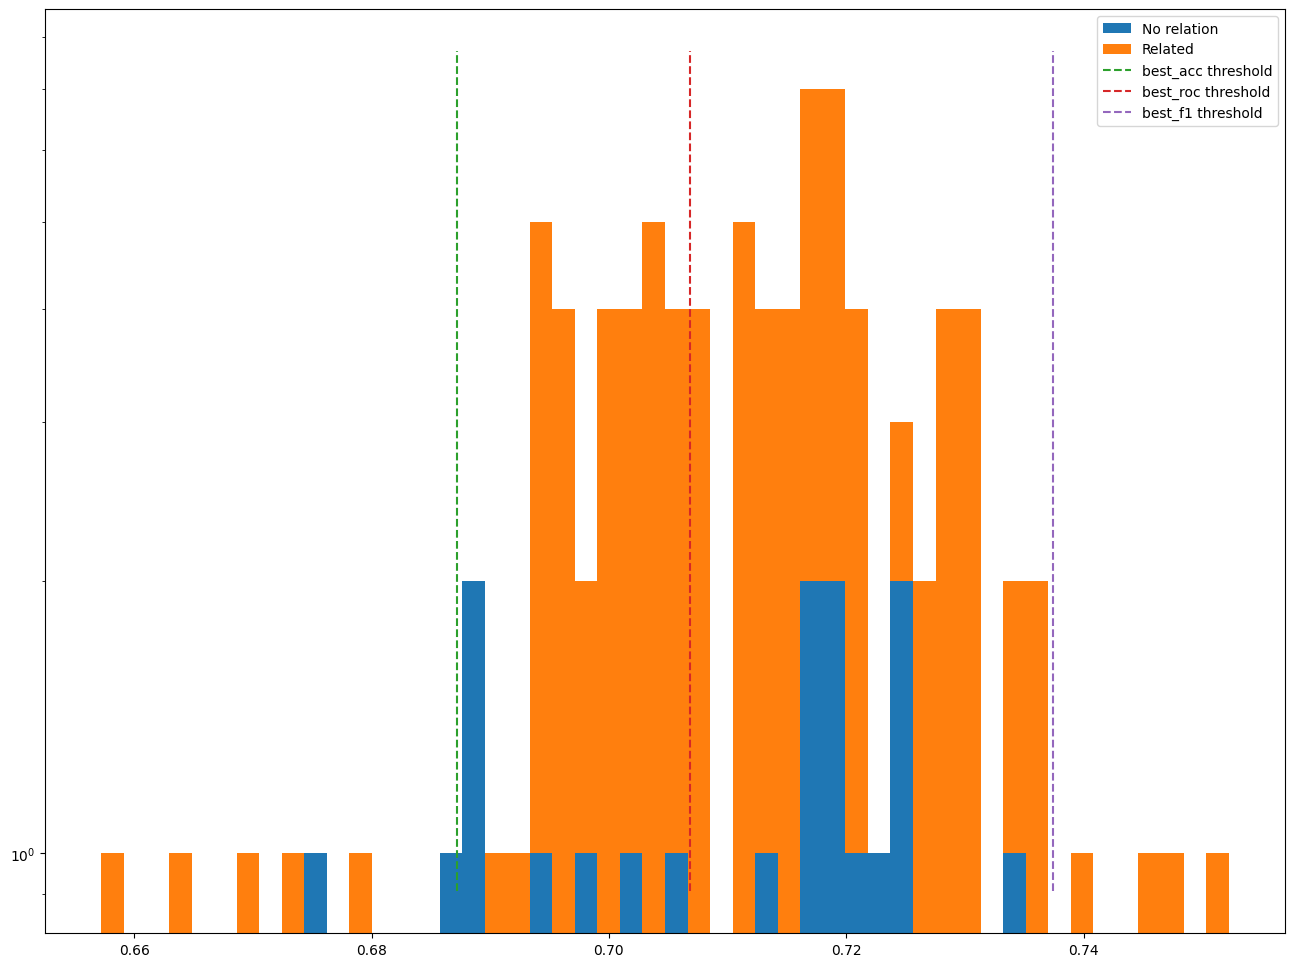

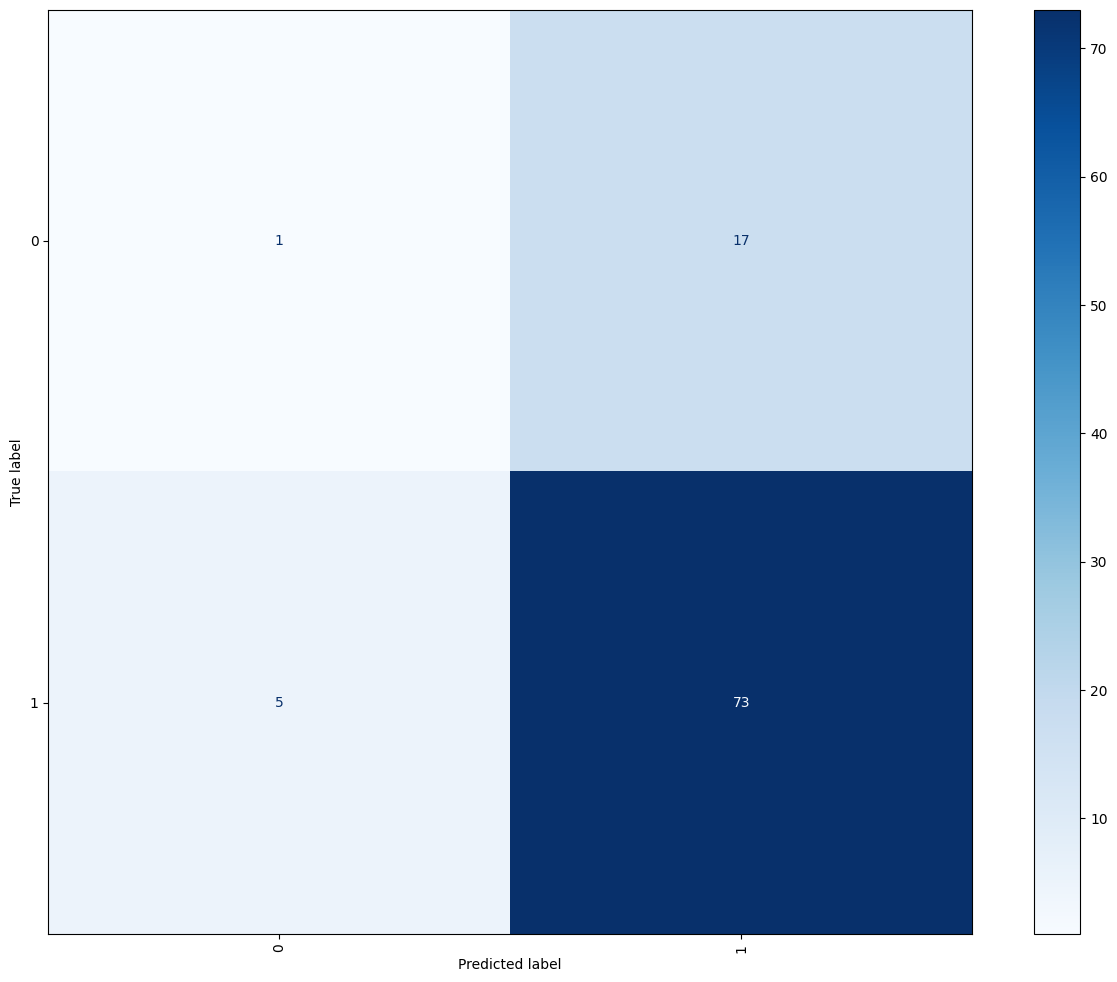

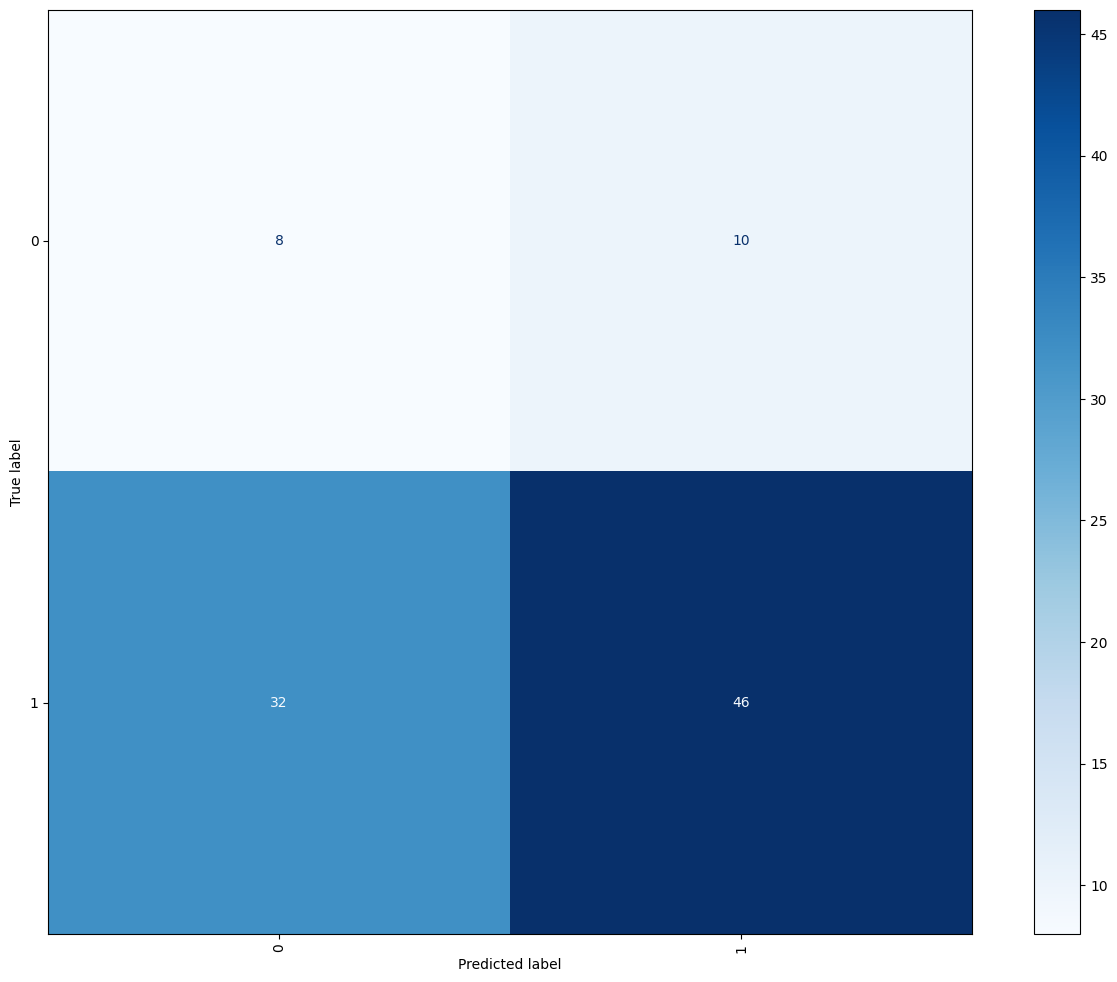

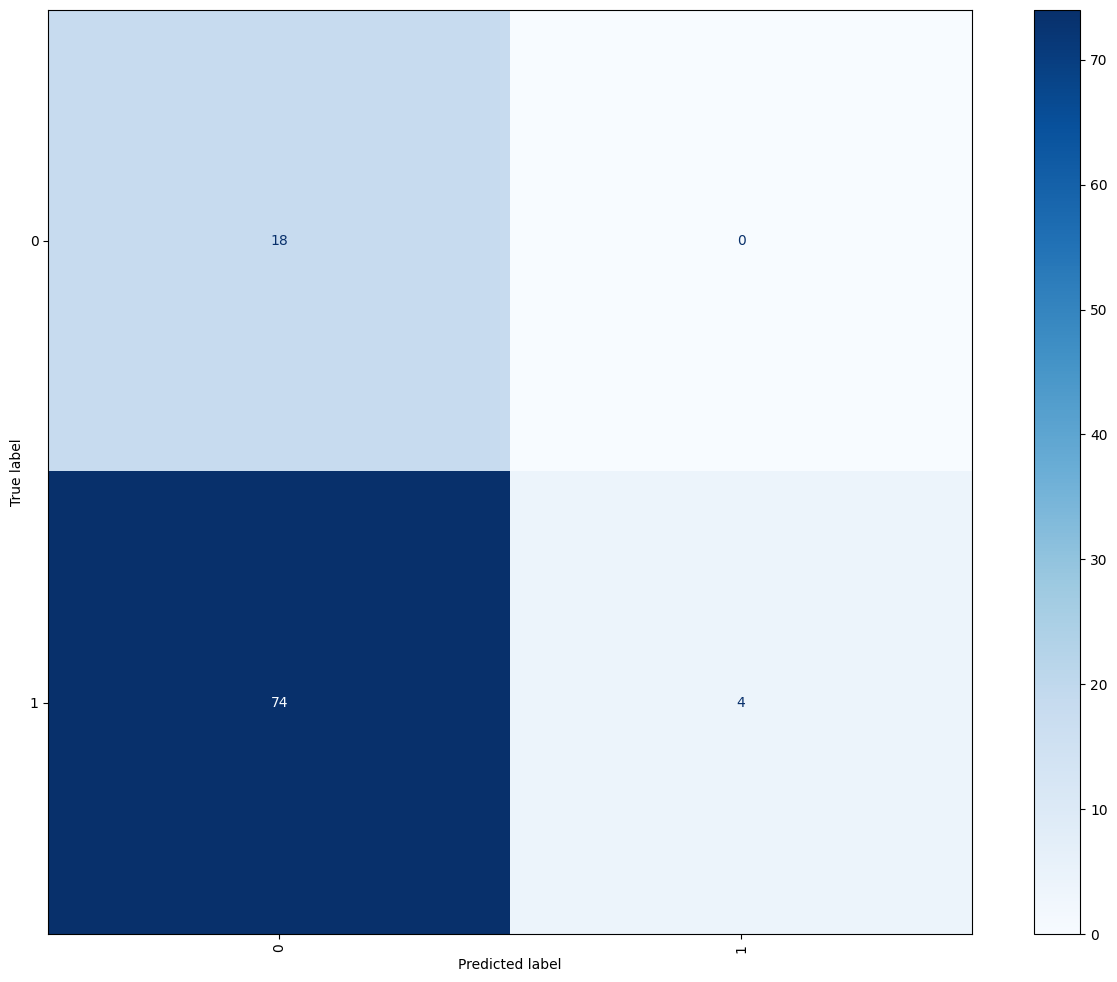

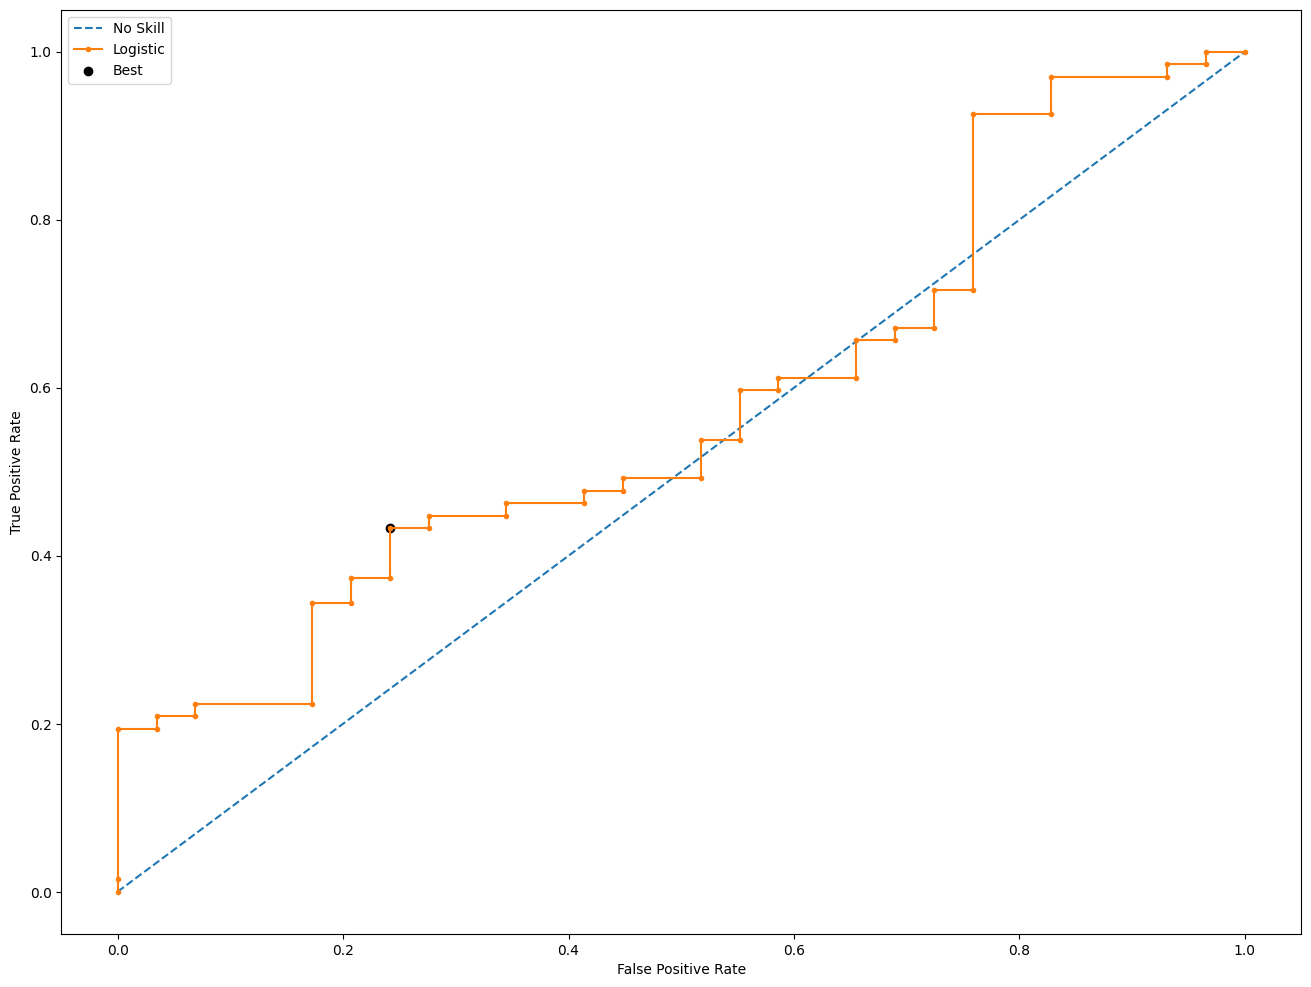

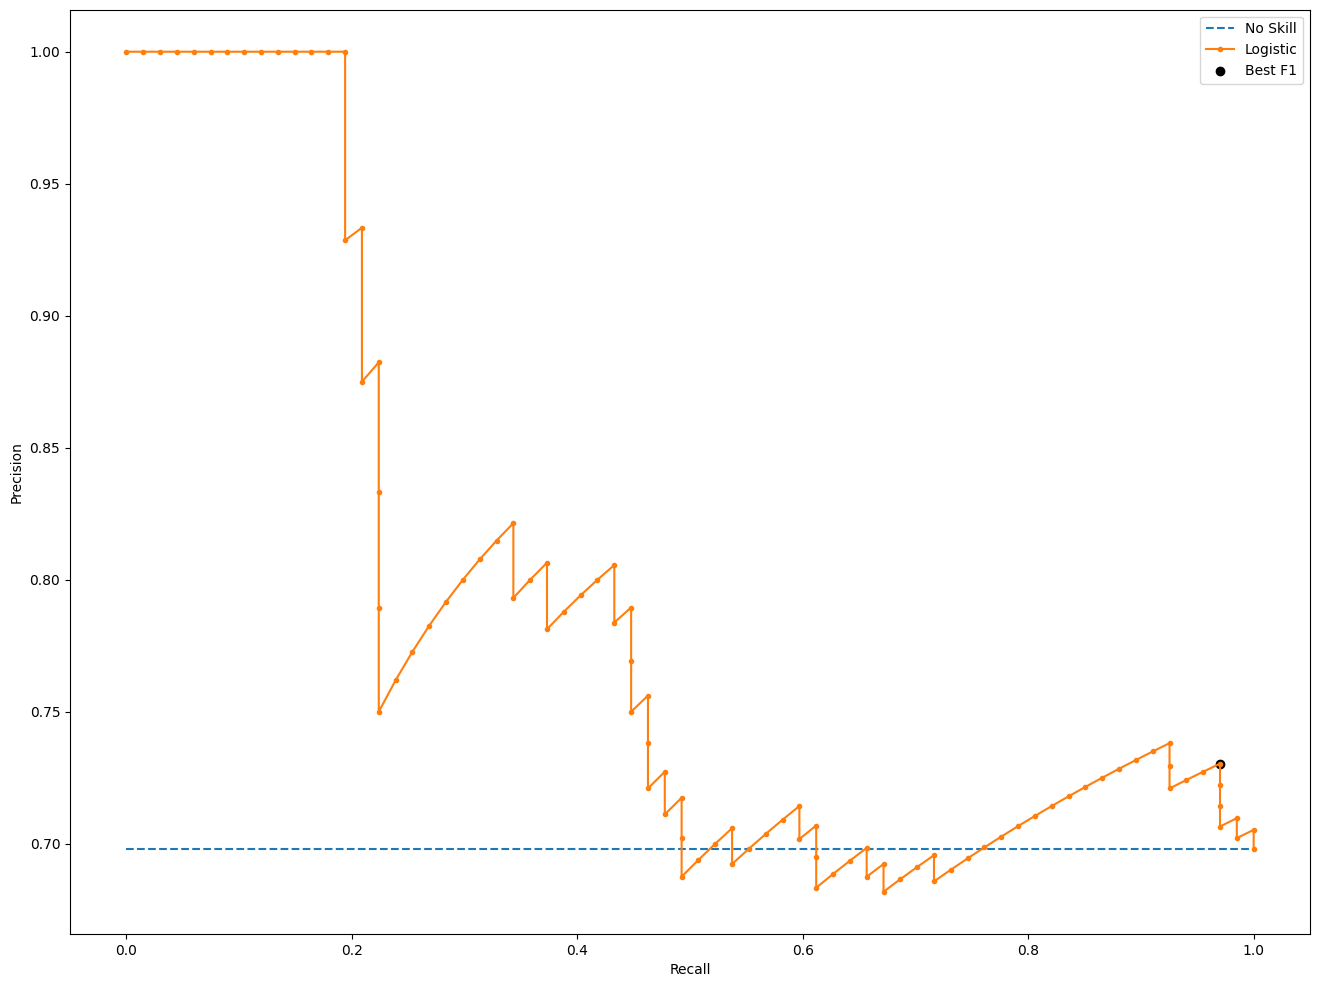

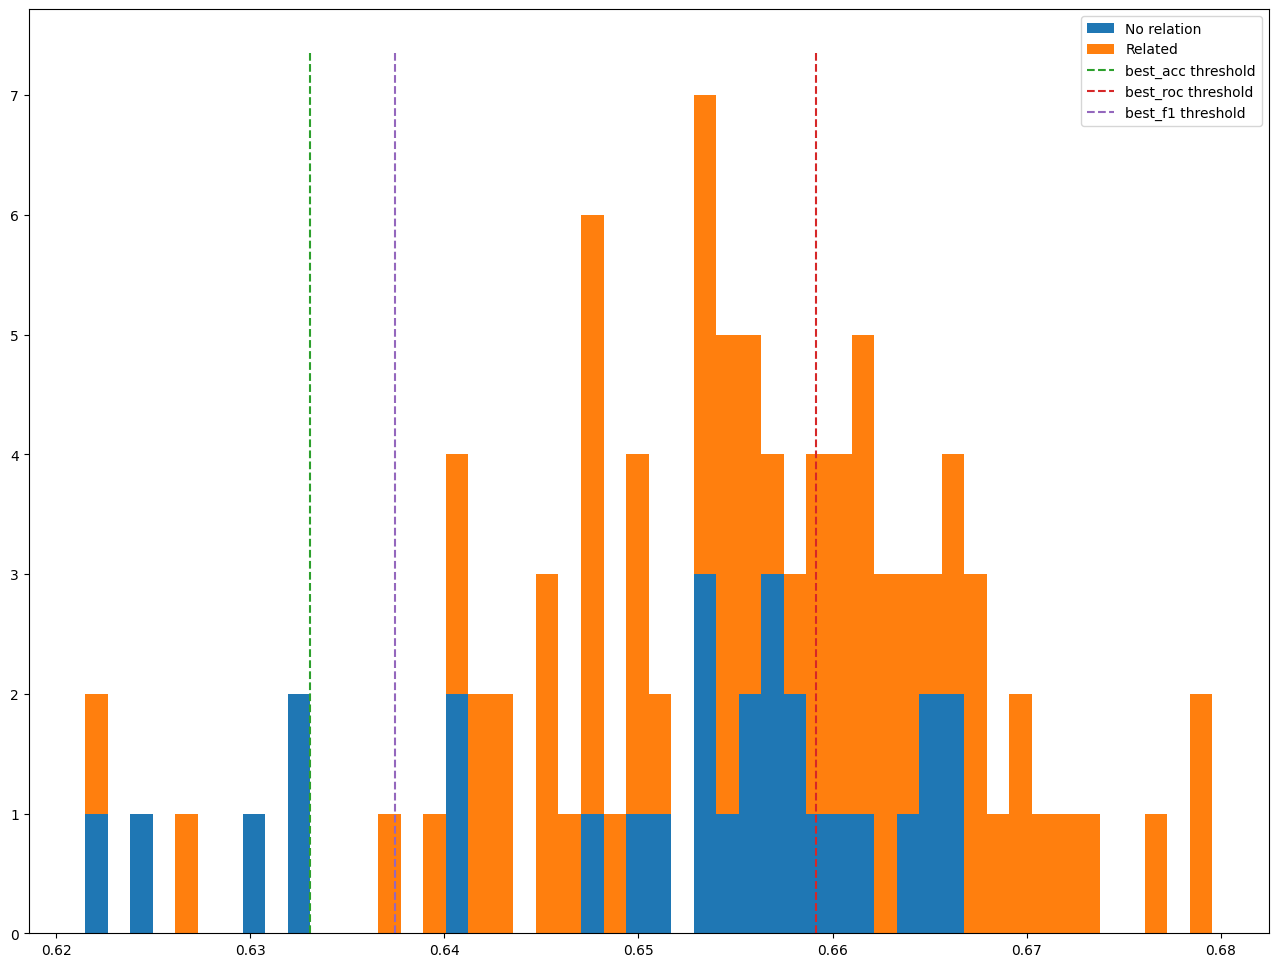

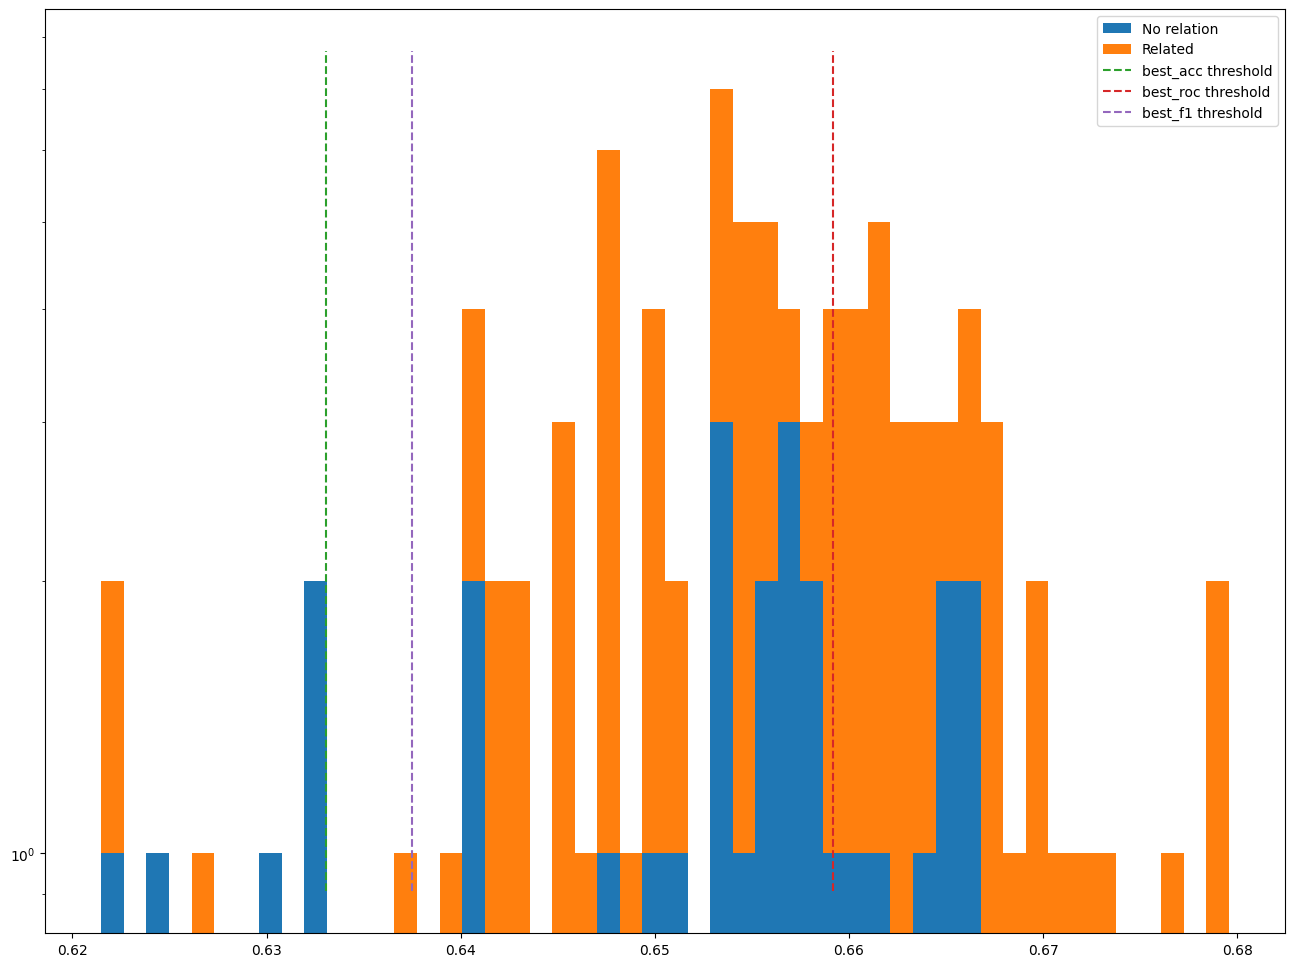

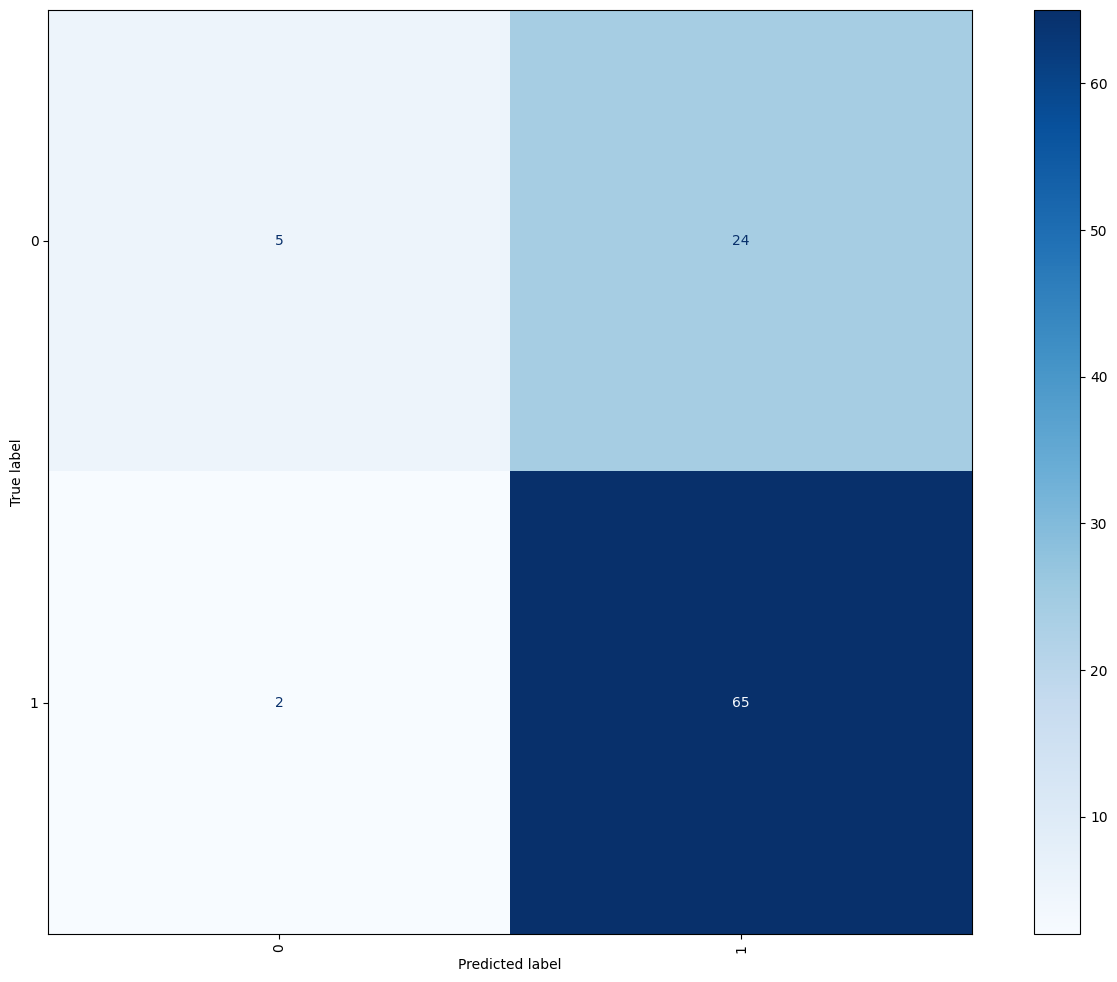

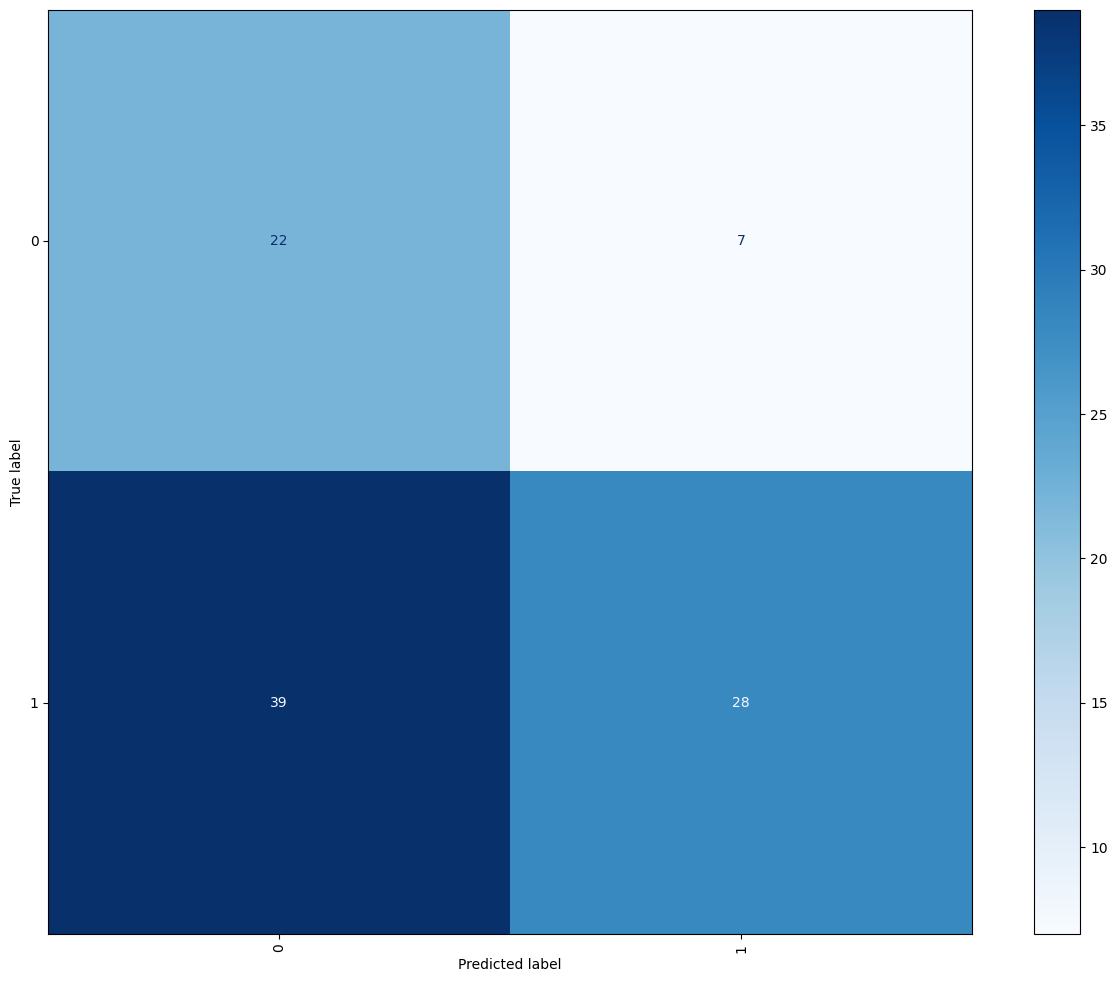

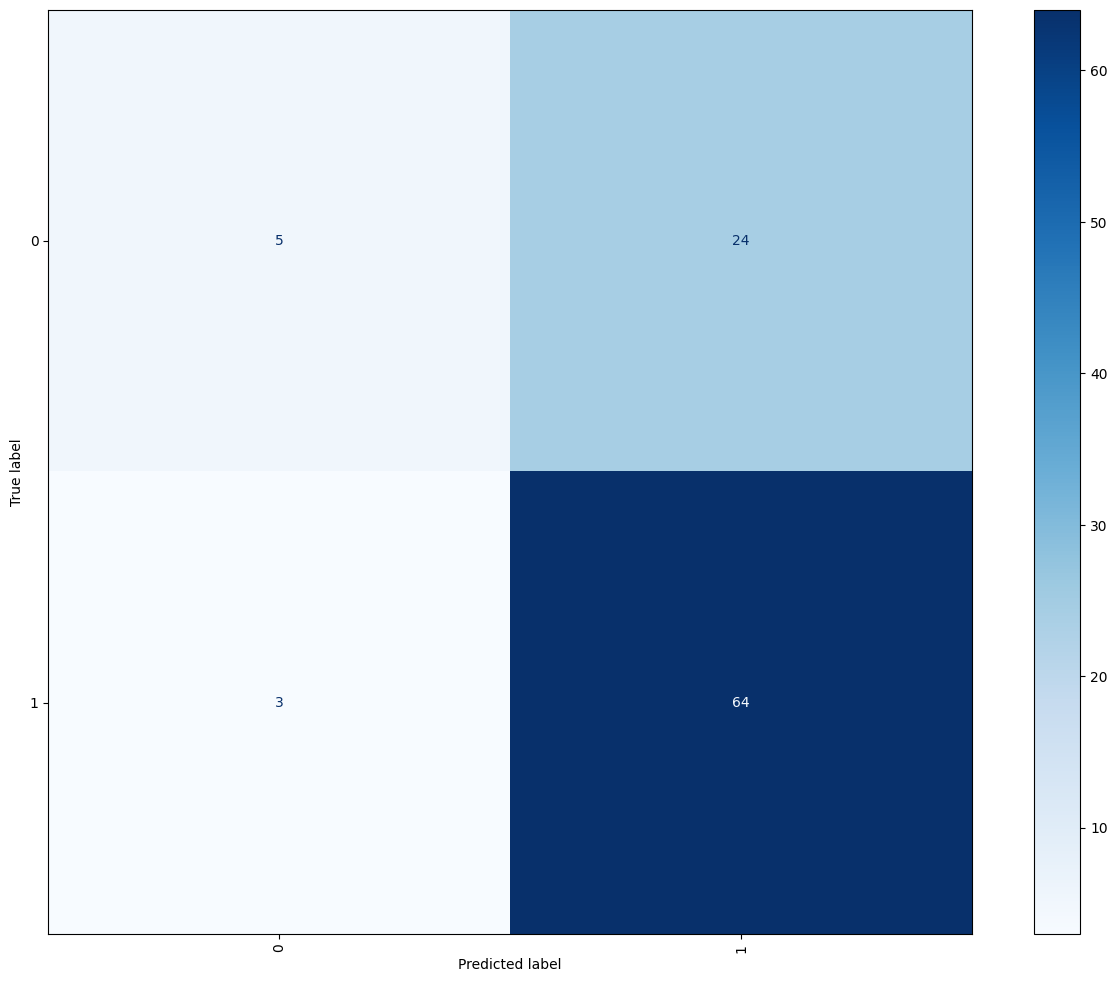

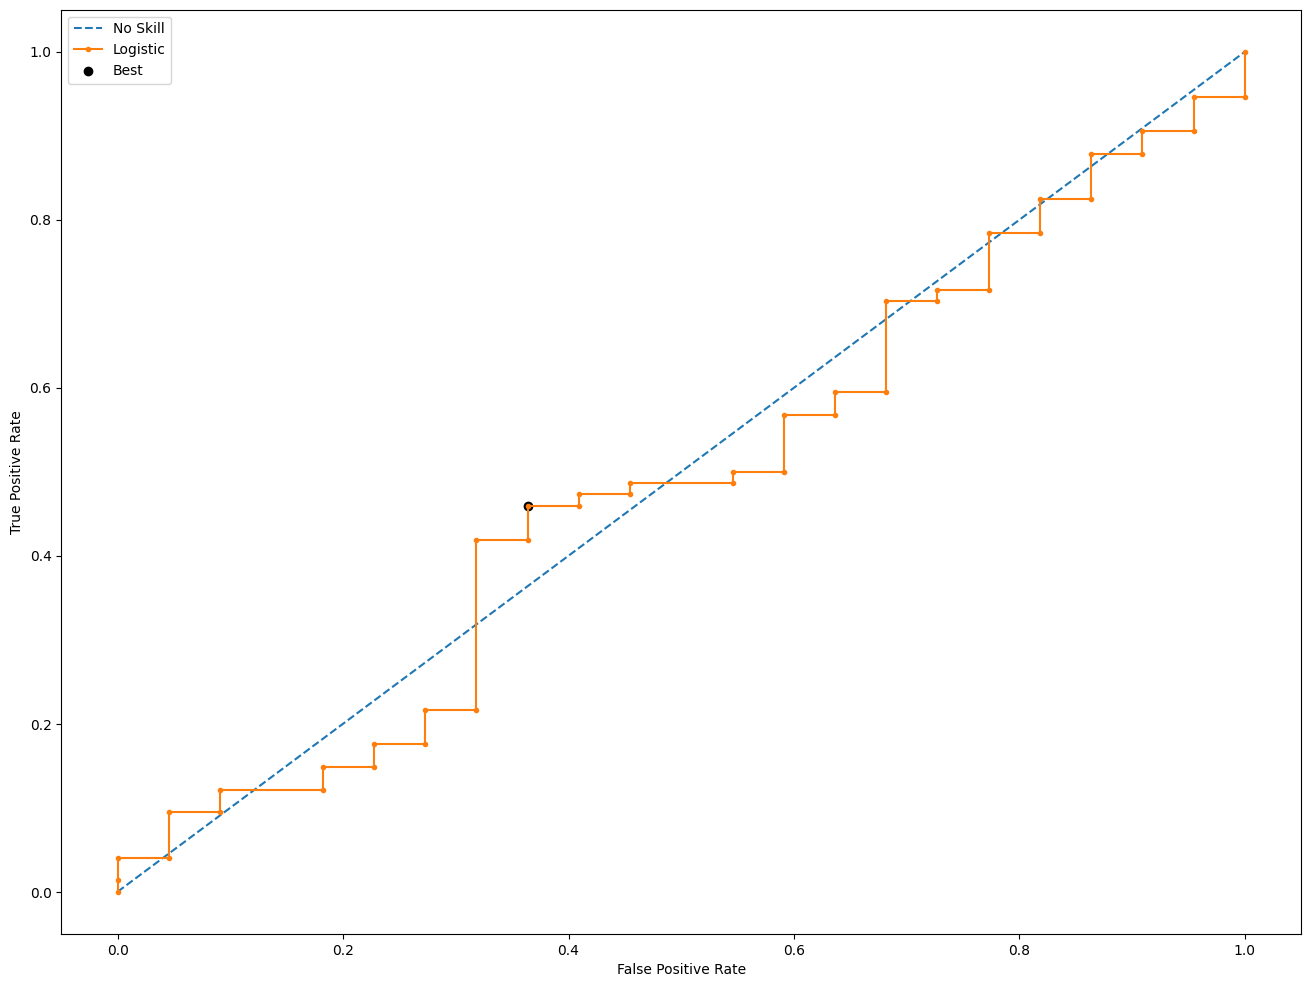

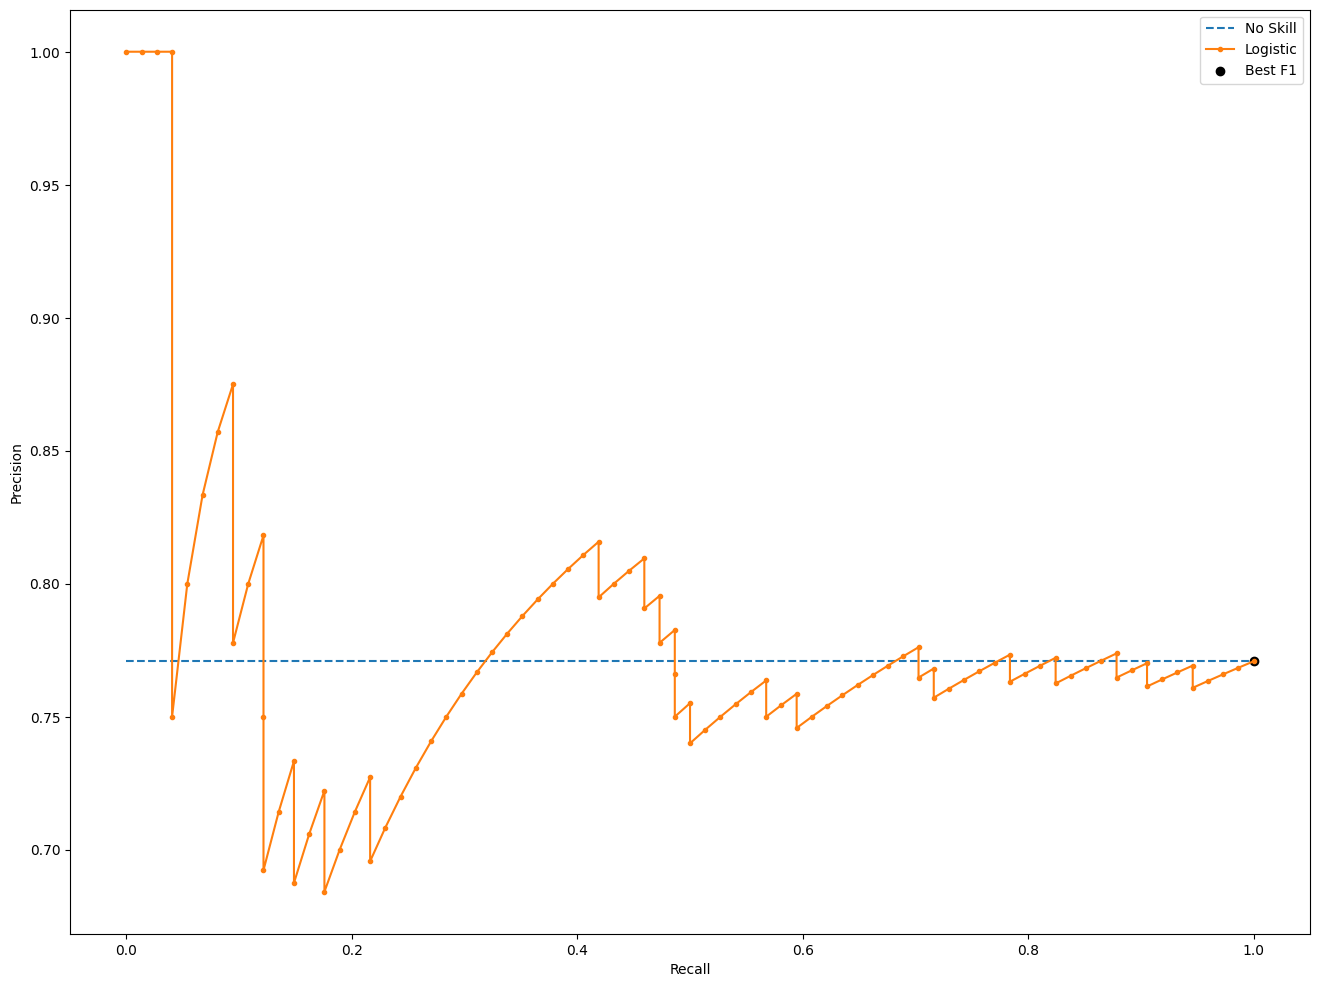

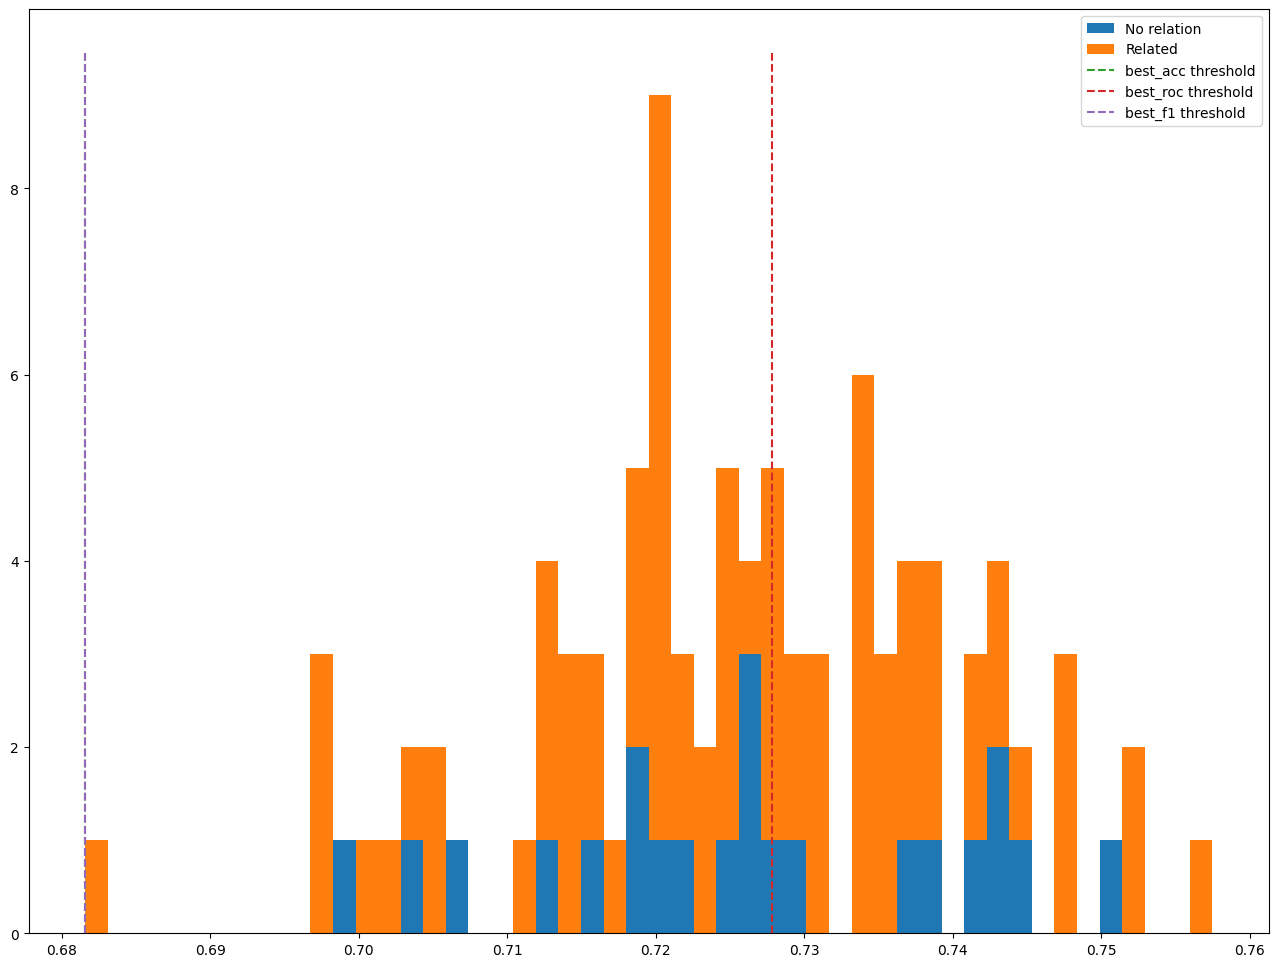

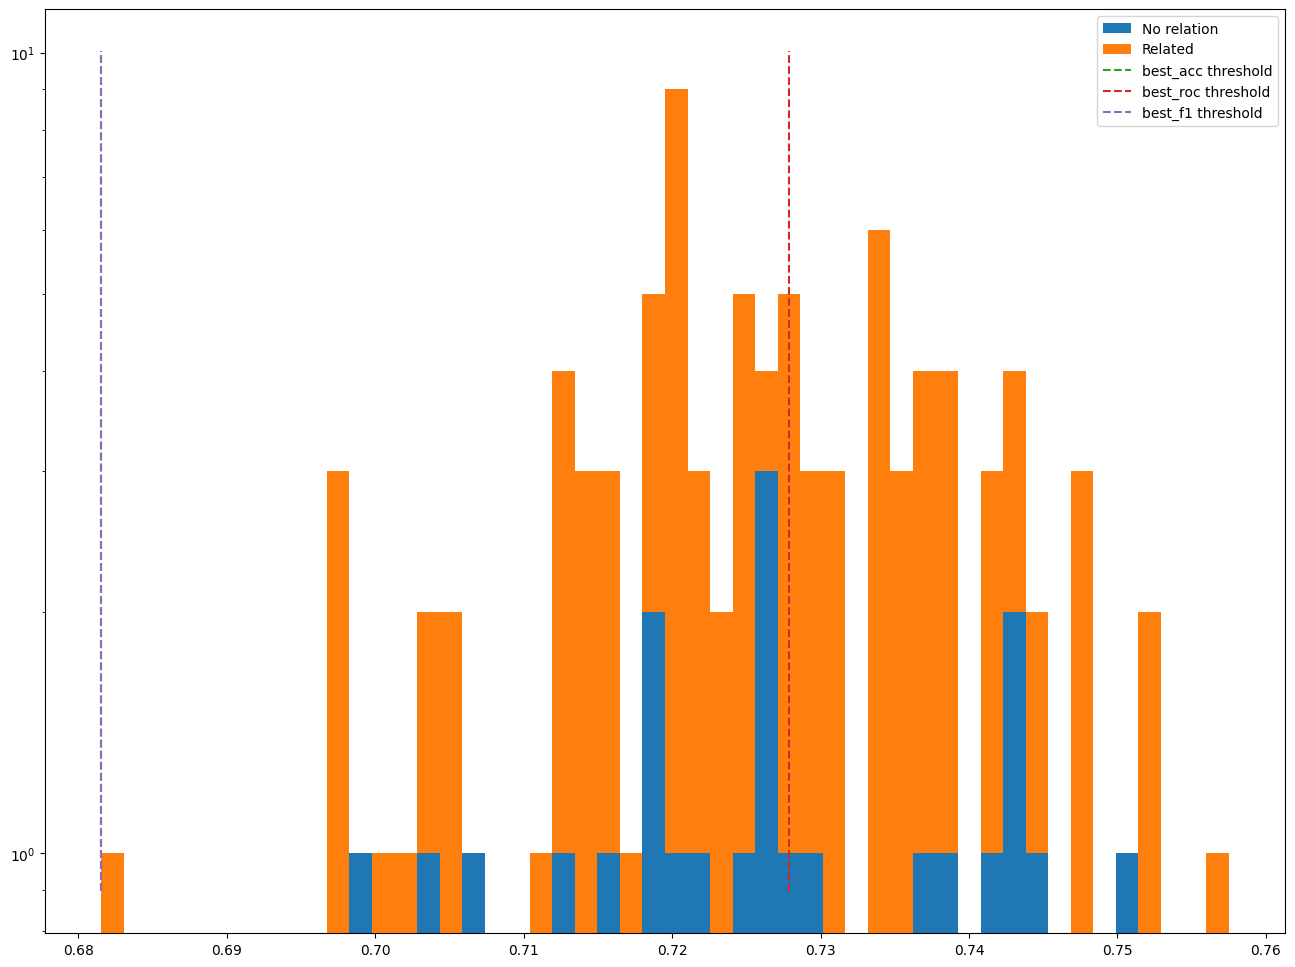

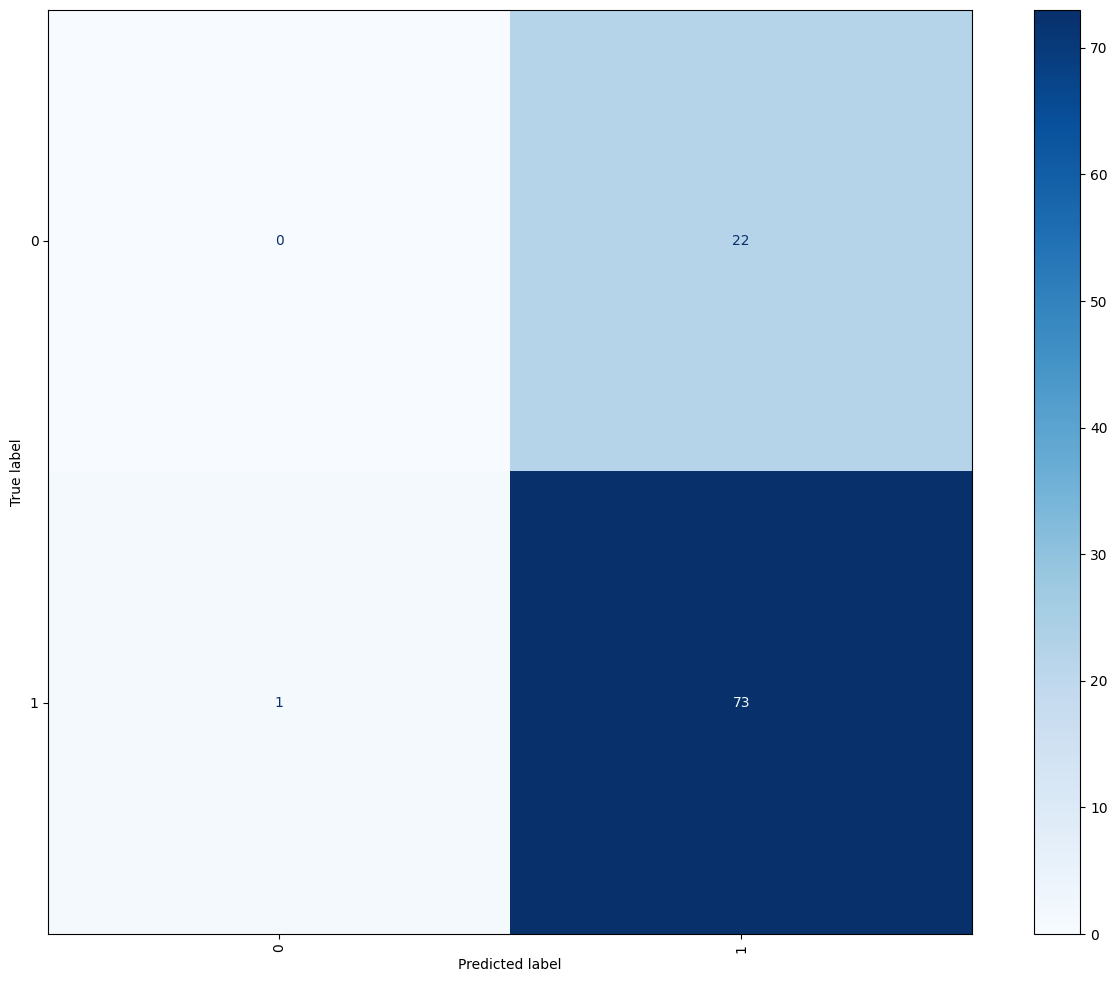

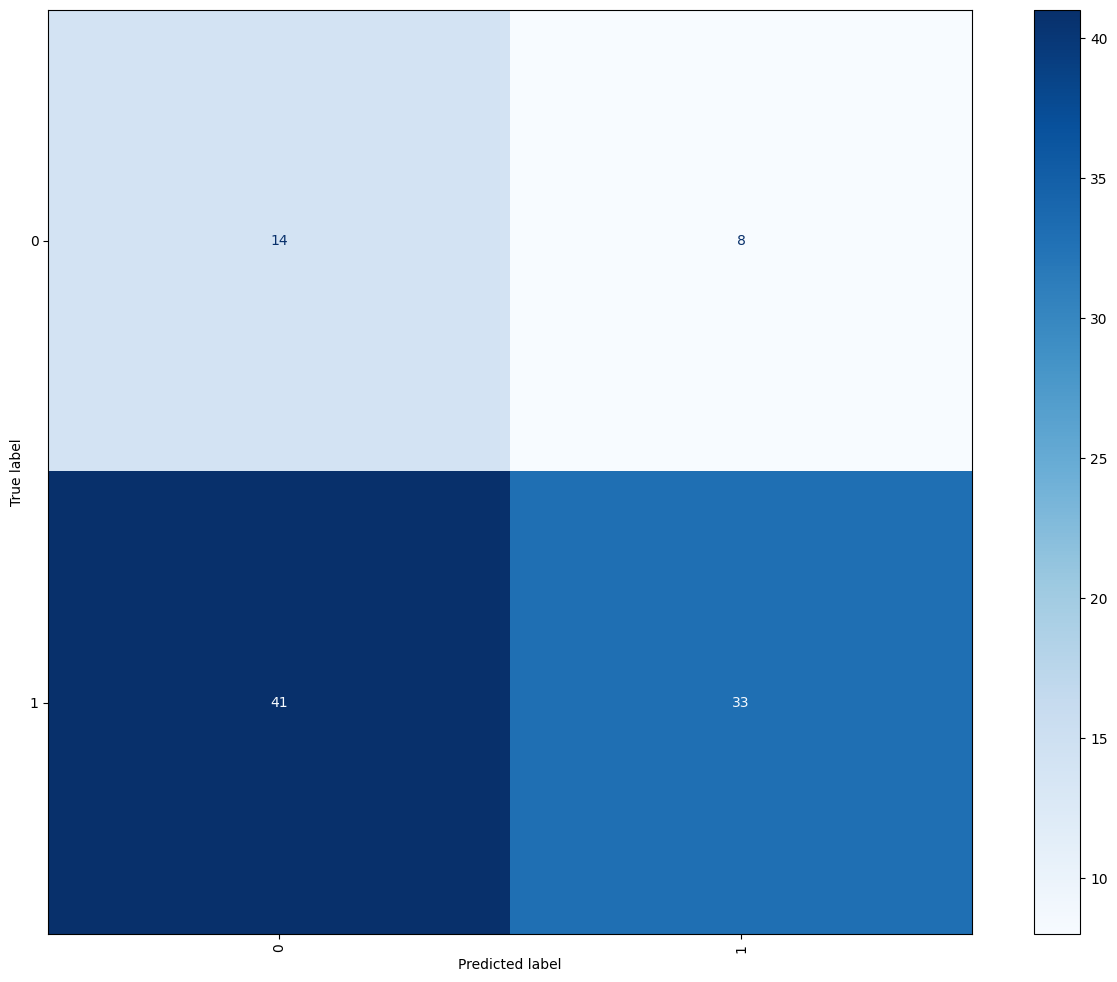

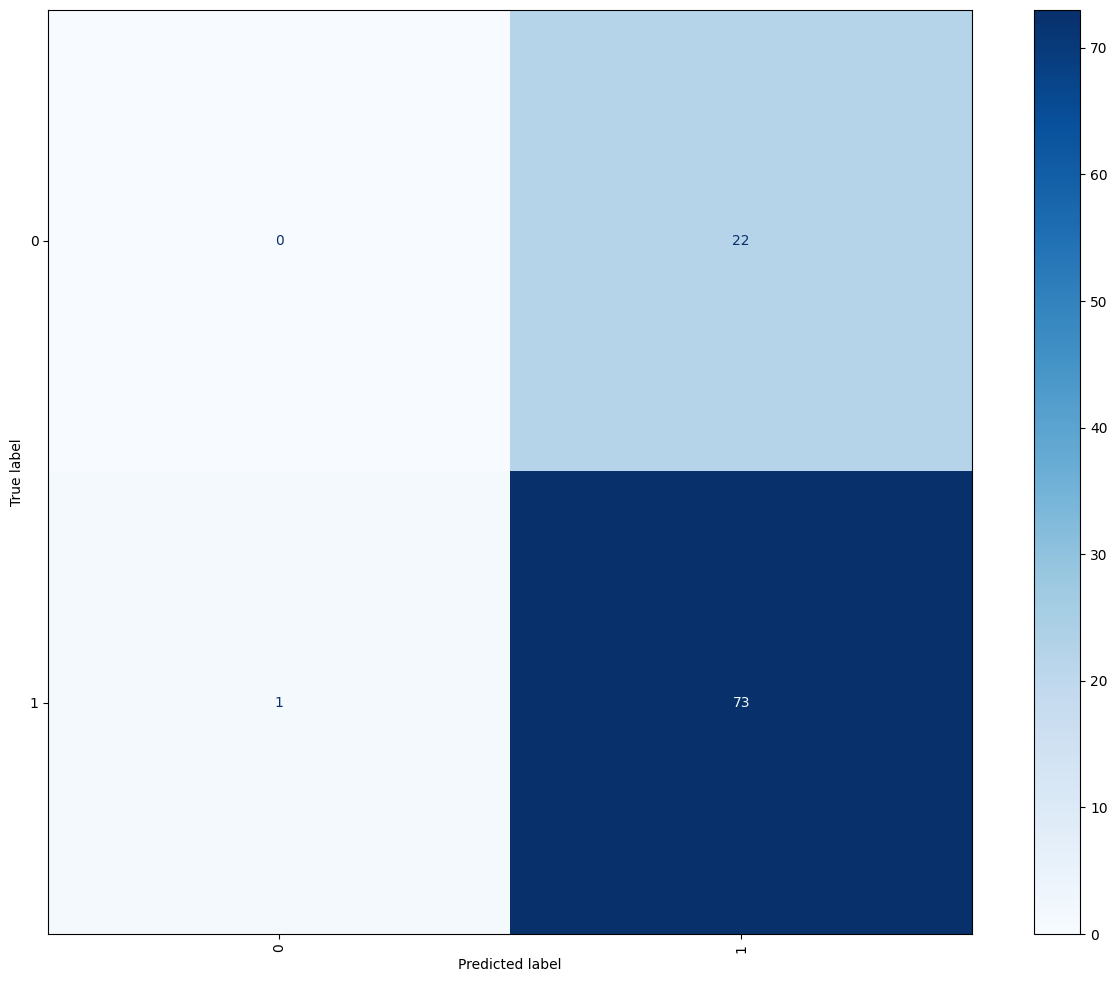

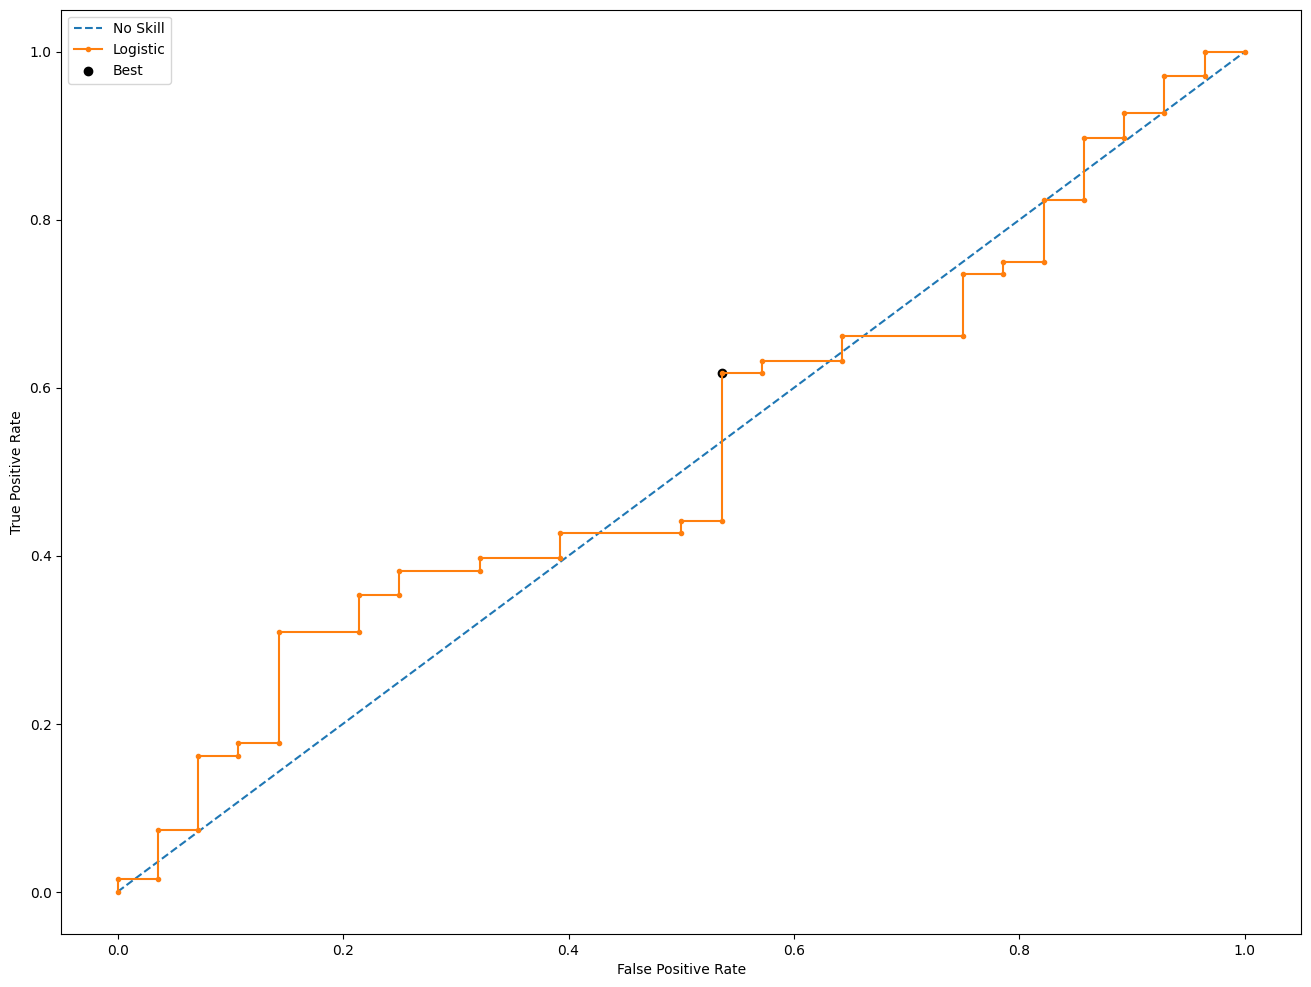

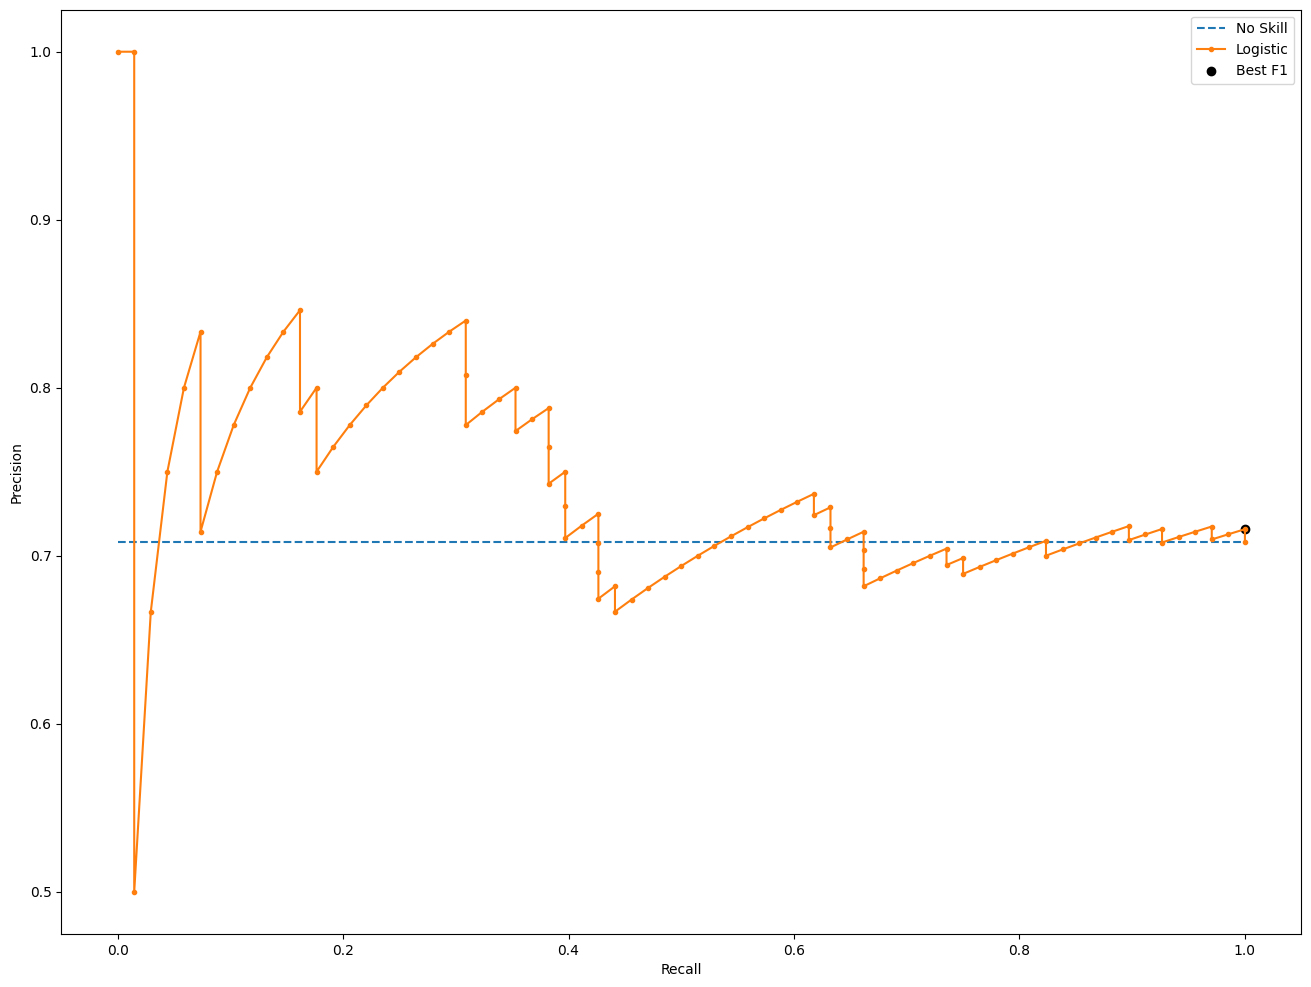

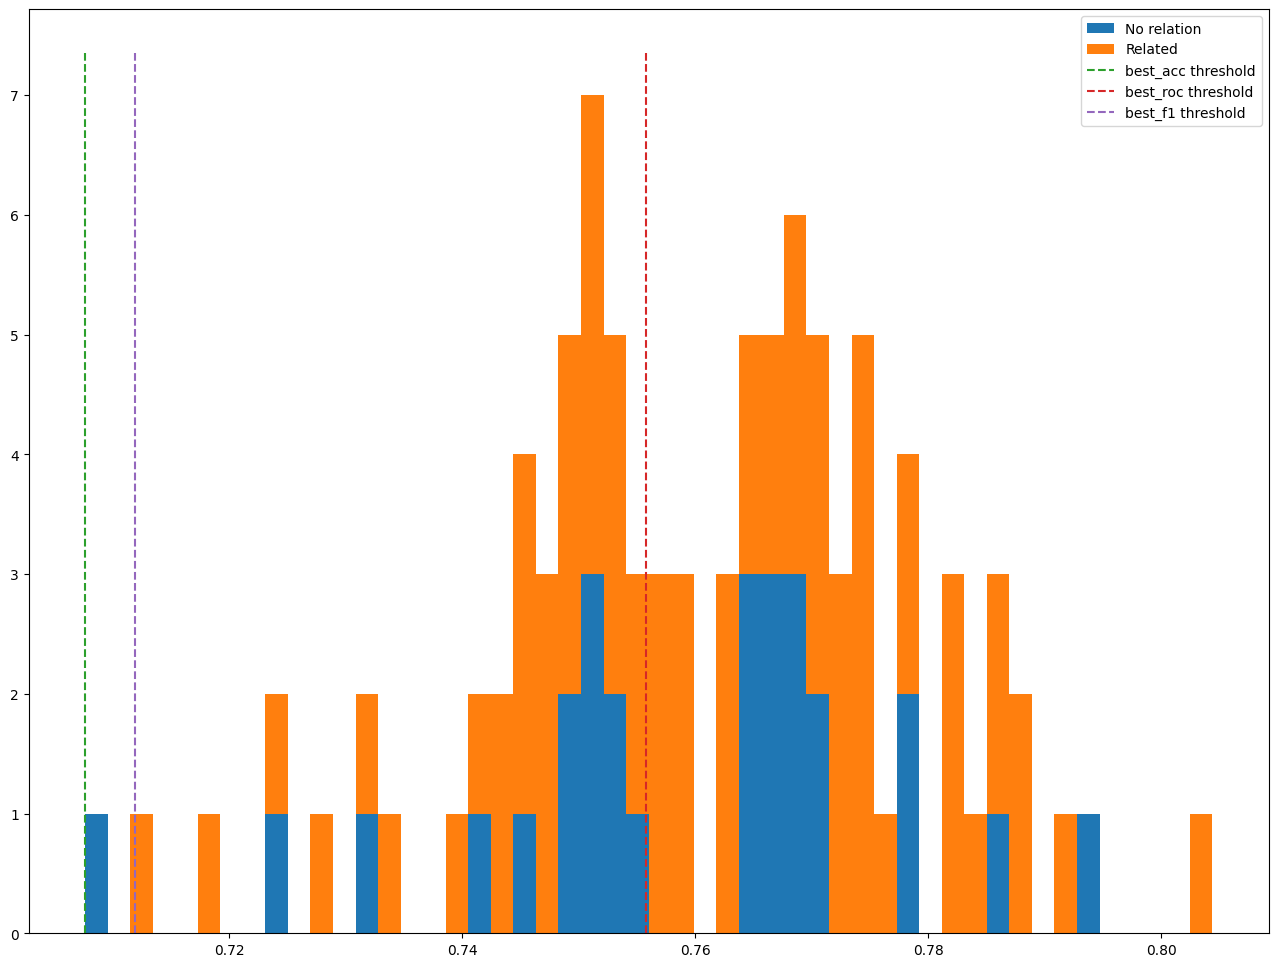

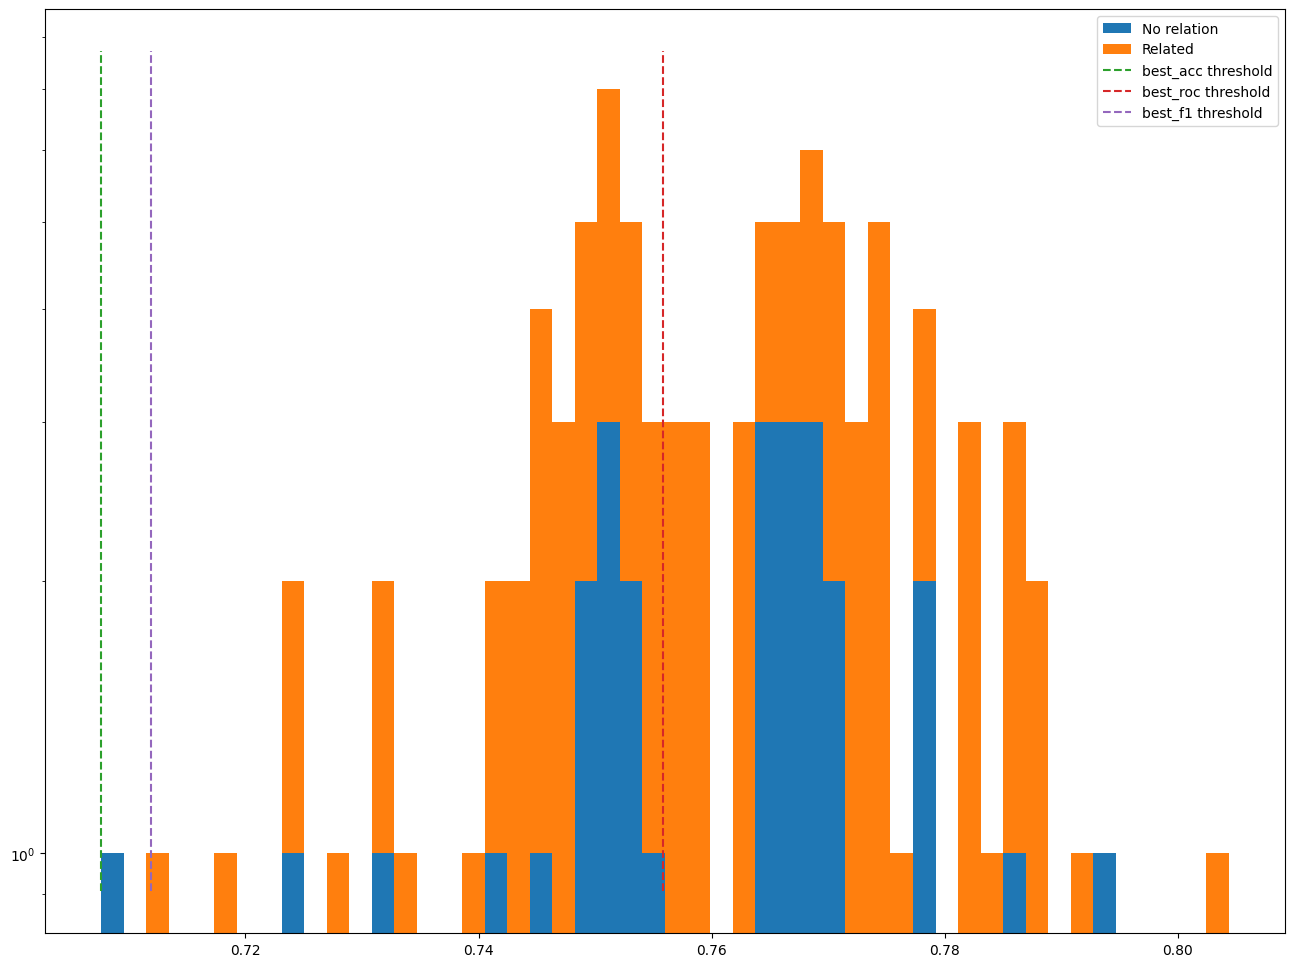

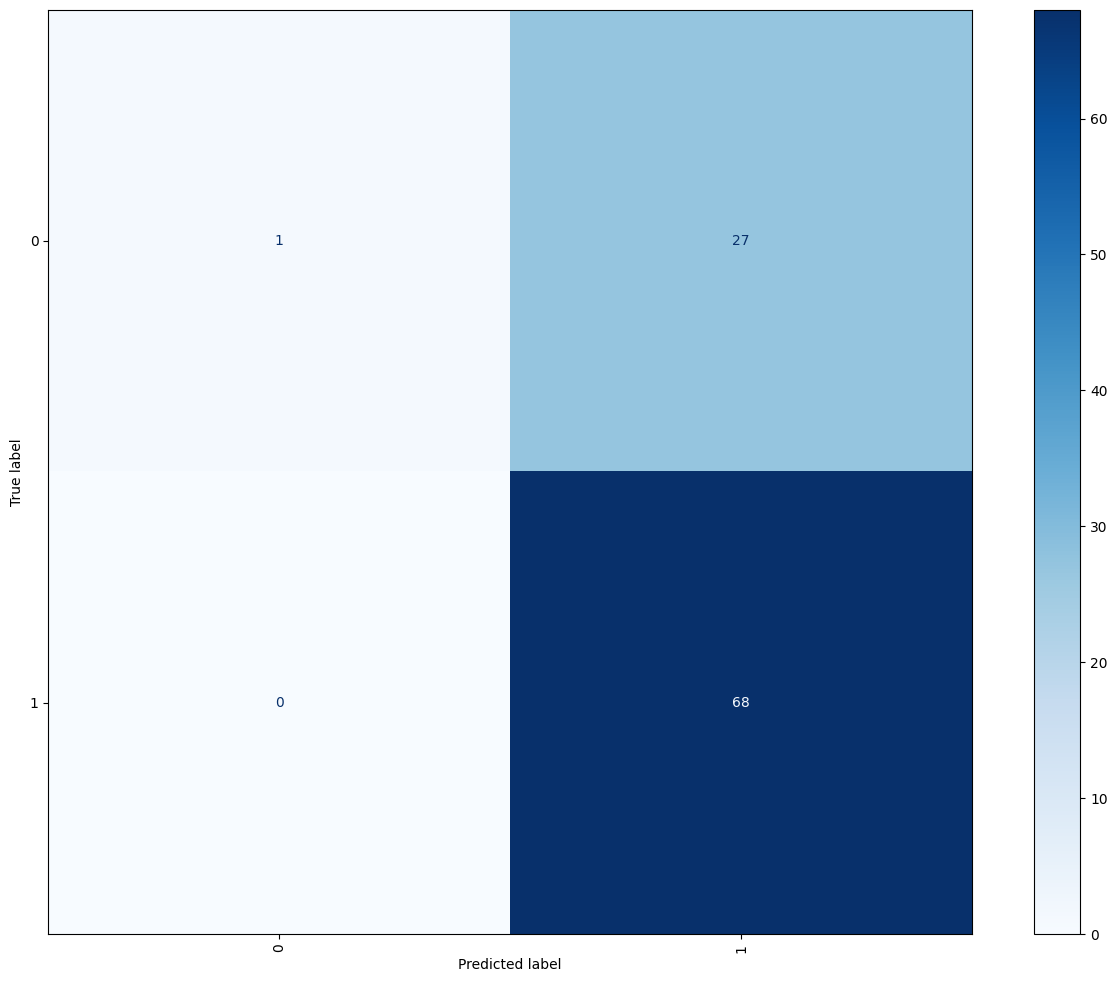

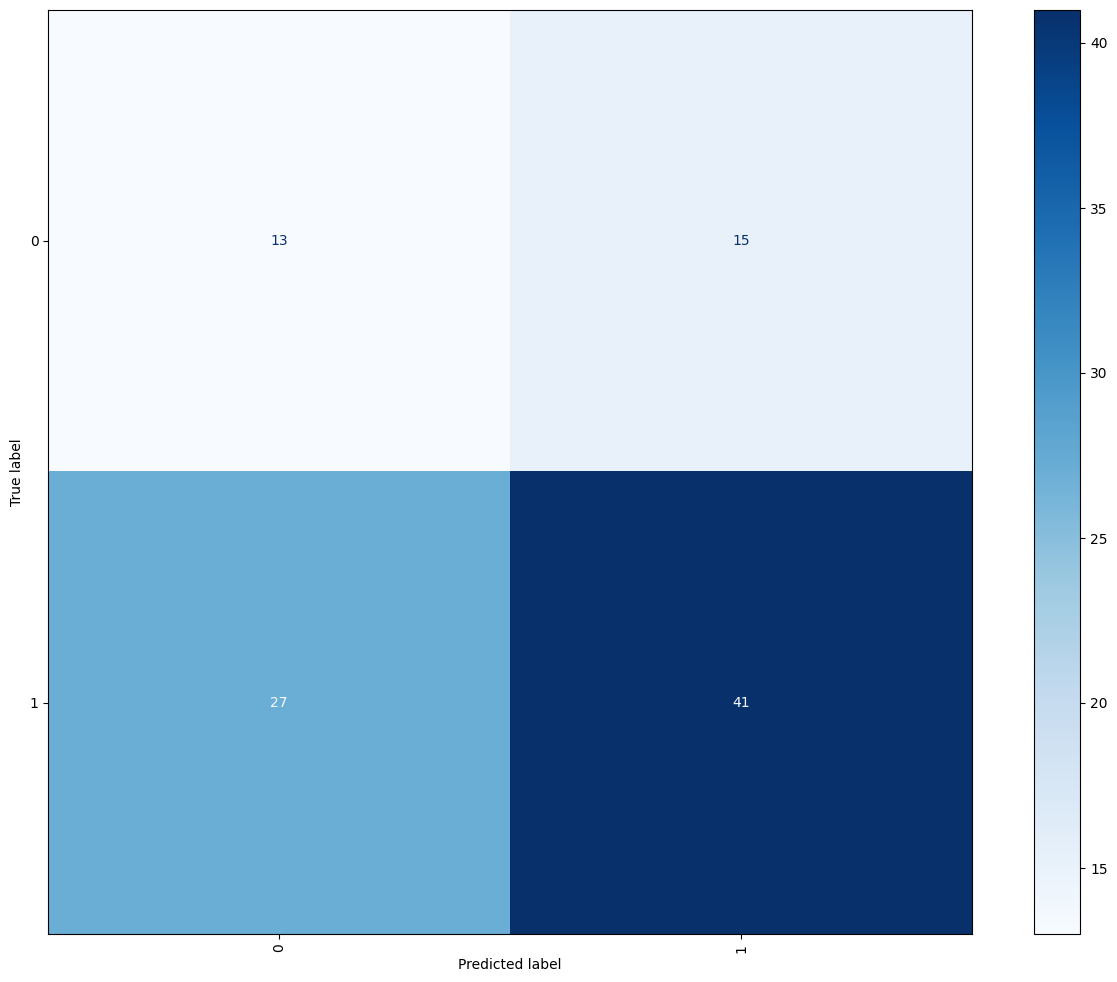

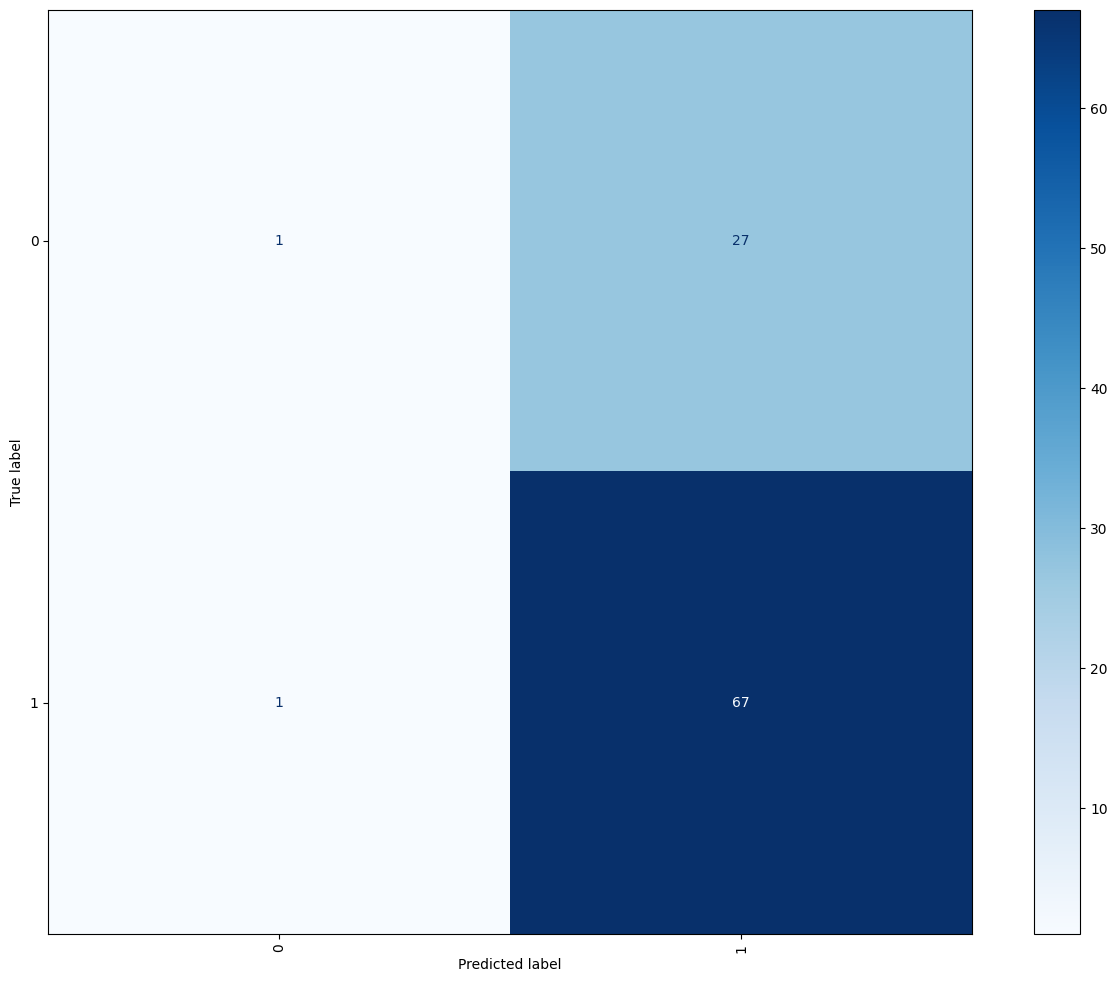

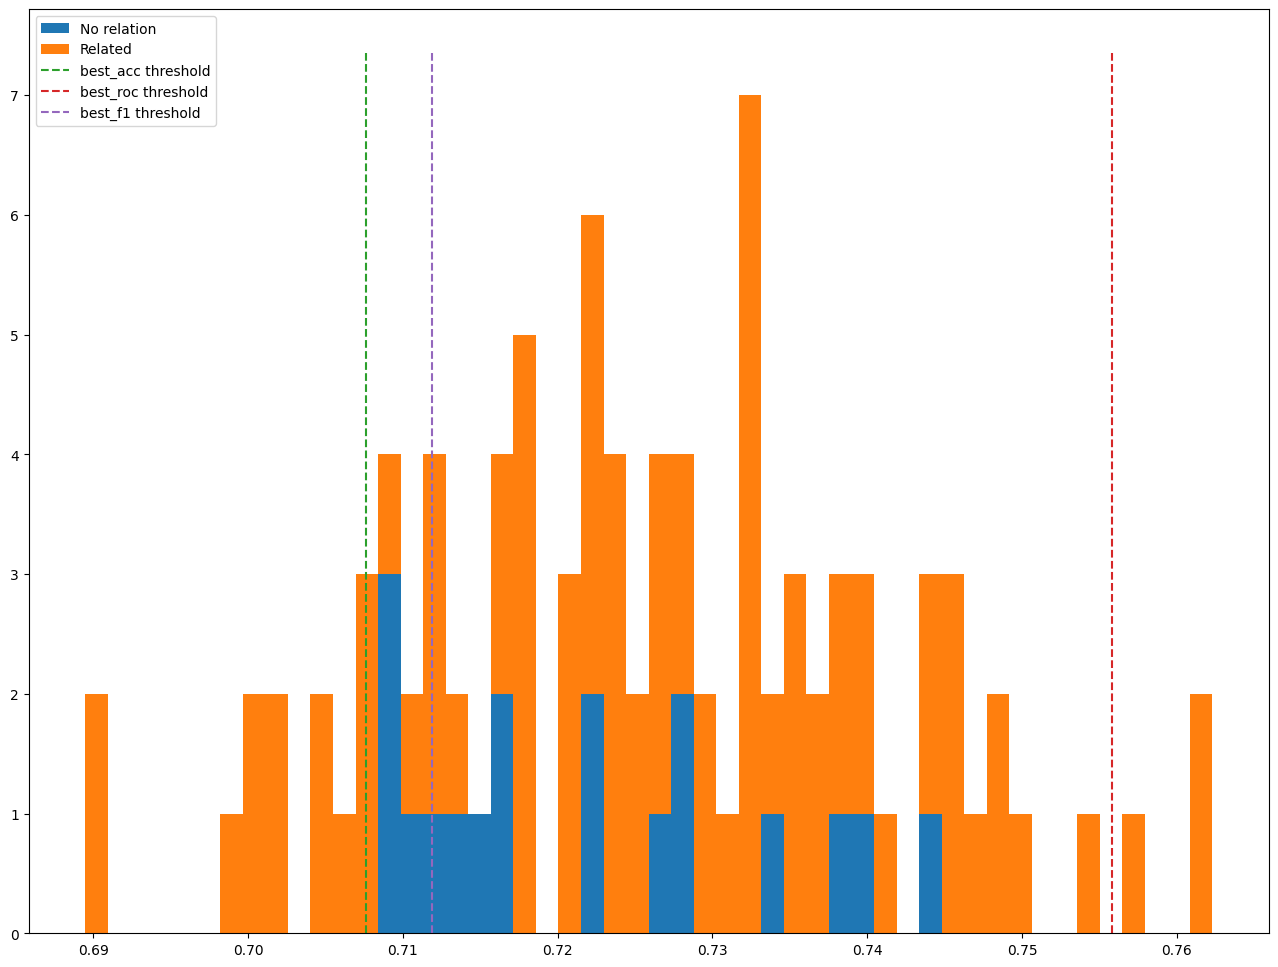

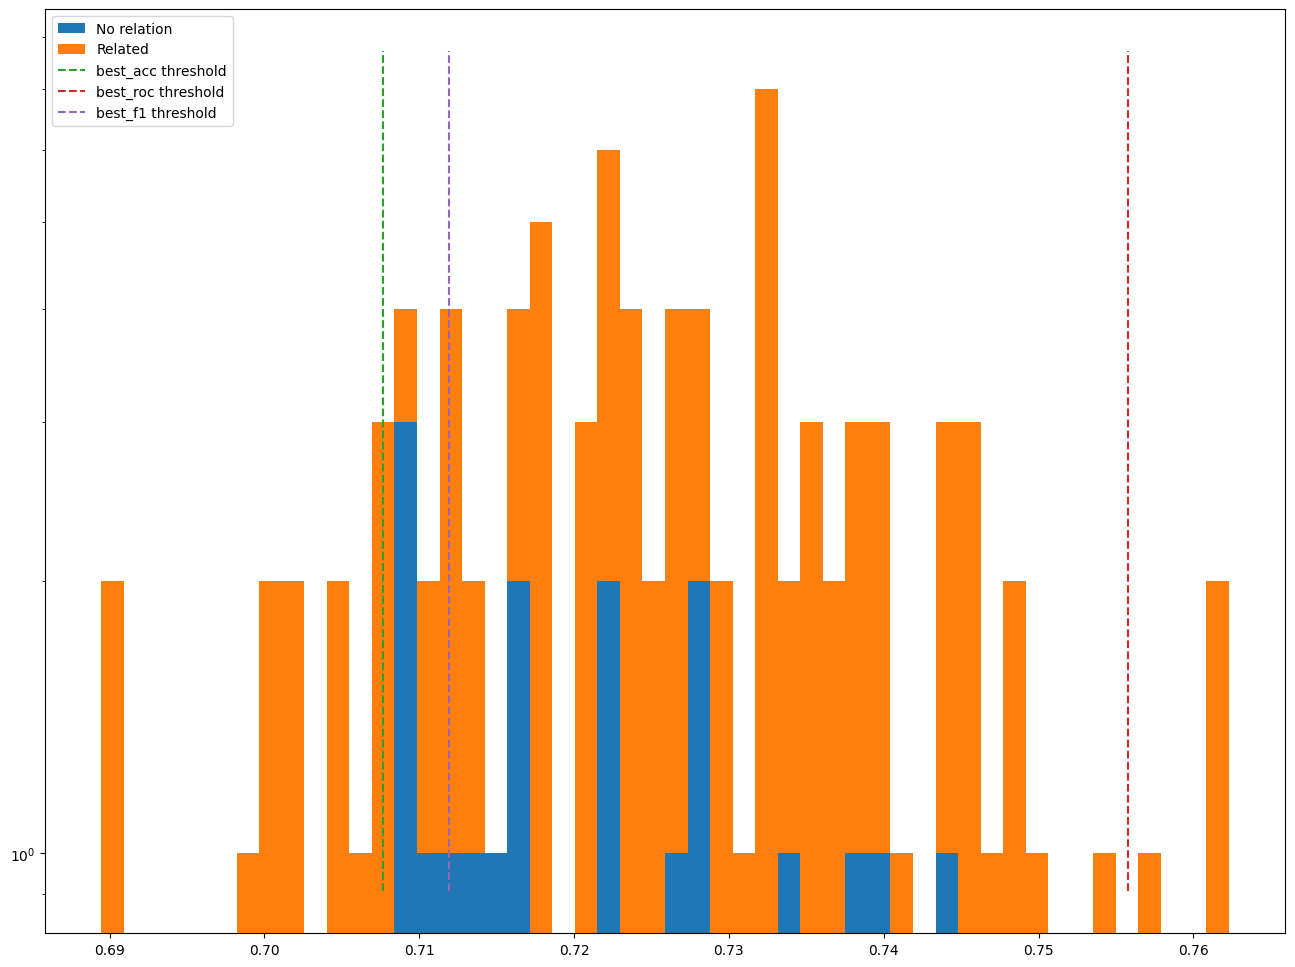

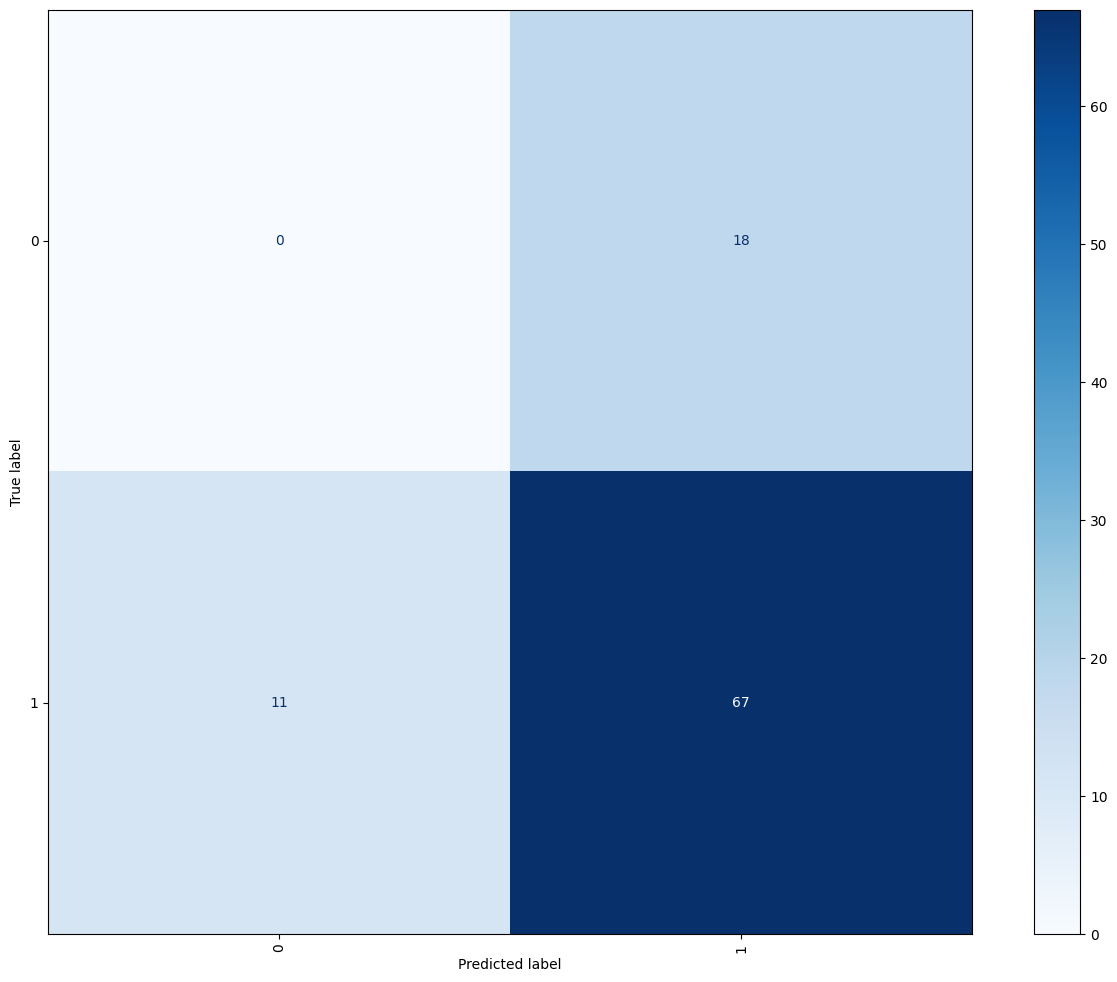

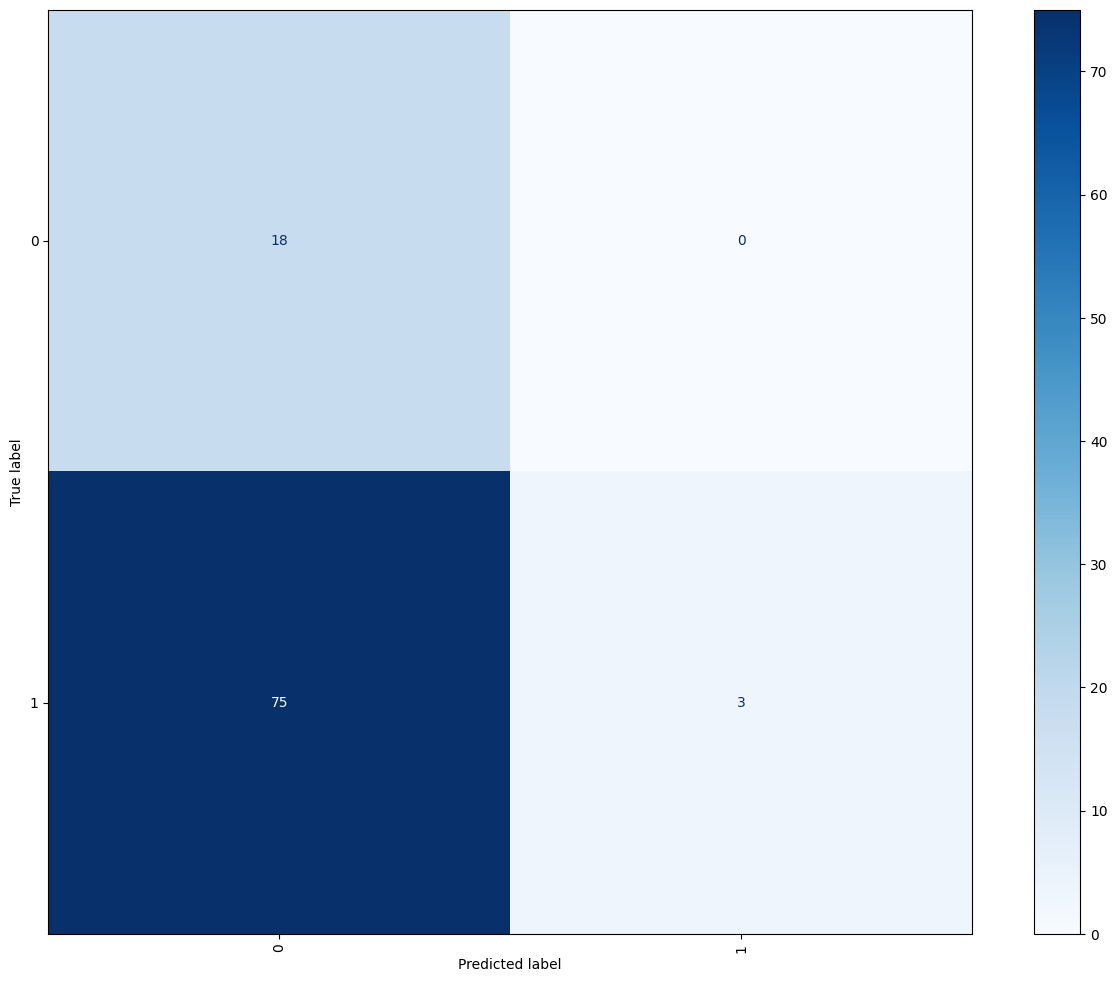

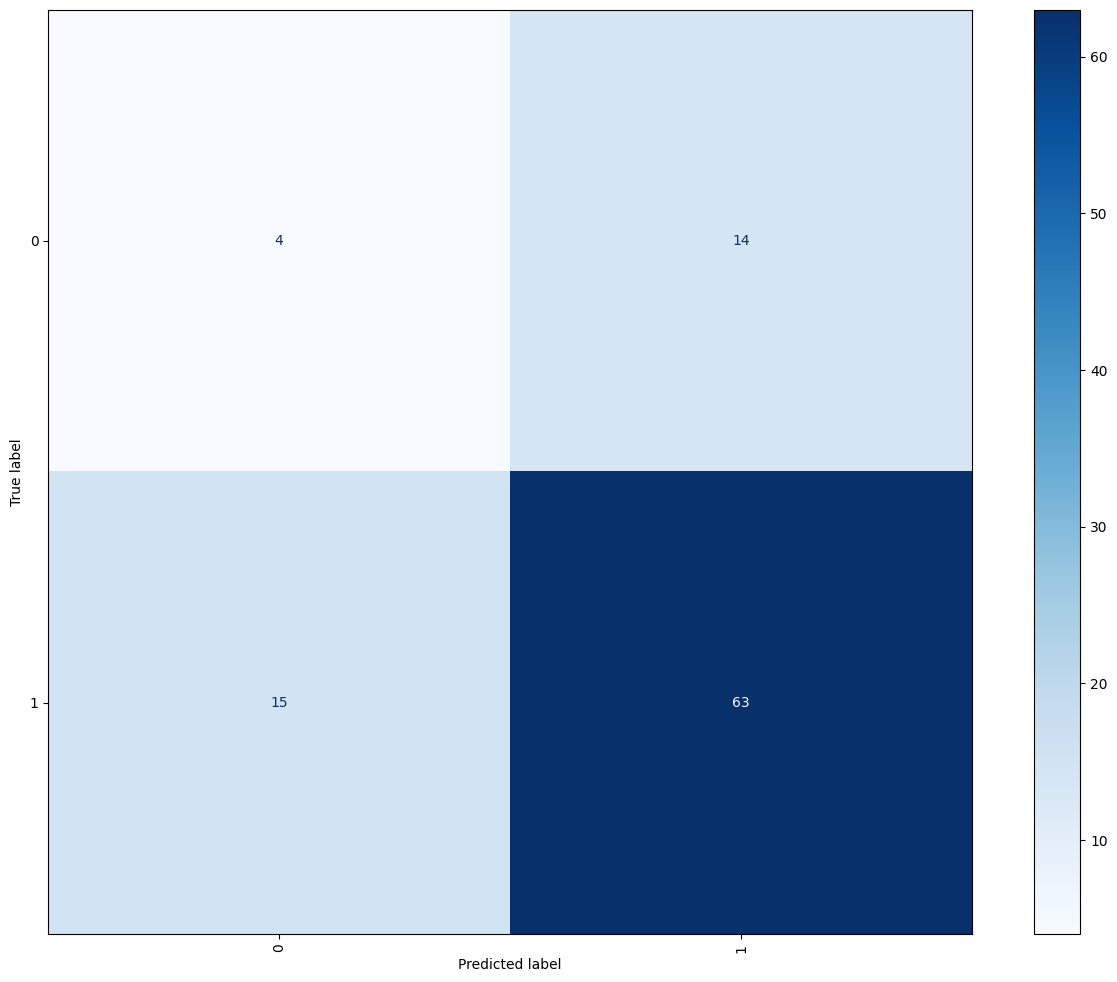

In [19]:
bin_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0YmEyZTg2ZC0zNDMxLTQ2MzItOWEzYS0xOWY5ZGNiYTA5YWYifQ==",
    project="Violetta/BERT"
)

try:
    for i in range(4):
        print(f"--------- EXPERIMENT {i} ---------")
    
        bin_classifier = bin_trainer = None
        gc.collect()
        torch.cuda.empty_cache()
    
        bin_trainer = LightningTrainer(
            accelerator="gpu",
            devices=[0],
            max_epochs=3,
            default_root_dir=CHECKPOINT_DIR,
            deterministic=False,
            enable_checkpointing=True,
            check_val_every_n_epoch=1,
            log_every_n_steps=1,  # 确保 step 递增，防止 Neptune step 乱序
            num_sanity_val_steps=0, # 禁用 Sanity Check 直接进入训练
            logger=bin_logger,
        )
    
        bin_classifier = BinaryClassifier(
            pretrained_language_model=PRETRAINED_MODEL,
            dataset_name=DATASET_NAME,
            batch_size=BIN_BATCH_SIZE,
            learning_rate=BIN_LEARNING_RATE,
            decay_lr_speed=BIN_LEARNING_RATE_DECAY_SPEED,
            linear_size=BIN_LINEAR_SIZE,
            dropout_p=BIN_DROPOUT_P,
            activation_function=BIN_ACTIVATION_FUNCTION,
            weight_decay=BIN_WEIGHT_DECAY,
        )

        bin_trainer.fit(bin_classifier)
        bin_trainer.test(bin_classifier)

except Exception as e:
    # bin_logger.experiment.stop(str(e))
    raise e

# else:
#     bin_logger.experiment.stop()

# Train relation classifier

In [20]:
GPUS = 1
REL_MIN_EPOCHS = REL_MAX_EPOCHS = 4

REL_BATCH_SIZE = 32
REL_LEARNING_RATE = 2e-05
REL_LEARNING_RATE_DECAY_SPEED = [1, 1, 0.75, 0.5, 0.25, 0.1, 0.075, 0.05, 0.025, 0.01]

REL_LINEAR_SIZE = 512

REL_DROPOUT_P = 0.1
REL_ACTIVATION_FUNCTION = "PReLU"
REL_WEIGHT_DECAY = 0.01 # default = 0.01

--------- EXPERIMENT 0 ---------


Exception ignored in: <function GenericDataset.__del__ at 0x000001FB0010BEC0>
Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_11376\1424198635.py", line 28, in __del__
AttributeError: 'GenericDataset' object has no attribute 'file'
Exception ignored in: <function GenericDataset.__del__ at 0x000001FB0010BEC0>
Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_11376\1424198635.py", line 28, in __del__
AttributeError: 'GenericDataset' object has no attribute 'file'
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
E:\Python\Python3.11.5\Lib\site-packages\neptune\internal\utils\git.py:71: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/Violetta/BERT/e/BERTRE-69


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type      | Params | Mode 
----------------------------------------------------------
0 | language_model      | BertModel | 109 M  | eval 
1 | linear              | Linear    | 393 K  | train
2 | linear_output       | Linear    | 9.2 K  | train
3 | dropout             | Dropout   | 0      | train
4 | activation_function | PReLU     | 1      | train
----------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
439.541   Total estimated model params size (MB)
4         Modules in train mode
228       Modules in eval mode
E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
E:\Python\Python3.11.5\Li

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[ 4.2495e-02,  1.4260e-02, -4.1827e-02,  8.8775e-02,  3.3520e-01,
         -9.9843e-02,  2.7941e-02,  6.7092e-03,  1.5271e-01, -4.1191e-02,
          5.3958e-03,  4.7844e-02, -9.9095e-02, -3.1470e-02, -9.7135e-02,
         -2.7370e-01,  1.0342e-01, -3.3821e-02],
        [-3.6979e-02, -1.8992e-02, -1.7252e-01, -2.4925e-02,  3.1955e-01,
         -1.4789e-01,  1.0866e-01,  5.4113e-03,  1.6836e-01, -3.8836e-02,
          1.1131e-01, -2.5868e-02, -1.1820e-01,  5.3990e-02, -2.7225e-01,
         -2.5883e-01,  1.9899e-02, -5.9058e-02],
        [ 3.0697e-02,  5.6078e-02, -1.9930e-01,  7.8529e-02,  4.3501e-01,
         -3.7299e-02,  4.5747e-02,  1.9886e-02,  2.5075e-01, -6.8569e-02,
         -4.8742e-04,  1.5127e-02, -2.8274e-02, -1.8851e-02, -1.4622e-01,
         -3.1095e-01,  1.8440e-01,  4.8521e-02],
        [-2.0284e-02,  5.4039e-02, -3.3103e-02, -1.7662e-02,  3.5957e-01,
         -1.5335e-01,  1.3211e-01,  4.0157e-02,  9.2347e

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[ 5.5583e-02,  9.8832e-02, -2.4221e-01,  3.7687e-02,  4.5737e-01,
         -1.1400e-01,  8.7161e-02,  8.8861e-02,  3.1282e-01, -4.3309e-02,
          3.2105e-04, -4.3534e-02, -2.0567e-01, -3.4187e-02, -3.6328e-01,
         -3.7304e-01, -4.2269e-02, -2.0654e-01],
        [ 7.7591e-02,  7.0531e-02, -3.1532e-01,  1.0490e-01,  4.1553e-01,
         -1.5678e-01,  3.2826e-02,  9.8457e-02,  2.5522e-01, -1.2652e-02,
          6.1259e-02, -1.4258e-01, -1.6607e-01,  2.2879e-02, -3.1093e-01,
         -2.6448e-01,  2.1670e-02, -1.3960e-01],
        [ 1.0628e-01,  1.6873e-01, -4.0484e-01,  8.9615e-02,  5.9953e-01,
         -2.0366e-01,  9.8161e-02,  5.1520e-02,  4.0345e-01,  5.9391e-02,
         -2.3435e-02, -1.4569e-01, -2.4360e-01, -6.3581e-02, -4.2295e-01,
         -3.8541e-01,  3.4219e-02, -8.0412e-02],
        [ 1.6755e-02,  2.3836e-01, -2.6949e-01,  9.2310e-02,  4.7504e-01,
         -1.4788e-01, -6.1374e-02,  1.2796e-01,  2.8746e

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 4.0


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[ 3.3379e-02,  1.2434e-01, -3.0562e-01,  2.4063e-02,  5.5437e-01,
         -1.1480e-01,  1.6008e-01,  1.0237e-01,  3.2085e-01,  3.2795e-02,
         -2.8424e-03,  5.3277e-02, -1.4556e-01, -2.4205e-02, -3.0697e-01,
         -3.8166e-01, -6.6874e-02, -1.8167e-01],
        [ 3.2461e-02,  1.3849e-01, -2.7351e-01,  1.3648e-02,  5.4889e-01,
         -7.6471e-02,  3.6320e-02,  9.2322e-02,  2.4511e-01,  6.4933e-02,
          1.4794e-02,  1.2050e-02, -2.1638e-01, -3.6663e-02, -3.5126e-01,
         -3.7579e-01, -6.2198e-02, -1.5672e-01],
        [ 5.2103e-02,  9.4376e-02, -3.0108e-01,  1.4527e-01,  3.8845e-01,
         -2.5304e-02,  1.2808e-01,  9.8909e-02,  2.3705e-01,  4.0927e-02,
         -4.6767e-02,  1.0586e-02, -9.6622e-02, -7.3087e-02, -3.1907e-01,
         -3.8502e-01, -1.1055e-01, -2.0125e-01],
        [ 7.8184e-02,  7.8944e-02, -1.9717e-01,  1.2180e-01,  3.7042e-01,
         -7.5396e-02,  1.2688e-01,  8.1115e-02,  1.4412e

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
`Trainer.fit` stopped: `max_epo

Testing: |          | 0/? [00:00<?, ?it/s]

[DEBUG] test_step_outputs before eval: [{'logits': tensor([[ 1.3096e-01,  2.1066e-01, -3.6125e-01,  7.8962e-02,  7.3828e-01,
          8.0060e-02,  2.0183e-01,  1.0090e-01,  1.8466e-01, -3.5155e-03,
          7.5028e-02, -6.5472e-02, -1.3963e-01, -5.1692e-02, -3.3717e-01,
         -2.8846e-01, -9.3438e-02, -1.9453e-01],
        [ 1.2882e-01,  2.7904e-01, -4.9614e-01,  5.7083e-02,  7.4490e-01,
         -5.0318e-02,  1.9144e-01,  4.2480e-02,  1.8502e-01,  3.9746e-02,
          5.4435e-02, -1.3056e-01, -2.0454e-01,  8.5840e-03, -3.2502e-01,
         -3.6936e-01, -6.9648e-02, -2.8024e-01],
        [ 9.8116e-02,  3.9982e-01, -3.0560e-01,  1.0569e-01,  6.5863e-01,
          1.4383e-02,  1.0623e-01,  1.0499e-01,  2.4444e-01, -1.0740e-02,
          1.0084e-01, -1.3915e-01, -1.7053e-01, -2.3944e-02, -3.5737e-01,
         -3.6059e-01, -2.7647e-02, -2.2169e-01],
        [ 9.0009e-02,  1.8288e-01, -4.2818e-01,  6.2877e-02,  7.2997e-01,
          4.1095e-02,  1.6502e-01,  8.3798e-02,  2.6640e-01, -

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     2.774334669113159     │
│       test_test_acc       │    0.1145833358168602     │
│    test_test_avg_loss     │     2.774334669113159     │
│    test_test_f1_macro     │   0.014686248265206814    │
│   test_test_f1_weighted   │   0.023559190332889557    │
│    test_test_pre_macro    │    0.00818452425301075    │
│  test_test_pre_weighted   │    0.01312934048473835    │
│    test_test_rec_macro    │    0.0714285746216774     │
│  test_test_rec_weighted   │    0.1145833358168602     │
└───────────────────────────┴───────────────────────────┘

Exception ignored in: <function GenericDataset.__del__ at 0x000001FB0010BEC0>
Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_11376\1424198635.py", line 28, in __del__
AttributeError: 'GenericDataset' object has no attribute 'file'
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


--------- EXPERIMENT 1 ---------


E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory E:\Python\TextMining\BERT\.neptune\BERTRE-69\BERTRE-69\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type      | Params | Mode 
----------------------------------------------------------
0 | language_model      | BertModel | 109 M  | eval 
1 | linear              | Linear    | 393 K  | train
2 | linear_output       | Linear    | 9.2 K  | train
3 | dropout             | Dropout   | 0      | train
4 | activation_function | PReLU     | 1      | train
----------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
439.541   Total estimated model params size (MB)
4         Modules in train mode
228       Modules in eval mode
E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloade

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[ 3.2194e-02,  3.2408e-02, -2.1539e-01,  1.0097e-01,  1.9345e-01,
         -1.3199e-01,  1.2650e-01,  6.6263e-02,  2.0137e-01,  2.5435e-02,
          1.3241e-02,  9.7712e-04, -9.1575e-02,  1.4463e-01, -9.5554e-02,
         -4.6351e-02,  2.4427e-02,  9.3599e-02],
        [ 1.2034e-01,  1.0567e-01, -1.9637e-02,  2.2854e-01,  3.4946e-01,
         -2.2199e-01,  2.2152e-01,  7.6900e-02,  6.1512e-02,  1.8602e-01,
         -9.8089e-02, -1.6624e-01, -1.4529e-01, -5.2124e-02, -2.0453e-01,
          4.7412e-02,  6.1620e-02, -2.3258e-02],
        [-1.1670e-02,  1.1306e-01, -1.2428e-01,  3.0265e-01,  1.9226e-01,
         -1.3819e-01,  2.8579e-01,  3.7237e-02,  1.5437e-01,  9.3824e-02,
         -6.8203e-02, -1.7277e-01, -1.8655e-01,  8.1502e-02, -1.7402e-01,
         -4.6602e-02,  4.3670e-02, -8.8680e-02],
        [ 4.6069e-02,  8.9840e-02, -1.3097e-01,  2.3162e-01,  1.7439e-01,
         -2.0366e-01,  2.3139e-01, -6.7026e-02,  1.1806e

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[-5.7164e-02,  1.0943e-01, -2.0062e-01,  3.1283e-01,  3.3883e-01,
         -1.1114e-01,  3.9445e-01,  7.6897e-02,  2.3303e-01,  1.6753e-01,
          9.6888e-02, -1.9060e-01, -2.1985e-01, -1.1491e-02, -1.6909e-01,
         -2.0771e-02, -9.6932e-02, -2.0850e-01],
        [ 2.6038e-02,  7.2617e-02, -8.8422e-02,  3.0331e-01,  3.5306e-01,
         -1.4253e-01,  3.4023e-01,  1.2789e-01,  3.9304e-01,  2.0208e-01,
          3.7730e-03, -1.3648e-01, -1.8503e-01,  1.4261e-02, -2.5785e-01,
         -1.4134e-01, -6.1312e-02, -2.0890e-01],
        [-1.0973e-02,  1.3169e-01, -1.5525e-01,  3.6001e-01,  3.7137e-01,
         -1.3481e-01,  4.5878e-01,  3.4789e-02,  2.8142e-01,  2.2259e-01,
          3.2291e-02, -9.4525e-02, -2.7216e-01, -4.8722e-02, -2.8626e-01,
         -1.2253e-01, -7.3608e-02, -2.1708e-01],
        [ 3.1240e-02,  1.6985e-01, -2.5761e-01,  3.0296e-01,  2.9373e-01,
         -1.0173e-01,  3.7544e-01,  1.6508e-01,  3.9726e

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[ 1.2329e-01,  1.9946e-01, -1.4202e-01,  3.6664e-01,  4.1912e-01,
         -2.0779e-01,  5.9093e-01,  1.9100e-01,  3.1132e-01,  2.3499e-01,
          1.9923e-01,  7.6824e-02, -4.1263e-01, -1.1931e-01, -4.0275e-01,
         -2.1880e-01, -1.2919e-01, -4.0575e-01],
        [ 1.3818e-01,  1.5283e-01, -2.0174e-01,  4.0297e-01,  3.5025e-01,
         -2.6483e-01,  5.6056e-01,  2.3067e-01,  4.7677e-01,  1.2110e-01,
          4.6578e-02, -3.1244e-02, -2.6954e-01, -1.0639e-01, -3.9641e-01,
         -1.8538e-01, -1.1032e-01, -2.9707e-01],
        [ 3.8444e-02,  3.2941e-02, -4.6161e-01,  3.9739e-01,  3.4098e-01,
         -1.3772e-01,  3.5908e-01,  1.2230e-01,  6.0582e-01,  2.2283e-01,
          1.4365e-01, -3.5357e-02, -1.7482e-01, -7.9286e-03, -2.4912e-01,
         -1.6793e-01, -2.0804e-01, -4.0766e-01],
        [ 7.9849e-03,  2.9328e-01, -1.5413e-01,  4.7026e-01,  4.4542e-01,
         -1.5158e-01,  4.7085e-01,  1.4860e-01,  3.5526e

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
`Trainer.fit` stopped: `max_epo

Testing: |          | 0/? [00:00<?, ?it/s]

[DEBUG] test_step_outputs before eval: [{'logits': tensor([[-0.2186,  0.0266, -0.2056,  0.3441,  0.3758, -0.1328,  0.5352,  0.0214,
          0.1897,  0.1990,  0.1659, -0.0542, -0.1390,  0.0477, -0.2718, -0.2031,
         -0.1123, -0.3023],
        [-0.0683,  0.1130, -0.1687,  0.4237,  0.4397, -0.1490,  0.4520,  0.1443,
          0.2651,  0.2122,  0.1695, -0.1140, -0.1528,  0.0833, -0.3084, -0.1821,
         -0.2257, -0.3824],
        [-0.1343,  0.1111, -0.1790,  0.4270,  0.3820, -0.1867,  0.4344,  0.0600,
          0.2447,  0.1674,  0.0196, -0.1326, -0.1807,  0.0246, -0.3215, -0.2024,
         -0.1920, -0.3855],
        [-0.2029,  0.1476, -0.2156,  0.4349,  0.5185, -0.1445,  0.5419,  0.0421,
          0.3275,  0.2711,  0.2234, -0.2016, -0.2604,  0.0470, -0.3534, -0.1180,
         -0.1311, -0.3636],
        [-0.0455,  0.1846, -0.3027,  0.4282,  0.2898, -0.1087,  0.4402,  0.0858,
          0.2125,  0.1809,  0.3912, -0.0323, -0.3072,  0.0524, -0.1859, -0.2977,
         -0.2365, -0.3019],

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     2.728792190551758     │
│       test_test_acc       │    0.2083333283662796     │
│    test_test_avg_loss     │     2.728792190551758     │
│    test_test_f1_macro     │    0.0793568342924118     │
│   test_test_f1_weighted   │    0.10655844211578369    │
│    test_test_pre_macro    │    0.06156108155846596    │
│  test_test_pre_weighted   │    0.0798378586769104     │
│    test_test_rec_macro    │    0.13852813839912415    │
│  test_test_rec_weighted   │    0.2083333283662796     │
└───────────────────────────┴───────────────────────────┘

--------- EXPERIMENT 2 ---------


Exception ignored in: <function GenericDataset.__del__ at 0x000001FB0010BEC0>
Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_11376\1424198635.py", line 28, in __del__
AttributeError: 'GenericDataset' object has no attribute 'file'
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory E:\Python\TextMining\BERT\.neptune\BERTRE-69\BERTRE-69\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type      | Params | Mode 
----------------------------------------------------------
0 | language_model      | BertModel | 109 M  | eval 
1 | linear              | Linear    | 393 K  | train
2 | linear_output       | Linear    | 9.2 K  | train
3 | dropout             | Dropout   | 0      | train
4 | activation_function | PReLU     | 1   

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[ 5.5055e-02, -2.4122e-02,  1.1930e-02,  2.7822e-02,  2.2439e-01,
          3.2432e-02, -1.2277e-01, -7.0494e-03,  1.0649e-02, -4.3680e-02,
          2.3047e-02,  3.2788e-02, -1.5705e-01,  5.2226e-02, -1.0961e-01,
         -1.0708e-01, -1.3467e-01, -1.3150e-01],
        [ 6.6307e-02,  2.6004e-03, -8.9918e-03,  2.4940e-02,  3.3477e-01,
         -3.8317e-02, -1.4464e-01, -8.7245e-02,  3.8387e-02, -5.1685e-02,
          8.3464e-02,  6.8513e-02, -1.8324e-01, -2.3363e-02, -1.5641e-01,
         -1.6463e-01, -1.9811e-01, -1.3455e-01],
        [ 1.1695e-02,  2.8469e-03, -3.5289e-02,  8.1766e-02,  2.8723e-01,
         -1.3492e-03, -6.1072e-02, -3.6983e-02, -3.3662e-02, -6.1397e-02,
          4.7726e-02,  4.9363e-02, -1.8921e-01, -7.2600e-02, -1.7158e-01,
         -1.3188e-01, -1.3747e-01, -1.4594e-01],
        [-1.9346e-02, -1.6419e-02, -3.0087e-02,  4.4740e-02,  2.7630e-01,
          6.2950e-02, -9.8664e-02, -2.4029e-02, -4.0389e

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[ 7.9837e-02,  8.6231e-02, -1.2273e-01,  1.4220e-01,  5.7732e-01,
         -1.7116e-02, -4.9610e-02,  4.0540e-02,  8.5859e-02,  6.3877e-02,
          4.7244e-02,  6.8298e-02, -3.0541e-01, -9.9589e-02, -3.0596e-01,
         -2.6619e-01, -2.3691e-01, -2.7117e-01],
        [ 6.8439e-02,  1.0130e-01, -4.2213e-02,  5.4638e-02,  6.6345e-01,
         -3.6881e-02, -2.3772e-02, -3.0081e-02,  1.8687e-01,  8.1018e-02,
          1.7650e-02,  8.0145e-02, -3.5459e-01, -2.5708e-05, -3.7770e-01,
         -2.4502e-01, -1.9361e-01, -3.1540e-01],
        [ 1.9185e-01,  6.9194e-02, -5.3509e-02,  1.1339e-01,  6.4474e-01,
         -9.2080e-02, -8.0954e-02, -1.6499e-01,  8.4575e-02,  8.3189e-03,
          9.2890e-02,  8.3104e-02, -3.8861e-01,  2.8916e-02, -3.1544e-01,
         -2.0697e-01, -2.6332e-01, -2.7606e-01],
        [ 1.7838e-01,  9.8266e-02, -6.7802e-02,  1.9927e-01,  5.0941e-01,
         -3.3301e-02, -3.8332e-02, -1.3426e-02, -1.1446e

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[ 0.1054,  0.1149, -0.1428,  0.1487,  0.4208,  0.0975, -0.1177, -0.0743,
          0.2348,  0.0106,  0.0909,  0.0851, -0.3434,  0.0492, -0.2793, -0.2924,
         -0.2530, -0.2955],
        [ 0.1390,  0.1181, -0.1606,  0.1747,  0.4943,  0.0994, -0.1077, -0.1464,
          0.2299,  0.0354,  0.1163,  0.1401, -0.3555, -0.0047, -0.3193, -0.2922,
         -0.2902, -0.3629],
        [ 0.0818,  0.1421, -0.1131,  0.1734,  0.4779,  0.0286, -0.1652, -0.0221,
          0.2442,  0.0029,  0.1022,  0.1170, -0.4085,  0.0807, -0.3466, -0.2889,
         -0.2729, -0.3888],
        [-0.0054,  0.1540, -0.1878,  0.1315,  0.4901,  0.1049, -0.1551, -0.1277,
          0.2724, -0.0007,  0.0798,  0.0731, -0.3418,  0.0437, -0.2866, -0.2848,
         -0.2769, -0.3481],
        [ 0.0724,  0.1013, -0.1929,  0.1855,  0.3967,  0.0223, -0.1147,  0.0177,
          0.2916,  0.0389,  0.0796,  0.0923, -0.3564,  0.0615, -0.2507, -0.2598,
         -0.2382, -0.

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
`Trainer.fit` stopped: `max_epo

Testing: |          | 0/? [00:00<?, ?it/s]

[DEBUG] test_step_outputs before eval: [{'logits': tensor([[ 7.7875e-02,  1.2376e-01, -1.7424e-01,  1.7382e-01,  5.9270e-01,
          6.8777e-02, -9.6783e-02, -6.6943e-02,  2.5954e-01, -1.0570e-02,
          1.3378e-01,  1.3585e-01, -3.9890e-01, -4.8977e-03, -3.4586e-01,
         -2.8500e-01, -3.4296e-01, -3.8982e-01],
        [ 7.7556e-02,  2.4576e-01, -2.1685e-01,  8.1421e-02,  6.6278e-01,
          1.3348e-01, -7.5843e-02, -4.2518e-03,  3.5174e-01, -5.7594e-02,
          1.5471e-01,  1.6302e-01, -3.8357e-01, -8.0816e-04, -3.9072e-01,
         -3.8313e-01, -3.9697e-01, -3.6198e-01],
        [ 4.2231e-02,  2.0199e-01, -1.6145e-01,  9.7902e-02,  6.0331e-01,
          6.6807e-02, -1.7740e-01, -8.8673e-02,  2.9049e-01, -4.9786e-02,
          1.7306e-01,  1.0851e-01, -3.8872e-01,  6.6439e-02, -3.0641e-01,
         -3.8951e-01, -3.6726e-01, -3.4832e-01],
        [ 1.6277e-01,  2.0421e-01, -2.1846e-01,  1.2069e-01,  6.8008e-01,
          1.3019e-01, -4.2700e-02, -7.2981e-02,  2.4749e-01, -

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     2.763054132461548     │
│       test_test_acc       │    0.1145833358168602     │
│    test_test_avg_loss     │     2.763054132461548     │
│    test_test_f1_macro     │   0.014686248265206814    │
│   test_test_f1_weighted   │   0.023559190332889557    │
│    test_test_pre_macro    │    0.00818452425301075    │
│  test_test_pre_weighted   │    0.01312934048473835    │
│    test_test_rec_macro    │    0.0714285746216774     │
│  test_test_rec_weighted   │    0.1145833358168602     │
└───────────────────────────┴───────────────────────────┘

--------- EXPERIMENT 3 ---------


Exception ignored in: <function GenericDataset.__del__ at 0x000001FB0010BEC0>
Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_11376\1424198635.py", line 28, in __del__
AttributeError: 'GenericDataset' object has no attribute 'file'
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory E:\Python\TextMining\BERT\.neptune\BERTRE-69\BERTRE-69\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type      | Params | Mode 
----------------------------------------------------------
0 | language_model      | BertModel | 109 M  | eval 
1 | linear              | Linear    | 393 K  | train
2 | linear_output       | Linear    | 9.2 K  | train
3 | dropout             | Dropout   | 0      | train
4 | activation_function | PReLU     | 1   

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[-8.5700e-02, -4.8127e-02, -1.0009e-01,  1.8454e-01,  9.9835e-02,
          5.5411e-02,  1.5516e-01, -1.4163e-02,  2.1279e-02, -8.8111e-02,
         -8.7998e-02,  9.2622e-02, -1.1194e-01, -1.0607e-01, -2.0811e-01,
          5.5839e-03, -2.4705e-01, -2.1867e-01],
        [-7.0430e-02, -2.4986e-02, -2.7743e-01,  2.9932e-01,  9.5455e-02,
         -7.6174e-02,  1.1661e-01, -1.7344e-01, -4.0609e-02, -8.0196e-02,
         -3.2715e-02,  2.0248e-01, -6.3551e-02,  5.6621e-02, -2.2667e-01,
          1.8203e-02, -6.4106e-02, -1.2765e-01],
        [-7.6206e-02, -5.3926e-02, -1.2455e-01,  2.2756e-01,  1.3556e-01,
          2.1975e-02,  9.3851e-02, -1.4539e-01,  2.3536e-02, -2.2519e-02,
         -7.6738e-02,  6.7549e-02, -1.2996e-01, -5.5399e-02, -1.7733e-01,
         -2.5627e-03, -1.5971e-01, -1.4436e-01],
        [-2.0196e-01, -8.1517e-02, -1.0628e-01,  2.3103e-01,  1.9342e-01,
         -1.8456e-02,  1.4397e-01, -6.9168e-02, -1.3637e

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[-0.1046, -0.0592, -0.3846,  0.2456,  0.6345, -0.0166,  0.1288, -0.0136,
         -0.1276, -0.0549, -0.1099,  0.2605, -0.4028, -0.2224, -0.3915, -0.0127,
         -0.2389, -0.4532],
        [-0.0559, -0.0981, -0.2726,  0.2418,  0.6651,  0.1169,  0.1749, -0.0837,
         -0.1478, -0.0800, -0.0794,  0.0693, -0.3413, -0.2938, -0.4105, -0.0016,
         -0.2183, -0.2651],
        [-0.0965, -0.0590, -0.2601,  0.1765,  0.5211,  0.0588,  0.2284, -0.0204,
         -0.1143, -0.0369, -0.0967,  0.0921, -0.2861, -0.1816, -0.3174,  0.0370,
         -0.2598, -0.3067],
        [-0.1153, -0.0536, -0.2223,  0.1863,  0.4307,  0.0936,  0.3003,  0.0010,
         -0.0574, -0.0768, -0.0740,  0.0400, -0.2468, -0.1353, -0.3508, -0.0543,
         -0.2584, -0.3515],
        [-0.0907, -0.1079, -0.3693,  0.3216,  0.6034,  0.1123,  0.1707,  0.0102,
          0.0136, -0.1110, -0.2023,  0.0716, -0.3047, -0.1467, -0.4179, -0.0658,
         -0.2457, -0.

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[-7.4179e-02, -1.7815e-01, -4.9204e-01,  2.3113e-01,  1.1726e+00,
          1.4550e-01,  7.3757e-02, -3.6973e-02, -1.5313e-01, -5.3915e-02,
         -4.1627e-02,  2.4210e-01, -4.9738e-01, -3.9990e-01, -5.4879e-01,
         -2.0533e-01, -3.3981e-01, -5.7232e-01],
        [-6.6791e-02,  1.3637e-02, -4.0383e-01,  3.3085e-01,  8.0202e-01,
          1.0488e-02,  1.3722e-02,  7.9647e-02, -6.4814e-02, -1.8535e-02,
         -9.2080e-02,  2.5749e-01, -5.0503e-01, -2.6579e-01, -3.7187e-01,
         -6.1649e-02, -2.0719e-01, -5.1985e-01],
        [-1.0359e-01, -9.7214e-03, -4.3484e-01,  3.5689e-01,  6.5400e-01,
         -6.5066e-02,  1.5176e-01, -5.8598e-02, -5.4945e-02, -5.1028e-02,
         -2.0849e-01,  1.2822e-01, -3.7420e-01, -2.2338e-01, -3.4262e-01,
         -1.6379e-01, -2.8369e-01, -3.5235e-01],
        [-1.1254e-01, -8.0432e-02, -4.2631e-01,  3.4753e-01,  7.7236e-01,
          1.0006e-01,  1.2392e-01, -6.0037e-02, -6.3655e

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
`Trainer.fit` stopped: `max_epo

Testing: |          | 0/? [00:00<?, ?it/s]

[DEBUG] test_step_outputs before eval: [{'logits': tensor([[-8.1321e-02, -3.5157e-02, -3.3433e-01,  2.2086e-01,  7.4879e-01,
          7.3853e-02,  1.5026e-01, -5.3521e-02, -5.5831e-02, -2.2733e-02,
         -3.5230e-02,  8.7987e-02, -3.3590e-01, -2.2092e-01, -3.7598e-01,
         -7.8676e-02, -3.3700e-01, -2.9830e-01],
        [-2.1553e-02, -8.2327e-02, -4.4695e-01,  2.1337e-01,  1.0893e+00,
          1.8474e-01,  3.7817e-02, -1.2526e-02, -1.4321e-01,  1.3023e-02,
         -8.5020e-02,  2.6310e-01, -5.6281e-01, -3.6503e-01, -5.1196e-01,
         -1.9384e-01, -3.3892e-01, -5.6340e-01],
        [-2.5053e-02, -2.2756e-02, -4.1033e-01,  2.4139e-01,  1.0391e+00,
          7.3794e-02,  3.7905e-02, -5.9116e-02, -1.3719e-01, -5.1360e-03,
         -7.1480e-02,  3.2182e-01, -5.8917e-01, -3.0854e-01, -4.0235e-01,
         -8.9729e-02, -2.7656e-01, -4.9177e-01],
        [-1.0811e-01, -1.5304e-01, -3.9740e-01,  2.3009e-01,  1.0041e+00,
          1.5383e-01,  1.7726e-02,  3.3860e-02, -1.2130e-01,  

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     2.740938901901245     │
│       test_test_acc       │    0.1145833358168602     │
│    test_test_avg_loss     │     2.740939140319824     │
│    test_test_f1_macro     │   0.014686248265206814    │
│   test_test_f1_weighted   │   0.023559190332889557    │
│    test_test_pre_macro    │    0.00818452425301075    │
│  test_test_pre_weighted   │    0.01312934048473835    │
│    test_test_rec_macro    │    0.0714285746216774     │
│  test_test_rec_weighted   │    0.1145833358168602     │
└───────────────────────────┴───────────────────────────┘

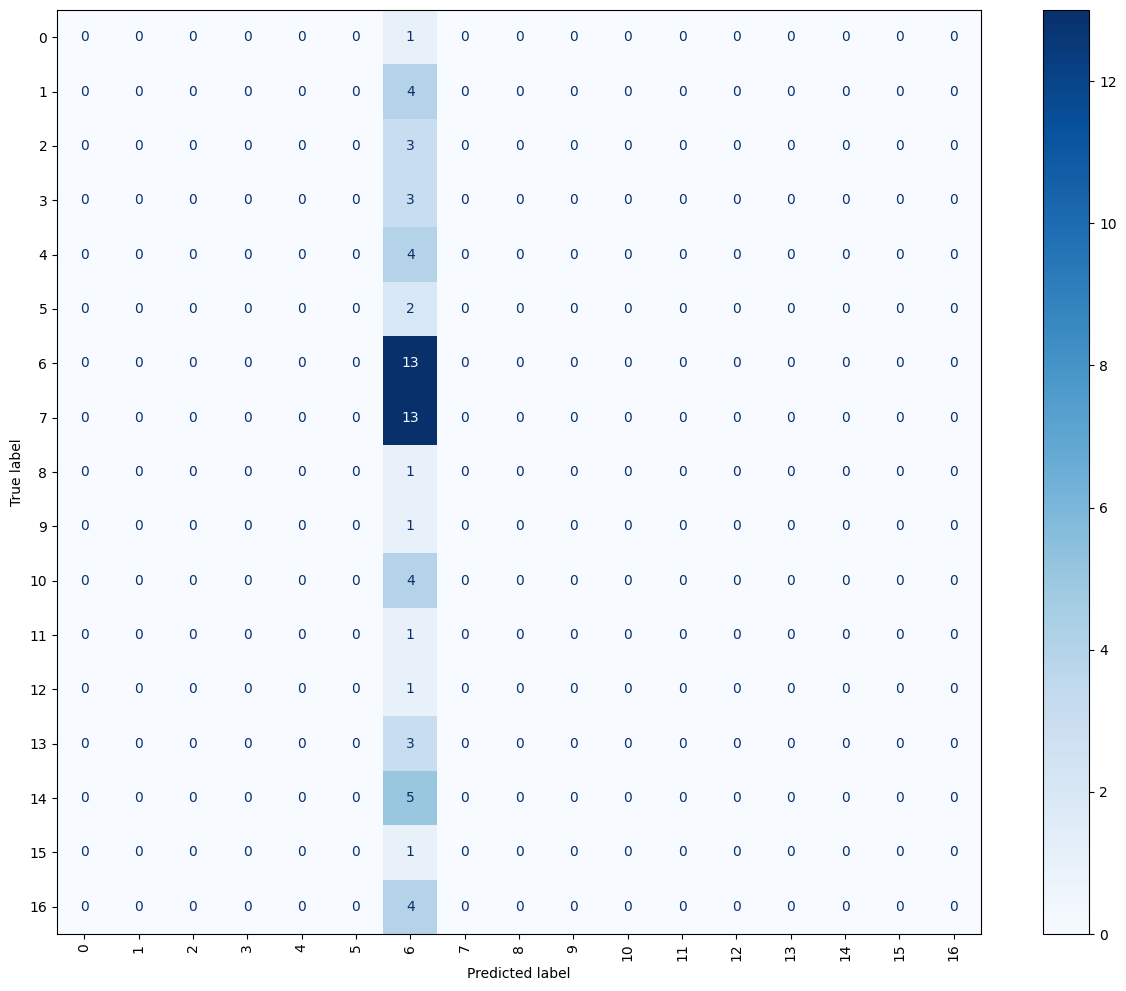

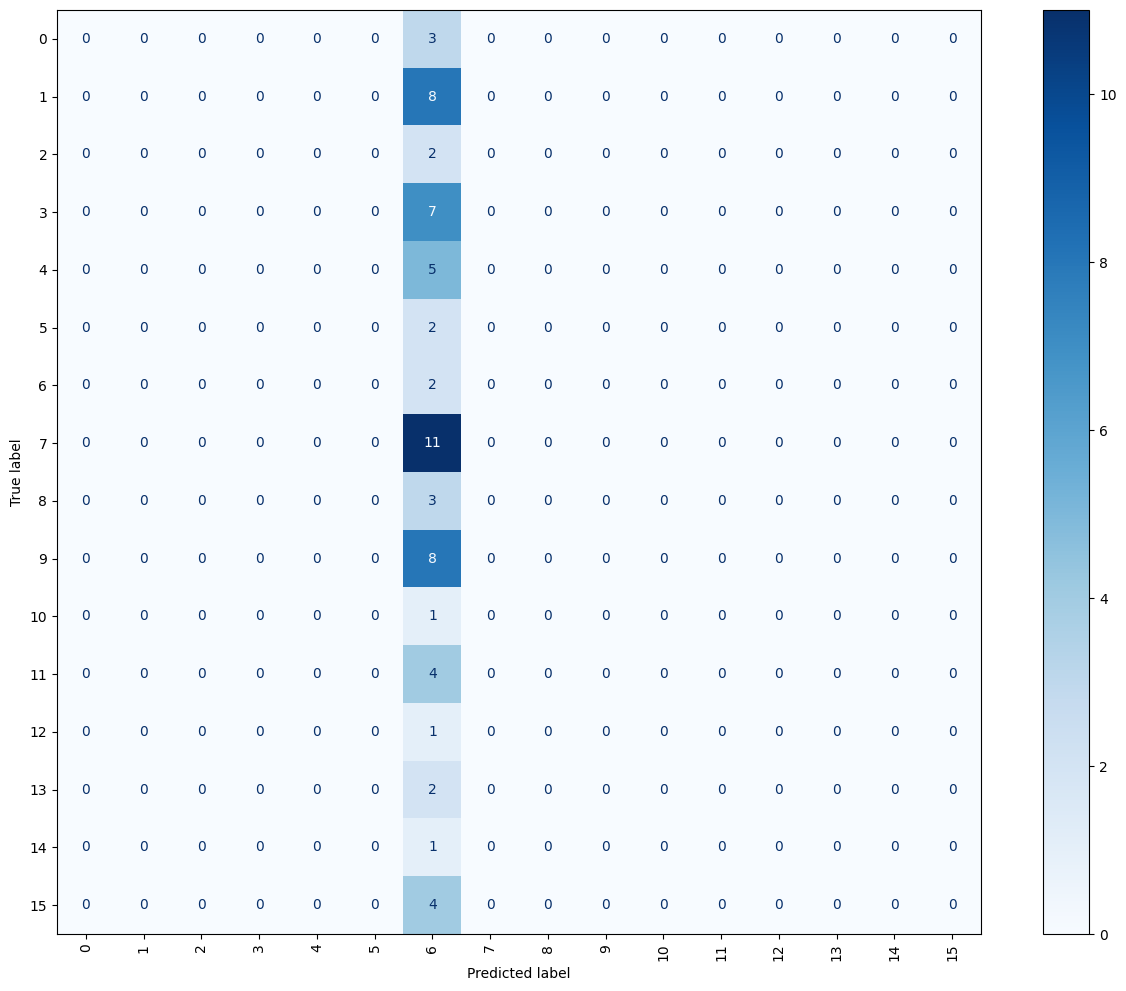

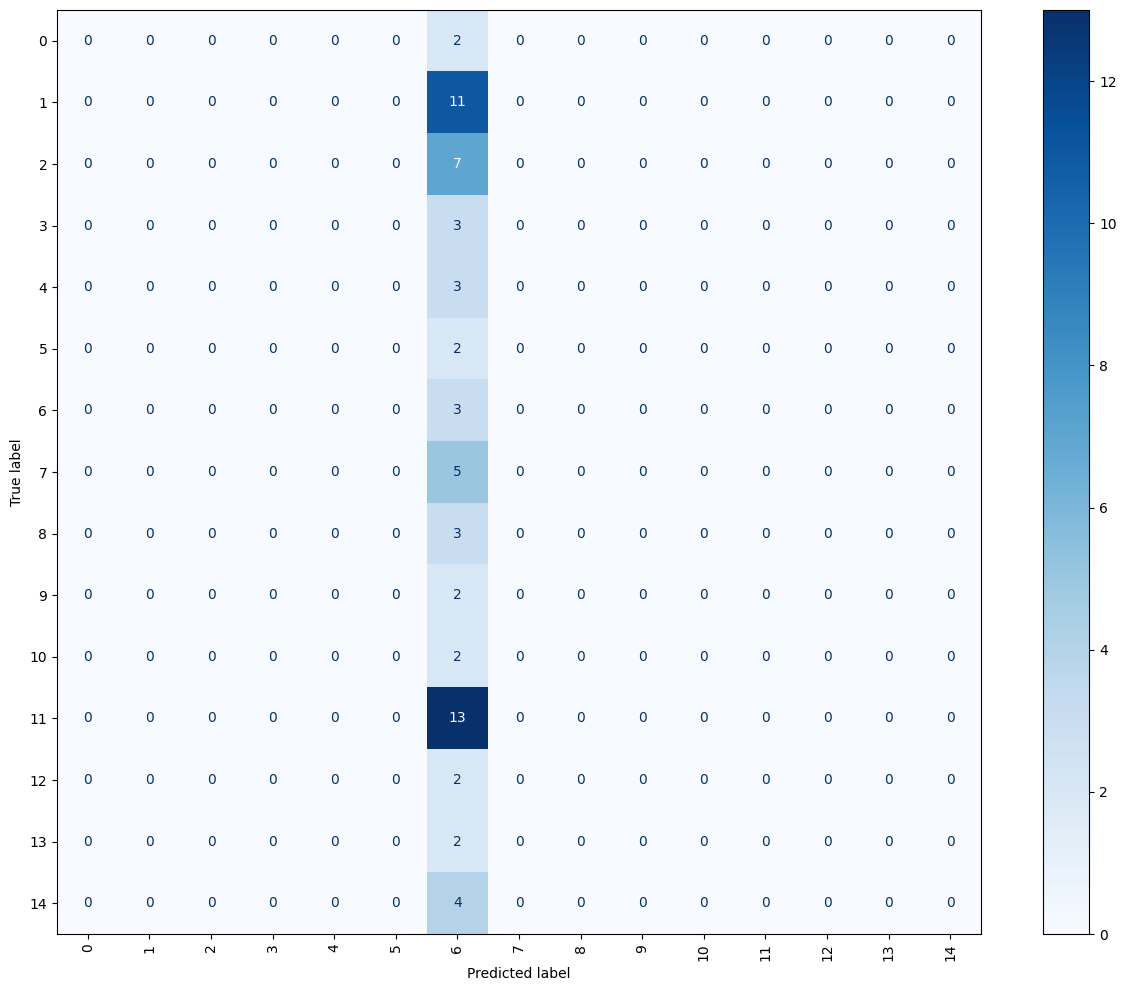

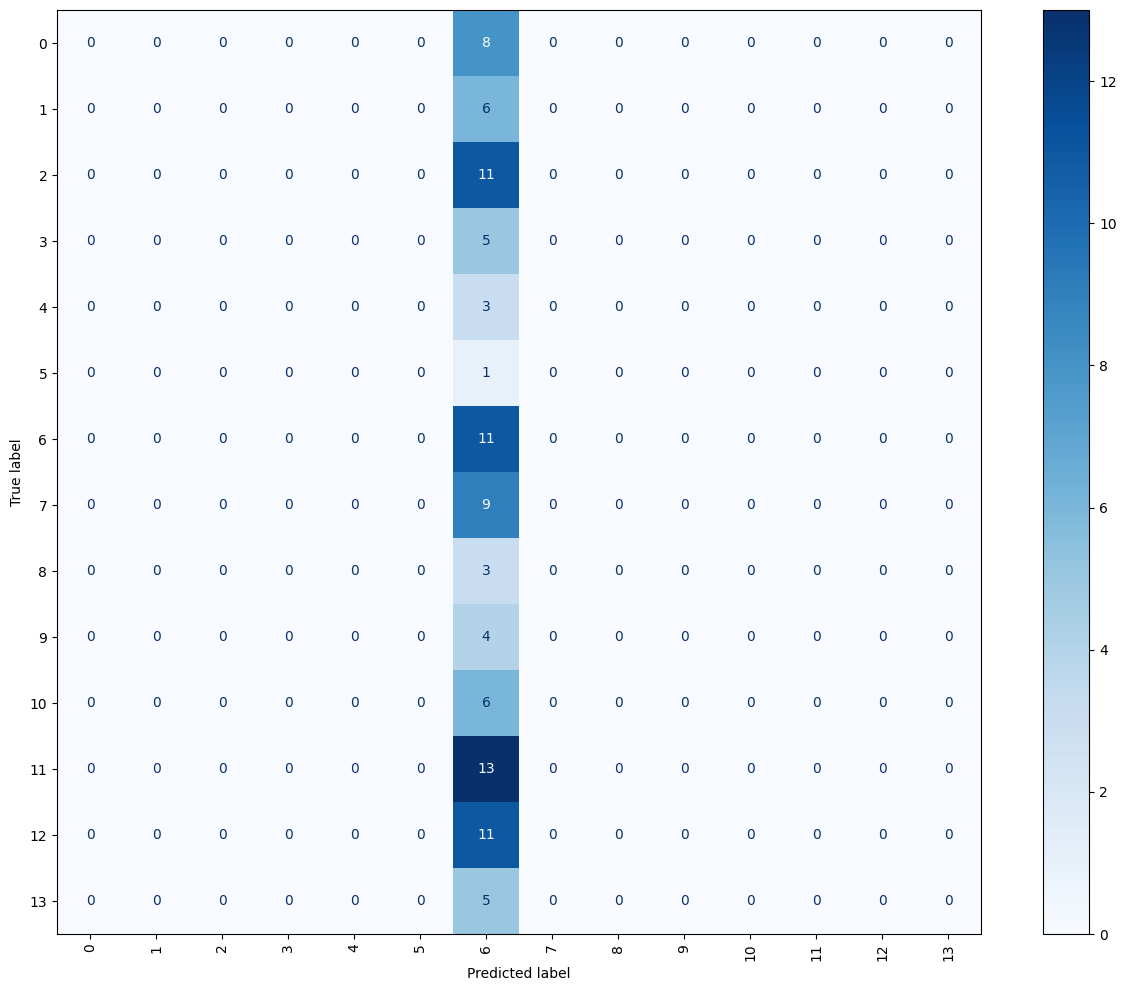

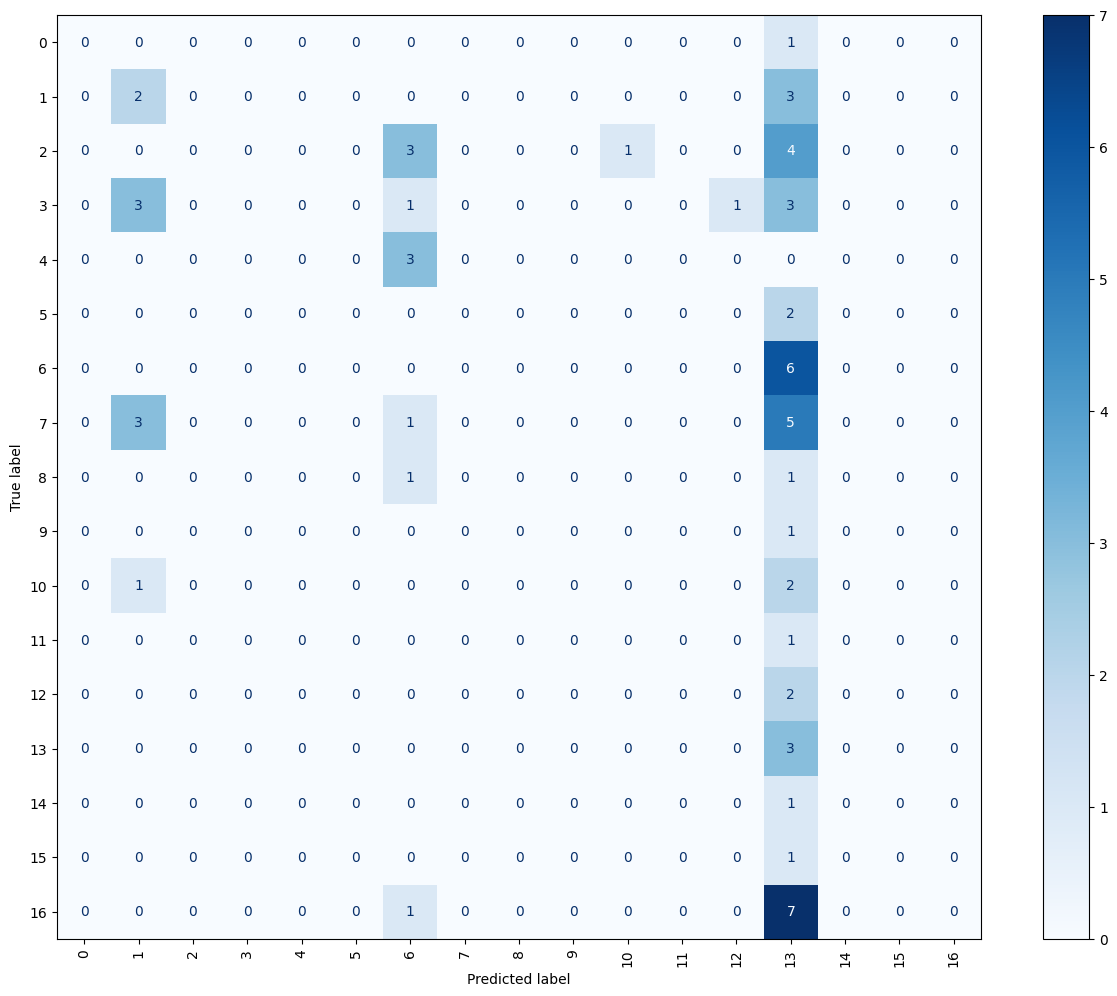

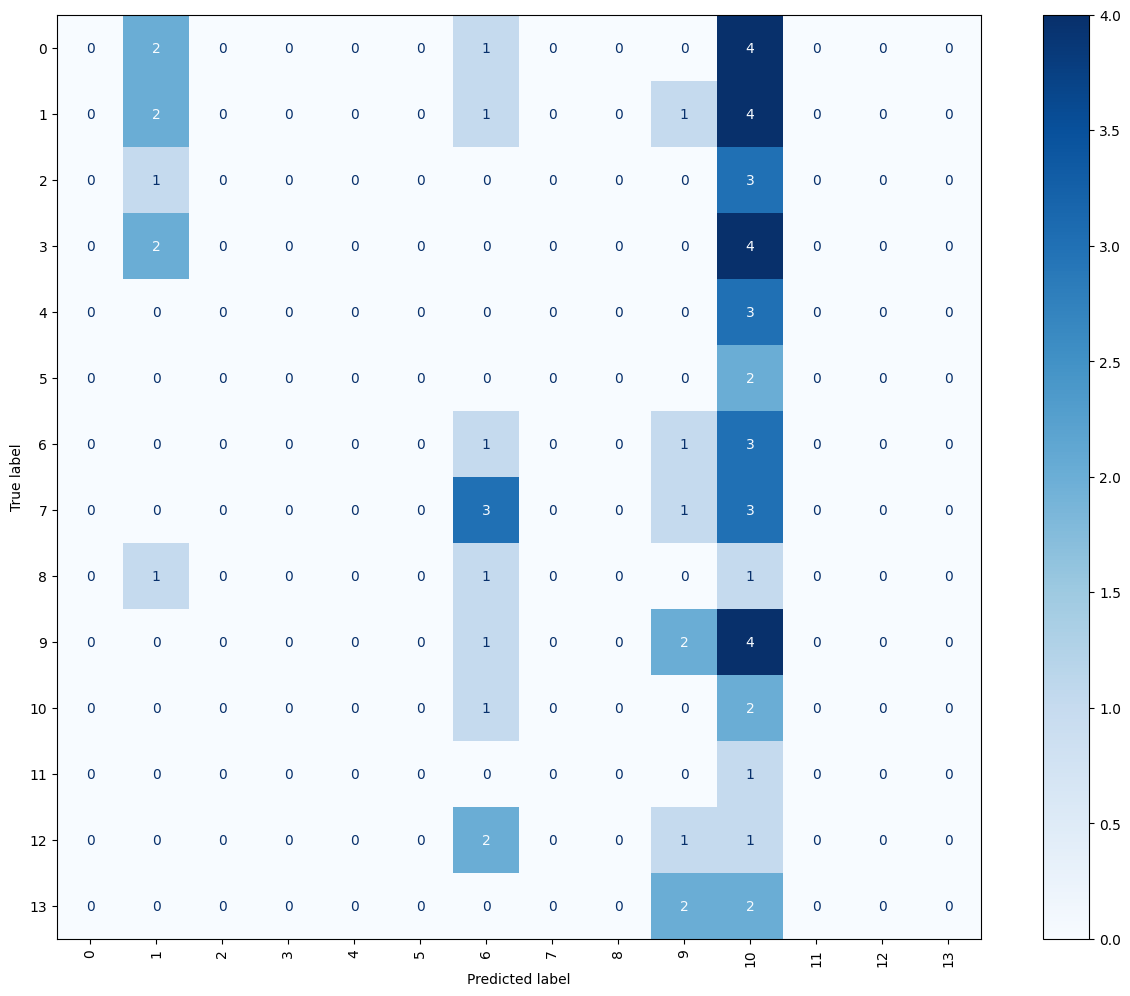

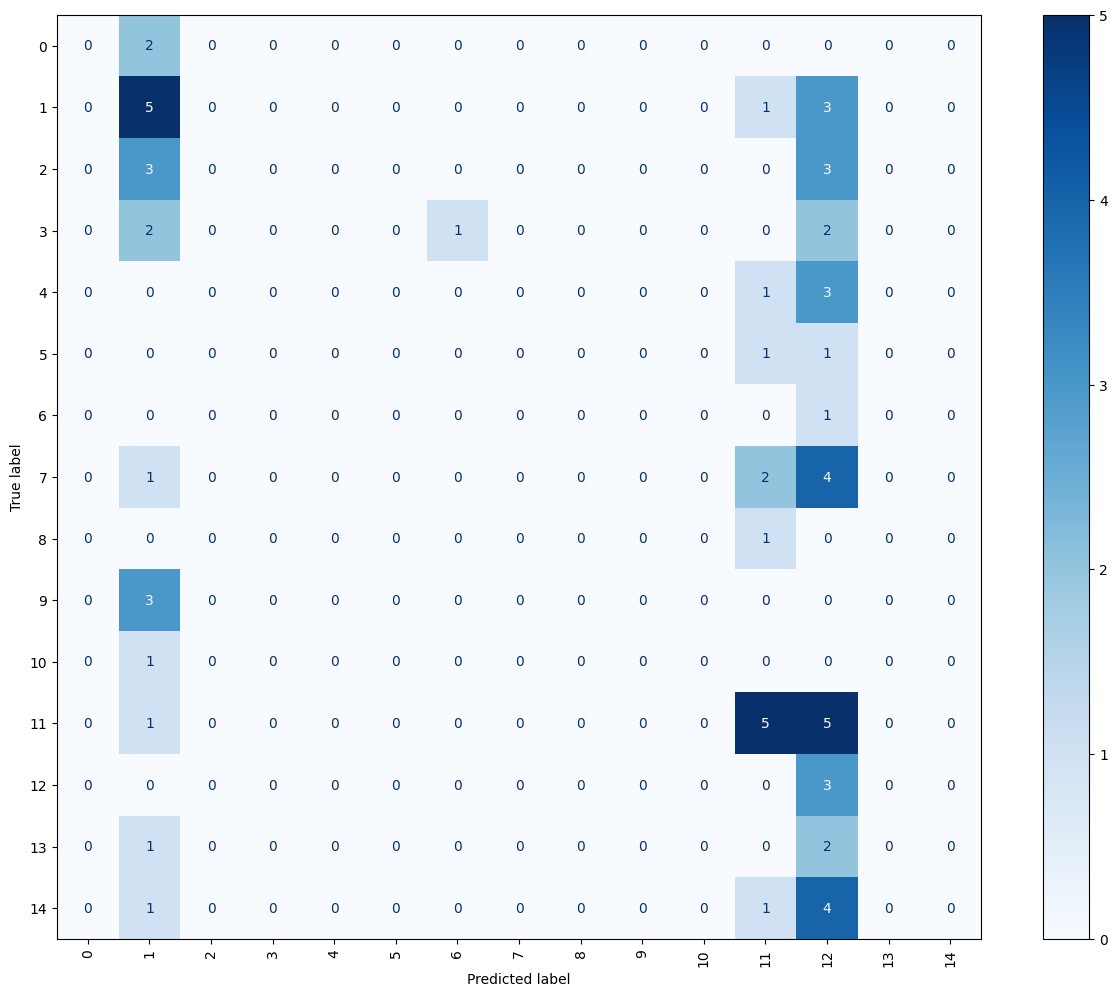

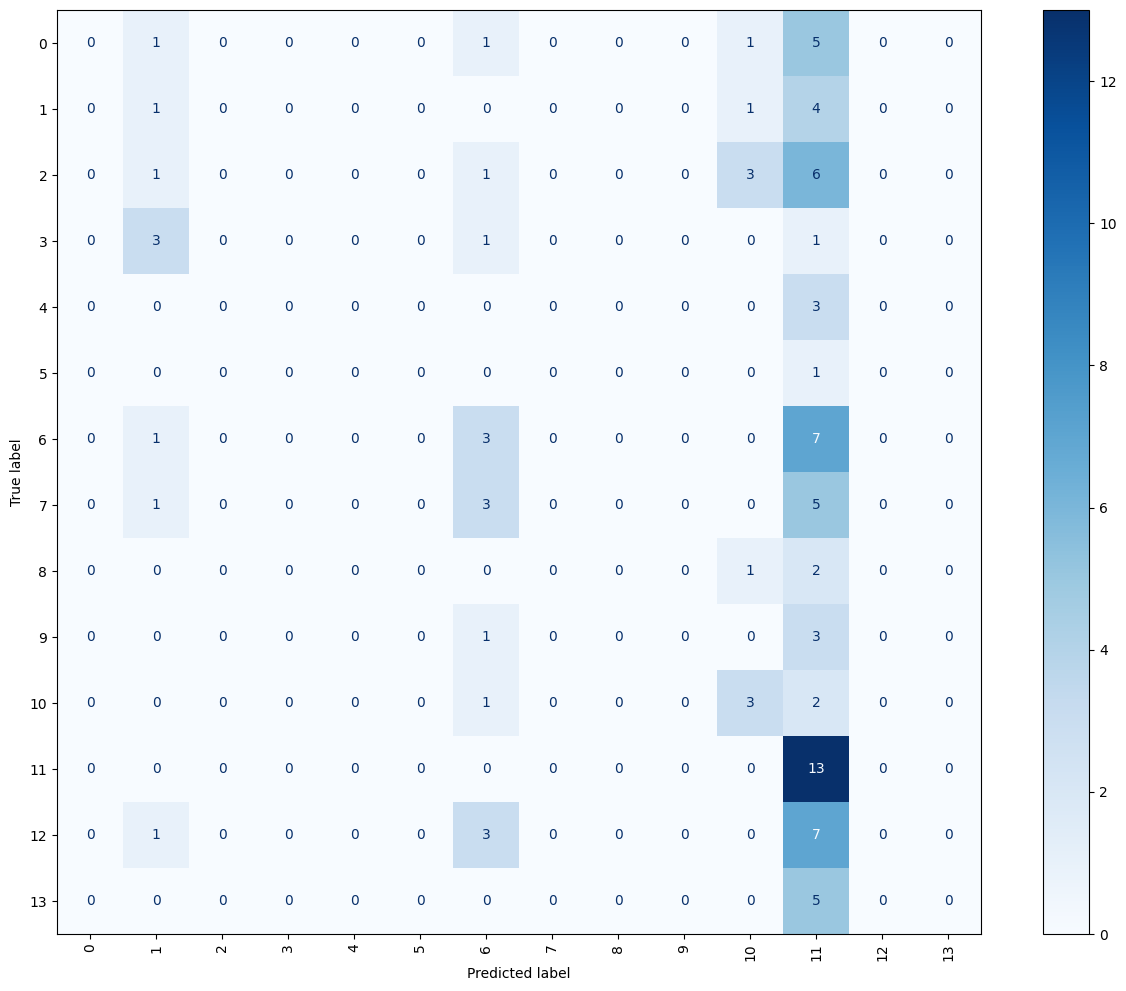

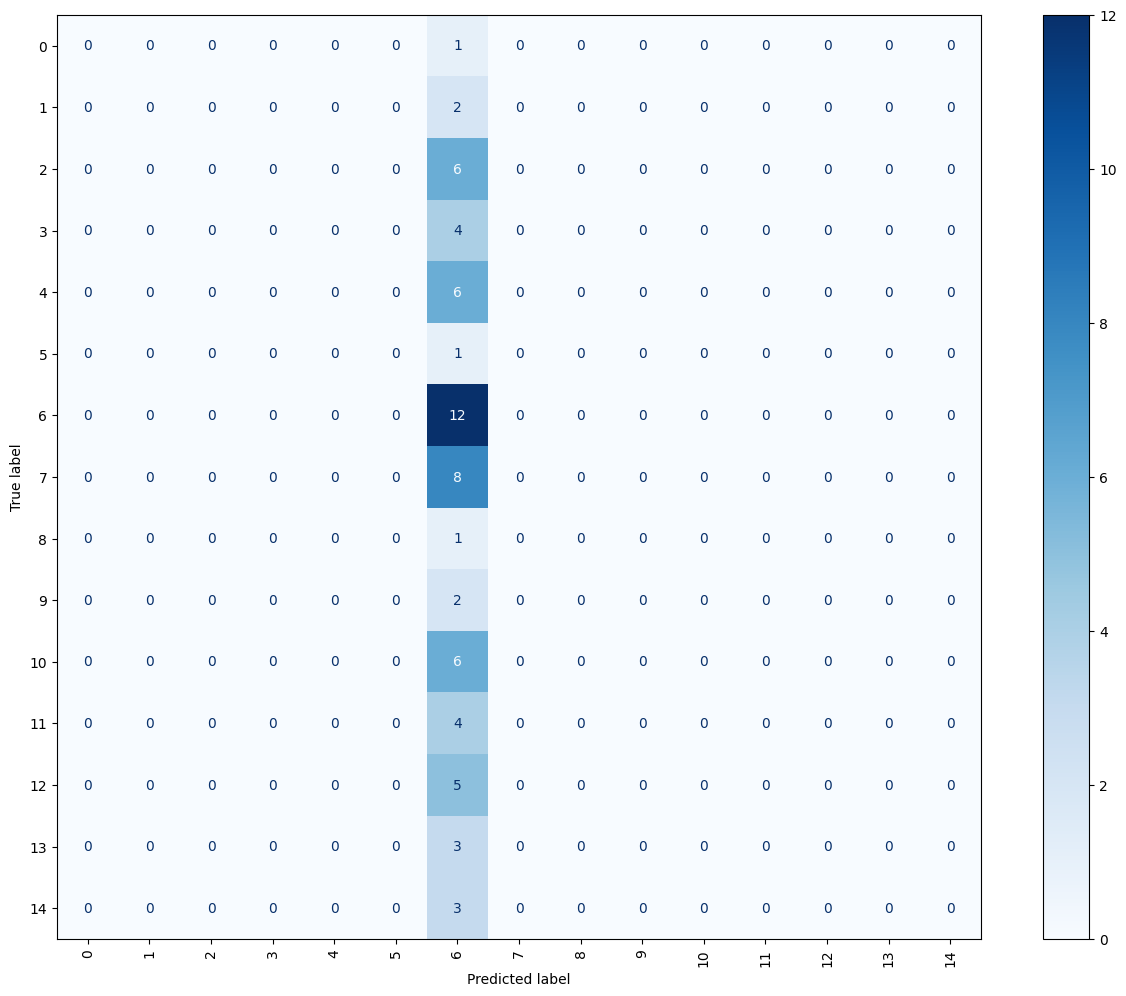

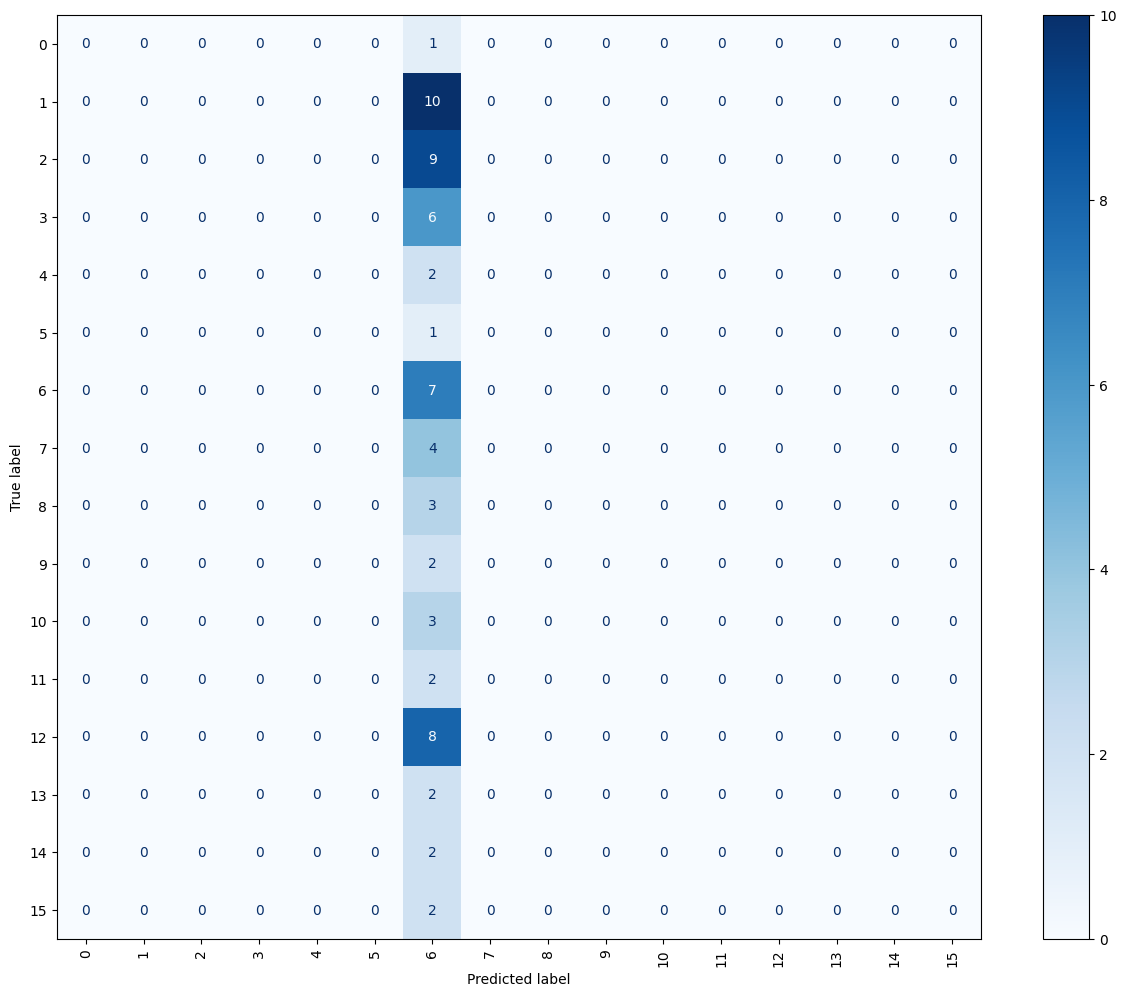

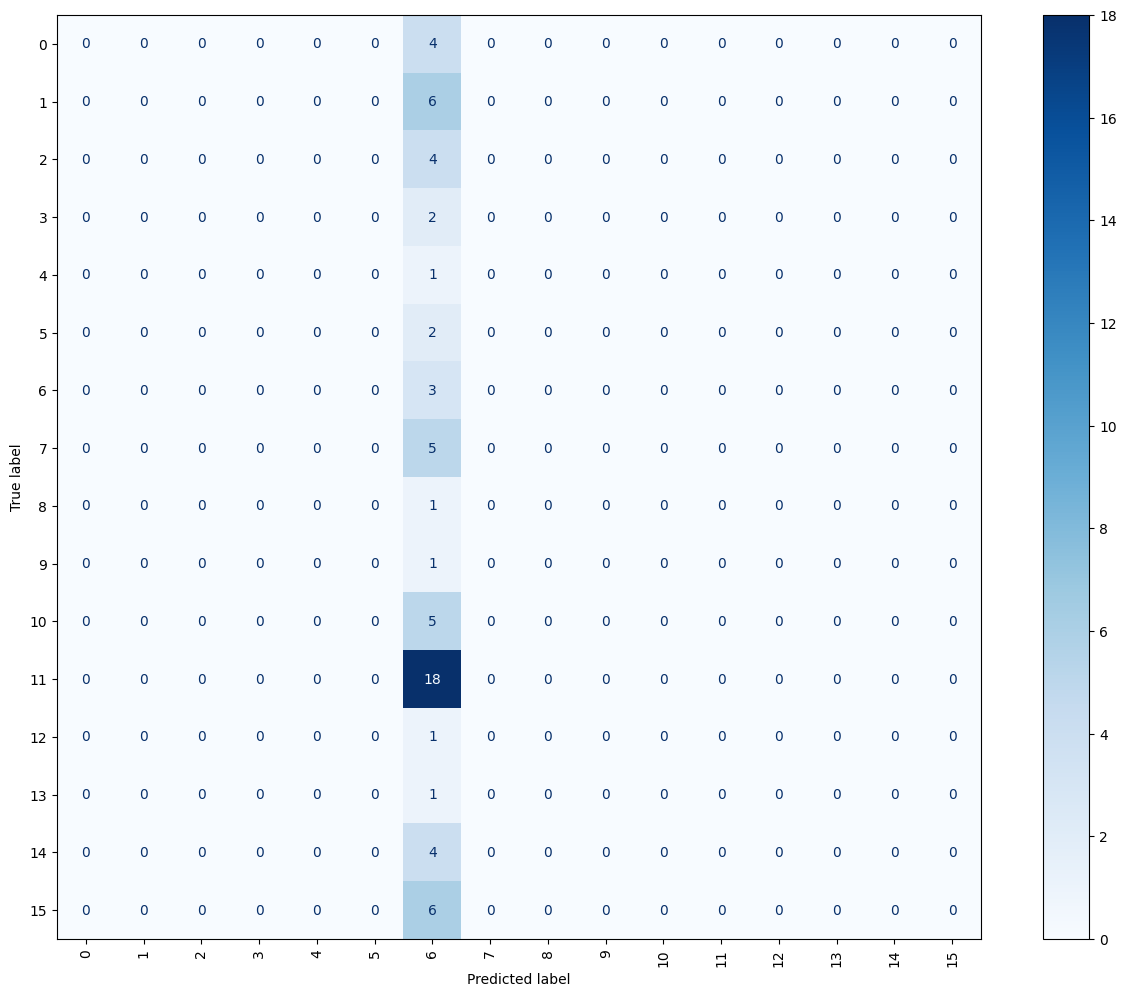

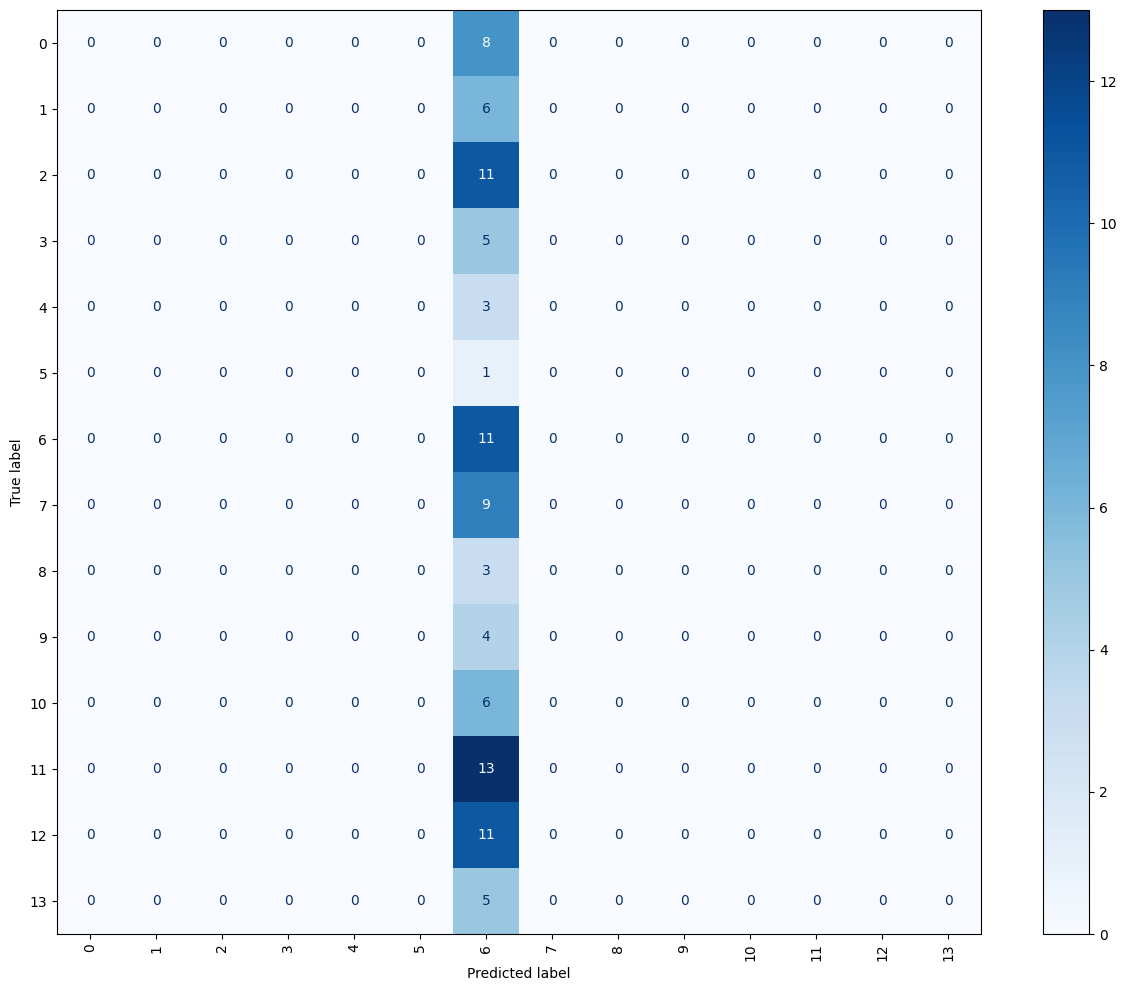

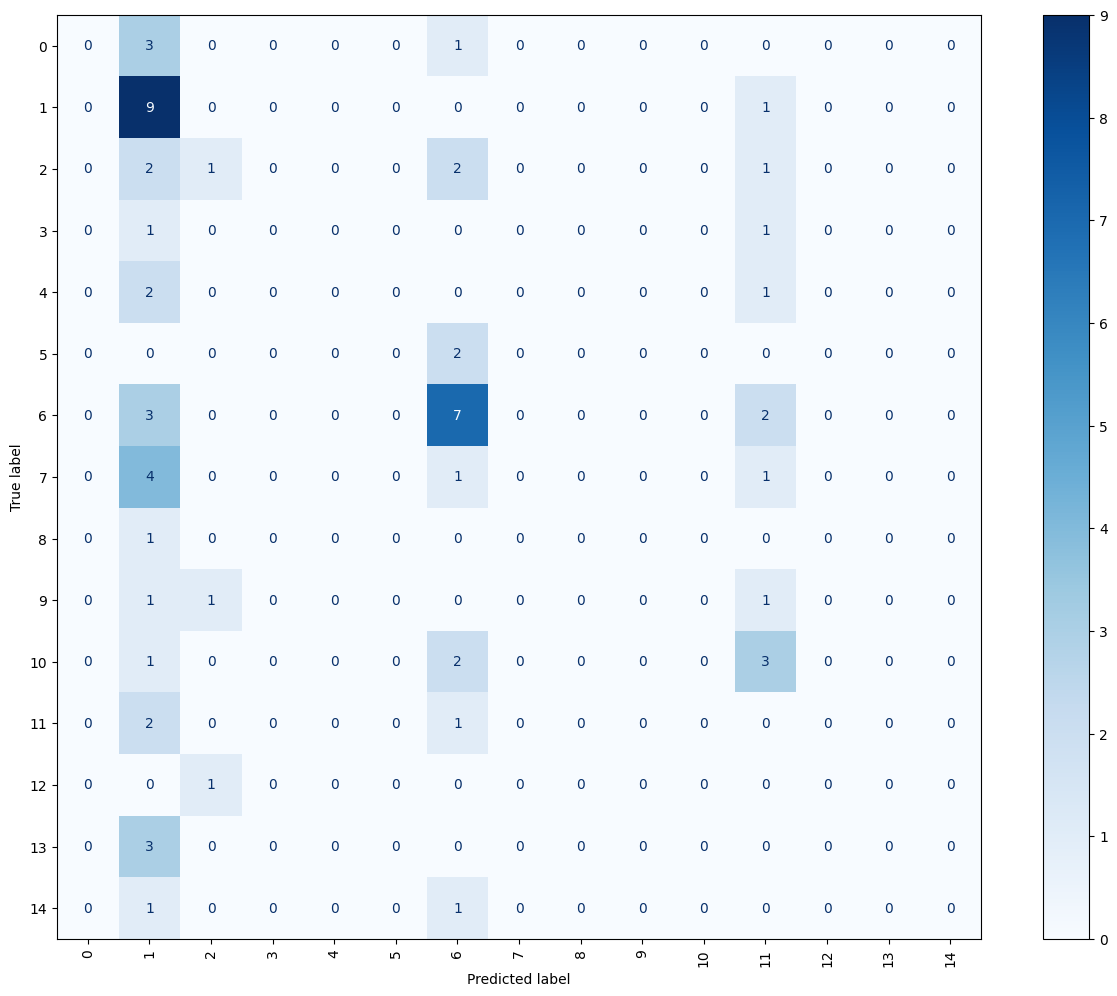

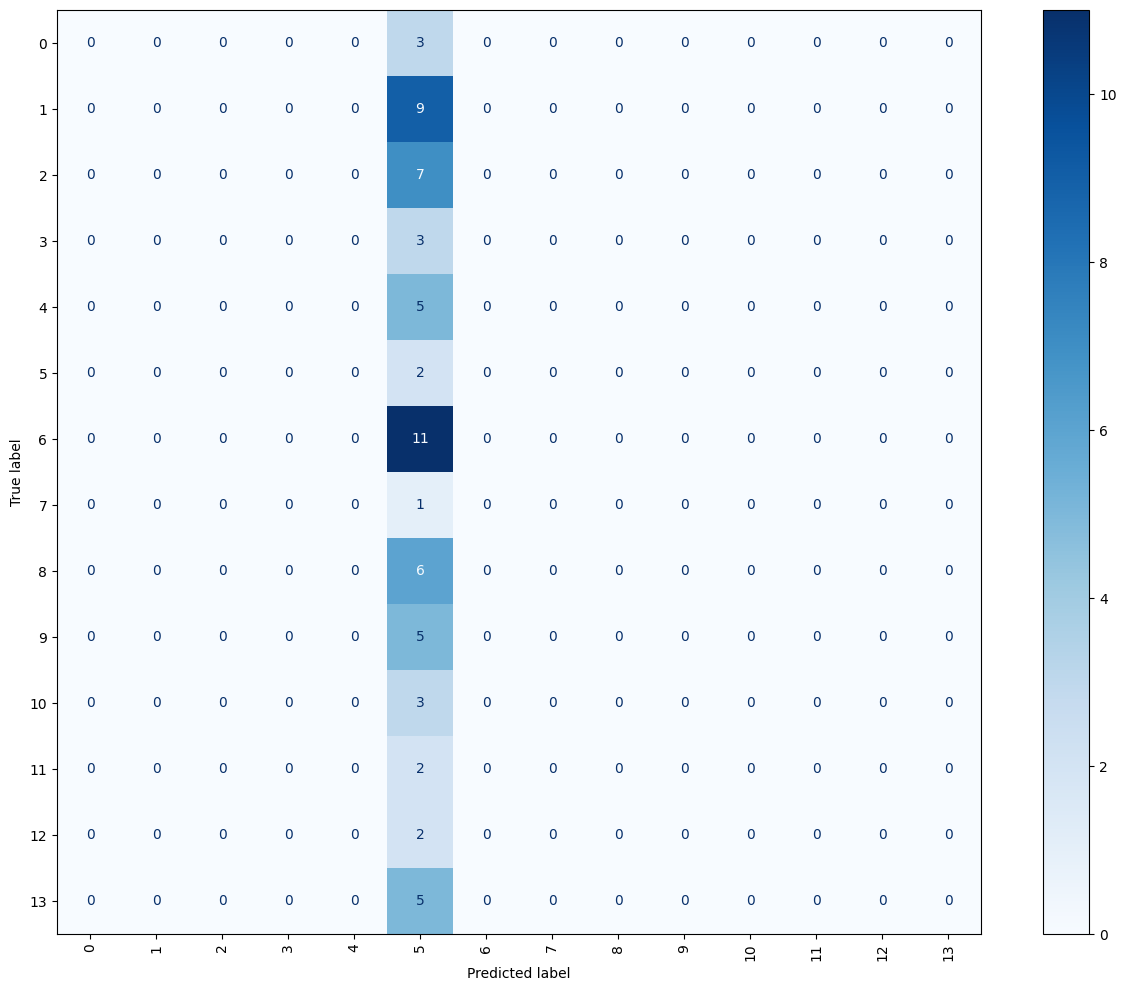

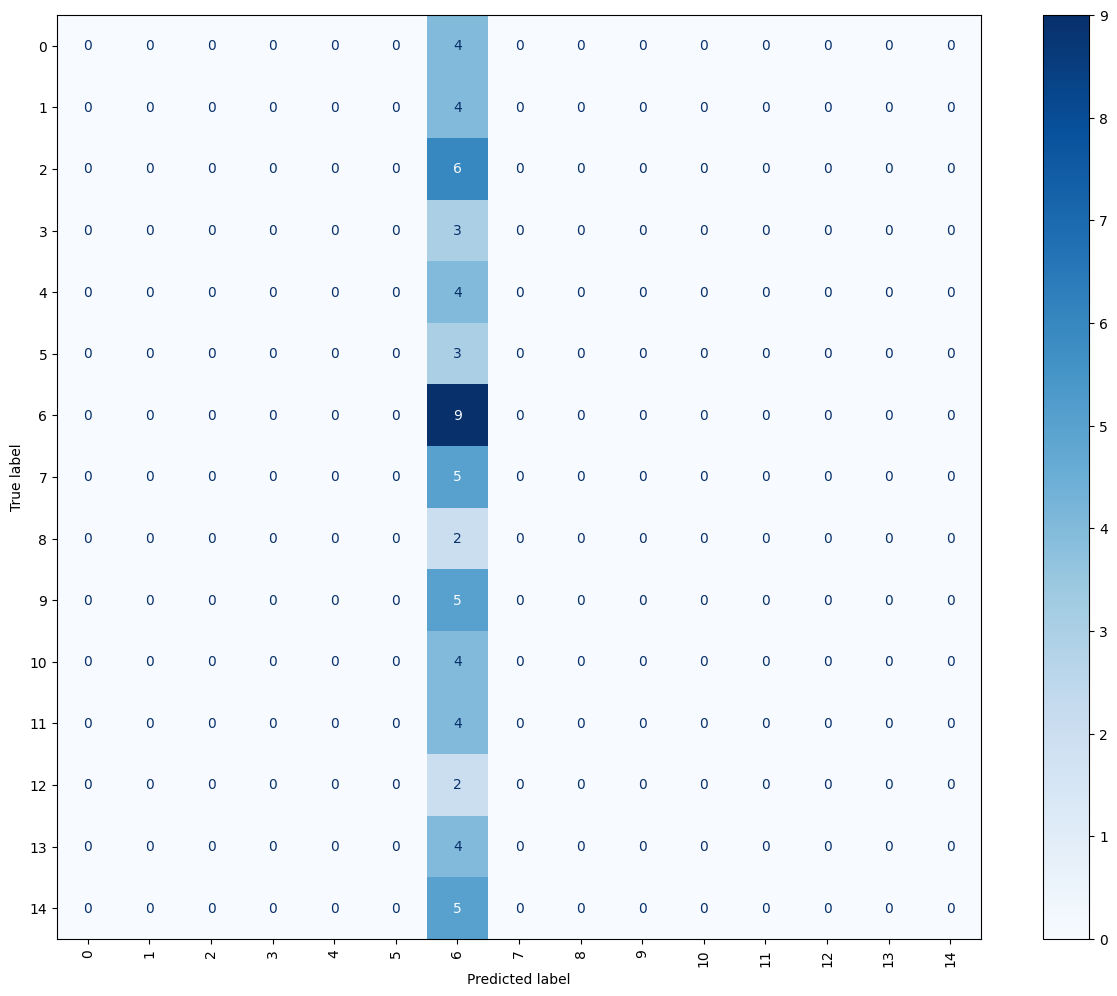

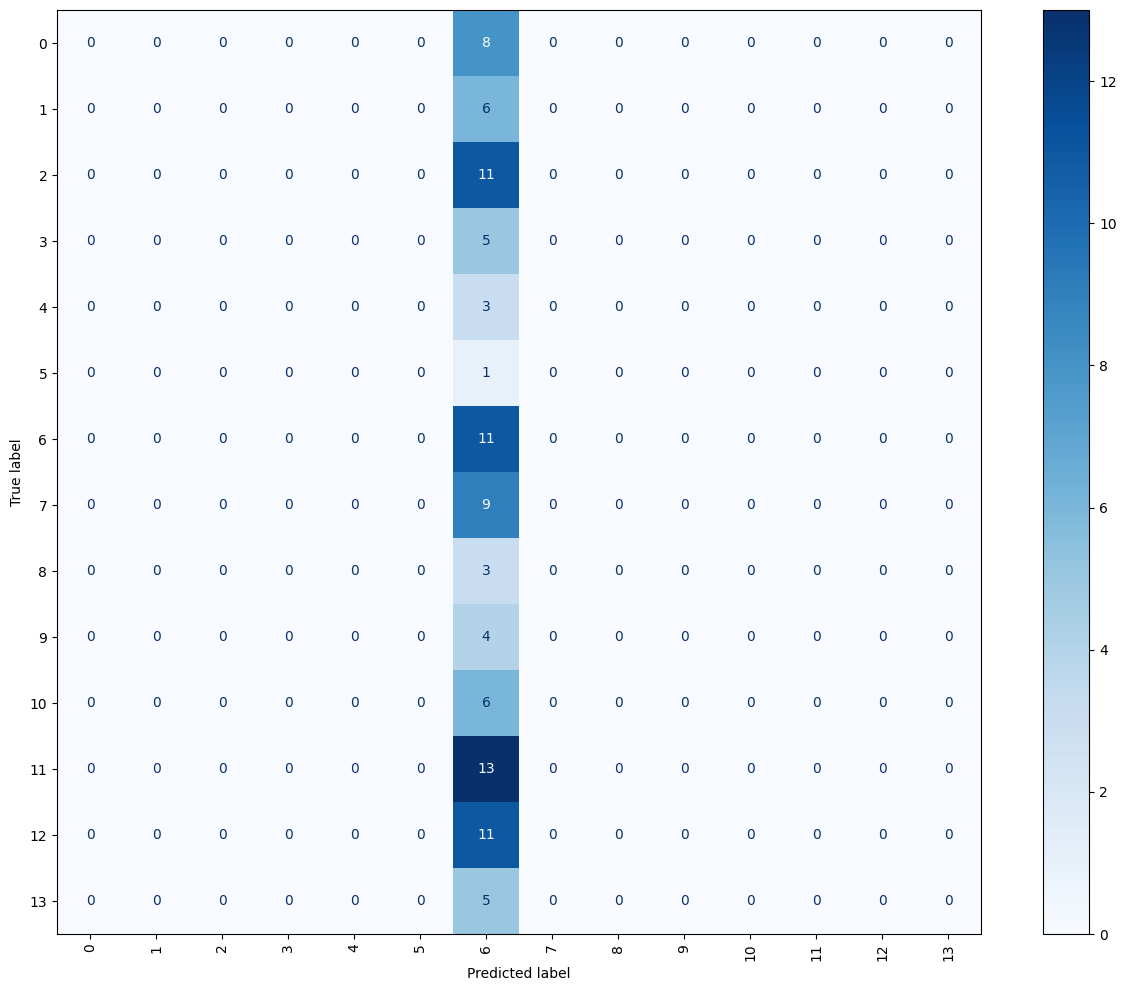

In [21]:
from pytorch_lightning import Trainer
from transformers import AutoModel, AutoTokenizer

rel_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0YmEyZTg2ZC0zNDMxLTQ2MzItOWEzYS0xOWY5ZGNiYTA5YWYifQ==",
    project="Violetta/BERT"
)

try:
    for i in range(4):
        print(f"--------- EXPERIMENT {i} ---------")
    
        rel_classifier = rel_trainer = None
        gc.collect()
        torch.cuda.empty_cache()
    
        rel_trainer = LightningTrainer(
            accelerator="gpu",
            devices=[0],
            max_epochs=3,
            default_root_dir=CHECKPOINT_DIR,
            deterministic=False,
            enable_checkpointing=True,
            check_val_every_n_epoch=1,
            log_every_n_steps=1,  # 确保 step 递增，防止 Neptune step 乱序
            num_sanity_val_steps=0, # 禁用 Sanity Check 直接进入训练
            logger=rel_logger
        )
    
        rel_classifier = RelationClassifier(
            pretrained_language_model=PRETRAINED_MODEL,
            dataset_name=DATASET_NAME,
            batch_size=REL_BATCH_SIZE,
            learning_rate=REL_LEARNING_RATE,
            decay_lr_speed=REL_LEARNING_RATE_DECAY_SPEED,
            dropout_p=REL_DROPOUT_P,
            activation_function=REL_ACTIVATION_FUNCTION,
            weight_decay=REL_WEIGHT_DECAY,
            linear_size=REL_LINEAR_SIZE,
        )
    
        rel_trainer.fit(rel_classifier)
        rel_trainer.test(rel_classifier)

except Exception as e:
    # rel_logger.experiment.stop(str(e))
    raise e

# else:
#     rel_logger.experiment.stop()

# Train 2 classifiers independently then test together

In [22]:
def test_together(experiment_no: int, logger, b_classifier: BinaryClassifier, r_classifier: RelationClassifier, dataset_name: str = DATASET_NAME,
                  bin_batch_size = BIN_BATCH_SIZE, batch_size: int = REL_BATCH_SIZE):
    
    b_classifier.freeze()
    r_classifier.freeze()

    true_answer = []

    # run binary classifier
    print("Running binary classifier")
    dataset = GenericDataset(dataset_name, subset="test", batch_size=bin_batch_size, label_transform="none")
    binary_classify_results = { criteria: [] for criteria in b_classifier.thresholds.keys() }

    for input_data, true_label  in tqdm(dataset.as_batches(), total=len(dataset)):
        # append true answers
        true_answer += true_label.tolist()

        # run bin classifier
        logits = b_classifier(**input_data)
        y_hat = torch.sigmoid(logits)
        for criteria, threshold in b_classifier.thresholds.items():
            label = b_classifier.yhat_to_label(y_hat, threshold)
            binary_classify_results[criteria] += label.tolist()

    # run relation classifier
    print("Running relation classifier")
    dataset = GenericDataset(dataset_name, subset="test", batch_size=batch_size, label_transform="none")
    relation_classify_result = []

    for input_data, true_label  in tqdm(dataset.as_batches(), total=len(dataset)):
        logits = r_classifier(**input_data)
        label = r_classifier.logits_to_label(logits) + 1
        relation_classify_result += label.tolist()

    # combine results
    print("Combining results")
    proposed_answer = {}
    for criteria in b_classifier.thresholds.keys():
        results = zip(relation_classify_result, binary_classify_results[criteria])
        final_label = [relation_result if bin_result else 0 for relation_result, bin_result in results]
        proposed_answer[criteria] = final_label

    # log metric
    final_metrics = {}
    for criteria in b_classifier.thresholds.keys():
        pa = proposed_answer[criteria]
        
        final_metrics.update({
            f"test_combined_{criteria}_acc": accuracy_score(true_answer, pa),
            f"test_combined_{criteria}_pre_micro": precision_score(true_answer, pa, average="micro"),
            f"test_combined_{criteria}_rec_micro": recall_score(true_answer, pa, average="micro"),
            f"test_combined_{criteria}_f1_micro": f1_score(true_answer, pa, average="micro"),
            f"test_combined_{criteria}_pre_macro": precision_score(true_answer, pa, average="macro"),
            f"test_combined_{criteria}_rec_macro": recall_score(true_answer, pa, average="macro"),
            f"test_combined_{criteria}_f1_macro": f1_score(true_answer, pa, average="macro"),
        })
        
        fig = BaseClassifier.plot_confusion_matrix(pa, true_answer)
        # logger.log_image(f"test_combined_{criteria}_confusion_matrix", fig)
        logger.experiment[f"test_combined_{criteria}_confusion_matrix"].log(fig)
        
    for k, v in final_metrics.items():
        print(f"{k}: {v * 100}")

    for k, v in final_metrics.items():
        # logger.experiment.log_metric(k, v)
        logger.experiment[k].log(v)

    # run the offical scorer
    scorer = get_official_scorer(experiment_no, logger)
    if scorer:
        scorer.score(proposed_answer)
    else:
        print("No official scorer found")

Exception ignored in: <function GenericDataset.__del__ at 0x000001FB0010BEC0>
Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_11376\1424198635.py", line 28, in __del__
AttributeError: 'GenericDataset' object has no attribute 'file'
Exception ignored in: <function GenericDataset.__del__ at 0x000001FB0010BEC0>
Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_11376\1424198635.py", line 28, in __del__
AttributeError: 'GenericDataset' object has no attribute 'file'
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


--------- EXPERIMENT 0 ---------


E:\Python\Python3.11.5\Lib\site-packages\neptune\internal\utils\git.py:71: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/Violetta/BERT/e/BERTRE-70


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type      | Params | Mode 
----------------------------------------------------------
0 | language_model      | BertModel | 109 M  | eval 
1 | linear              | Linear    | 393 K  | train
2 | linear_output       | Linear    | 9.2 K  | train
3 | dropout             | Dropout   | 0      | train
4 | activation_function | PReLU     | 1      | train
----------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
439.541   Total estimated model params size (MB)
4         Modules in train mode
228       Modules in eval mode
E:\Python\Python3.11.5\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
E:\Python\Python3.11.5\Li

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[ 0.0450, -0.0618,  0.0430,  0.0785,  0.2205,  0.0787, -0.0706, -0.0155,
         -0.0799, -0.0140, -0.0308,  0.0357, -0.0472,  0.0441, -0.1026, -0.0048,
         -0.1667, -0.0384],
        [ 0.0298,  0.0560,  0.0571,  0.0184,  0.3430,  0.1435, -0.0873, -0.0665,
         -0.0500, -0.0257,  0.1553,  0.0655, -0.0878,  0.0006, -0.1060,  0.0339,
         -0.0168, -0.1020],
        [ 0.1052,  0.0129,  0.0772,  0.1842,  0.3334,  0.1388, -0.0927, -0.0179,
         -0.0859,  0.1024,  0.0891,  0.0262, -0.0511,  0.0355, -0.1019,  0.0301,
         -0.0160, -0.1163],
        [ 0.0616, -0.0283,  0.1031,  0.1468,  0.2593,  0.1224, -0.1012, -0.0779,
         -0.1121,  0.0299,  0.0242,  0.0636, -0.0534,  0.0790, -0.0471,  0.0290,
         -0.1361, -0.0494],
        [ 0.1093,  0.0210,  0.0726,  0.1108,  0.2872,  0.0927, -0.0756, -0.0844,
         -0.0743,  0.1080,  0.0721,  0.0271, -0.0891,  0.0700, -0.0840, -0.0409,
         -0.0655, -0.

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 4.0


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[ 2.6790e-01, -4.2140e-02, -1.2913e-01,  4.4283e-01,  5.8223e-01,
          9.4933e-02, -5.2746e-02, -1.3387e-02, -1.1940e-01,  2.4317e-02,
          1.0200e-01,  3.3487e-01, -3.0532e-01,  4.6883e-02, -1.0414e-01,
         -1.0307e-01, -1.5368e-01, -2.4363e-01],
        [ 1.2882e-01,  1.3782e-01, -1.6766e-02,  2.1319e-01,  2.4676e-01,
          7.2872e-02,  2.2889e-02, -7.7199e-02, -1.2502e-01,  1.1767e-01,
          1.4511e-01,  2.0360e-01, -1.2590e-01,  2.4414e-02, -1.1994e-01,
         -2.7941e-02, -8.6952e-02, -1.8490e-01],
        [ 2.9657e-01, -1.3977e-02, -9.2502e-02,  3.2385e-01,  4.0864e-01,
          1.0040e-01, -2.5053e-02, -4.7770e-02, -1.0477e-01,  6.8715e-02,
          9.5426e-02,  2.7440e-01, -2.3094e-01,  8.9996e-02, -5.1046e-02,
         -4.3202e-02, -1.1030e-01, -2.6082e-01],
        [ 2.8094e-01, -1.3228e-02, -3.8376e-02,  3.7556e-01,  4.8805e-01,
         -2.1822e-02, -1.6022e-01, -6.9605e-03, -1.7544e

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([[ 2.3556e-01,  1.7625e-01, -2.1705e-01,  5.7930e-01,  6.9726e-01,
          3.9755e-02, -6.5866e-02, -6.0026e-03, -1.2598e-01, -3.7285e-02,
          2.2289e-02,  3.1269e-01, -3.7052e-01, -5.6074e-03, -1.9197e-01,
         -1.4603e-01, -2.4966e-01, -3.4752e-01],
        [ 2.2712e-01, -1.2645e-01, -3.2227e-01,  6.8515e-01,  5.8293e-01,
          1.2082e-01,  3.4670e-02, -1.0925e-01,  1.3414e-01,  4.6543e-03,
          9.4924e-02,  2.4065e-01, -2.2882e-01, -8.6857e-02, -2.3992e-01,
         -1.3368e-01, -3.0807e-01, -4.1802e-01],
        [ 2.1911e-01, -3.2936e-02, -2.9673e-01,  6.1035e-01,  6.7963e-01,
          1.8052e-01,  8.4375e-03, -1.2416e-01,  2.2436e-01,  1.8516e-01,
          1.7496e-01,  2.4334e-01, -3.0427e-01, -6.4757e-02, -2.9527e-01,
         -8.4491e-02, -2.8841e-01, -4.2893e-01],
        [ 1.9937e-01,  3.1273e-03, -2.3560e-01,  6.7146e-01,  7.4907e-01,
          1.0957e-01,  5.7605e-02, -1.3973e-01,  7.9361e

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Python\Python3.11.5\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
`Trainer.fit` stopped: `max_epo

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([0.6177, 0.5390, 0.6180, 0.6926, 0.6472, 0.5670, 0.7103, 0.4842, 0.6583,
        0.6645, 0.5502, 0.5569, 0.7093, 0.5190, 0.7000, 0.6762, 0.7972, 0.6738,
        0.5425, 0.6147, 0.7191, 0.5921, 0.6148, 0.7370, 0.6283, 0.5473, 0.5518,
        0.5946, 0.7261, 0.5960, 0.7036, 0.5670], device='cuda:0'), 'label': tensor([1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')}, {'logits': tensor([0.8677, 0.7028, 0.5746, 0.6393, 0.6304, 0.6530, 0.6169, 0.5545, 0.6697,
        0.6047, 0.6088, 0.6756, 0.6771, 0.6870, 0.5830, 0.6114, 0.6097, 0.6160,
        0.7581, 0.6902, 0.4807, 0.7557, 0.6308, 0.5028, 0.6879, 0.6584, 0.6362,
        0.6343, 0.7150, 0.5482, 0.6804, 0.5968], device='cuda:0'), 'label': tensor([1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')}, {'logits': tensor([0.5343, 0.7004, 0

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyp

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([0.9214, 1.0751, 1.0320, 0.9604, 1.0546, 0.9377, 0.9654, 0.9888, 0.8998,
        1.0215, 0.9633, 0.9412, 0.9791, 0.9765, 0.8610, 1.0276, 1.0414, 0.9160,
        1.0056, 1.0060, 0.9349, 0.9608, 0.9967, 1.0068, 0.9335, 0.9048, 0.8736,
        1.0216, 0.9943, 0.9470, 0.9090, 0.9781], device='cuda:0'), 'label': tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')}, {'logits': tensor([0.7888, 0.8391, 0.8913, 0.9932, 0.8655, 0.9195, 0.8022, 0.9336, 0.9627,
        0.8841, 0.9385, 0.9292, 0.8930, 0.8260, 0.9039, 0.9660, 0.9404, 0.8994,
        0.8471, 0.8657, 0.8457, 0.8446, 0.9578, 0.8613, 0.9175, 1.0016, 1.0486,
        0.9817, 0.7862, 0.9560, 0.8356, 1.0086], device='cuda:0'), 'label': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')}, {'logits': tensor([0.9501, 0.7560, 0

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyp

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] validation_step_outputs before eval: [{'logits': tensor([0.8186, 0.9009, 1.0909, 0.9018, 0.9194, 0.9568, 0.9981, 0.8604, 0.9045,
        1.0452, 0.8787, 0.8849, 0.9765, 0.8718, 1.0063, 1.0335, 0.9240, 0.7984,
        0.9916, 1.1131, 1.0145, 1.0364, 0.8916, 0.8486, 0.8942, 0.8432, 0.7998,
        1.0341, 0.8319, 0.9655, 0.8904, 0.9192], device='cuda:0'), 'label': tensor([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 1], device='cuda:0')}, {'logits': tensor([0.9255, 0.9287, 0.8029, 0.7372, 0.9159, 0.8407, 0.9519, 1.0000, 1.0376,
        0.8492, 0.8631, 0.9282, 0.9688, 0.9923, 0.8266, 0.8715, 0.8864, 0.9026,
        0.9087, 0.8648, 0.8358, 0.9418, 1.0097, 0.9501, 0.9432, 0.8499, 0.7662,
        1.0085, 0.7644, 0.8986, 0.8373, 0.8181], device='cuda:0'), 'label': tensor([1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')}, {'logits': tensor([0.9891, 1.0107, 1

C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:452: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(16, 12))
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax, xticks_rotation='vertical')
C:\Users\pc\AppData\Local\Temp\ipykernel_11376\2218224137.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[na

Running binary classifier


  0%|          | 0/85 [00:00<?, ?it/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

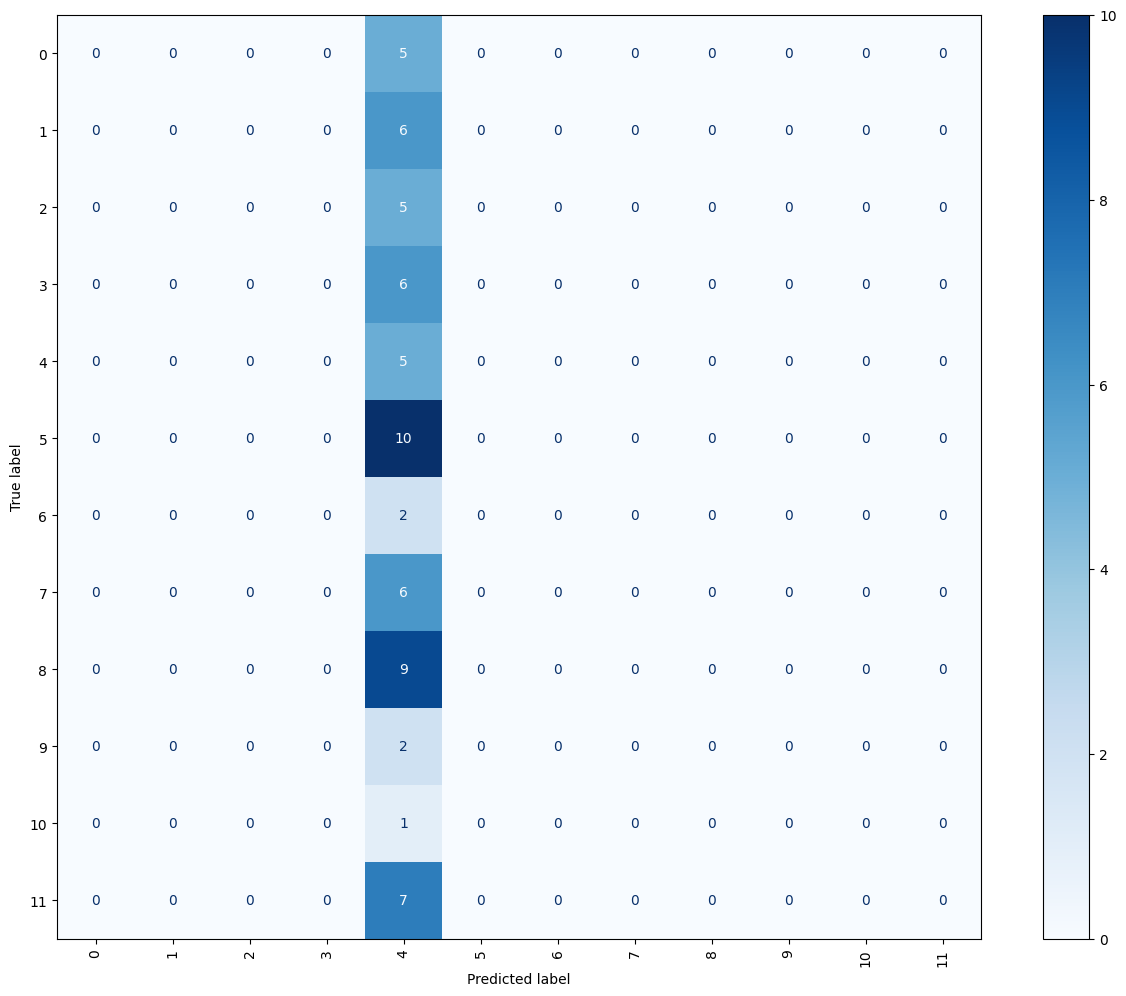

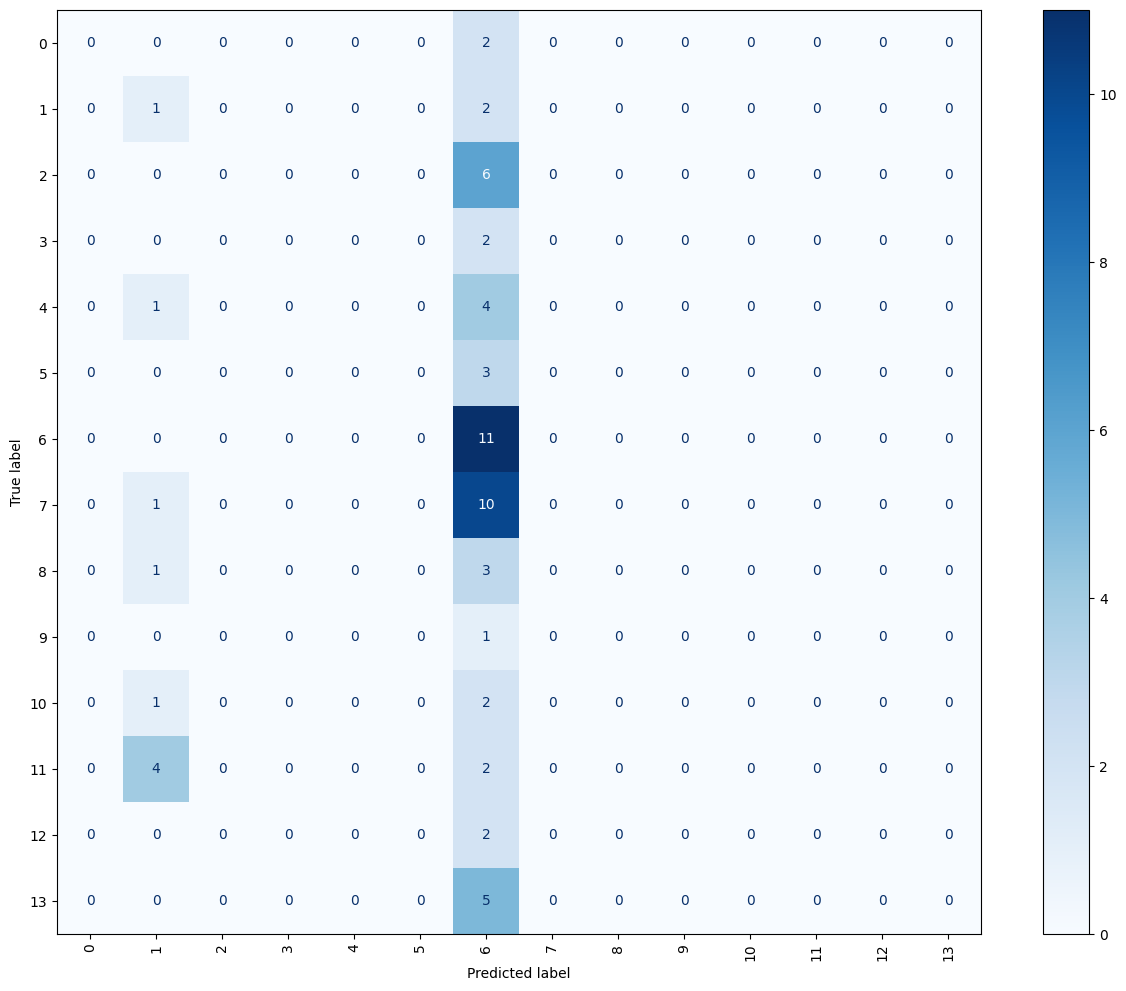

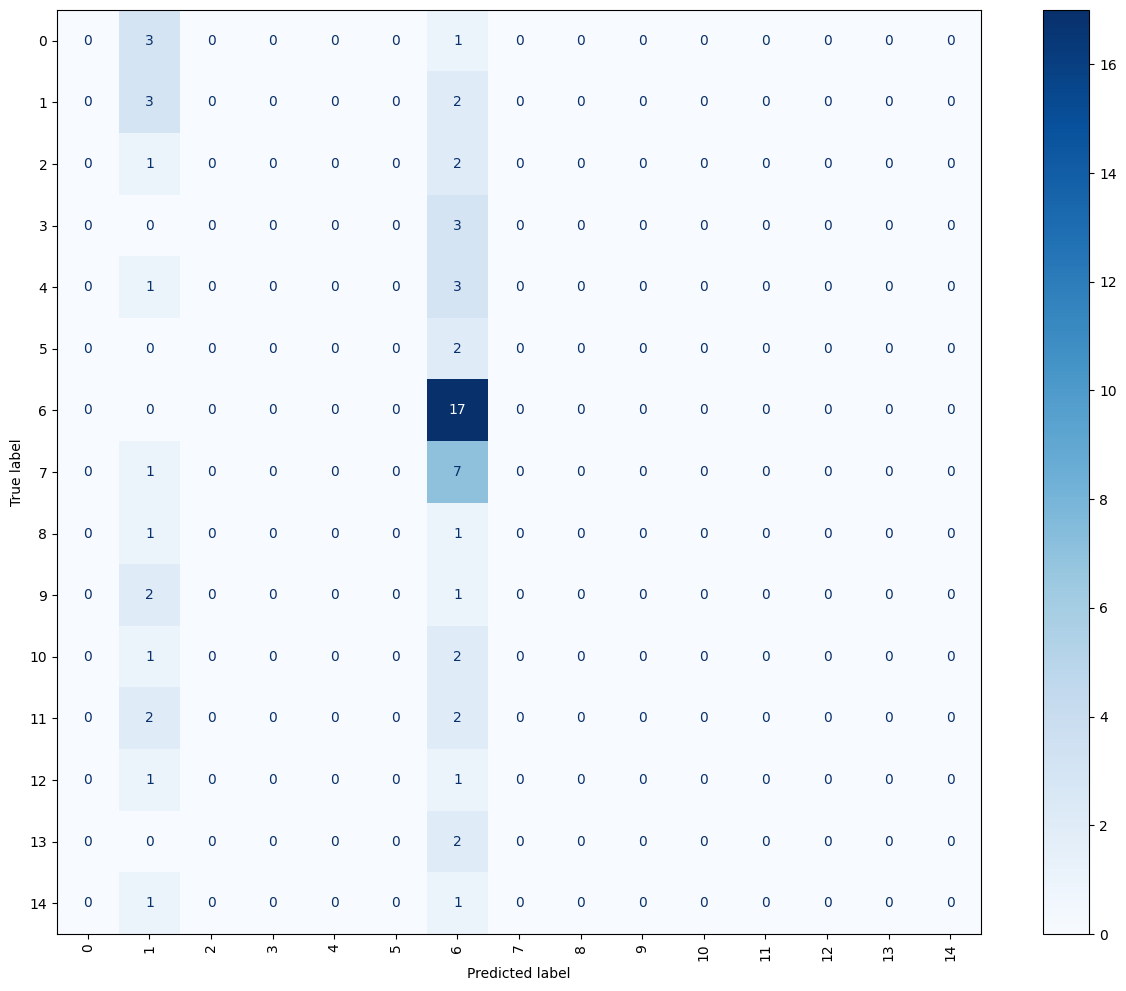

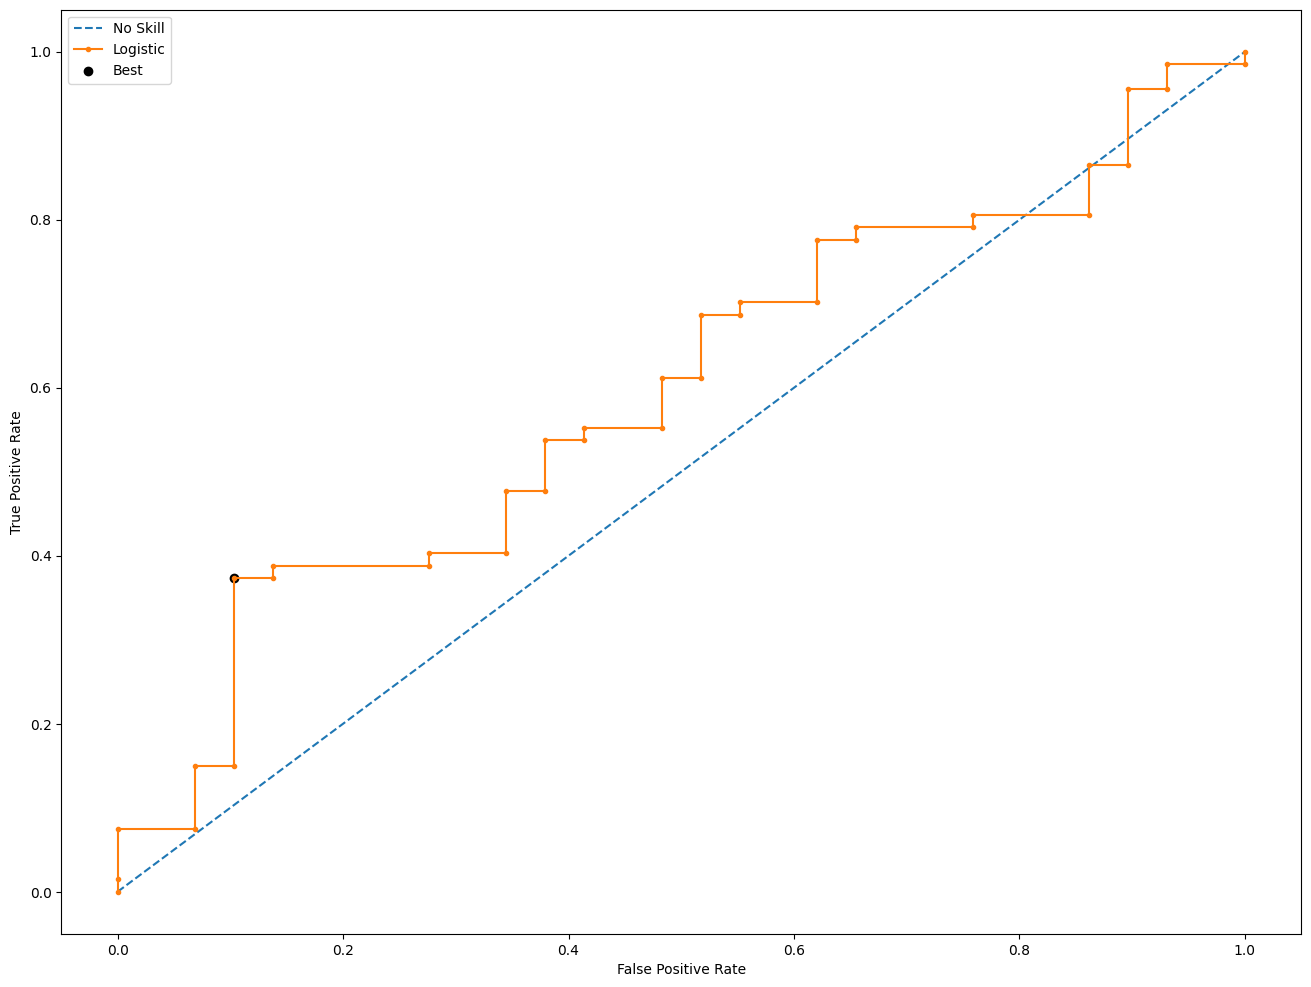

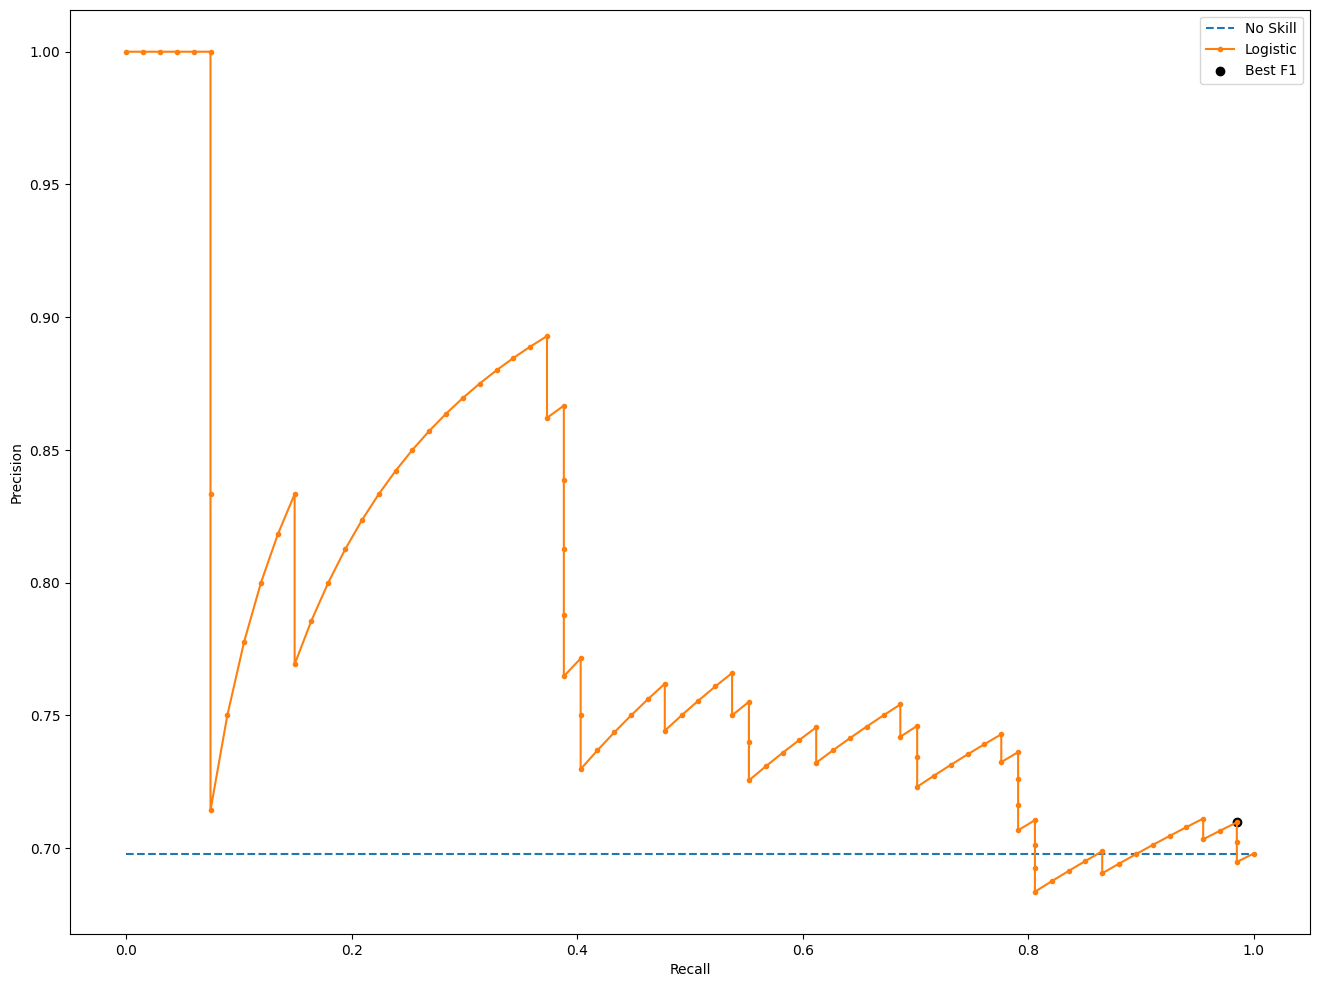

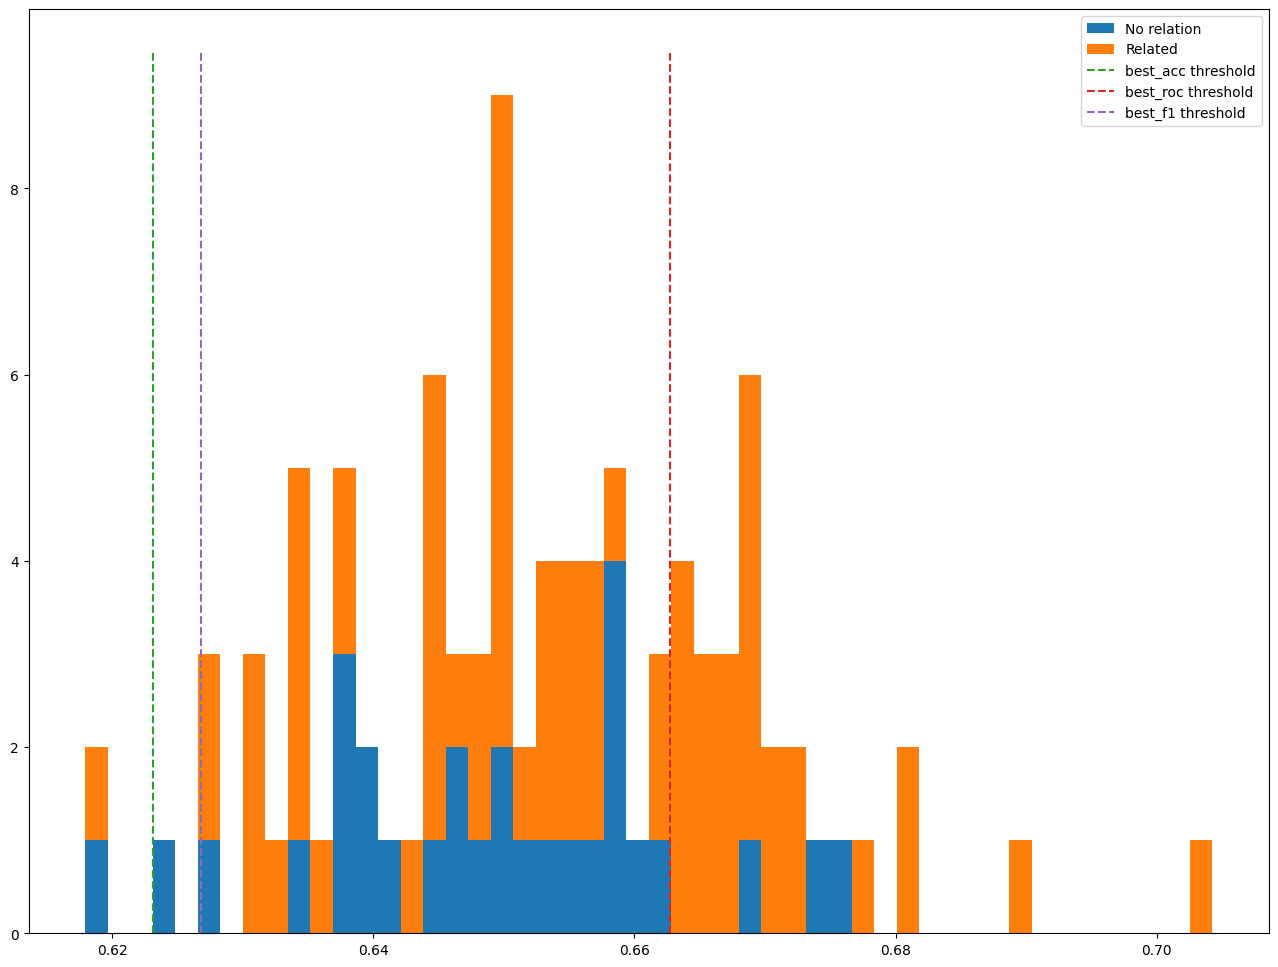

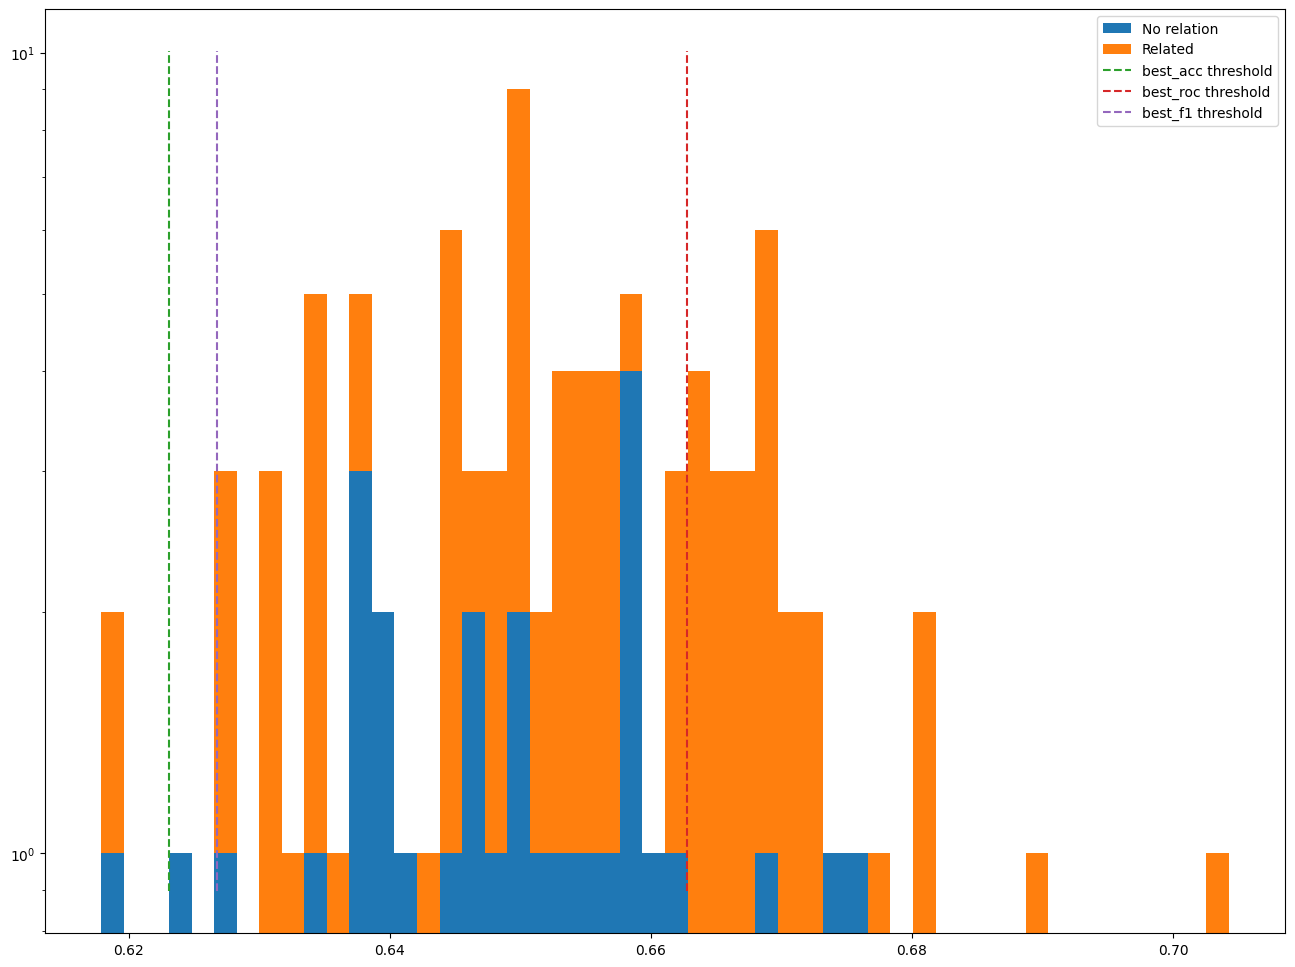

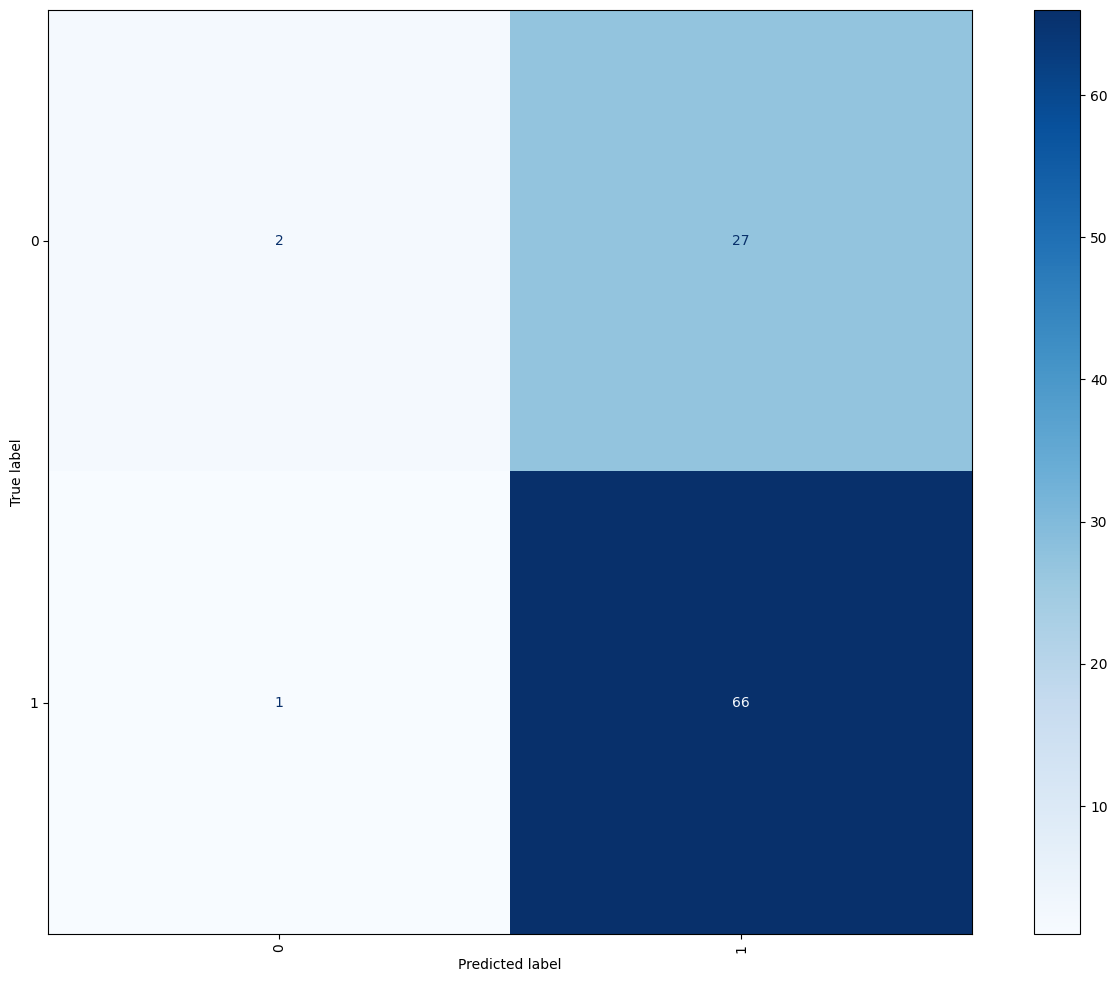

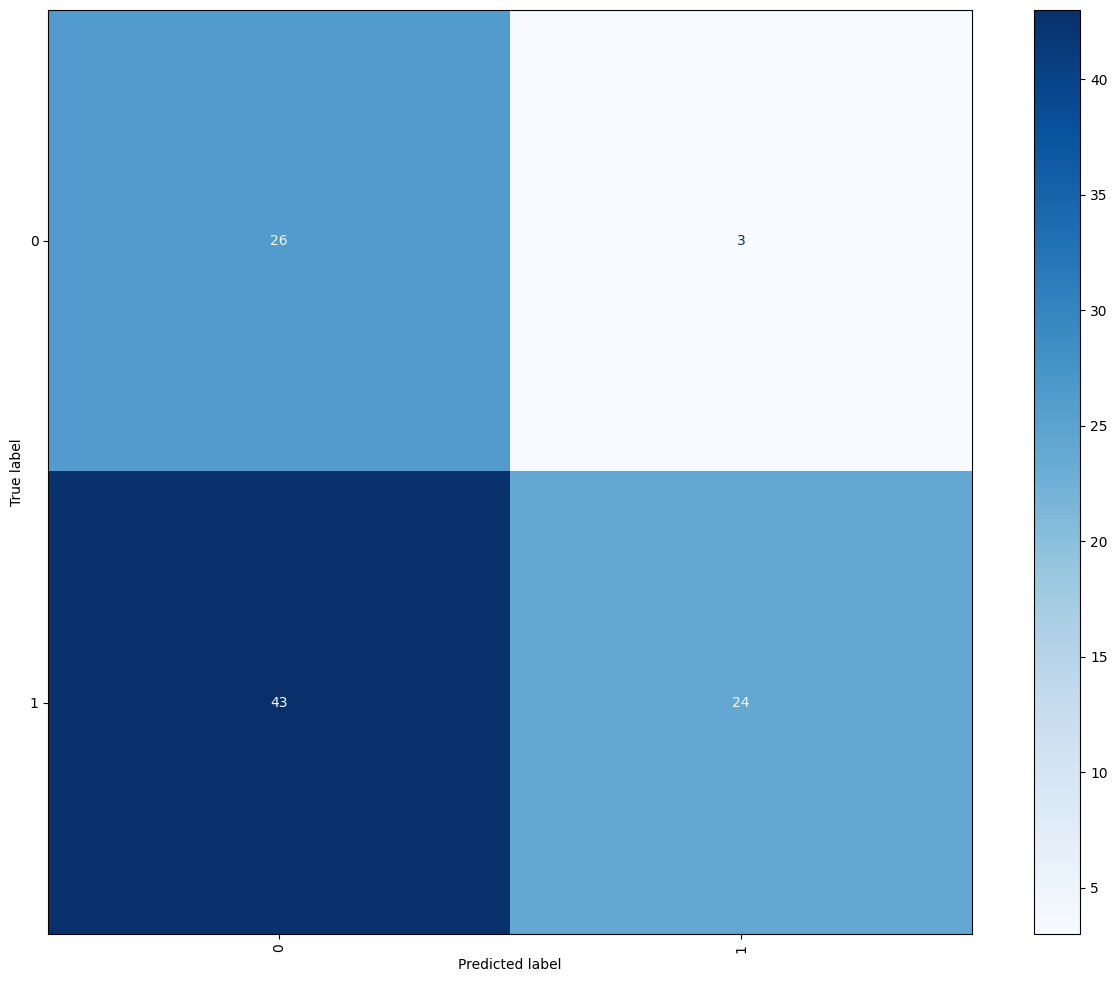

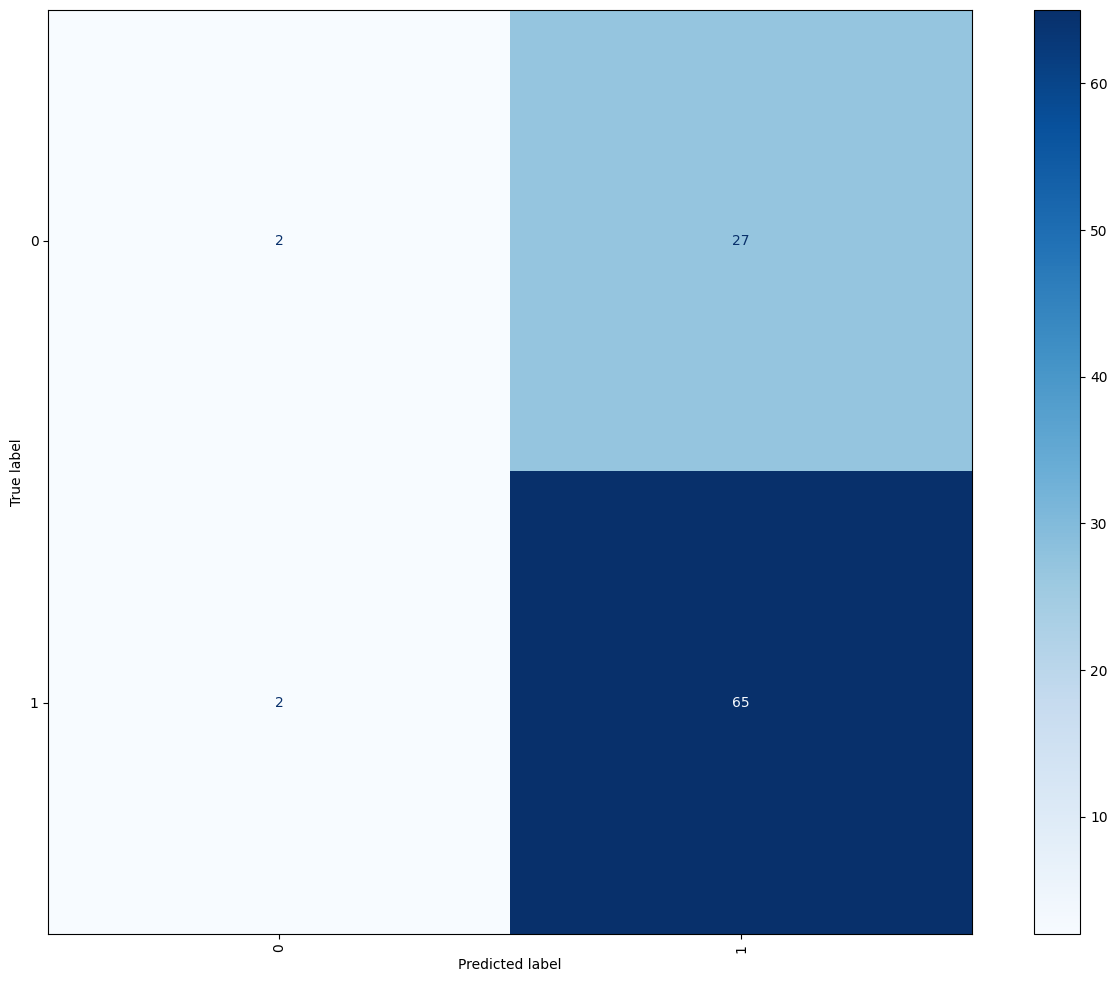

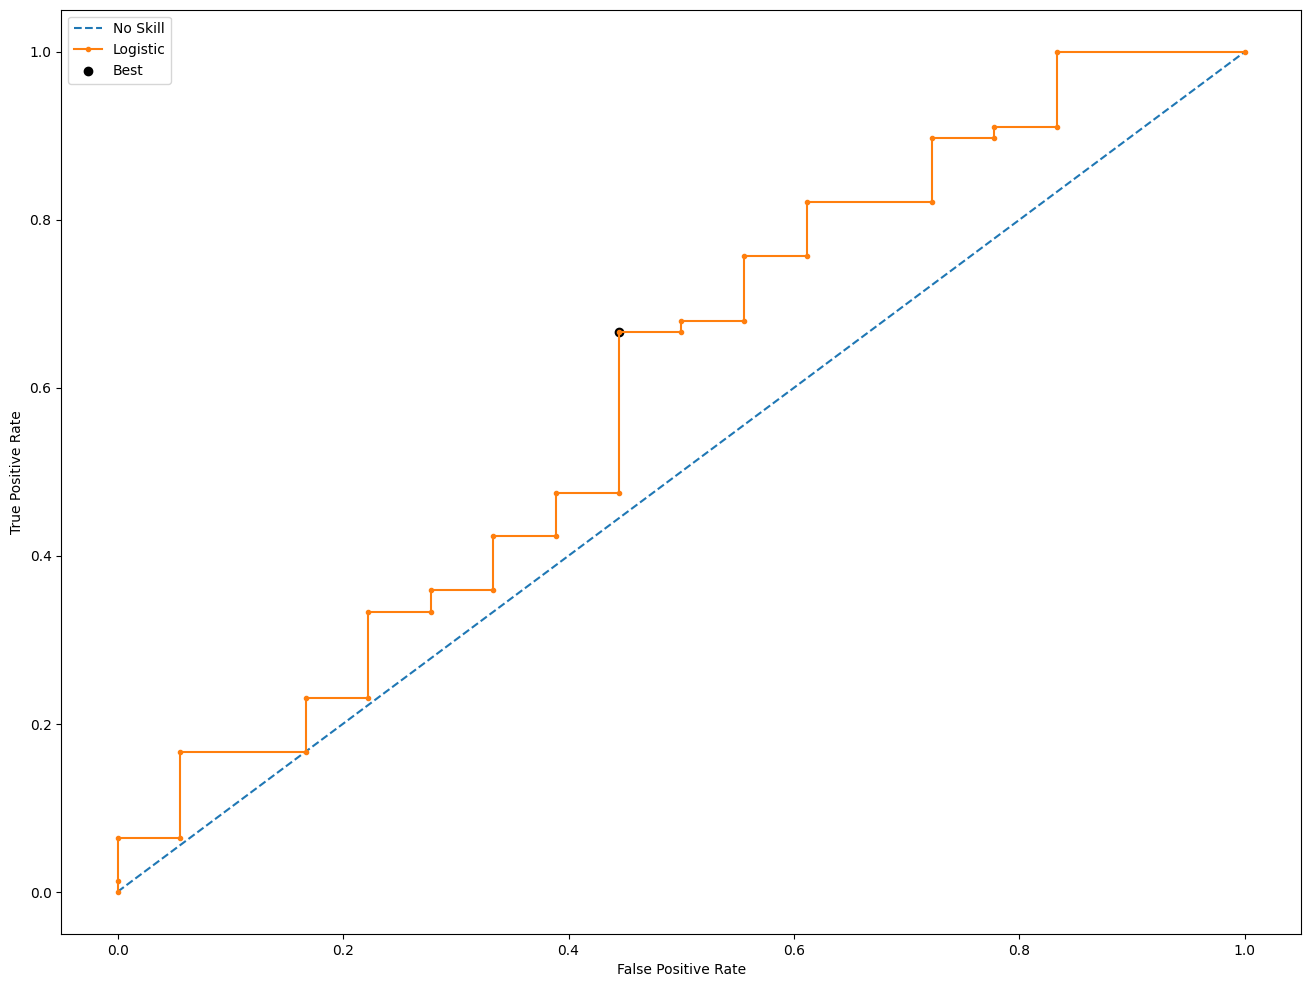

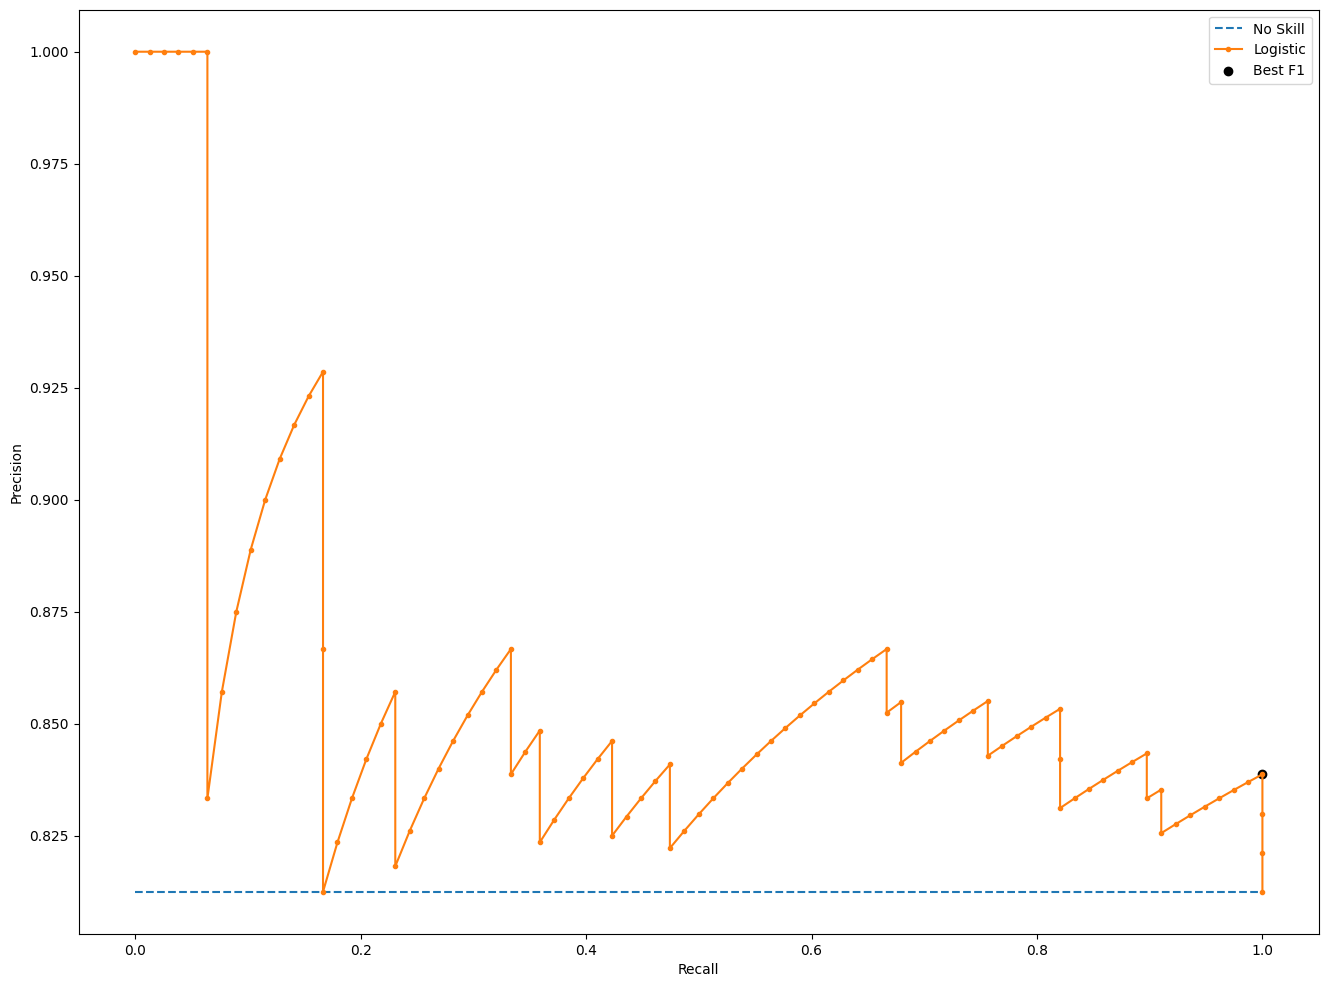

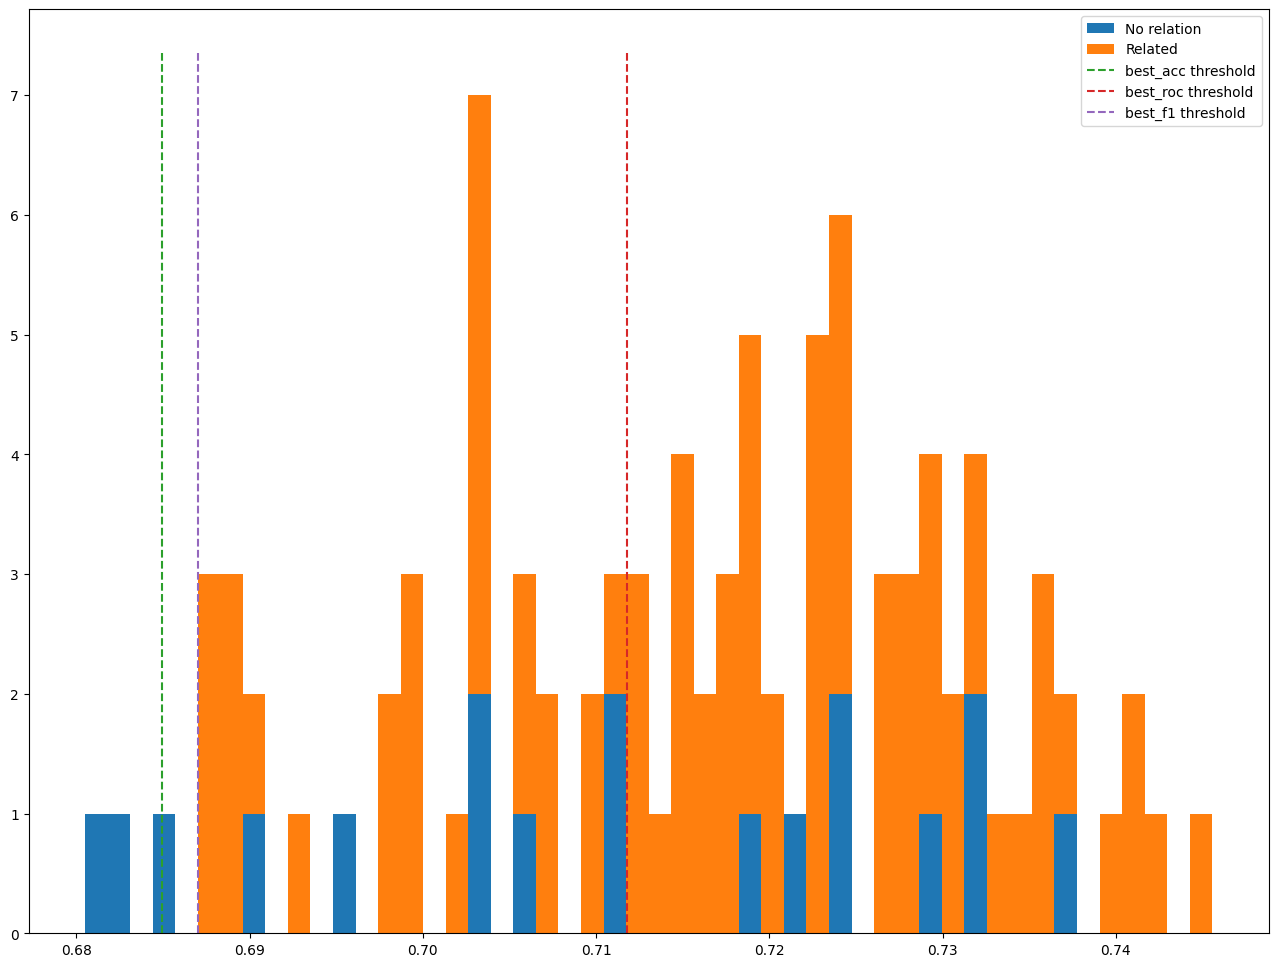

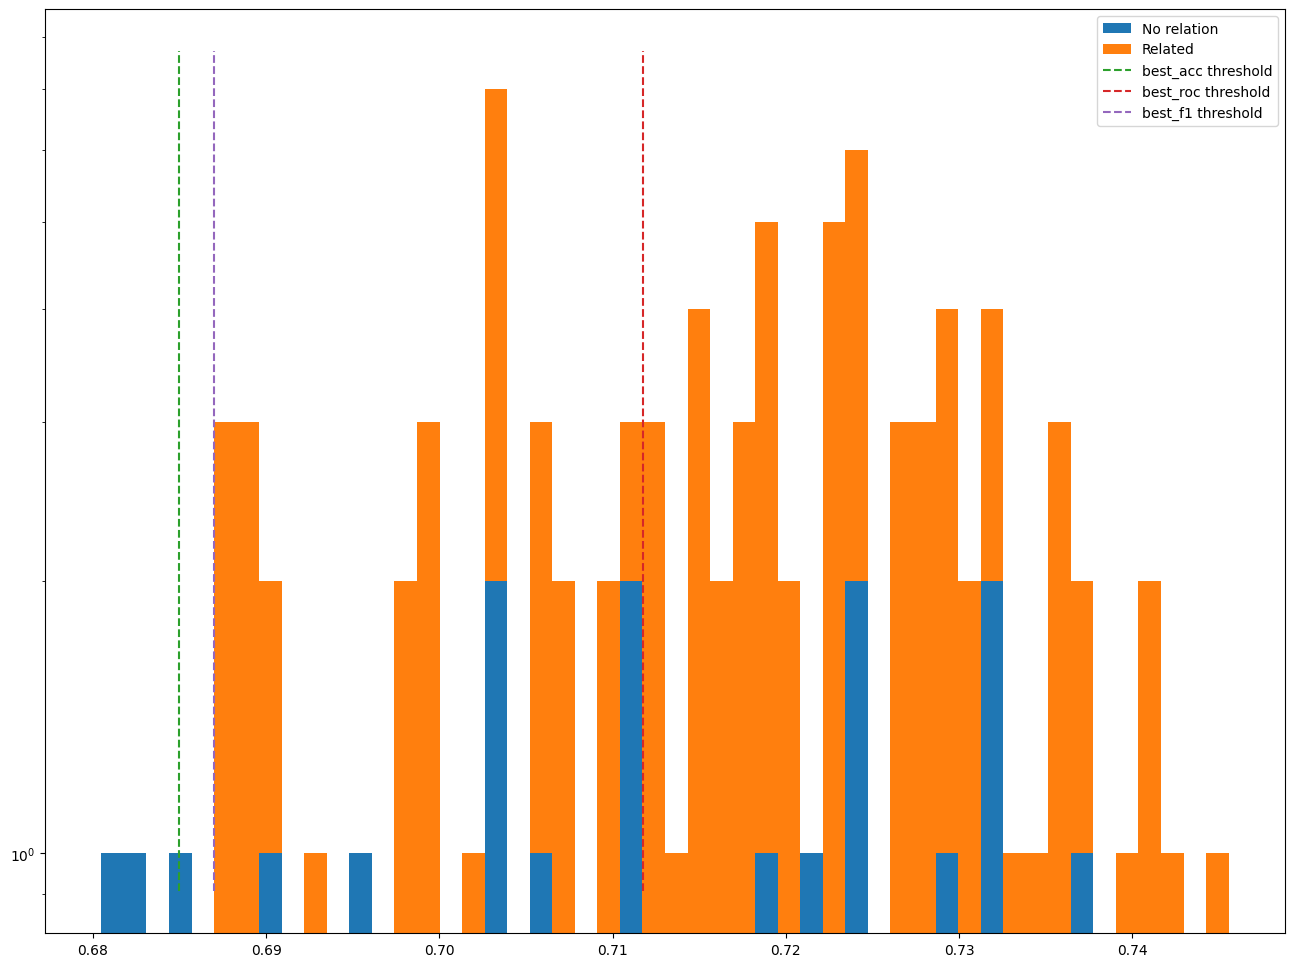

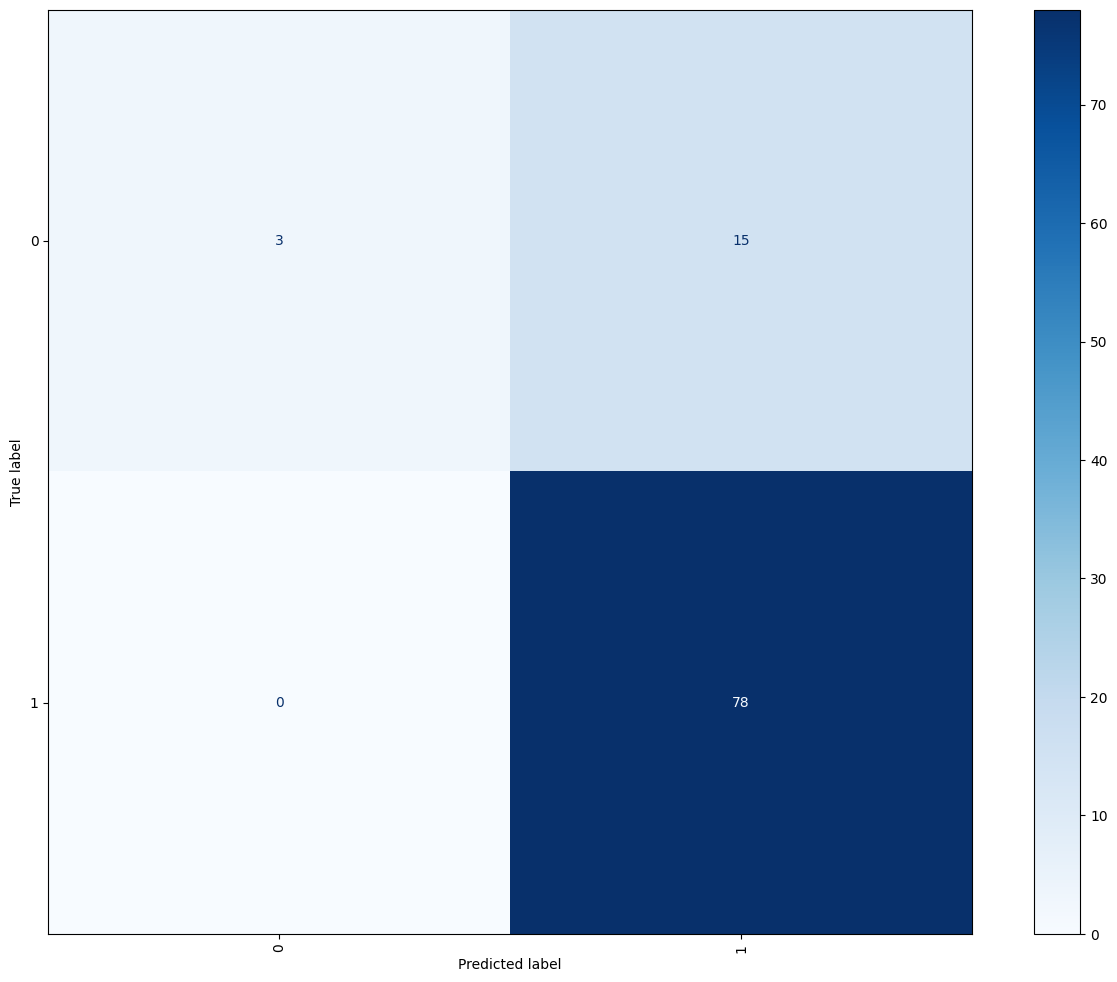

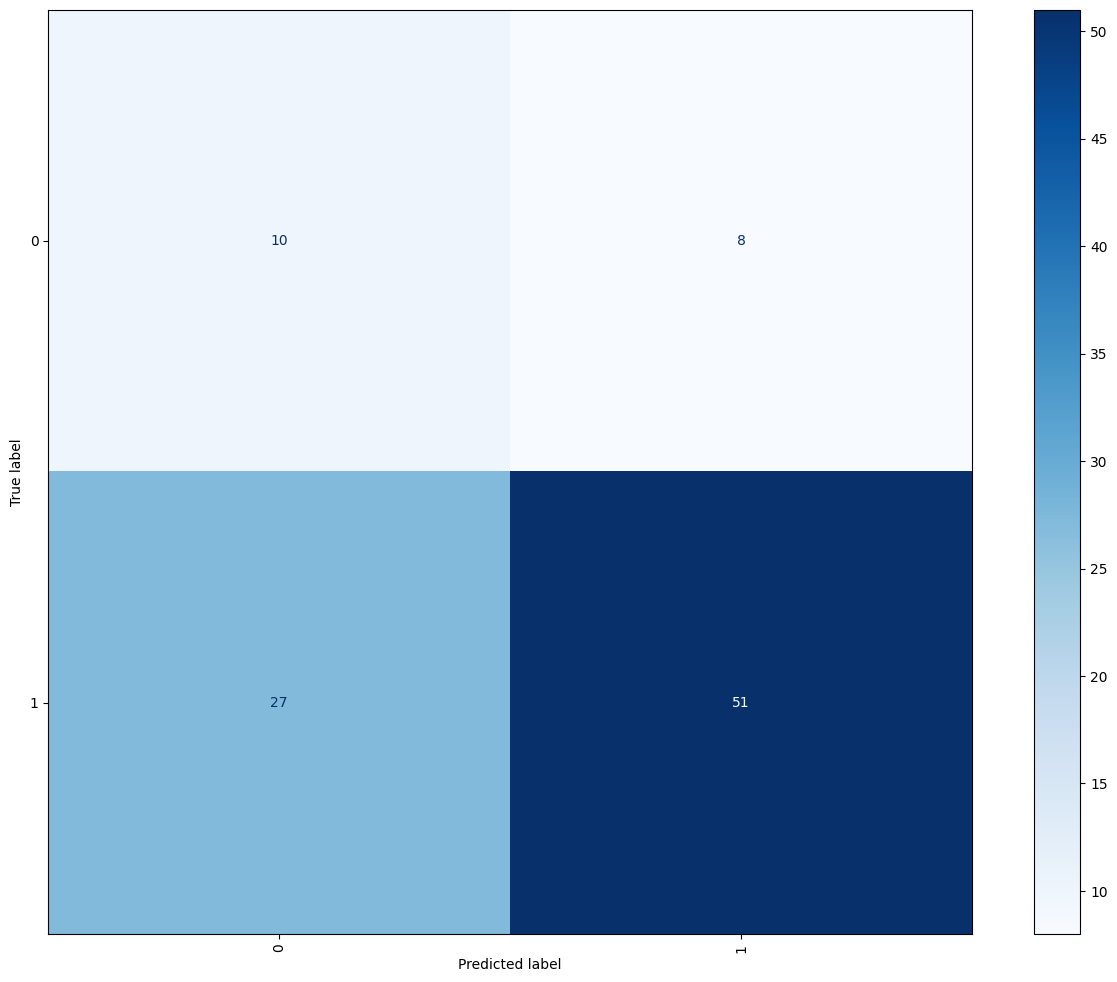

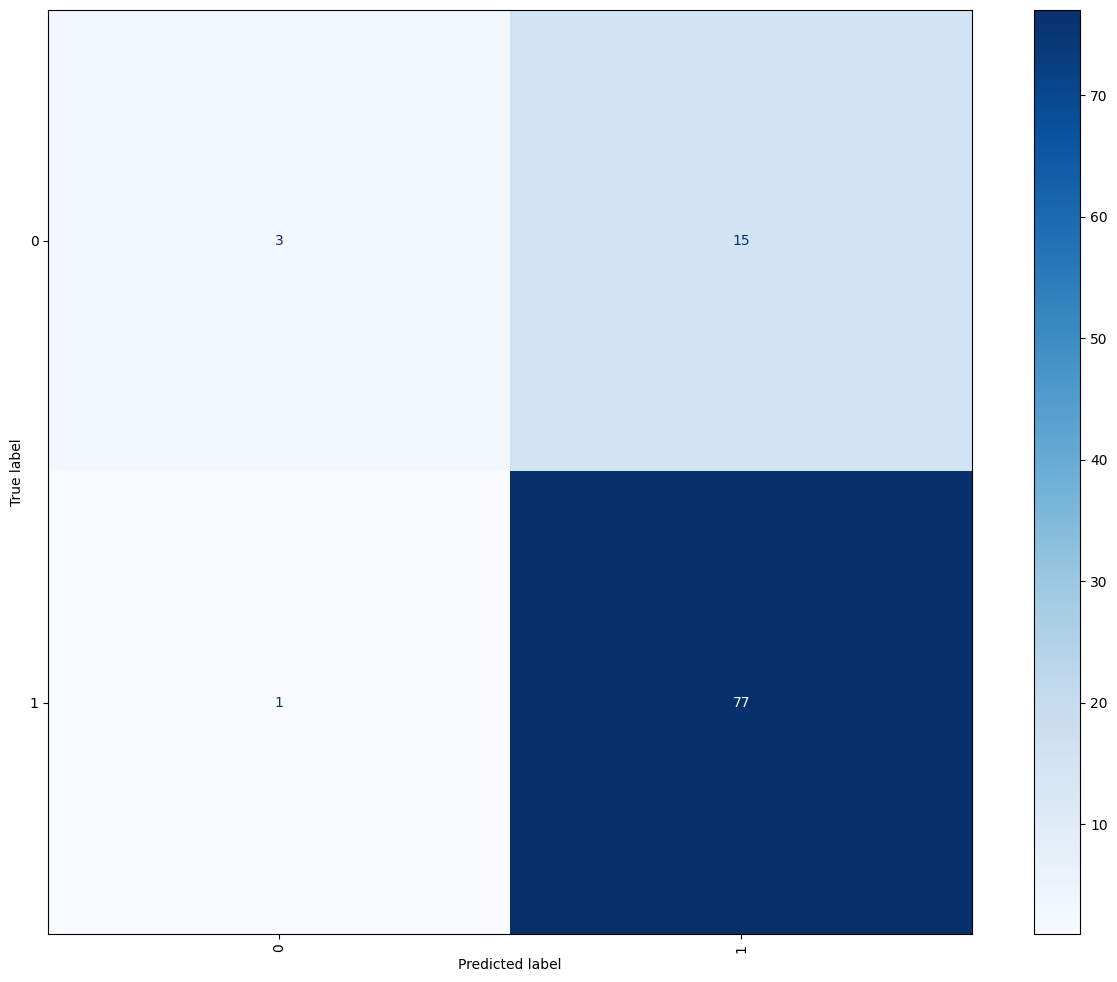

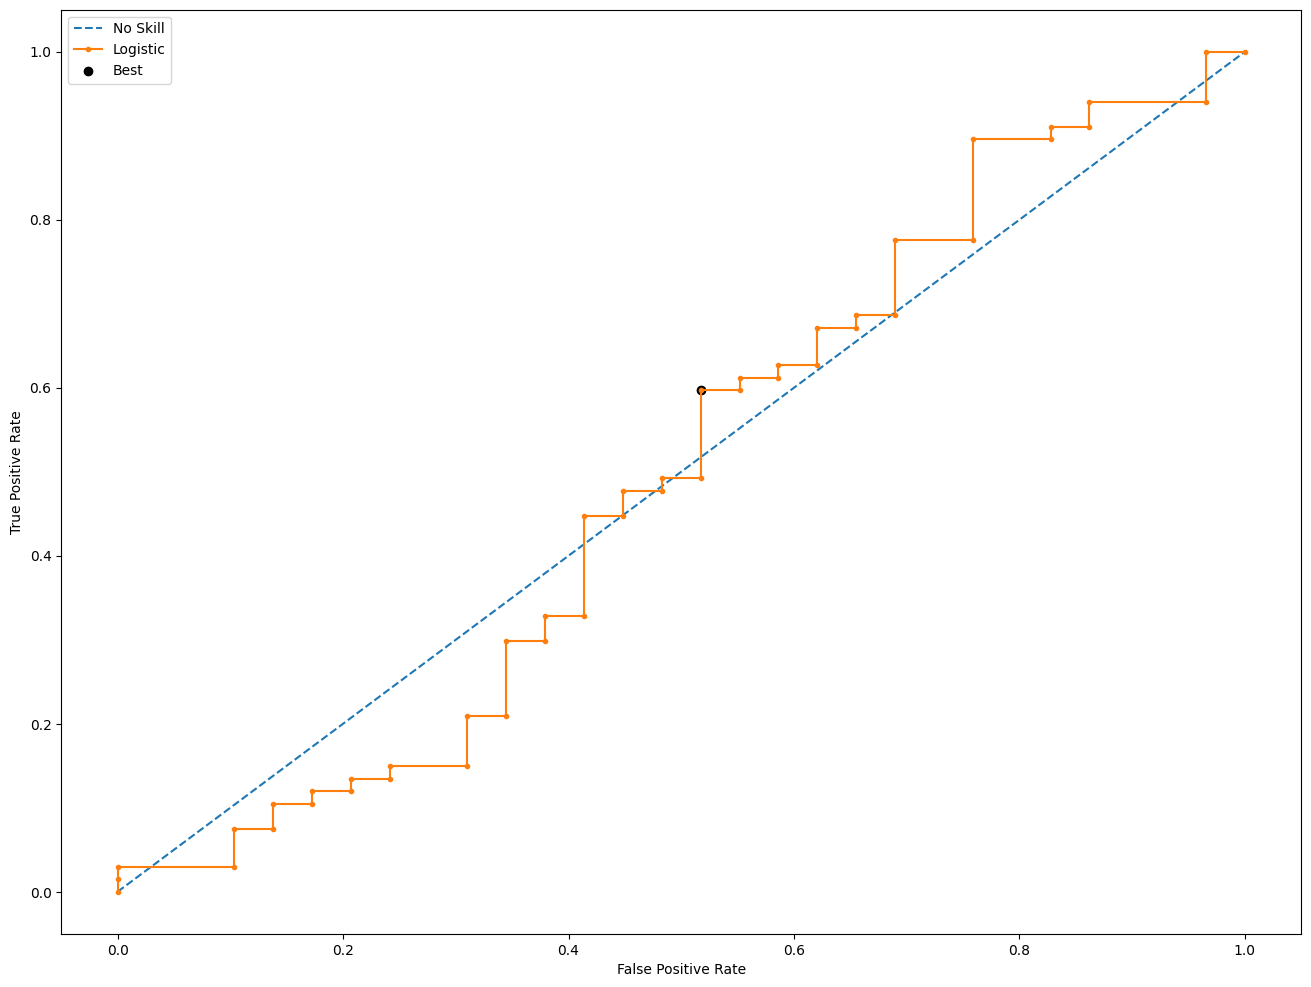

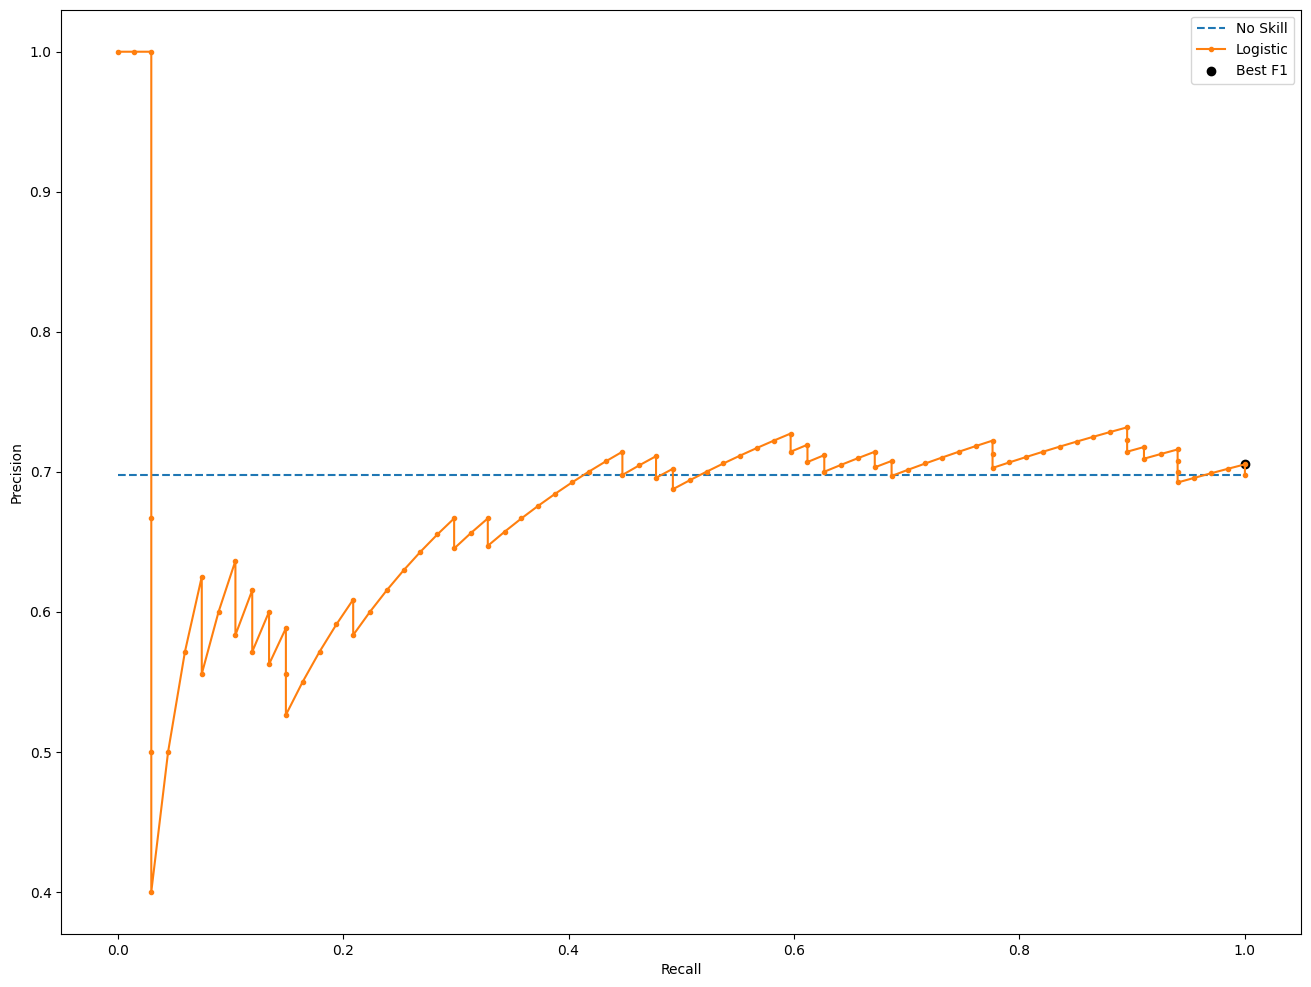

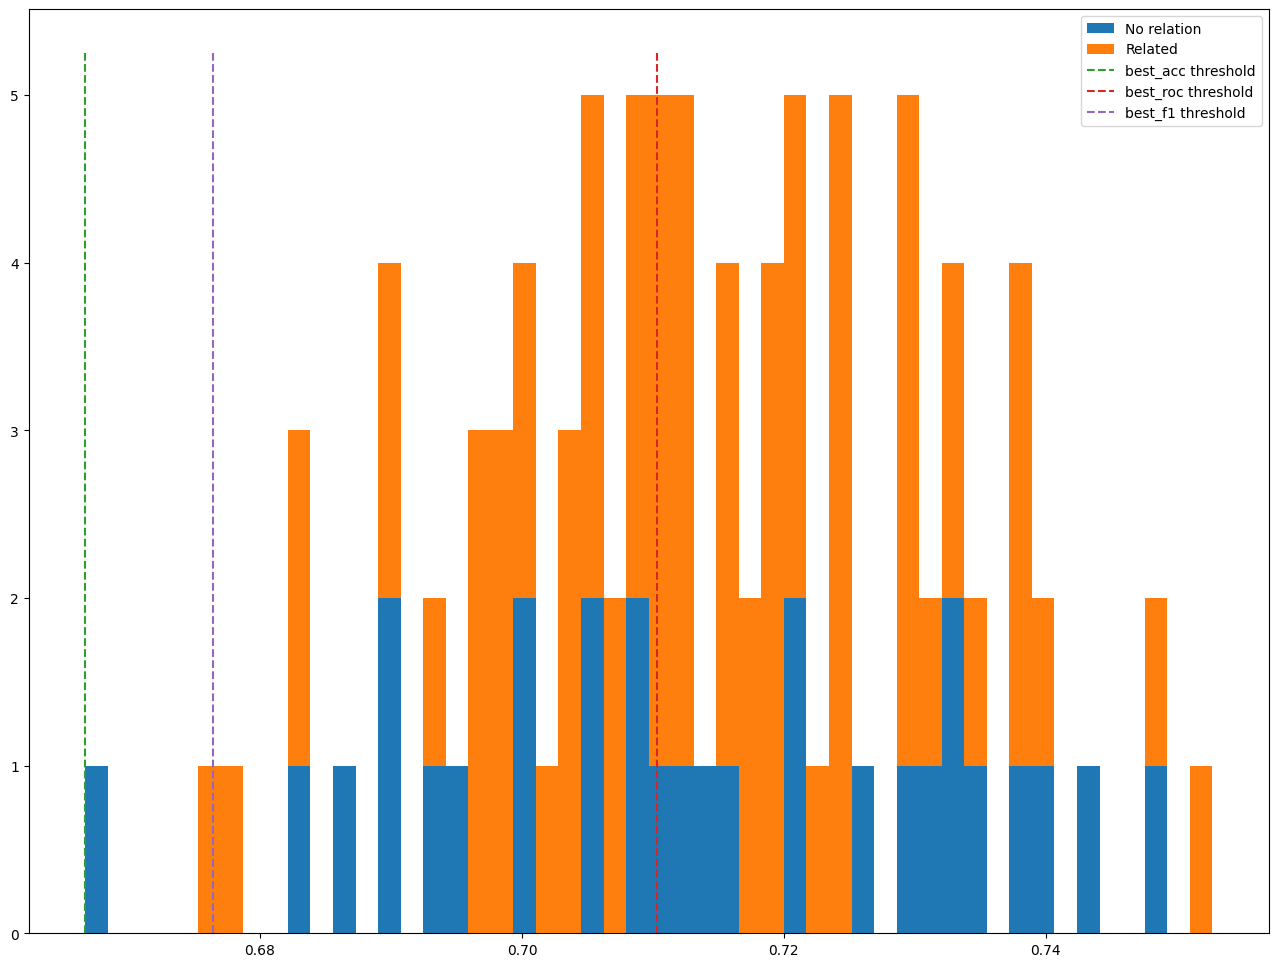

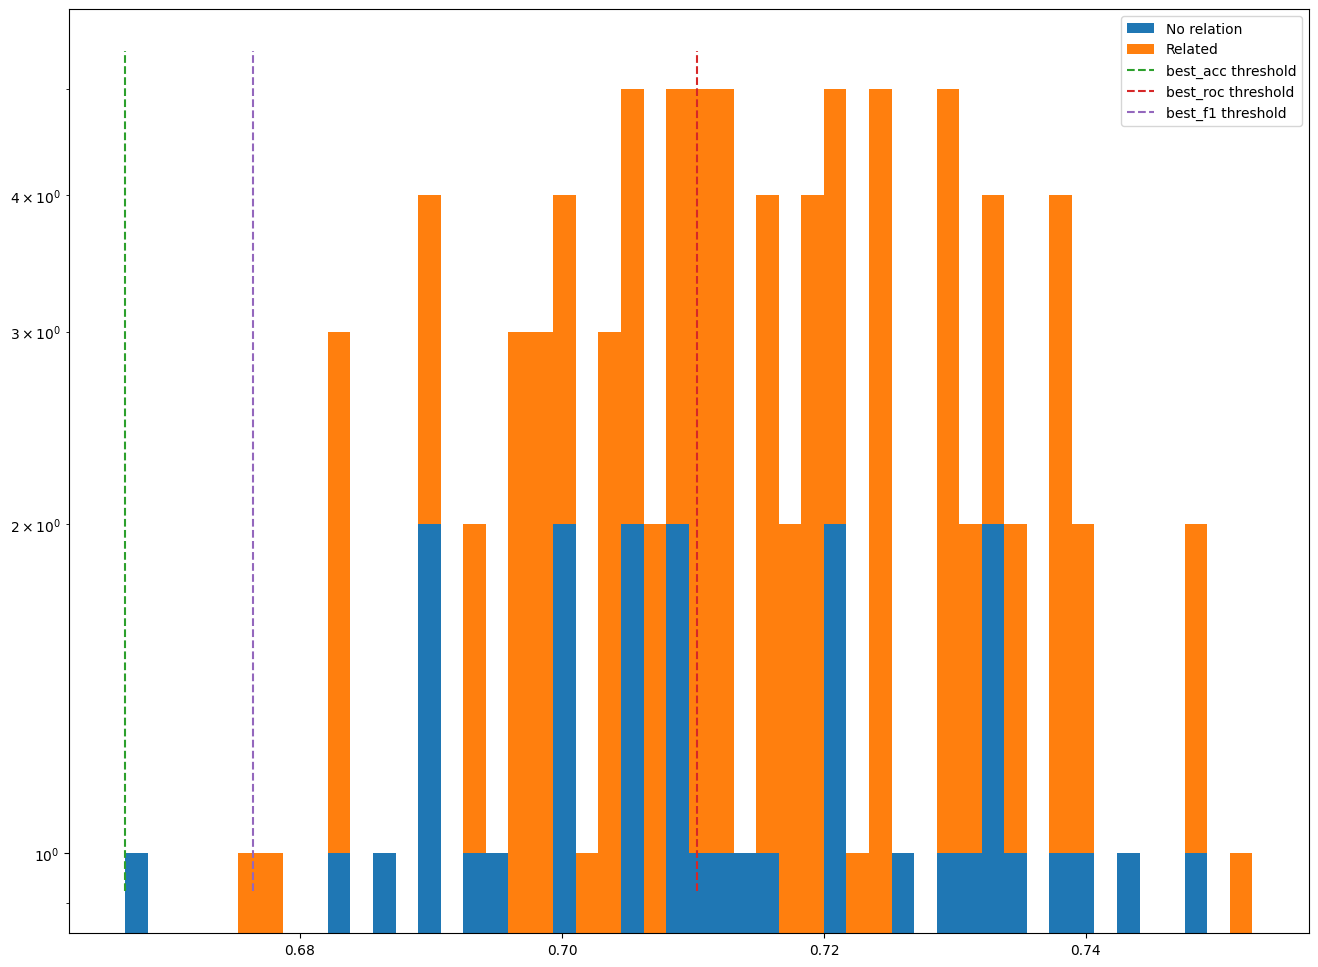

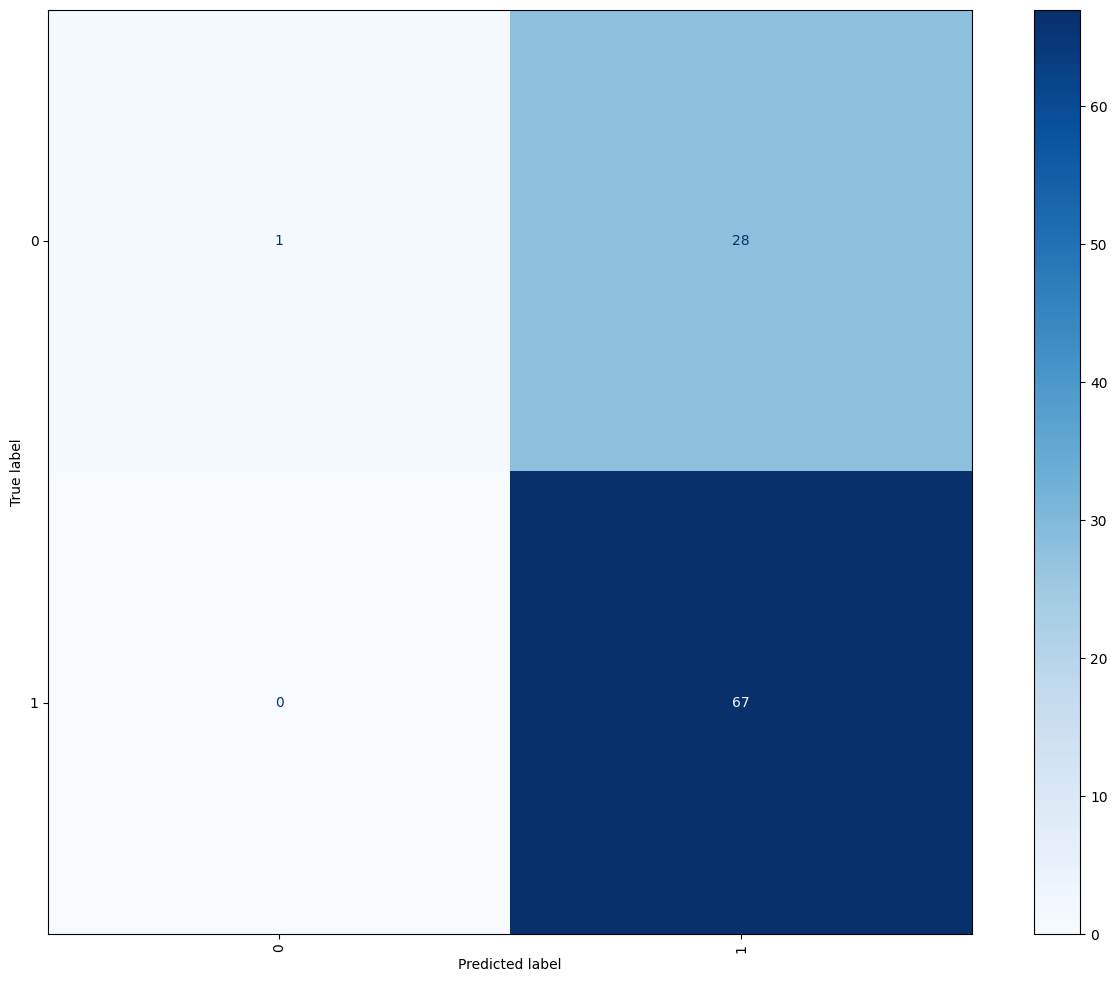

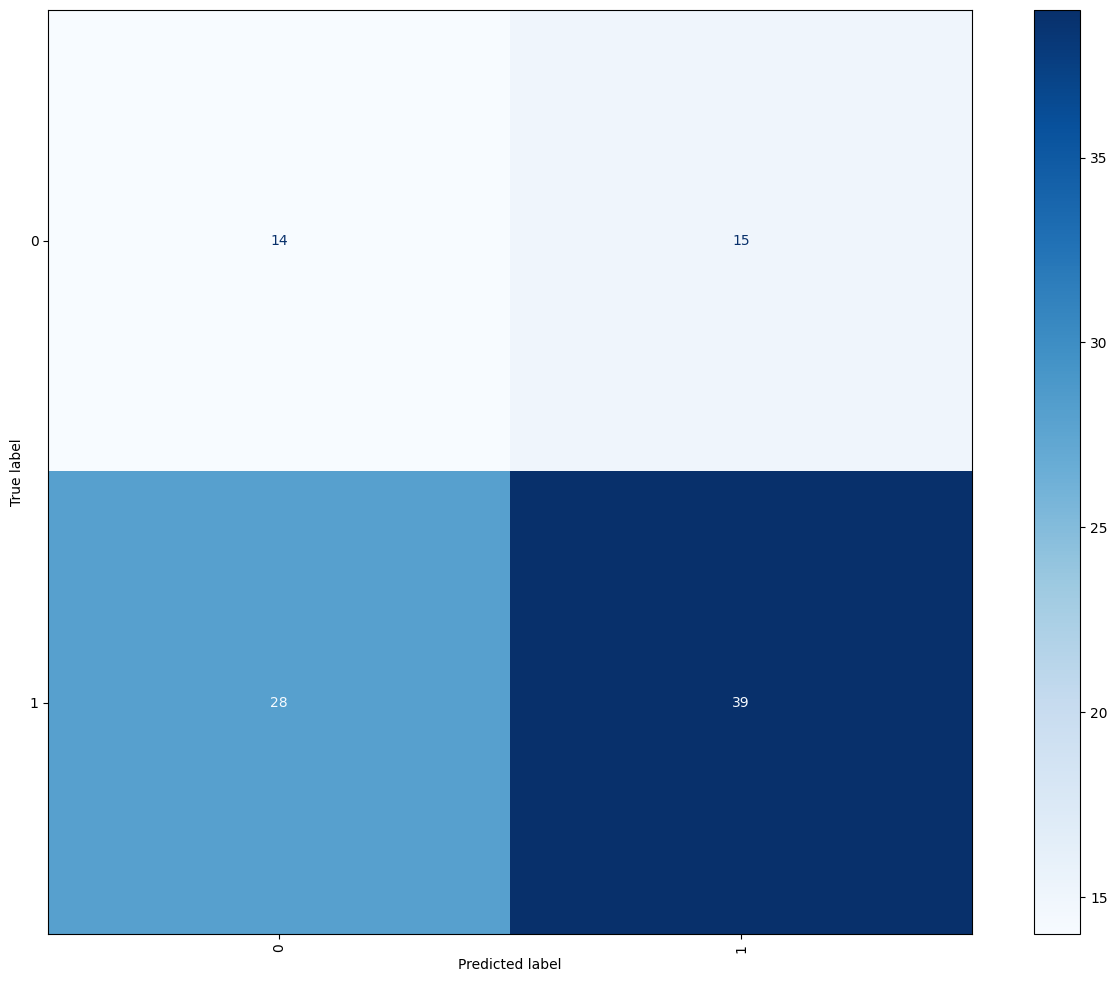

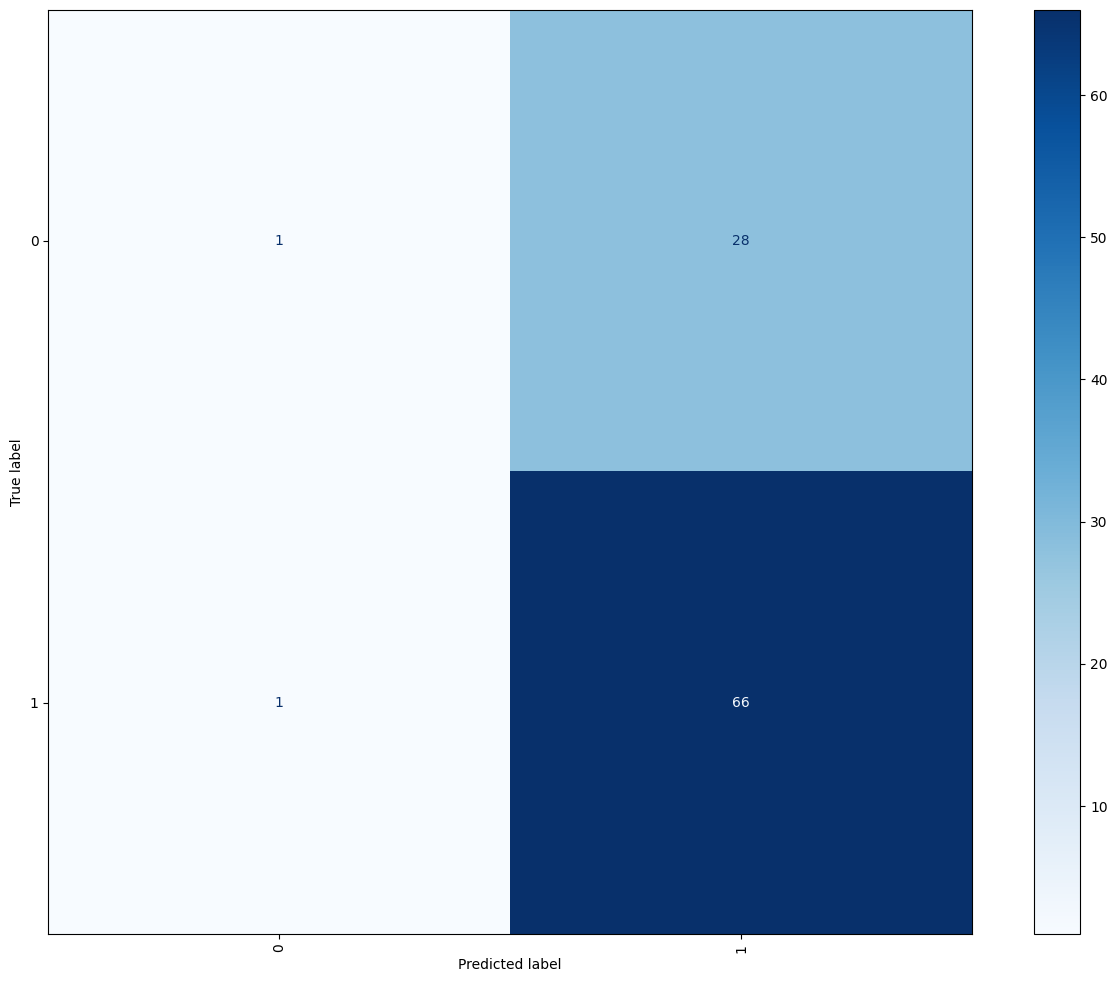

In [23]:
combine_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0YmEyZTg2ZC0zNDMxLTQ2MzItOWEzYS0xOWY5ZGNiYTA5YWYifQ==",
    project="Violetta/BERT"
)

try:
    for i in range(4):
        print(f"--------- EXPERIMENT {i} ---------")
    
        # clean up
        bin_classifier = bin_trainer = rel_classifier = rel_trainer = None
        gc.collect()
        torch.cuda.empty_cache()
    
        # relation classifier
        rel_trainer = LightningTrainer(
            accelerator="gpu",
            devices=[0],
            max_epochs=3,
            default_root_dir=CHECKPOINT_DIR,
            deterministic=False,
            enable_checkpointing=True,
            check_val_every_n_epoch=1,
            log_every_n_steps=1,  # 确保 step 递增，防止 Neptune step 乱序
            num_sanity_val_steps=0, # 禁用 Sanity Check 直接进入训练
            logger=combine_logger
        )
        rel_classifier = RelationClassifier(
            pretrained_language_model=PRETRAINED_MODEL,
            dataset_name=DATASET_NAME,
            batch_size=REL_BATCH_SIZE,
            learning_rate=REL_LEARNING_RATE,
            decay_lr_speed=REL_LEARNING_RATE_DECAY_SPEED,
            dropout_p=REL_DROPOUT_P,
            activation_function=REL_ACTIVATION_FUNCTION,
            weight_decay=REL_WEIGHT_DECAY,
            linear_size=REL_LINEAR_SIZE,
        )
        rel_trainer.fit(rel_classifier)
    
        # binary classifier
        bin_trainer = LightningTrainer(
            accelerator="gpu",
            devices=[0],
            max_epochs=3,
            default_root_dir=CHECKPOINT_DIR,
            deterministic=False,
            enable_checkpointing=True,
            check_val_every_n_epoch=1,
            log_every_n_steps=1,  # 确保 step 递增，防止 Neptune step 乱序
            num_sanity_val_steps=0, # 禁用 Sanity Check 直接进入训练
            logger=combine_logger,
        )
        bin_classifier = BinaryClassifier(
            pretrained_language_model=PRETRAINED_MODEL,
            dataset_name=DATASET_NAME,
            batch_size=BIN_BATCH_SIZE,
            learning_rate=BIN_LEARNING_RATE,
            decay_lr_speed=BIN_LEARNING_RATE_DECAY_SPEED,
            dropout_p=BIN_DROPOUT_P,
            activation_function=BIN_ACTIVATION_FUNCTION,
            weight_decay=BIN_WEIGHT_DECAY,
            linear_size=BIN_LINEAR_SIZE,
        )
        bin_trainer.fit(bin_classifier)
        
        # test together
        test_together(i, combine_logger, bin_classifier, rel_classifier)

except Exception as e:
    # combine_logger.experiment.stop(str(e))
    raise e

# else:
#     combine_logger.experiment.stop()